<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [57]</a>'.</span>

In [1]:
import logging
logger = logging.getLogger('retrain_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')



# Config

In [2]:
import sys
TRAIN = True
TRAIN_MODEL_3 = False
IN_COLAB = 'google.colab' in sys.modules
print ('Running in colab:', IN_COLAB)

Running in colab: False


In [3]:
import os

if not IN_COLAB:
  nb_dir = os.path.split(os.getcwd())[0]
  if nb_dir not in sys.path:
      sys.path.append(nb_dir)
else:
  %tensorflow_version 1.x
  import tensorflow as tf
  print(tf.__version__)

In [4]:
if IN_COLAB:
  !pip install --upgrade pip
  !pip --version
  !pip install --no-deps --upgrade git+https://www.github.com/nemoware/analyser.git@uber-models
  !pip install -q pyjarowinkler overrides
  

In [5]:
import os
import random
import math
import json
import warnings

from os import path
from pathlib import Path
import analyser.hyperparams

training_reports_path = Path(analyser.hyperparams.__file__).parent.parent / 'training_reports/'

if not IN_COLAB:
    _work_dir_default = os.path.realpath(os.path.join(  analyser.hyperparams.__file__, '..', '..', '..', 'work'))
    work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)

    if not os.path.isdir(work_dir):
        os.mkdir(work_dir)

    analyser.hyperparams.work_dir = work_dir
else:

    from google.colab import drive
    drive.mount('/content/drive')
    os.environ['GPN_WORK_DIR']='/content/drive/My Drive/GazpromOil/trainsets/uber_2'
    analyser.hyperparams.work_dir = os.environ['GPN_WORK_DIR']

print('work_dir=', analyser.hyperparams.work_dir)


assert os.path.isdir(analyser.hyperparams.work_dir)

Nemoware Analyser v23.1.27.1
USING WORKDIR: [/root/artem/work]
 set ENV GPN_WORK_DIR to override
datasets_dir: [/root/artem/work/datasets]
reports_dir: [/root/artem/work/reports]
work_dir= /root/artem/work


/root/artem/analyser/analyser/hyperparams.py:15: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')


# Imports

In [6]:
%matplotlib inline
import tensorflow as tf
print(tf.__version__)

 


import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

from colab_support.renderer import *

import pickle
import numpy as np
import pandas as pd

from bson import json_util

from analyser.legal_docs import LegalDocument, make_headline_attention_vector
from analyser.headers_detector import make_predicted_headline_attention_vector, get_tokens_features
from analyser.hyperparams import models_path
from analyser.text_tools import find_top_spans
from analyser.persistence import DbJsonDoc

from trainsets.trainset_tools import TrainsetBalancer, SubjectTrainsetManager
from trainsets.retrain_contract_uber_model import UberModelTrainsetManager

from tf_support import super_contract_model
from tf_support.super_contract_model import get_base_model, semantic_map_keys_contract
from tf_support.super_contract_model import uber_detection_model_005_1_1
from tf_support.tf_subject_model import decode_subj_prediction
from tf_support.tools import KerasTrainingContext
# from tf_support.embedder_elmo import ElmoEmbedder


from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
 
from keras.models import load_model


from tensorflow import keras
import keras.backend as K
from keras.layers import Conv1D, LSTM, GRU, BatchNormalization, TimeDistributed, Dense, Bidirectional, Input, Dropout, Lambda
from keras.layers import concatenate, SpatialDropout1D, ActivityRegularization
from keras.layers import MaxPooling1D, Activation, ThresholdedReLU, GaussianNoise

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential, Model

# from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences


2023-02-06 17:52:29.137054: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


2.5.0


/tmp/ipykernel_1553144/3340962001.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


HyperParameters.subsidiary_name_match_min_jaro_similarity 0.9649122807017544


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_USER environment variable! defaulting to None


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_PASSWORD environment variable! defaulting to None


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_URL environment variable! defaulting to None


[documents.py:270 -             __init__() ] loading word cases stats model from: /root/artem/analyser/analyser/vocab/word_cases_stats.pickle


[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/analyser/vocab


In [7]:
print('training_reports_path=', training_reports_path)

training_reports_path= /root/artem/analyser/training_reports


In [8]:
# gpu_devices = tf.config.experimental.list_physical_devices('GPU')

# for device in gpu_devices:
#     print(device)
#     tf.config.experimental.set_memory_growth(device, True)

# Prepare trainset


In [9]:
if not IN_COLAB:
  from integration.db import get_mongodb_connection
  from bson.objectid import ObjectId

  def get_doc(objid):
    db = get_mongodb_connection()
    documents_collection = db['documents']
    jdata = documents_collection.find_one({'_id': ObjectId(objid)})
    return DbJsonDoc(jdata)

In [10]:
if False:
    jdoc = get_doc('5df1f44dec85d861954efc47')
    doc = jdoc.asLegalDoc()
    doc.tokens
    

work_dir = Path(analyser.hyperparams.work_dir)
print(work_dir)

/root/artem/work


In [11]:
# xx = stats.loc[stats['user_correction_date'].notnull()]
# xx = xx[ (xx.version=='3.0.0') | (xx.version=='22.12.7')].sort_values(['score'])
# xx.to_csv('contracts_to_re-analyze.csv')
# xx

In [12]:
# xx = stats.loc[stats['user_correction_date'].notnull()]
# xx['user_correction_date'] = pd.to_datetime(xx['user_correction_date'], utc=True)


# xx['user_correction_date'] = xx['user_correction_date'].astype('datetime64[ns]')


# xx.to_datetime(df_res['DateTime'], utc=True)

# xx['user_correction_date'] = xx['user_correction_date'].dt.tz_localize(None)

# xx.sort_values(['user_correction_date'])

In [13]:
# yy = xx.sort_values(['user_correction_date'])[xx.version!='22.12.7'][xx.source=='db'].sort_values(['score'])
# yy

In [14]:
# stats['user_correction_date'] = stats['user_correction_date'].dt.tz_localize(None)
# stats.sort_values(['user_correction_date'])

In [15]:
# yy.to_csv('contracts_to_review.csv')

In [16]:
umtm = UberModelTrainsetManager (work_dir, reports_dir=training_reports_path)

umtm.load_contract_trainset_meta() # 'contract_trainset_meta.csv'
stats = umtm.stats
stats

source                          checksum    version  \
_id                                                                            
5ec2b8da665f7603e03b1255     db  3187bfac60ea578221c5d9357756c6c1      1.6.5   
5edbc62eda3678279fbcadf3   file  027a7c30f74ff8ffe684378e9883dd8e      2.0.2   
5ded4e284ddc27bcf92dd6ce   file  9a44591c17d2b8f34dc8f1c3600c8c3a     1.11.2   
63ce49f8e83d1ee490f3f21c     db  25d924fc09b7291d964f464f9c3ec8c3  23.1.27.1   
63908ca4a1bded13e629f2eb     db  3bc04887446d02692e886db2545bba61    22.12.7   
...                         ...                               ...        ...   
63c506bbe2456d59975e10d3     db  874cd51371532aced3062000ca3f5334   23.01.04   
6380858b6a07f3e980b2c4c3     db  f9f2ddea91cdfe00b15e149fcf682ed8      3.0.0   
63ce4b0be83d1ee490f4009d     db  a35591663822c05db4729b91ed3a9276   23.01.23   
63c506d5e2456d59975e1389     db  2628dbfa46813bc351104e1ebdc6d6a2   23.01.04   
63c506ece2456d59975e15ad     db  5c16bf00da66d39e72a08d9838b1f501   23.01.04   

                                         export_date      len  \
_id                                                             
5ec2b8da665f7603e03b1255  2023-02-06 15:35:23.992744   5840.0   
5edbc62eda3678279fbcadf3  2023-02-06 15:35:07.348450   1370.0   
5ded4e284ddc27bcf92dd6ce  2023-02-06 15:35:03.765185    460.0   
63ce49f8e83d1ee490f3f21c  2023-02-03 16:19:06.576376   8530.0   
63908ca4a1bded13e629f2eb  2023-01-31 18:38:08.500901  13410.0   
...                                              ...      ...   
63c506bbe2456d59975e10d3  2023-01-31 21:42:32.301540   6540.0   
6380858b6a07f3e980b2c4c3  2023-01-31 18:36:12.057993  10650.0   
63ce4b0be83d1ee490f4009d  2023-01-31 21:43:37.191817  11690.0   
63c506d5e2456d59975e1389  2023-01-31 21:42:26.523639   2170.0   
63c506ece2456d59975e15ad  2023-01-31 21:42:26.812111   1230.0   

                                             analyze_date         value  \
_id                                                                       
5ec2b8da665f7603e03b1255 2020-05-18 17:16:38.114000+00:00  2.523632e+07   
5edbc62eda3678279fbcadf3 2020-07-18 20:24:58.934000+00:00  2.400000e+04   
5ded4e284ddc27bcf92dd6ce 2020-06-12 21:09:19.574000+00:00  5.900000e+05   
63ce49f8e83d1ee490f3f21c 2023-01-28 09:34:50.691000+00:00  3.000000e+09   
63908ca4a1bded13e629f2eb 2022-12-08 13:59:29.898000+00:00  2.000000e+10   
...                                                   ...           ...   
63c506bbe2456d59975e10d3 2023-01-16 12:51:04.442000+00:00           NaN   
6380858b6a07f3e980b2c4c3 2022-11-25 19:27:25.157000+00:00           NaN   
63ce4b0be83d1ee490f4009d 2023-01-26 07:15:10.062000+00:00           NaN   
63c506d5e2456d59975e1389 2023-01-16 11:21:48.816000+00:00           NaN   
63c506ece2456d59975e15ad 2023-01-16 11:26:04.804000+00:00           NaN   

                          value_log1p  value_span currency  ... subj_len  \
_id                                                         ...            
5ec2b8da665f7603e03b1255    17.043795      5674.0      BRL  ...     79.0   
5edbc62eda3678279fbcadf3    10.085851       747.0      RUB  ...    106.0   
5ded4e284ddc27bcf92dd6ce    13.287880       150.0      RUB  ...     30.0   
63ce49f8e83d1ee490f3f21c    21.821878       337.0      RUB  ...     53.0   
63908ca4a1bded13e629f2eb    23.718998      2572.0      RUB  ...     84.0   
...                               ...         ...      ...  ...      ...   
63c506bbe2456d59975e10d3          NaN         NaN      NaN  ...     98.0   
6380858b6a07f3e980b2c4c3          NaN         NaN   рублей  ...     42.0   
63ce4b0be83d1ee490f4009d          NaN         NaN      NaN  ...    188.0   
63c506d5e2456d59975e1389          NaN         NaN      NaN  ...     34.0   
63c506ece2456d59975e15ad          NaN         NaN      NaN  ...     50.0   

                         headers  \
_id                                
5ec2b8da665f7603e03b1255     4.0   
5edbc62eda3678279fbcadf3    10.0   
5ded4e284ddc27bcf92dd6ce     

In [17]:
# stats[ ['org-1-alias', 'org-2-alias'] ]

user_dataset = stats[ stats['unseen']==False]
len(user_dataset)


1212

In [18]:
print(len(stats))

2706


In [19]:
user_dataset[user_dataset.subj_len>=150]

source                          checksum  version  \
_id                                                                          
6391b4771864c6df4d29f332     db  22f701119d81787cd423f79f0f9fd9db  22.12.7   
63908ca4a1bded13e629f2e4     db  665a638dc4f2c42ce670679ca76cff77  22.12.6   
62838b2e4d1bfe5e5b297ddb     db  c81664bbc202b2a143fe57dfcb950348    3.0.0   
5fb399dd39d5e82e90818477     db  44d1c22fb92ce75663dc046c184df359    2.0.5   
62d149464ae369b4976e31f3     db  31b2973970123953ebc9074a4dfaa421    3.0.0   
6380859e6a07f3e980b2c5c4     db  5d8d2a674adffa2c30fa1254e1047e40    3.0.0   
638085646a07f3e980b2c0e5     db  43519987735b5d2180168facc4404545    3.0.0   
6380855c6a07f3e980b2c061     db  9756e819859af5192b5e44806f173d8c  22.12.7   
6380857e6a07f3e980b2c343     db  24195a650ec51184b0b507d73fd67b7a    3.0.0   
638085686a07f3e980b2c124     db  0330bc8b29d42453fb0350e80da94743    3.0.0   
638085976a07f3e980b2c561     db  ec297f3094591fbad5418b2167357d4d    3.0.0   
638085ac6a07f3e980b2c733     db  7440524bbf921c898bfc35d1885bda2f    3.0.0   
638085a36a07f3e980b2c623     db  85bd0228e9e167ca8a7eb78c0ba8c305    3.0.0   
5fb3d7a178df3635f5441d6a     db  5e410fc2e9e1068575cf860ad7a4a632    2.0.5   
5fe4821fb770574a00555741     db  8dceb00aaefe9c38b75de9d170b212f5   2.3.13   
62c54895e599c73b751b7974     db  9756e819859af5192b5e44806f173d8c    3.0.0   
638085976a07f3e980b2c575     db  d7756a8860dee9f6d2c4e825566aaa6c    3.0.0   

                                         export_date      len  \
_id                                                             
6391b4771864c6df4d29f332  2023-02-06 15:35:27.174677   1990.0   
63908ca4a1bded13e629f2e4  2023-02-06 15:35:27.119189   2020.0   
62838b2e4d1bfe5e5b297ddb  2023-01-31 18:32:43.216593  25010.0   
5fb399dd39d5e82e90818477  2023-02-06 15:35:24.171772   5210.0   
62d149464ae369b4976e31f3  2023-02-06 15:35:26.079817   2050.0   
6380859e6a07f3e980b2c5c4  2023-01-31 18:32:52.073085   4180.0   
638085646a07f3e980b2c0e5  2023-01-31 18:32:45.290596  28200.0   
6380855c6a07f3e980b2c061  2023-02-06 15:35:27.164485   1950.0   
6380857e6a07f3e980b2c343  2023-01-31 18:32:46.337373   5020.0   
638085686a07f3e980b2c124  2023-01-31 18:32:45.969271   2970.0   
638085976a07f3e980b2c561  2023-01-31 18:32:48.530026   4480.0   
638085ac6a07f3e980b2c733  2023-01-31 18:32:48.969831   1980.0   
638085a36a07f3e980b2c623  2023-01-31 18:32:48.780383   4090.0   
5fb3d7a178df3635f5441d6a  2023-01-31 18:36:01.135666   2030.0   
5fe4821fb770574a00555741  2023-01-31 18:36:06.228625   2030.0   
62c54895e599c73b751b7974  2023-02-06 15:35:26.073414   1950.0   
638085976a07f3e980b2c575  2023-01-31 18:32:48.568796   6460.0   

                                             analyze_date         value  \
_id                                                                       
6391b4771864c6df4d29f332 2022-12-08 22:25:50.608000+00:00  1.000000e+11   
63908ca4a1bded13e629f2e4 2022-12-07 15:55:04.590000+00:00  1.500000e+10   
62838b2e4d1bfe5e5b297ddb 2022-05-17 14:47:43.209000+00:00  3.050000e+09   
5fb399dd39d5e82e90818477 2020-11-17 09:58:23.635000+00:00  4.338600e+05   
62d149464ae369b4976e31f3 2022-07-15 14:09:08.607000+00:00  1.000000e+04   
6380859e6a07f3e980b2c5c4 2022-11-25 20:00:26.236000+00:00  1.705600e+06   
638085646a07f3e980b2c0e5 2022-11-25 12:30:29.763000+00:00  3.147910e+05   
6380855c6a07f3e980b2c061 2022-12-08 16:02:19.987000+00:00  5.000000e+02   
6380857e6a07f3e980b2c343 2022-11-25 12:31:32.455000+00:00  2.923300e+07   
638085686a07f3e980b2c124 2022-11-25 12:30:38.681000+00:00  5.897600e+05   
638085976a07f3e980b2c561 2022-11-25 12:33:11.663000+00:00  4.949780e+05   
638085ac6a07f3e980b2c733 2022-11-25 12:34:24.346000+00:00  1.230600e+05   
638085a36a07f3e980b2c623 2022-11-25 12:34:06.806000+00:00  5.085000e+04   
5fb3d7a178df3635f5441d6a 2020-11-17 15:51:04.944000+00:00           NaN   
5fe4821fb770574a00555741 2020-12-24 17:44:47.597000+00:00           NaN   
62c54895e599c73b751b7974 2022-0

# Weights: вычисление весов samples  

чтобы всех запутать, 
 - вес пропорционален логорифму цены контракта (чтобы было меньше ошибок в контрактах на большие суммы)
 - more weight for user-corrected datapoints
 - normalize weights, so the sum == Number of samples

In [20]:
errors_file = Path(analyser.__file__).parent.parent /'trainsets' / 'errors.csv'
errors_file
errors_df = pd.read_csv(errors_file, index_col=0)
errors_df

дата редактирования  \
6152e3af8558145da68d8790  2023-02-01 14:53:58.672   
6152e3798558145da68d8788  2021-09-30 08:13:06.705   
6285f525f098f73e14297f93  2022-10-25 11:16:59.890   
615ac8b28f3b0514f3f423f2  2021-10-04 09:27:25.636   
615ac8cf8f3b0514f3f423f8  2021-10-04 09:30:37.752   
...                                           ...   
638085656a07f3e980b2c0f3  2022-11-29 11:44:32.030   
6380855e6a07f3e980b2c0a4  2022-11-29 10:28:08.643   
5fca2aad9083b679224c7606  2020-12-09 15:05:30.896   
6380855d6a07f3e980b2c07b  2022-11-29 14:09:37.839   
6393256f1002115a6029f3f0  2023-02-04 08:05:50.469   

                                                                       link  \
6152e3af8558145da68d8790  https://gpn-audit.nemosoft.ru/#/audit/edit/615...   
6152e3798558145da68d8788  https://gpn-audit.nemosoft.ru/#/audit/edit/615...   
6285f525f098f73e14297f93  https://gpn-audit.nemosoft.ru/#/audit/edit/628...   
615ac8b28f3b0514f3f423f2  https://gpn-audit.nemosoft.ru/#/audit/edit/615...   
615ac8cf8f3b0514f3f423f8  https://gpn-audit.nemosoft.ru/#/audit/edit/615...   
...                                                                     ...   
638085656a07f3e980b2c0f3  https://gpn-audit.nemosoft.ru/#/audit/edit/638...   
6380855e6a07f3e980b2c0a4  https://gpn-audit.nemosoft.ru/#/audit/edit/638...   
5fca2aad9083b679224c7606  https://gpn-audit.nemosoft.ru/#/audit/edit/5fc...   
6380855d6a07f3e980b2c07b  https://gpn-audit.nemosoft.ru/#/audit/edit/638...   
6393256f1002115a6029f3f0  https://gpn-audit.nemosoft.ru/#/audit/edit/639...   

                                                                      error  \
6152e3af8558145da68d8790     налог не указан;\nНомер не является номером;\n   
6152e3798558145da68d8788                                                NaN   
6285f525f098f73e14297f93  Наименование 2: кавычка не закрыта;\nНаименова...   
615ac8b28f3b0514f3f423f2                                                NaN   
615ac8cf8f3b0514f3f423f8                       Номер не является номером;\n   
...                                                                     ...   
638085656a07f3e980b2c0f3                                                NaN   
6380855e6a07f3e980b2c0a4                                                NaN   
5fca2aad9083b679224c7606                                                NaN   
6380855d6a07f3e980b2c07b                                                NaN   
6393256f1002115a6029f3f0                                                NaN   

                                                              error missing  \
6152e3af8558145da68d8790  Наименование 2 отсутсвует;\nФорма собственност...   
6152e3798558145da68d8788  Псевдоним 2 отсутсвует;\nНаименование 2 отсутс...   
6285f525f098f73e14297f93  Форма собственности 2 отсутсвует;\nФорма собст...   
615ac8b28f3b0514f3f423f2  Псевдоним 2 отсутсвует;\nФорма собственности 2...   
615ac8cf8f3b0514f3f423f8  Псевдоним 2 отсутсвует;\nПсевдоним 1 отсутсвуе...   
...                                                                     ...   
638085656a07f3e980b2c0f3                                                NaN   
6380855e6a07f3e980b2c0a4                                                NaN   
5fca2aad9083b679224c7606                                                NaN   
6380855d6a07f3e980b2c07b                                                NaN   
6393256f1002115a6029f3f0                                                NaN   

                          errors count  subject len     subject kind  \
6152e3af8558145da68d8790           6.0         56.0          Service   
6152e3798558145da68d8788           6.0         42.0          Service   
6285f525f098f73e14297f93           5.0          0.0              NaN   
615ac8b28f3b0514f3f423f2           5.0         48.0          Service   
615ac8cf8f3b0514f3f423f8           5.0         37.0          Service   
...                                ...          ...              ...   
638085656a07f3e980b2c0f3           0.0    

In [21]:
from trainsets.trainset_tools import get_feature_log_weights
stats = umtm.stats
stats = stats[stats.documentType != 'ANNEX']
stats = stats[stats.documentType != 'undefined']

print(len(stats))
get_feature_log_weights(stats, 'documentType')

2706


CONTRACT                   0.644120
SUPPLEMENTARY_AGREEMENT    1.094908
AGREEMENT                  1.260972
Name: documentType, dtype: float64

In [22]:
# from trainsets.trainset_tools import get_feature_log_weights
# _w=get_feature_log_weights(umtm.stats, 'subject')
# _w*_w*_w

In [23]:
%time

subject_weights = get_feature_log_weights(stats, 'subject')
subject_weights = subject_weights * subject_weights * subject_weights

for i, row in stats.iterrows():
  subj_name = row['subject']

  #error weight
  error_weight = 1.0 
  if i in errors_df.index:
      error_weight = 1.0 + errors_df.at[i, 'errors count']


  sample_weight = 0.5 
  if not pd.isna(row['user_correction_date']):  # more weight for user-corrected datapoints
    sample_weight = 5.0   # TODO: must be estimated anyhow smartly    

  value_weight = 1.0
  if not pd.isna(row['value_log1p']):
    # чтобы всех запутать, вес пропорционален логорифму цены контракта
    # (чтобы было меньше ошибок в контрактах на большие суммы)
    value_weight = 1.0 + row['value_log1p']

  sample_weight *=  value_weight 
  subject_weight =  subject_weights[subj_name] 
    
  sample_weight /= error_weight  

  stats.at[i, 'subject_weight'] = subject_weight + random.random()
  stats.at[i, 'sample_weight'] = sample_weight + random.random()

# normalize weights, so the sum == Number of samples
# stats.sample_weight /= stats.sample_weight.mean()
# stats.subject_weight /= stats.subject_weight.mean()

print(stats.sample_weight.mean())
print(stats.subject_weight.mean())
print(stats.sample_weight.min())
print(stats.subject_weight.min())
print(stats.sample_weight.max())
print(stats.subject_weight.max())

stats.to_csv( work_dir / 'contract_trainset_meta.csv', index=True)

# stats

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.34 µs


16.41327384240013
0.8040395552975488
0.5000443988280384
0.12270072155319842
150.7936511435607
5.330984835271624


In [24]:
from tf_support.super_contract_model import make_xyw


# Validating training set

In [25]:
%time


from tf_support.super_contract_model import  validate_datapoint

stats['valid'] = True
stats['error'] = ''

for i in stats.index:
  
  try:
    validate_datapoint(str(i), stats)

  except Exception as e:
    logger.error(e)

    stats.at[i, 'valid'] = False
    stats.at[i, 'error'] = str(e)
    
stats

 


umtm.stats = umtm.stats[  pd.isna(umtm.stats.value_span) + (umtm.stats.value_span < 10000) ] #remove big docs from TS
stats_valid = stats[stats['valid']]

del stats
print(len(stats_valid))
stats = stats_valid
umtm.stats = stats_valid

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 5.25 µs


2706


/root/artem/env/lib/python3.8/site-packages/pandas/core/computation/expressions.py:203: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(


In [26]:

len(stats_valid)

2706

In [27]:
print(stats.sample_weight.mean())
print(stats.subject_weight.mean())

stats.sample_weight /= stats.sample_weight.mean()
stats.subject_weight /= stats.subject_weight.mean()





16.41327384240013
0.8040395552975488


In [28]:
print(stats.subject_weight.mean())
print(stats.subject_weight.min())

print('\n\nsample_weight')
print('MIN\t', stats.sample_weight.min())
print('MAX\t', stats.sample_weight.max())
print('MEAN\t', stats.sample_weight.mean())

1.0
0.15260532985568215


sample_weight
MIN	 0.030465853651712206
MAX	 9.187298804094649
MEAN	 0.9999999999999997


/root/artem/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


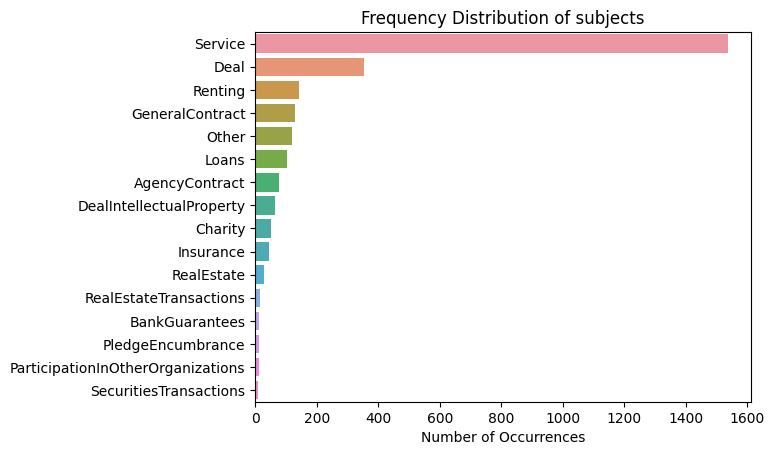


min 8
max 1536
total 2706


In [29]:
%matplotlib inline

subj_count = stats_valid['subject'].value_counts()

#plot distribution---------------------
sns.barplot(subj_count.values, subj_count.index)
plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
plt.show()


print ('\nmin', min (subj_count.values))
print ('max', max (subj_count.values))
print ('total', sum (subj_count.values))

In [30]:
from sklearn.utils import class_weight
from trainsets.trainset_tools import get_feature_log_weights

_classes = stats_valid['subject'].unique().tolist()

print(f'classes: {_classes}')

# class_weights = class_weight.compute_class_weight('balanced', _classes, umtm.stats['subject'])
# class_weights = dict(zip(_classes, class_weights))


class_weights = get_feature_log_weights(stats_valid, 'subject')
class_weights

classes: ['Service', 'AgencyContract', 'Charity', 'Loans', 'BankGuarantees', 'SecuritiesTransactions', 'Renting', 'PledgeEncumbrance', 'DealIntellectualProperty', 'Deal', 'GeneralContract', 'Insurance', 'ParticipationInOtherOrganizations', 'RealEstateTransactions', 'RealEstate', 'Other']


Service                              0.496166
Deal                                 0.619694
Renting                              0.734622
GeneralContract                      0.749136
Other                                0.761784
Loans                                0.785517
AgencyContract                       0.835644
DealIntellectualProperty             0.868964
Charity                              0.925946
Insurance                            0.956391
RealEstate                           1.060184
RealEstateTransactions               1.284993
BankGuarantees                       1.379530
PledgeEncumbrance                    1.419388
ParticipationInOtherOrganizations    1.465109
SecuritiesTransactions               1.656935
Name: subject, dtype: float64

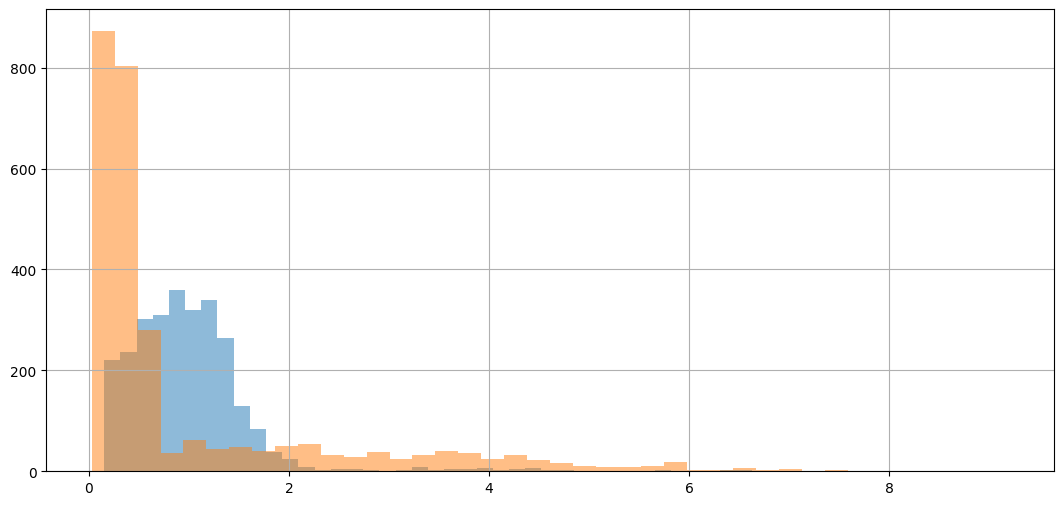

In [31]:
from trainsets.trainset_tools import get_feature_log_weights
 

plt.figure(figsize=(13, 6))

stats_valid['subject_weight'].hist(bins=40, alpha=0.5)
stats_valid['sample_weight'].hist(bins=40, alpha=0.5)

plt.xscale('linear') # log?
plt.show()

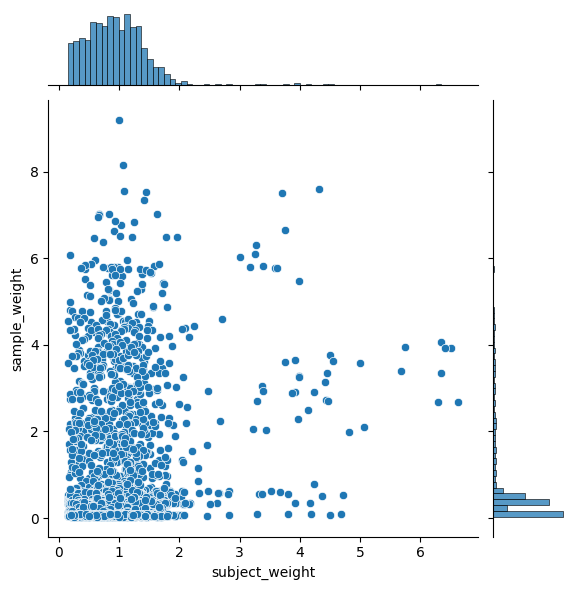

In [32]:
sns.jointplot(x="subject_weight", y="sample_weight", data=stats_valid)
plt.show()

# look into trainset (take a sample)

SAMPLE_DOC_ID 5fe34f62b770574a005553be
semantic map shape is: (759, 30)


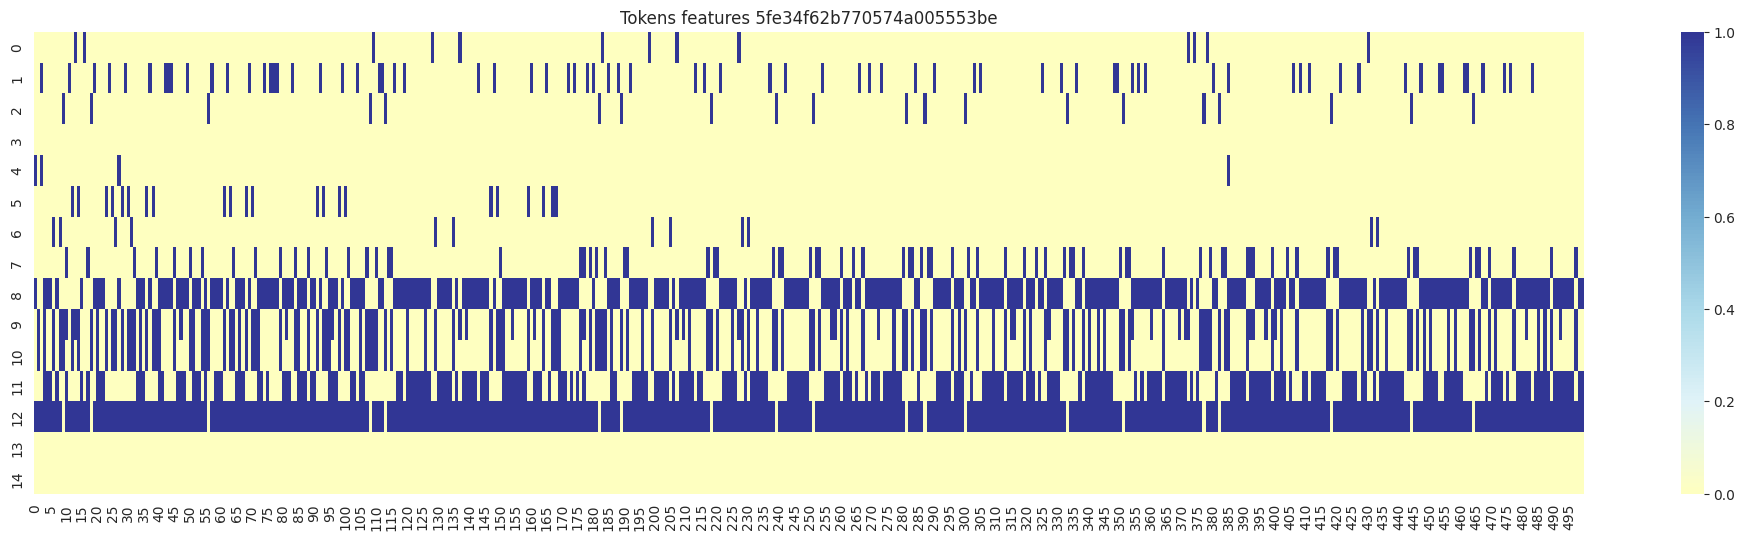

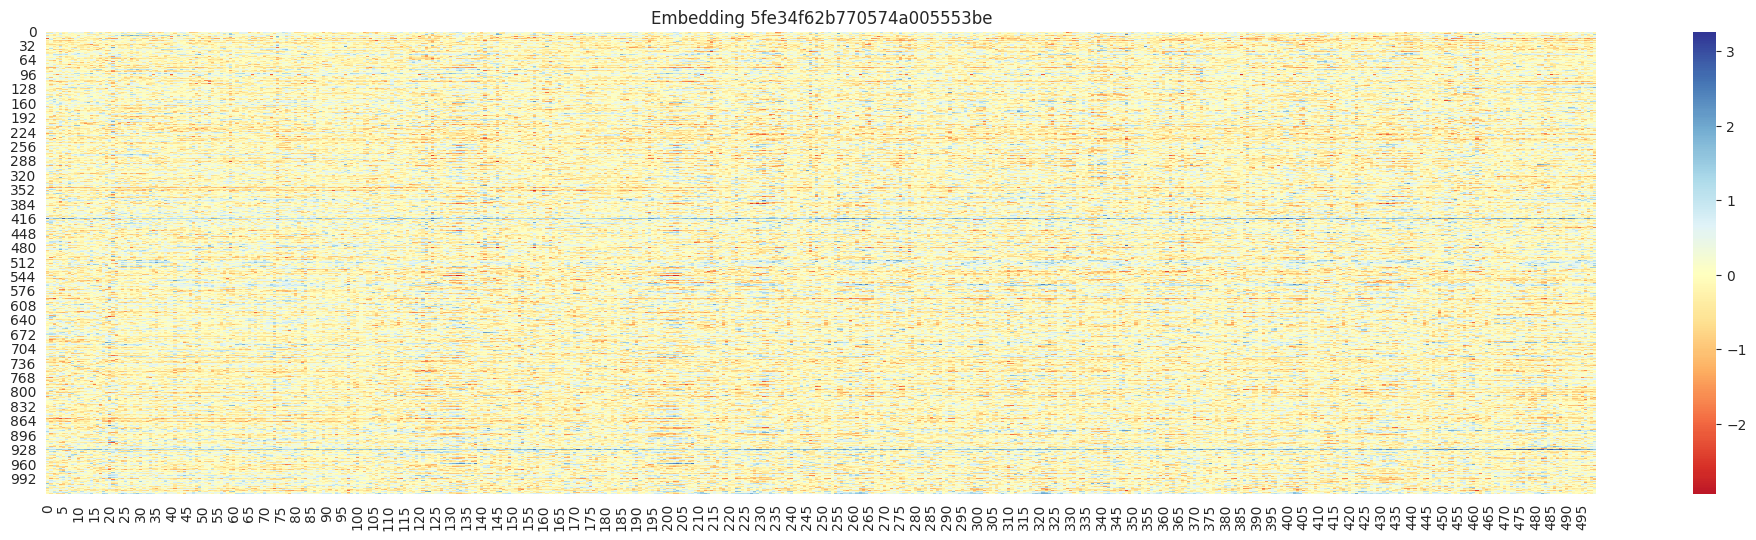

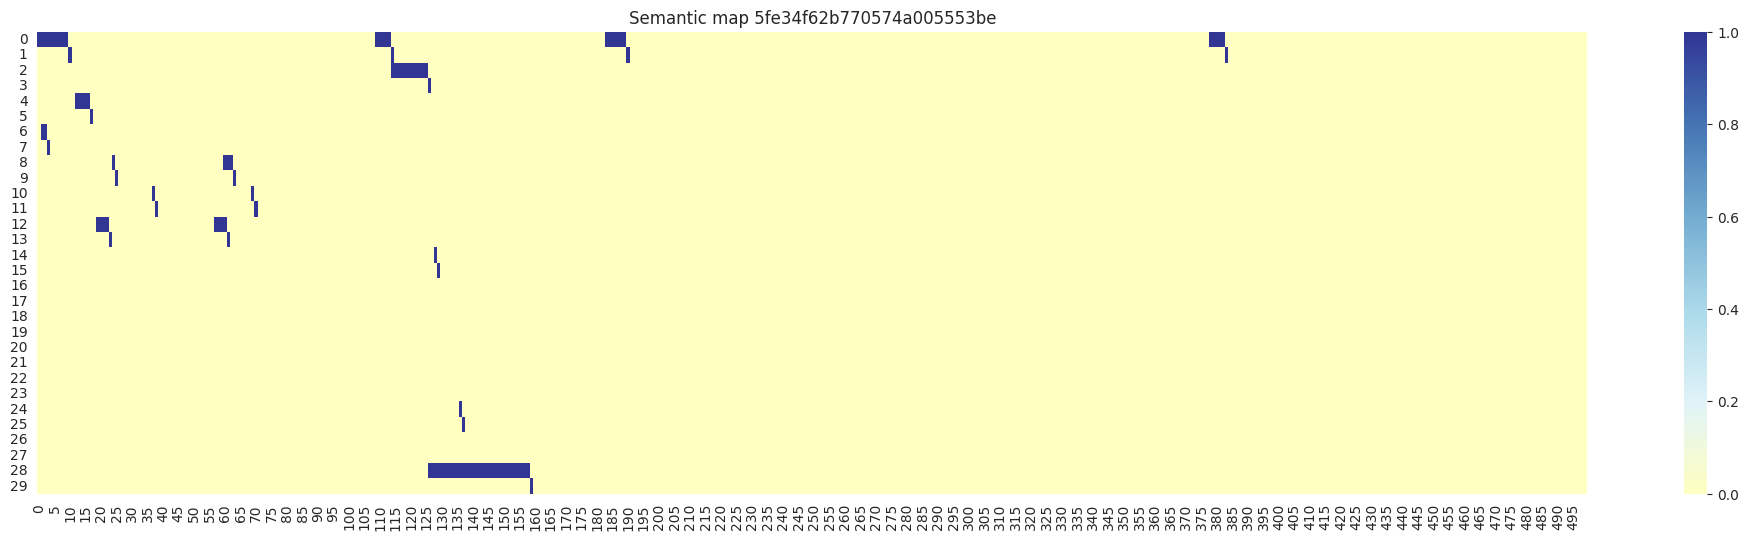

In [33]:
%matplotlib inline
# umtm.calculate_samples_weights()
SAMPLE_DOC_ID = '5fe34f62b770574a005553be' #stats_valid.index[1]

print('SAMPLE_DOC_ID', SAMPLE_DOC_ID)
(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = make_xyw(SAMPLE_DOC_ID, stats)
 
    
print('semantic map shape is:', sm.shape)
_crop = 500
plot_embedding(tok_f[:_crop], title=f'Tokens features {SAMPLE_DOC_ID}') 
plot_embedding(emb[:_crop], title=f'Embedding {SAMPLE_DOC_ID}') 
plot_embedding(sm[:_crop], title=f'Semantic map {SAMPLE_DOC_ID}')



# Batch generator & TODOs 🙏


- [X] TODO: add outliers to the trainset ?
- [ ] TODO: try sparse_categorical_entropy instead of one-hot encodings
- [ ] TODO: model 5.2, 5.1: bipolar concat layer is wrong because we concatenate thongs of different magnitudes. Add a Sigmoid activation layer
- [ ] TODO: chechk what is better: to pad with zeros or to pad with means
- [X] TODO: add weights to samples
- [ ] TODO: sum semantic map alongside vertical axis, and mutiply it (as a mask) by the subject detection seq
- [ ] TODO: introduce individual per tag threshosholds, also, the current 0.3 threshold is strange.

3
semantic map shape is: (14, 793, 30)


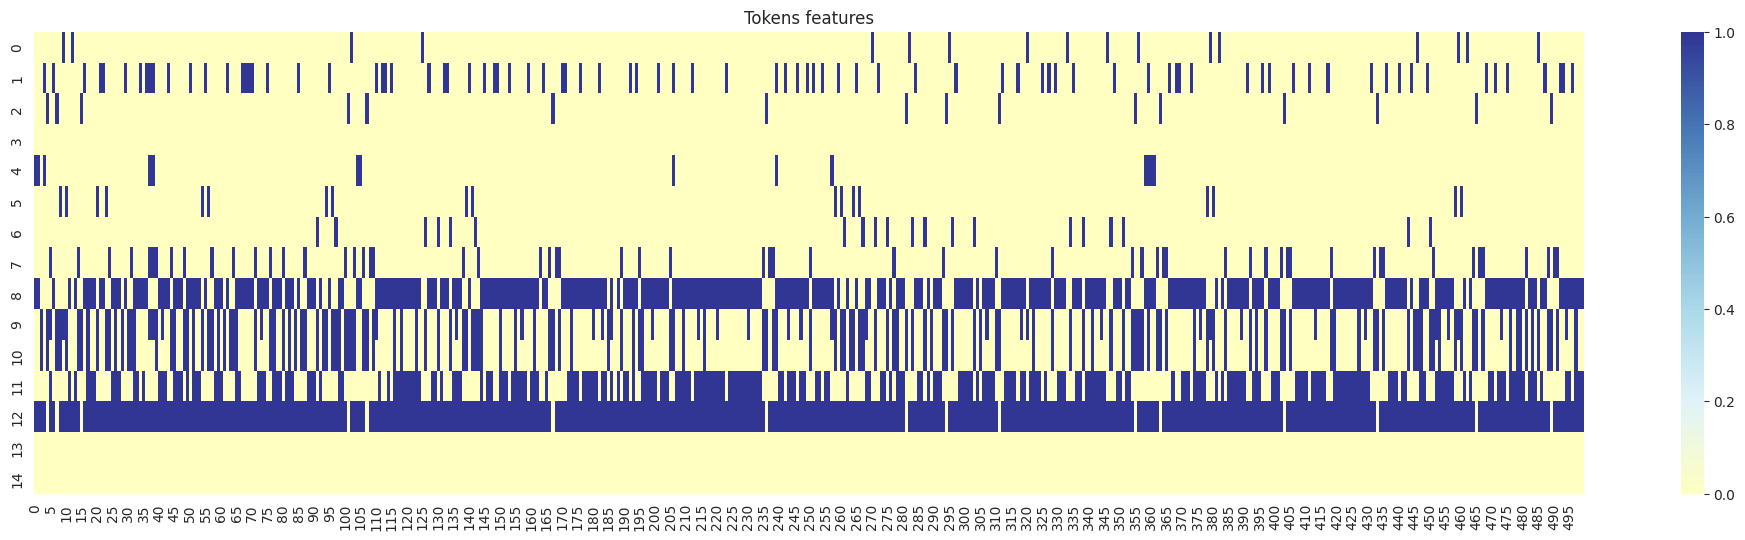

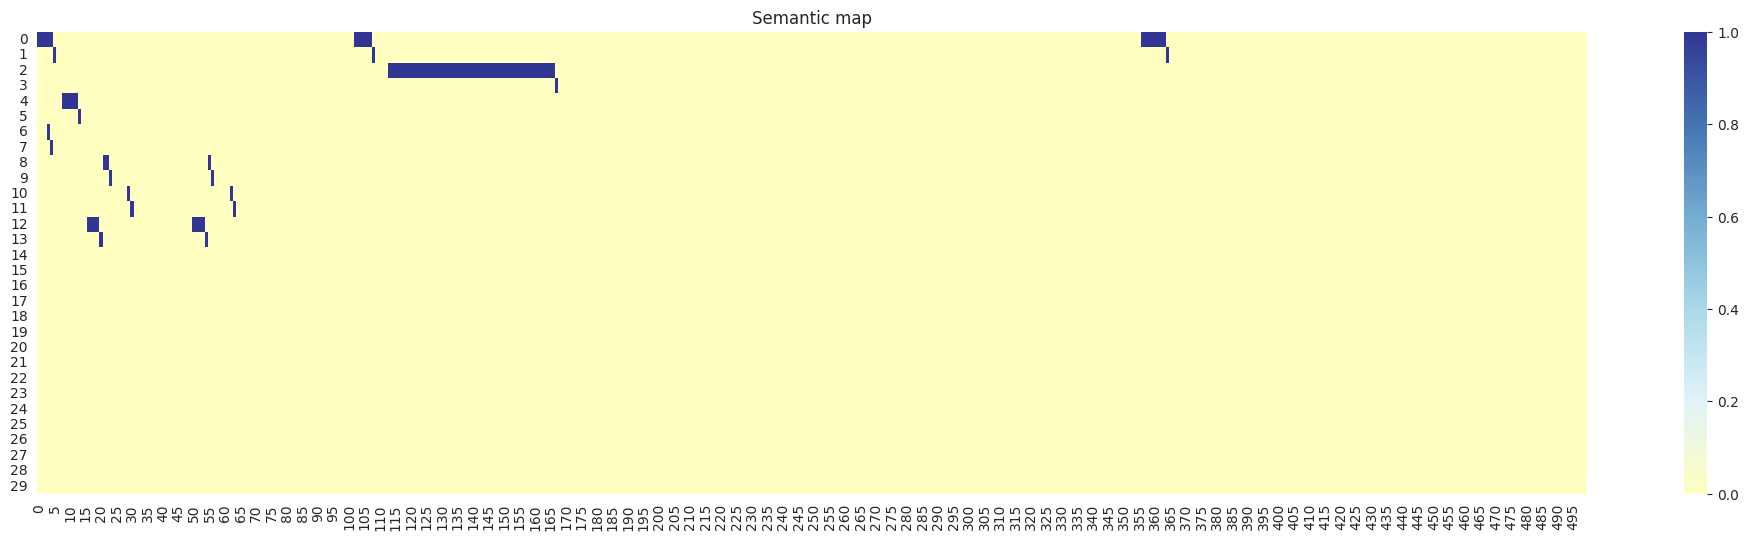

In [34]:
import numpy as np
import random
import pandas as pd

def make_generator(self, indices: [int], batch_size: int, augment_samples=False):
  np.random.seed(43)

  while True:
    # next batch
    batch_indices = np.random.choice(a=indices, size=batch_size)

    max_len = 128 * 12
    start_from = 0

    if augment_samples:
      max_len = random.randint(300, 1400)

    batch_input_emb = []
    batch_input_token_f = []
    batch_output_sm = []
    batch_output_subj = []

    weights = []
    weights_subj = []

    # Read in each input, perform preprocessing and get labels
    for doc_id in batch_indices:

      dp = make_xyw(doc_id, stats)
      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp
        
#       print(dp)
    
      subject_weight_K = 1.0
      if augment_samples:
        start_from = 0

        row = stats_valid.loc[doc_id]
        if random.random() < 0.4:  # 40% of samples
          segment_center = random.randint(0, len(emb) - 1)  ##select random token as a center
          if not pd.isna(row['value_span']) and random.random() < 0.7:
            segment_center = int(row['value_span'])

          _off = random.randint(max_len // 4, max_len // 2)
          start_from = segment_center - _off
          if start_from < 0:
            start_from = 0
          subject_weight_K = 0.1  # lower subject weight because there mighе be no information about subject around doc. value
        
      dp = self.trim_maxlen(dp, start_from, max_len)
      
      # TODO: find samples maxlen

      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp
#       print((sample_weight, subject_weight))
      subject_weight *= subject_weight_K

      batch_input_emb.append(emb)
      batch_input_token_f.append(tok_f)

      batch_output_sm.append(sm)
      batch_output_subj.append(subj)

      if np.isnan(sample_weight):
        raise ValueError()

      if np.isnan(subject_weight):
        raise ValueError()
      
      weights.append(sample_weight)
      weights_subj.append(subject_weight)
      # end if emb
    # end for loop

    # Returns a tuple of (input, output, weights) to feed the network
#     print('batch_output_subj', len(batch_output_subj))
#     print('batch_output_sm', len(batch_output_subj))

    yield ([np.array(batch_input_emb), np.array(batch_input_token_f)],
           [np.array(batch_output_sm), np.array(batch_output_subj)],
           [np.array(weights), np.array(weights_subj)])
    

    
_train, _test = train_test_split(stats_valid, test_size=0.10, stratify=stats_valid[['subject']])

train_indices = list(_train.index)
test_indices = list(_test.index)

    
####---test
_gen = make_generator(umtm, train_indices, 14, augment_samples=True)

sample = next(_gen)
print(len(sample))
del _gen
 


(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = sample
 
    
print('semantic map shape is:', sm.shape)
_crop = 500
plot_embedding(tok_f[0][:_crop], title=f'Tokens features') 
# plot_embedding(emb[:_crop],   title=f'Embedding {SAMPLE_DOC_ID}') 
plot_embedding(sm[0][:_crop],    title=f'Semantic map')

In [35]:
SAMPLE_DOC_ID

'5fe34f62b770574a005553be'

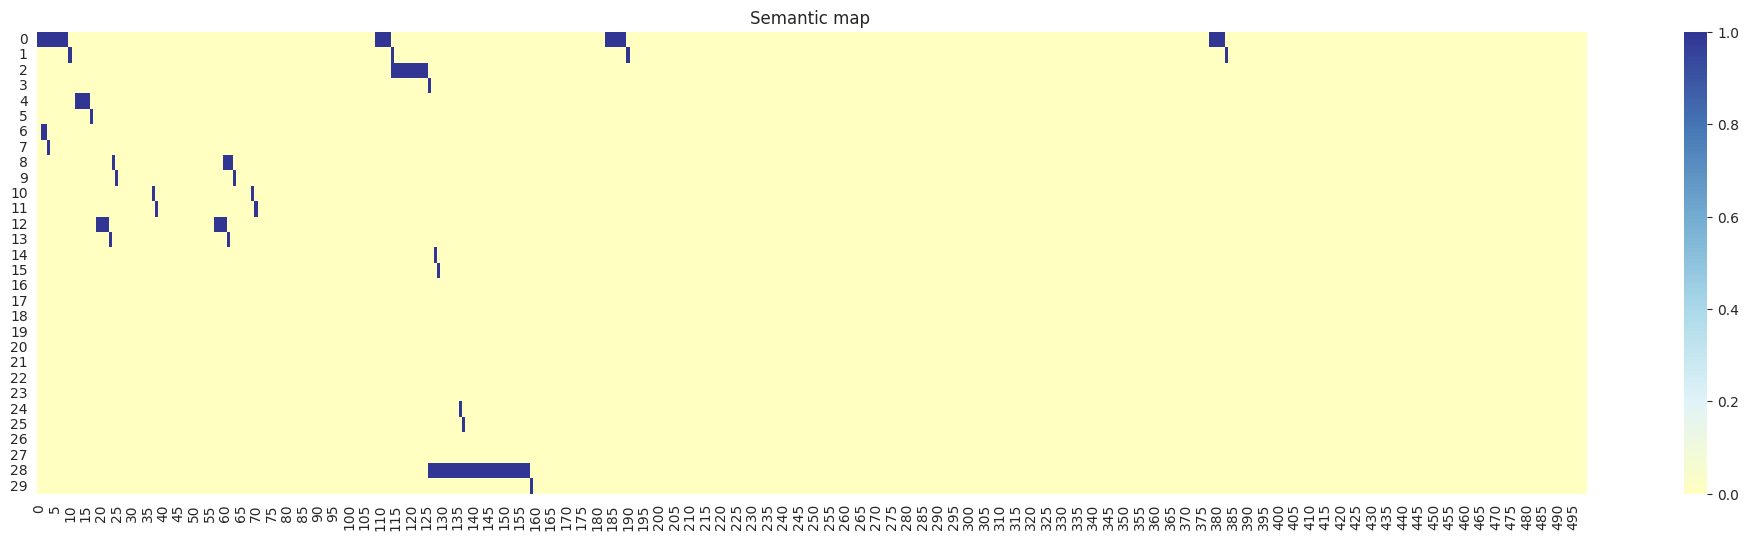

In [36]:
dp = make_xyw('5fe34f62b770574a005553be', stats_valid)

(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp

plot_embedding(sm[:500],    title=f'Semantic map ')

train_indices[0]: 5edbadd5da3678279fbcaaa4
test_indices[0]: 63ce49fde83d1ee490f3f275


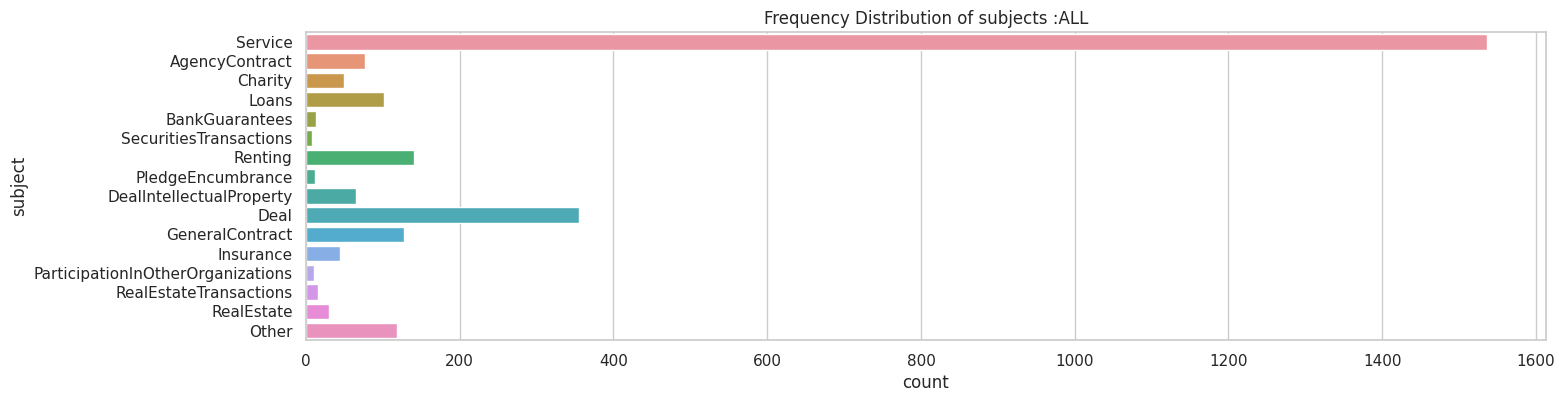

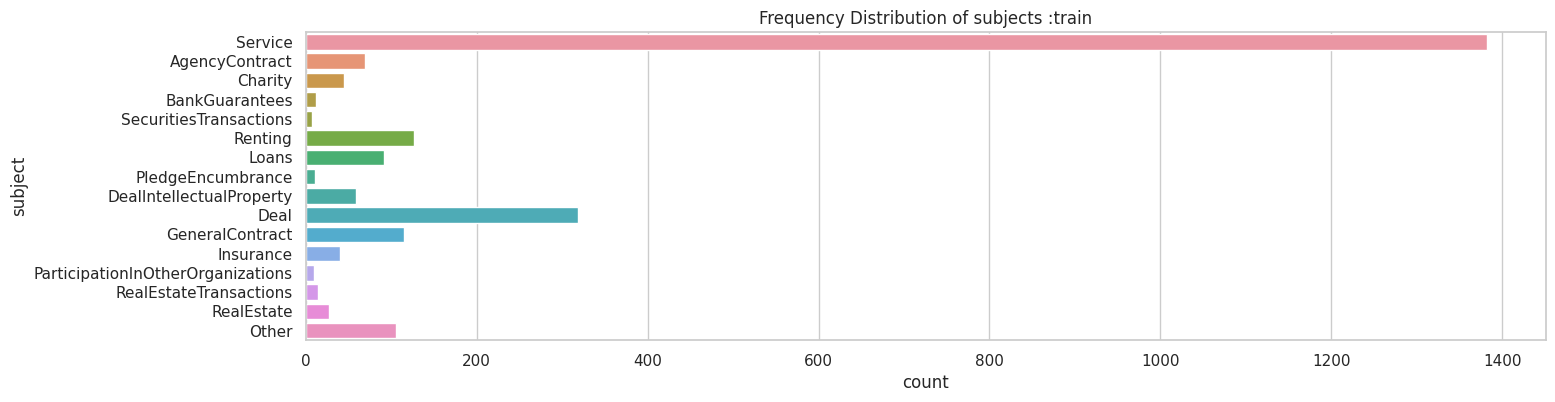

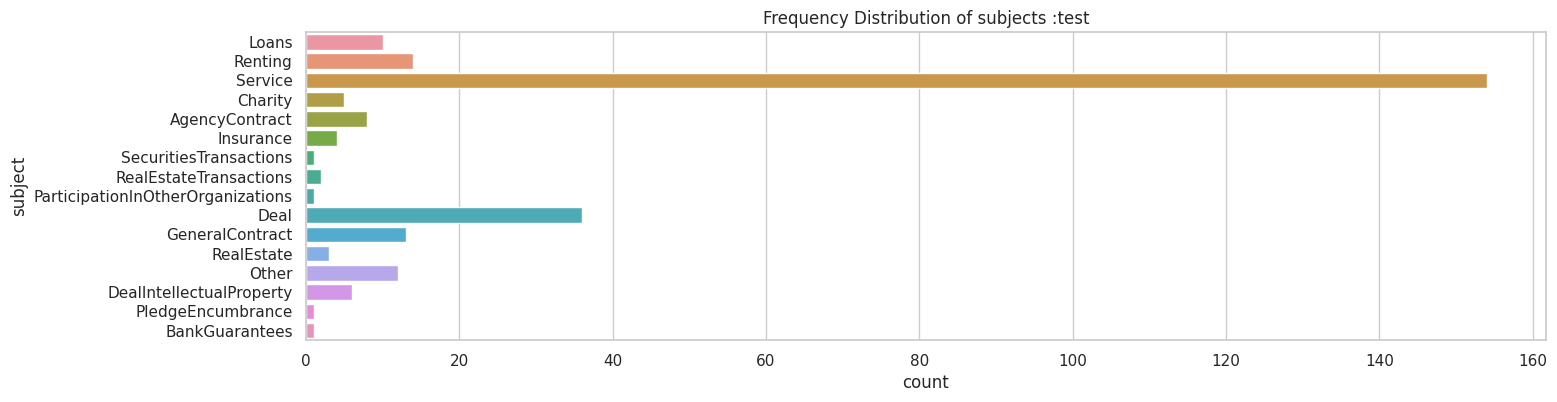

In [37]:
EPOCHS = 50
BATCH_SIZE = 96
EMB =  1024
 
_SELFTEST = True


print('train_indices[0]:', train_indices[0])
print('test_indices[0]:', test_indices[0])


def plot_subject_distr(df, title):  
  target='subject'
  plt.figure(figsize=(16,4))   
  sns.set(style="whitegrid")
  chart = sns.countplot(data=df, y=target)
  plt.title(f'Frequency Distribution of subjects :{title}')

 
plot_subject_distr(stats_valid, 'ALL')
plot_subject_distr(stats_valid[stats_valid.index.isin(train_indices)], 'train')
plot_subject_distr(stats_valid[stats_valid.index.isin(test_indices)], 'test')


if _SELFTEST:
  # test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True)
  
  x, y, w = next(train_gen)
  
#   print('X:', len(x), 'X[0]=', x[0].shape, 'X[1]=', x[1].shape)
#   print('Y:', len(y), 'Y[0]=', y[0].shape, 'Y[1]=', y[1].shape)
  

#   plot_embedding(x[0][0], 'X2: Token Embeddings')
#   plot_embedding(x[1][0], 'X1: Token Features')
#   plot_embedding(y[0][0], 'Y: Semantic Map')
  
#   print(y[0][1])

#   del x
#   del w
#   del y
#   del train_gen

In [38]:

ctx = KerasTrainingContext(checkpoints_path=umtm.reports_dir, session_index=1)

ctx.set_batch_size_and_trainset_size(BATCH_SIZE, 
                                     len(test_indices), 
                                     4 * len(train_indices))

DEFAULT_TRAIN_CTX = ctx
CLASSES = 43
FEATURES = 14

metrics = ['kullback_leibler_divergence', 'mse', 'binary_crossentropy']


def train(umodel):
  test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)

def overtrain(umodel):
  test_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE)
  train_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)


[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/training_reports


batch_size:	96
train_samples:	9740
test_samples:	271
steps_per_epoch:	101
validation_steps:	50


# Models 🦖

In [39]:
def get_weights_filename(model_factory_fn):
    weights = ctx.model_checkpoint_path / f'{model_factory_fn.__name__}.h5'
    print(weights.is_file(), weights)
    if not weights.is_file():
        weights = Path(analyser.hyperparams.models_path) / f'{model_factory_fn.__name__}.h5'
        print(weights.is_file(), weights)
    
    return weights

# get_weights_filename(uber_detection_model_005_1_1)

## Train from 0 uber_detection_model_003

In [40]:
if TRAIN_MODEL_3:
    from tf_support.super_contract_model import uber_detection_model_003
    
    model_factory_fn = uber_detection_model_003
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, load_weights=False )

    umodel.summary()

    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 10
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

## Continue training 003 from checkpoint

In [41]:
analyser.hyperparams.models_path

'/root/artem/analyser/analyser/vocab'

In [42]:
if TRAIN_MODEL_3:
    
    model_factory_fn = uber_detection_model_003

    weights = get_weights_filename(model_factory_fn)
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, weights=weights)

    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 25
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

## Overtrain 003

In [43]:
if TRAIN_MODEL_3:
    if TRAIN:
      ctx.unfreezeModel(umodel)
      umodel.compile(loss=super_contract_model.losses, optimizer='Adam', metrics=super_contract_model.metrics)
      print(super_contract_model.losses)
      umodel.summary()

      ctx.EPOCHS = 12
      ctx.EVALUATE_ONLY = False

      test_gen = make_generator(umtm, train_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 

      ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=False, lr=2e-5)

## 005 model
- 0.0233: last val subject loss
- 0.0016: last tagging loss
- 0.0248: last val loss


In [44]:
if TRAIN_MODEL_3:
    model_factory_fn = uber_detection_model_005_1_1
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, load_weights=False )

    umodel.summary()

    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 20
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

### 5.1.1 💕💕 uber_detection_model_005_1_1

In [45]:
from tf_support.super_contract_model import FEATURES 
from analyser.headers_detector import TOKEN_FEATURES

from tf_support.super_contract_model import sigmoid_focal_crossentropy, losses

import numpy as np
from pandas import DataFrame 



model_factory_fn = uber_detection_model_005_1_1
weights = get_weights_filename(model_factory_fn)
umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, weights=weights)
# umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, load_weights=False )

True /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5


2023-02-06 17:53:13.690463: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-02-06 17:53:13.739207: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 17:53:13.740085: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: A100-PCIE-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-02-06 17:53:13.740102: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-02-06 17:53:13.740140: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-06 17:53:13.740162: I tensorflow/stream_executor/platform/defa

[tools.py:121 -           init_model() ] weights loaded: /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5


In [46]:
######################
# Phase I retraining
# ❄️ frozen bottom layers
######################
if False:
    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 10
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

In [47]:
23

23

#### Phase II finetuning
all unfrozen, entire trainset, low LR
 

In [48]:
######################
## Phase II finetuning
#  all unfrozen, entire trainset, low LR
######################
if TRAIN and False:
  ctx.unfreezeModel(umodel)
  umodel.compile(loss=super_contract_model.losses, optimizer='Adam', metrics=super_contract_model.metrics)
  umodel.summary()
  
  ctx.EPOCHS = 30
  ctx.EVALUATE_ONLY = False
  ctx.EPOCHS *= 2

  test_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 
  
  ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=True, lr=1e-5)

## 🥰 Att model

In [49]:
from dataclasses import dataclass

from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import layers

from analyser.headers_detector import TOKEN_FEATURES
from tf_support.super_contract_model import EMB, CLASSES, DEFAULT_TRAIN_CTX, FEATURES
from tf_support.tools import KerasTrainingContext


@dataclass
class Config:
  # MAX_LEN = 256
  # BATCH_SIZE = 32
  LR = 0.001

  EMBED_DIM = EMB
  NUM_HEAD = 4  # used in bert model
  FF_DIM = 128  # used in bert model
  NUM_LAYERS = 1


config = Config()


def bert_module(query, key, value, i, height):
  # Multi headed self-attention
  attention_output = layers.MultiHeadAttention(
    num_heads=config.NUM_HEAD,
    key_dim=config.EMBED_DIM // config.NUM_HEAD,
    name="encoder_{}/multiheadattention".format(i),
  )(query, key, value)
  attention_output = layers.Dropout(0.1, name="encoder_{}/att_dropout".format(i))(
    attention_output
  )
  attention_output = layers.LayerNormalization(
    epsilon=1e-6, name=f"encoder_{i}/att_layernormalization"
  )(query + attention_output)

  # Feed-forward layer
  ffn = keras.Sequential(
    [
      layers.Dense(config.FF_DIM, activation="relu"),
      layers.Dense(height),
    ],
    name=f"encoder_{i}/ffn",
  )
  ffn_output = ffn(attention_output)
  ffn_output = layers.Dropout(0.1, name=f"encoder_{i}/ffn_dropout")(
    ffn_output
  )
  sequence_output = layers.LayerNormalization(
    epsilon=1e-6, name=f"encoder_{i}/ffn_layernormalization"
  )(attention_output + ffn_output)
  return sequence_output


metrics = ['mse', 'binary_crossentropy']

losses = {
  "O1_tagging": "binary_crossentropy",
  "O2_subject": "binary_crossentropy",
}

class ThresholdLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ThresholdLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name="threshold", shape=(1,), initializer="uniform",
                                      trainable=True)
        super(ThresholdLayer, self).build(input_shape)

    def call(self, x):
        return keras.backend.sigmoid(100*(x-self.kernel))

    def compute_output_shape(self, input_shape):
        return input_shape

def make_att_model(name='make_att_model', ctx: KerasTrainingContext = DEFAULT_TRAIN_CTX, trained=False):
  input_text_emb = layers.Input(shape=[None, config.EMBED_DIM], dtype='float32', name="input_text_emb")
  _out = layers.BatchNormalization(name="bn1")(input_text_emb)
  _out = layers.Dropout(0.2, name="drops")(_out)  # small_drops_of_poison

  token_features = layers.Input(shape=[None, TOKEN_FEATURES], dtype='float32', name="token_features")
  token_features_n = layers.BatchNormalization(name="bn2")(token_features)

  _out = layers.concatenate([input_text_emb, token_features_n], axis=-1)

  for i in range(config.NUM_LAYERS):
    _out = bert_module(_out, _out, _out, i, height=config.EMBED_DIM + TOKEN_FEATURES)

  _out = layers.BatchNormalization(name="bn1")(_out)
  _out = layers.LSTM(FEATURES, return_sequences=True, activation='tanh', name='O1_tagging_tanh')(_out)
#   _out1 = layers.ReLU(name='O1_tagging')(_out)
  _out1 = ThresholdLayer(name='O1_tagging')(_out)
  

  #   _out = Conv1D(filters=FEATURES * 4, kernel_size=(2), padding='same', activation='relu' , name='embedding_reduced')(_out)
  _out = layers.Bidirectional(layers.LSTM(16, return_sequences=False, name='narcissisism'), name='embedding_reduced')(
    _out)
  _out = layers.BatchNormalization(name="bn_bi_2")(_out)
  _out = layers.Dropout(0.1)(_out)

  _out2 = layers.Dense(CLASSES, activation='softmax', name='O2_subject')(_out)

  base_model_inputs = [input_text_emb, token_features]
  model = Model(inputs=base_model_inputs, outputs=[_out1, _out2], name=name)
  model.compile(loss=losses, optimizer='Adam', metrics=metrics)
  return model


umodel = make_att_model() 

model_factory_fn=make_att_model      
weights = get_weights_filename(model_factory_fn)
# model_name = make_att_model.__name__


umodel.load_weights(weights, by_name=True, skip_mismatch=True)

# ctx.init_model(make_att_model, trained=True, trainable=True, weights=weights)



True /root/artem/analyser/training_reports/make_att_model.h5


In [50]:

if TRAIN:
#   ctx.unfreezeModel(umodel)
  umodel.summary()
  
  ctx.EPOCHS = 50
  ctx.EVALUATE_ONLY = False
#   ctx.EPOCHS *= 2

  test_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 
  
  ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=True, lr=config.LR)

threshold = umodel.get_layer('O1_tagging').get_weights()
print('threshold=',threshold)

Model: "make_att_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
token_features (InputLayer)     [(None, None, 15)]   0                                            
__________________________________________________________________________________________________
input_text_emb (InputLayer)     [(None, None, 1024)] 0                                            
__________________________________________________________________________________________________
bn2 (BatchNormalization)        (None, None, 15)     60          token_features[0][0]             
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, None, 1039)   0           input_text_emb[0][0]             
                                                                 bn2[0][0]           

/root/artem/env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


2023-02-06 17:53:17.604449: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-06 17:53:17.625950: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3699850000 Hz


Epoch 1/50


2023-02-06 17:53:20.348379: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


2023-02-06 17:53:21.535445: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-02-06 17:53:21.535494: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-06 17:53:21.597674: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8


2023-02-06 17:53:21.812785: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8500


  1/101 [..............................] - ETA: 8:08 - loss: 0.1509 - O1_tagging_loss: 0.1450 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0115 - O1_tagging_binary_crossentropy: 0.1559 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0122

  2/101 [..............................] - ETA: 12s - loss: 0.1226 - O1_tagging_loss: 0.1167 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0099 - O1_tagging_binary_crossentropy: 0.1320 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0141 

  3/101 [..............................] - ETA: 49s - loss: 0.1084 - O1_tagging_loss: 0.1015 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0080 - O1_tagging_binary_crossentropy: 0.1056 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0142

  4/101 [>.............................] - ETA: 1:09 - loss: 0.0975 - O1_tagging_loss: 0.0904 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0065 - O1_tagging_binary_crossentropy: 0.0857 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0139

  5/101 [>.............................] - ETA: 1:10 - loss: 0.0919 - O1_tagging_loss: 0.0847 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0061 - O1_tagging_binary_crossentropy: 0.0781 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0140

  6/101 [>.............................] - ETA: 1:05 - loss: 0.0891 - O1_tagging_loss: 0.0812 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0061 - O1_tagging_binary_crossentropy: 0.0758 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0150

  7/101 [=>............................] - ETA: 1:17 - loss: 0.0842 - O1_tagging_loss: 0.0764 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0057 - O1_tagging_binary_crossentropy: 0.0699 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0146

  8/101 [=>............................] - ETA: 1:11 - loss: 0.0835 - O1_tagging_loss: 0.0744 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0058 - O1_tagging_binary_crossentropy: 0.0688 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0154

  9/101 [=>............................] - ETA: 1:18 - loss: 0.0812 - O1_tagging_loss: 0.0723 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0055 - O1_tagging_binary_crossentropy: 0.0651 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0157

 10/101 [=>............................] - ETA: 1:18 - loss: 0.0782 - O1_tagging_loss: 0.0688 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0052 - O1_tagging_binary_crossentropy: 0.0618 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0156

 11/101 [==>...........................] - ETA: 1:16 - loss: 0.0756 - O1_tagging_loss: 0.0661 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0053 - O1_tagging_binary_crossentropy: 0.0609 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0159

 12/101 [==>...........................] - ETA: 1:19 - loss: 0.0749 - O1_tagging_loss: 0.0644 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0052 - O1_tagging_binary_crossentropy: 0.0591 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0161

 13/101 [==>...........................] - ETA: 1:18 - loss: 0.0722 - O1_tagging_loss: 0.0616 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0052 - O1_tagging_binary_crossentropy: 0.0578 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0161

 14/101 [===>..........................] - ETA: 1:22 - loss: 0.0706 - O1_tagging_loss: 0.0598 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0051 - O1_tagging_binary_crossentropy: 0.0562 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0158

 15/101 [===>..........................] - ETA: 1:22 - loss: 0.0691 - O1_tagging_loss: 0.0586 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0051 - O1_tagging_binary_crossentropy: 0.0553 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0156

 16/101 [===>..........................] - ETA: 1:19 - loss: 0.0687 - O1_tagging_loss: 0.0578 - O2_subject_loss: 0.0109 - O1_tagging_mse: 0.0052 - O1_tagging_binary_crossentropy: 0.0547 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0159

 17/101 [====>.........................] - ETA: 1:24 - loss: 0.0672 - O1_tagging_loss: 0.0565 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0051 - O1_tagging_binary_crossentropy: 0.0532 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0159

 18/101 [====>.........................] - ETA: 1:20 - loss: 0.0669 - O1_tagging_loss: 0.0560 - O2_subject_loss: 0.0109 - O1_tagging_mse: 0.0051 - O1_tagging_binary_crossentropy: 0.0531 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0163

 19/101 [====>.........................] - ETA: 1:23 - loss: 0.0654 - O1_tagging_loss: 0.0546 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0051 - O1_tagging_binary_crossentropy: 0.0519 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0163

 20/101 [====>.........................] - ETA: 1:23 - loss: 0.0643 - O1_tagging_loss: 0.0535 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0051 - O1_tagging_binary_crossentropy: 0.0513 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0164

 21/101 [=====>........................] - ETA: 1:23 - loss: 0.0635 - O1_tagging_loss: 0.0528 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0051 - O1_tagging_binary_crossentropy: 0.0510 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0167

 22/101 [=====>........................] - ETA: 1:25 - loss: 0.0626 - O1_tagging_loss: 0.0521 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0050 - O1_tagging_binary_crossentropy: 0.0498 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0166

 23/101 [=====>........................] - ETA: 1:25 - loss: 0.0619 - O1_tagging_loss: 0.0514 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0050 - O1_tagging_binary_crossentropy: 0.0491 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0167

 24/101 [======>.......................] - ETA: 1:24 - loss: 0.0607 - O1_tagging_loss: 0.0504 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0049 - O1_tagging_binary_crossentropy: 0.0483 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0166

 25/101 [======>.......................] - ETA: 1:26 - loss: 0.0596 - O1_tagging_loss: 0.0493 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0048 - O1_tagging_binary_crossentropy: 0.0468 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0166

 26/101 [======>.......................] - ETA: 1:24 - loss: 0.0588 - O1_tagging_loss: 0.0484 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0048 - O1_tagging_binary_crossentropy: 0.0463 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168

 27/101 [=======>......................] - ETA: 1:22 - loss: 0.0585 - O1_tagging_loss: 0.0481 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0048 - O1_tagging_binary_crossentropy: 0.0463 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0170

 28/101 [=======>......................] - ETA: 1:22 - loss: 0.0581 - O1_tagging_loss: 0.0475 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0047 - O1_tagging_binary_crossentropy: 0.0457 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0171

 29/101 [=======>......................] - ETA: 1:21 - loss: 0.0573 - O1_tagging_loss: 0.0467 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0047 - O1_tagging_binary_crossentropy: 0.0448 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0171

 30/101 [=======>......................] - ETA: 1:19 - loss: 0.0567 - O1_tagging_loss: 0.0461 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0047 - O1_tagging_binary_crossentropy: 0.0443 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0170

 31/101 [========>.....................] - ETA: 1:18 - loss: 0.0560 - O1_tagging_loss: 0.0456 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0047 - O1_tagging_binary_crossentropy: 0.0439 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0171

 32/101 [========>.....................] - ETA: 1:18 - loss: 0.0552 - O1_tagging_loss: 0.0448 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0046 - O1_tagging_binary_crossentropy: 0.0428 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0170

 33/101 [========>.....................] - ETA: 1:16 - loss: 0.0547 - O1_tagging_loss: 0.0441 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0423 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0172

 34/101 [=========>....................] - ETA: 1:15 - loss: 0.0541 - O1_tagging_loss: 0.0436 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0419 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0171

 35/101 [=========>....................] - ETA: 1:14 - loss: 0.0535 - O1_tagging_loss: 0.0430 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0414 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0172

 36/101 [=========>....................] - ETA: 1:14 - loss: 0.0528 - O1_tagging_loss: 0.0423 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0406 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0171

 37/101 [=========>....................] - ETA: 1:12 - loss: 0.0524 - O1_tagging_loss: 0.0420 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0405 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 38/101 [==========>...................] - ETA: 1:10 - loss: 0.0518 - O1_tagging_loss: 0.0414 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0403 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 39/101 [==========>...................] - ETA: 1:09 - loss: 0.0510 - O1_tagging_loss: 0.0408 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0399 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0171

 40/101 [==========>...................] - ETA: 1:08 - loss: 0.0508 - O1_tagging_loss: 0.0406 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0397 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0171

 41/101 [===========>..................] - ETA: 1:07 - loss: 0.0505 - O1_tagging_loss: 0.0403 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0396 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0171

 42/101 [===========>..................] - ETA: 1:06 - loss: 0.0500 - O1_tagging_loss: 0.0399 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0394 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0171

 43/101 [===========>..................] - ETA: 1:05 - loss: 0.0496 - O1_tagging_loss: 0.0395 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0391 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 44/101 [============>.................] - ETA: 1:04 - loss: 0.0492 - O1_tagging_loss: 0.0392 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0388 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 45/101 [============>.................] - ETA: 1:02 - loss: 0.0490 - O1_tagging_loss: 0.0390 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0386 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0169

 46/101 [============>.................] - ETA: 1:02 - loss: 0.0487 - O1_tagging_loss: 0.0387 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0380 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0169

 47/101 [============>.................] - ETA: 1:01 - loss: 0.0482 - O1_tagging_loss: 0.0383 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0376 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0171

 48/101 [=============>................] - ETA: 1:00 - loss: 0.0481 - O1_tagging_loss: 0.0381 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0375 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0171

 49/101 [=============>................] - ETA: 59s - loss: 0.0478 - O1_tagging_loss: 0.0379 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0371 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0172 

 50/101 [=============>................] - ETA: 58s - loss: 0.0473 - O1_tagging_loss: 0.0375 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0369 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0171

 51/101 [==============>...............] - ETA: 56s - loss: 0.0470 - O1_tagging_loss: 0.0372 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0368 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0171

 52/101 [==============>...............] - ETA: 56s - loss: 0.0466 - O1_tagging_loss: 0.0368 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0364 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0171

 53/101 [==============>...............] - ETA: 55s - loss: 0.0464 - O1_tagging_loss: 0.0365 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0363 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0171

 54/101 [===============>..............] - ETA: 53s - loss: 0.0462 - O1_tagging_loss: 0.0363 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0362 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0172

 55/101 [===============>..............] - ETA: 52s - loss: 0.0460 - O1_tagging_loss: 0.0362 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0359 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0172

 56/101 [===============>..............] - ETA: 52s - loss: 0.0457 - O1_tagging_loss: 0.0360 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0356 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0172

 57/101 [===============>..............] - ETA: 51s - loss: 0.0453 - O1_tagging_loss: 0.0356 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0350 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0172

 58/101 [================>.............] - ETA: 49s - loss: 0.0453 - O1_tagging_loss: 0.0356 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0350 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0173

 59/101 [================>.............] - ETA: 48s - loss: 0.0451 - O1_tagging_loss: 0.0353 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0349 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0173

 60/101 [================>.............] - ETA: 47s - loss: 0.0448 - O1_tagging_loss: 0.0351 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0347 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0173

 61/101 [=================>............] - ETA: 46s - loss: 0.0447 - O1_tagging_loss: 0.0349 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0343 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0173

 62/101 [=================>............] - ETA: 45s - loss: 0.0443 - O1_tagging_loss: 0.0346 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0339 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0173

 63/101 [=================>............] - ETA: 43s - loss: 0.0441 - O1_tagging_loss: 0.0344 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0339 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0173

 64/101 [==================>...........] - ETA: 42s - loss: 0.0438 - O1_tagging_loss: 0.0341 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0337 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0173

 65/101 [==================>...........] - ETA: 41s - loss: 0.0436 - O1_tagging_loss: 0.0339 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0334 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0173

 66/101 [==================>...........] - ETA: 40s - loss: 0.0435 - O1_tagging_loss: 0.0338 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0334 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0173

 67/101 [==================>...........] - ETA: 39s - loss: 0.0433 - O1_tagging_loss: 0.0336 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0331 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0173

 68/101 [===================>..........] - ETA: 38s - loss: 0.0431 - O1_tagging_loss: 0.0334 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0328 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0173

 69/101 [===================>..........] - ETA: 37s - loss: 0.0429 - O1_tagging_loss: 0.0331 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0325 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0173

 70/101 [===================>..........] - ETA: 36s - loss: 0.0427 - O1_tagging_loss: 0.0329 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0322 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0173

 71/101 [====================>.........] - ETA: 35s - loss: 0.0424 - O1_tagging_loss: 0.0327 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0320 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0172

 72/101 [====================>.........] - ETA: 34s - loss: 0.0422 - O1_tagging_loss: 0.0325 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0316 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0172

 73/101 [====================>.........] - ETA: 32s - loss: 0.0422 - O1_tagging_loss: 0.0325 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0316 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0171

 74/101 [====================>.........] - ETA: 31s - loss: 0.0420 - O1_tagging_loss: 0.0323 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0313 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0172

 75/101 [=====================>........] - ETA: 30s - loss: 0.0418 - O1_tagging_loss: 0.0321 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0312 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0171

 76/101 [=====================>........] - ETA: 29s - loss: 0.0415 - O1_tagging_loss: 0.0319 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0310 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0171

 77/101 [=====================>........] - ETA: 28s - loss: 0.0413 - O1_tagging_loss: 0.0316 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0307 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0171

 78/101 [======================>.......] - ETA: 26s - loss: 0.0411 - O1_tagging_loss: 0.0315 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0307 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0171

 79/101 [======================>.......] - ETA: 25s - loss: 0.0409 - O1_tagging_loss: 0.0313 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0306 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 80/101 [======================>.......] - ETA: 24s - loss: 0.0407 - O1_tagging_loss: 0.0311 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0305 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 81/101 [=======================>......] - ETA: 23s - loss: 0.0405 - O1_tagging_loss: 0.0310 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0304 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 82/101 [=======================>......] - ETA: 22s - loss: 0.0404 - O1_tagging_loss: 0.0307 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0302 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0171

 83/101 [=======================>......] - ETA: 20s - loss: 0.0402 - O1_tagging_loss: 0.0306 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0302 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 84/101 [=======================>......] - ETA: 19s - loss: 0.0400 - O1_tagging_loss: 0.0304 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0300 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 85/101 [========================>.....] - ETA: 18s - loss: 0.0398 - O1_tagging_loss: 0.0302 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0299 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0169

 86/101 [========================>.....] - ETA: 17s - loss: 0.0397 - O1_tagging_loss: 0.0302 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0298 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0169

 87/101 [========================>.....] - ETA: 16s - loss: 0.0396 - O1_tagging_loss: 0.0301 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0296 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0169

 88/101 [=========================>....] - ETA: 15s - loss: 0.0393 - O1_tagging_loss: 0.0298 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0294 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0169

 89/101 [=========================>....] - ETA: 14s - loss: 0.0392 - O1_tagging_loss: 0.0297 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0292 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0168

 90/101 [=========================>....] - ETA: 12s - loss: 0.0391 - O1_tagging_loss: 0.0296 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0292 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0169

 91/101 [==========================>...] - ETA: 11s - loss: 0.0390 - O1_tagging_loss: 0.0294 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0289 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0169

 92/101 [==========================>...] - ETA: 10s - loss: 0.0389 - O1_tagging_loss: 0.0293 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0289 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0169

 93/101 [==========================>...] - ETA: 9s - loss: 0.0386 - O1_tagging_loss: 0.0291 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0286 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0168 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0385 - O1_tagging_loss: 0.0290 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0285 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0168

 95/101 [===========================>..] - ETA: 7s - loss: 0.0383 - O1_tagging_loss: 0.0288 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0283 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0168

 96/101 [===========================>..] - ETA: 5s - loss: 0.0382 - O1_tagging_loss: 0.0288 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0282 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0168

 97/101 [===========================>..] - ETA: 4s - loss: 0.0380 - O1_tagging_loss: 0.0286 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0280 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0168

 98/101 [============================>.] - ETA: 3s - loss: 0.0378 - O1_tagging_loss: 0.0284 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0278 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0168

 99/101 [============================>.] - ETA: 2s - loss: 0.0377 - O1_tagging_loss: 0.0282 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0277 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0167

100/101 [============================>.] - ETA: 1s - loss: 0.0375 - O1_tagging_loss: 0.0281 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0275 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0167

101/101 [==============================] - ETA: 0s - loss: 0.0374 - O1_tagging_loss: 0.0280 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0273 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0167

101/101 [==============================] - 217s 2s/step - loss: 0.0374 - O1_tagging_loss: 0.0280 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0273 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0167 - val_loss: 0.0336 - val_O1_tagging_loss: 0.0156 - val_O2_subject_loss: 0.0180 - val_O1_tagging_mse: 0.0018 - val_O1_tagging_binary_crossentropy: 0.0179 - val_O2_subject_mse: 0.0038 - val_O2_subject_binary_crossentropy: 0.0153



Epoch 00001: val_loss improved from inf to 0.03359, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 2/50


  1/101 [..............................] - ETA: 26s - loss: 0.0231 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0179

  2/101 [..............................] - ETA: 2:51 - loss: 0.0229 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0167

  3/101 [..............................] - ETA: 2:14 - loss: 0.0272 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0170

  4/101 [>.............................] - ETA: 2:24 - loss: 0.0269 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0168

  5/101 [>.............................] - ETA: 2:17 - loss: 0.0279 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0174

  6/101 [>.............................] - ETA: 2:10 - loss: 0.0277 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0172

  7/101 [=>............................] - ETA: 2:10 - loss: 0.0260 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0172

  8/101 [=>............................] - ETA: 2:06 - loss: 0.0256 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0172

  9/101 [=>............................] - ETA: 2:02 - loss: 0.0252 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0164

 10/101 [=>............................] - ETA: 1:59 - loss: 0.0252 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0161

 11/101 [==>...........................] - ETA: 1:55 - loss: 0.0265 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0085 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0159

 12/101 [==>...........................] - ETA: 1:53 - loss: 0.0265 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0163

 13/101 [==>...........................] - ETA: 1:51 - loss: 0.0260 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0161

 14/101 [===>..........................] - ETA: 1:50 - loss: 0.0255 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0085 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0157

 15/101 [===>..........................] - ETA: 1:52 - loss: 0.0254 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0084 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0154

 16/101 [===>..........................] - ETA: 1:48 - loss: 0.0256 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0154

 17/101 [====>.........................] - ETA: 1:47 - loss: 0.0254 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0152

 18/101 [====>.........................] - ETA: 1:49 - loss: 0.0256 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0154

 19/101 [====>.........................] - ETA: 1:46 - loss: 0.0254 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0082 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0154

 20/101 [====>.........................] - ETA: 1:45 - loss: 0.0254 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0154

 21/101 [=====>........................] - ETA: 1:45 - loss: 0.0252 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0154

 22/101 [=====>........................] - ETA: 1:43 - loss: 0.0249 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0155

 23/101 [=====>........................] - ETA: 1:41 - loss: 0.0248 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0156

 24/101 [======>.......................] - ETA: 1:38 - loss: 0.0250 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0160

 25/101 [======>.......................] - ETA: 1:40 - loss: 0.0250 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0160

 26/101 [======>.......................] - ETA: 1:38 - loss: 0.0248 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0160

 27/101 [=======>......................] - ETA: 1:39 - loss: 0.0245 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0158

 28/101 [=======>......................] - ETA: 1:36 - loss: 0.0244 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0158

 29/101 [=======>......................] - ETA: 1:35 - loss: 0.0241 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0156

 30/101 [=======>......................] - ETA: 1:35 - loss: 0.0238 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0154

 31/101 [========>.....................] - ETA: 1:33 - loss: 0.0238 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0154

 32/101 [========>.....................] - ETA: 1:32 - loss: 0.0236 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0155

 33/101 [========>.....................] - ETA: 1:31 - loss: 0.0235 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0156

 34/101 [=========>....................] - ETA: 1:29 - loss: 0.0235 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0154

 35/101 [=========>....................] - ETA: 1:27 - loss: 0.0234 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0153

 36/101 [=========>....................] - ETA: 1:28 - loss: 0.0231 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0152

 37/101 [=========>....................] - ETA: 1:26 - loss: 0.0233 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0152

 38/101 [==========>...................] - ETA: 1:25 - loss: 0.0231 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0152

 39/101 [==========>...................] - ETA: 1:24 - loss: 0.0232 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0151

 40/101 [==========>...................] - ETA: 1:23 - loss: 0.0231 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0150

 41/101 [===========>..................] - ETA: 1:22 - loss: 0.0233 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0151

 42/101 [===========>..................] - ETA: 1:21 - loss: 0.0232 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0150

 43/101 [===========>..................] - ETA: 1:20 - loss: 0.0229 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0150

 44/101 [============>.................] - ETA: 1:18 - loss: 0.0230 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0150

 45/101 [============>.................] - ETA: 1:16 - loss: 0.0229 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0150

 46/101 [============>.................] - ETA: 1:14 - loss: 0.0230 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0151

 47/101 [============>.................] - ETA: 1:13 - loss: 0.0229 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0151

 48/101 [=============>................] - ETA: 1:12 - loss: 0.0228 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0151

 49/101 [=============>................] - ETA: 1:12 - loss: 0.0227 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0150

 50/101 [=============>................] - ETA: 1:11 - loss: 0.0226 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0150

 51/101 [==============>...............] - ETA: 1:09 - loss: 0.0227 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0150

 52/101 [==============>...............] - ETA: 1:08 - loss: 0.0227 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0151

 53/101 [==============>...............] - ETA: 1:07 - loss: 0.0228 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0151

 54/101 [===============>..............] - ETA: 1:06 - loss: 0.0228 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0151

 55/101 [===============>..............] - ETA: 1:04 - loss: 0.0227 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0150

 56/101 [===============>..............] - ETA: 1:03 - loss: 0.0227 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0150

 57/101 [===============>..............] - ETA: 1:01 - loss: 0.0226 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0149

 58/101 [================>.............] - ETA: 1:00 - loss: 0.0226 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0149

 59/101 [================>.............] - ETA: 58s - loss: 0.0227 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0149 

 60/101 [================>.............] - ETA: 57s - loss: 0.0228 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0149

 61/101 [=================>............] - ETA: 56s - loss: 0.0229 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0150

 62/101 [=================>............] - ETA: 55s - loss: 0.0228 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0150

 63/101 [=================>............] - ETA: 53s - loss: 0.0228 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0150

 64/101 [==================>...........] - ETA: 52s - loss: 0.0228 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0150

 65/101 [==================>...........] - ETA: 50s - loss: 0.0227 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0150

 66/101 [==================>...........] - ETA: 49s - loss: 0.0228 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0150

 67/101 [==================>...........] - ETA: 48s - loss: 0.0227 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0149

 68/101 [===================>..........] - ETA: 47s - loss: 0.0227 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0149

 69/101 [===================>..........] - ETA: 45s - loss: 0.0228 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0149

 70/101 [===================>..........] - ETA: 44s - loss: 0.0228 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0149

 71/101 [====================>.........] - ETA: 43s - loss: 0.0228 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 72/101 [====================>.........] - ETA: 42s - loss: 0.0227 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0148

 73/101 [====================>.........] - ETA: 40s - loss: 0.0228 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0149

 74/101 [====================>.........] - ETA: 39s - loss: 0.0227 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0149

 75/101 [=====================>........] - ETA: 38s - loss: 0.0226 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0149

 76/101 [=====================>........] - ETA: 36s - loss: 0.0226 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0149

 77/101 [=====================>........] - ETA: 35s - loss: 0.0226 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0149

 78/101 [======================>.......] - ETA: 33s - loss: 0.0226 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0149

 79/101 [======================>.......] - ETA: 32s - loss: 0.0227 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0149

 80/101 [======================>.......] - ETA: 30s - loss: 0.0226 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0148

 81/101 [=======================>......] - ETA: 29s - loss: 0.0227 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0149

 82/101 [=======================>......] - ETA: 27s - loss: 0.0227 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0149

 83/101 [=======================>......] - ETA: 26s - loss: 0.0227 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0150

 84/101 [=======================>......] - ETA: 24s - loss: 0.0227 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0150

 85/101 [========================>.....] - ETA: 23s - loss: 0.0226 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0151

 86/101 [========================>.....] - ETA: 21s - loss: 0.0227 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0150

 87/101 [========================>.....] - ETA: 20s - loss: 0.0226 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0150

 88/101 [=========================>....] - ETA: 18s - loss: 0.0226 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0150

 89/101 [=========================>....] - ETA: 17s - loss: 0.0226 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0150

 90/101 [=========================>....] - ETA: 16s - loss: 0.0225 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0151

 91/101 [==========================>...] - ETA: 14s - loss: 0.0226 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0150

 92/101 [==========================>...] - ETA: 13s - loss: 0.0225 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0150

 93/101 [==========================>...] - ETA: 11s - loss: 0.0225 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0150

 94/101 [==========================>...] - ETA: 10s - loss: 0.0226 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0150

 95/101 [===========================>..] - ETA: 8s - loss: 0.0226 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0150 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0226 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0149

 97/101 [===========================>..] - ETA: 5s - loss: 0.0226 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0149

 98/101 [============================>.] - ETA: 4s - loss: 0.0225 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0149

 99/101 [============================>.] - ETA: 2s - loss: 0.0225 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0149

100/101 [============================>.] - ETA: 1s - loss: 0.0225 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0149

101/101 [==============================] - ETA: 0s - loss: 0.0224 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0149

101/101 [==============================] - 236s 2s/step - loss: 0.0224 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0149 - val_loss: 0.0270 - val_O1_tagging_loss: 0.0143 - val_O2_subject_loss: 0.0127 - val_O1_tagging_mse: 0.0021 - val_O1_tagging_binary_crossentropy: 0.0152 - val_O2_subject_mse: 0.0025 - val_O2_subject_binary_crossentropy: 0.0097



Epoch 00002: val_loss improved from 0.03359 to 0.02701, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 3/50


  1/101 [..............................] - ETA: 18s - loss: 0.0291 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0197

  2/101 [..............................] - ETA: 2:39 - loss: 0.0244 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0199

  3/101 [..............................] - ETA: 2:06 - loss: 0.0244 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0205

  4/101 [>.............................] - ETA: 2:21 - loss: 0.0230 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0184

  5/101 [>.............................] - ETA: 2:21 - loss: 0.0228 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0177

  6/101 [>.............................] - ETA: 2:17 - loss: 0.0225 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

  7/101 [=>............................] - ETA: 2:21 - loss: 0.0220 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0162

  8/101 [=>............................] - ETA: 2:25 - loss: 0.0219 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0161

  9/101 [=>............................] - ETA: 2:20 - loss: 0.0214 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0166

 10/101 [=>............................] - ETA: 2:16 - loss: 0.0213 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0161

 11/101 [==>...........................] - ETA: 2:22 - loss: 0.0212 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0159

 12/101 [==>...........................] - ETA: 2:18 - loss: 0.0214 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0158

 13/101 [==>...........................] - ETA: 2:13 - loss: 0.0215 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0159

 14/101 [===>..........................] - ETA: 2:09 - loss: 0.0219 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0158

 15/101 [===>..........................] - ETA: 2:09 - loss: 0.0219 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0159

 16/101 [===>..........................] - ETA: 2:05 - loss: 0.0219 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0157

 17/101 [====>.........................] - ETA: 2:09 - loss: 0.0219 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0158

 18/101 [====>.........................] - ETA: 2:09 - loss: 0.0221 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0160

 19/101 [====>.........................] - ETA: 2:04 - loss: 0.0222 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0165

 20/101 [====>.........................] - ETA: 2:01 - loss: 0.0225 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0082 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0168

 21/101 [=====>........................] - ETA: 2:00 - loss: 0.0222 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0165

 22/101 [=====>........................] - ETA: 2:00 - loss: 0.0222 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0165

 23/101 [=====>........................] - ETA: 2:01 - loss: 0.0221 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0162

 24/101 [======>.......................] - ETA: 2:01 - loss: 0.0221 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0162

 25/101 [======>.......................] - ETA: 1:57 - loss: 0.0225 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0164

 26/101 [======>.......................] - ETA: 1:55 - loss: 0.0225 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0082 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0164

 27/101 [=======>......................] - ETA: 1:55 - loss: 0.0225 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0162

 28/101 [=======>......................] - ETA: 1:53 - loss: 0.0223 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0082 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0163

 29/101 [=======>......................] - ETA: 1:52 - loss: 0.0223 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0084 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0163

 30/101 [=======>......................] - ETA: 1:49 - loss: 0.0228 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0085 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0164

 31/101 [========>.....................] - ETA: 1:47 - loss: 0.0226 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0085 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0164

 32/101 [========>.....................] - ETA: 1:46 - loss: 0.0227 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0165

 33/101 [========>.....................] - ETA: 1:45 - loss: 0.0228 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0166

 34/101 [=========>....................] - ETA: 1:43 - loss: 0.0227 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0167

 35/101 [=========>....................] - ETA: 1:42 - loss: 0.0227 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0166

 36/101 [=========>....................] - ETA: 1:40 - loss: 0.0229 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0166

 37/101 [=========>....................] - ETA: 1:39 - loss: 0.0230 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0166

 38/101 [==========>...................] - ETA: 1:37 - loss: 0.0229 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0085 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0165

 39/101 [==========>...................] - ETA: 1:36 - loss: 0.0228 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0084 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0164

 40/101 [==========>...................] - ETA: 1:35 - loss: 0.0227 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0164

 41/101 [===========>..................] - ETA: 1:34 - loss: 0.0227 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0163

 42/101 [===========>..................] - ETA: 1:32 - loss: 0.0227 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0163

 43/101 [===========>..................] - ETA: 1:30 - loss: 0.0227 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0084 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0163

 44/101 [============>.................] - ETA: 1:28 - loss: 0.0226 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0162

 45/101 [============>.................] - ETA: 1:26 - loss: 0.0228 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0084 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0163

 46/101 [============>.................] - ETA: 1:25 - loss: 0.0228 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0084 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0162

 47/101 [============>.................] - ETA: 1:24 - loss: 0.0226 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0161

 48/101 [=============>................] - ETA: 1:23 - loss: 0.0226 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0161

 49/101 [=============>................] - ETA: 1:21 - loss: 0.0226 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0160

 50/101 [=============>................] - ETA: 1:20 - loss: 0.0225 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0159

 51/101 [==============>...............] - ETA: 1:18 - loss: 0.0225 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0160

 52/101 [==============>...............] - ETA: 1:17 - loss: 0.0226 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0084 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0160

 53/101 [==============>...............] - ETA: 1:15 - loss: 0.0225 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0084 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0160

 54/101 [===============>..............] - ETA: 1:14 - loss: 0.0225 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0084 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0162

 55/101 [===============>..............] - ETA: 1:12 - loss: 0.0223 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0084 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0160

 56/101 [===============>..............] - ETA: 1:11 - loss: 0.0223 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0084 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0161

 57/101 [===============>..............] - ETA: 1:09 - loss: 0.0223 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0084 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0160

 58/101 [================>.............] - ETA: 1:07 - loss: 0.0223 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0160

 59/101 [================>.............] - ETA: 1:05 - loss: 0.0223 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0161

 60/101 [================>.............] - ETA: 1:03 - loss: 0.0222 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0162

 61/101 [=================>............] - ETA: 1:01 - loss: 0.0223 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0163

 62/101 [=================>............] - ETA: 1:00 - loss: 0.0223 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0163

 63/101 [=================>............] - ETA: 59s - loss: 0.0222 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0163 

 64/101 [==================>...........] - ETA: 57s - loss: 0.0223 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0163

 65/101 [==================>...........] - ETA: 56s - loss: 0.0222 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0163

 66/101 [==================>...........] - ETA: 54s - loss: 0.0221 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0082 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0163

 67/101 [==================>...........] - ETA: 52s - loss: 0.0222 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0082 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0163

 68/101 [===================>..........] - ETA: 51s - loss: 0.0223 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0163

 69/101 [===================>..........] - ETA: 50s - loss: 0.0221 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0082 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0162

 70/101 [===================>..........] - ETA: 48s - loss: 0.0223 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0082 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0163

 71/101 [====================>.........] - ETA: 46s - loss: 0.0222 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0082 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0163

 72/101 [====================>.........] - ETA: 45s - loss: 0.0221 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0162

 73/101 [====================>.........] - ETA: 44s - loss: 0.0220 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0162

 74/101 [====================>.........] - ETA: 42s - loss: 0.0220 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0162

 75/101 [=====================>........] - ETA: 41s - loss: 0.0219 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0162

 76/101 [=====================>........] - ETA: 39s - loss: 0.0219 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0162

 77/101 [=====================>........] - ETA: 37s - loss: 0.0220 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0161

 78/101 [======================>.......] - ETA: 36s - loss: 0.0219 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0160

 79/101 [======================>.......] - ETA: 34s - loss: 0.0219 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0160

 80/101 [======================>.......] - ETA: 33s - loss: 0.0219 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0160

 81/101 [=======================>......] - ETA: 31s - loss: 0.0219 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0160

 82/101 [=======================>......] - ETA: 29s - loss: 0.0219 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0160

 83/101 [=======================>......] - ETA: 28s - loss: 0.0219 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0160

 84/101 [=======================>......] - ETA: 26s - loss: 0.0219 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0159

 85/101 [========================>.....] - ETA: 25s - loss: 0.0219 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0159

 86/101 [========================>.....] - ETA: 23s - loss: 0.0220 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0159

 87/101 [========================>.....] - ETA: 22s - loss: 0.0220 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0159

 88/101 [=========================>....] - ETA: 20s - loss: 0.0220 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0158

 89/101 [=========================>....] - ETA: 18s - loss: 0.0220 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0158

 90/101 [=========================>....] - ETA: 17s - loss: 0.0219 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0158

 91/101 [==========================>...] - ETA: 15s - loss: 0.0219 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0159

 92/101 [==========================>...] - ETA: 14s - loss: 0.0220 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0159

 93/101 [==========================>...] - ETA: 12s - loss: 0.0220 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0158

 94/101 [==========================>...] - ETA: 11s - loss: 0.0220 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0158

 95/101 [===========================>..] - ETA: 9s - loss: 0.0219 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0158 

 96/101 [===========================>..] - ETA: 8s - loss: 0.0218 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0158

 97/101 [===========================>..] - ETA: 6s - loss: 0.0219 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0159

 98/101 [============================>.] - ETA: 4s - loss: 0.0219 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0159

 99/101 [============================>.] - ETA: 3s - loss: 0.0219 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0158

100/101 [============================>.] - ETA: 1s - loss: 0.0219 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0158

101/101 [==============================] - ETA: 0s - loss: 0.0218 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0158

101/101 [==============================] - 260s 3s/step - loss: 0.0218 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0158 - val_loss: 0.0296 - val_O1_tagging_loss: 0.0126 - val_O2_subject_loss: 0.0170 - val_O1_tagging_mse: 0.0017 - val_O1_tagging_binary_crossentropy: 0.0127 - val_O2_subject_mse: 0.0037 - val_O2_subject_binary_crossentropy: 0.0154



Epoch 00003: val_loss did not improve from 0.02701
Epoch 4/50


  1/101 [..............................] - ETA: 34s - loss: 0.0178 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0133

  2/101 [..............................] - ETA: 2:23 - loss: 0.0171 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0136

  3/101 [..............................] - ETA: 2:45 - loss: 0.0183 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0149

  4/101 [>.............................] - ETA: 2:27 - loss: 0.0194 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0159

  5/101 [>.............................] - ETA: 2:30 - loss: 0.0199 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0159

  6/101 [>.............................] - ETA: 2:17 - loss: 0.0208 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0155

  7/101 [=>............................] - ETA: 2:27 - loss: 0.0207 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0148

  8/101 [=>............................] - ETA: 2:22 - loss: 0.0204 - O1_tagging_loss: 0.0137 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0145

  9/101 [=>............................] - ETA: 2:23 - loss: 0.0205 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0144

 10/101 [=>............................] - ETA: 2:15 - loss: 0.0207 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0146

 11/101 [==>...........................] - ETA: 2:14 - loss: 0.0205 - O1_tagging_loss: 0.0137 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0143

 12/101 [==>...........................] - ETA: 2:12 - loss: 0.0206 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0146

 13/101 [==>...........................] - ETA: 2:11 - loss: 0.0204 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0143

 14/101 [===>..........................] - ETA: 2:10 - loss: 0.0203 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0142

 15/101 [===>..........................] - ETA: 2:09 - loss: 0.0200 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141

 16/101 [===>..........................] - ETA: 2:07 - loss: 0.0197 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0139

 17/101 [====>.........................] - ETA: 2:04 - loss: 0.0192 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 18/101 [====>.........................] - ETA: 2:03 - loss: 0.0193 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 19/101 [====>.........................] - ETA: 1:59 - loss: 0.0197 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141

 20/101 [====>.........................] - ETA: 1:58 - loss: 0.0196 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 21/101 [=====>........................] - ETA: 1:56 - loss: 0.0196 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 22/101 [=====>........................] - ETA: 1:56 - loss: 0.0194 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 23/101 [=====>........................] - ETA: 1:54 - loss: 0.0195 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 24/101 [======>.......................] - ETA: 1:52 - loss: 0.0198 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 25/101 [======>.......................] - ETA: 1:51 - loss: 0.0201 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 26/101 [======>.......................] - ETA: 1:53 - loss: 0.0201 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0141

 27/101 [=======>......................] - ETA: 1:53 - loss: 0.0199 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

 28/101 [=======>......................] - ETA: 1:51 - loss: 0.0198 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

 29/101 [=======>......................] - ETA: 1:48 - loss: 0.0199 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0142

 30/101 [=======>......................] - ETA: 1:46 - loss: 0.0202 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0141

 31/101 [========>.....................] - ETA: 1:45 - loss: 0.0201 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0142

 32/101 [========>.....................] - ETA: 1:44 - loss: 0.0199 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0143

 33/101 [========>.....................] - ETA: 1:42 - loss: 0.0197 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0143

 34/101 [=========>....................] - ETA: 1:40 - loss: 0.0200 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0144

 35/101 [=========>....................] - ETA: 1:38 - loss: 0.0200 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0143

 36/101 [=========>....................] - ETA: 1:36 - loss: 0.0200 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0142

 37/101 [=========>....................] - ETA: 1:35 - loss: 0.0200 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0143

 38/101 [==========>...................] - ETA: 1:35 - loss: 0.0200 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0142

 39/101 [==========>...................] - ETA: 1:33 - loss: 0.0199 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0142

 40/101 [==========>...................] - ETA: 1:32 - loss: 0.0197 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0142

 41/101 [===========>..................] - ETA: 1:30 - loss: 0.0199 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0144

 42/101 [===========>..................] - ETA: 1:30 - loss: 0.0198 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0143

 43/101 [===========>..................] - ETA: 1:28 - loss: 0.0198 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0142

 44/101 [============>.................] - ETA: 1:27 - loss: 0.0197 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0143

 45/101 [============>.................] - ETA: 1:25 - loss: 0.0197 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0144

 46/101 [============>.................] - ETA: 1:23 - loss: 0.0199 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 47/101 [============>.................] - ETA: 1:21 - loss: 0.0200 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0146

 48/101 [=============>................] - ETA: 1:20 - loss: 0.0202 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0147

 49/101 [=============>................] - ETA: 1:18 - loss: 0.0201 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0147

 50/101 [=============>................] - ETA: 1:18 - loss: 0.0201 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0146

 51/101 [==============>...............] - ETA: 1:16 - loss: 0.0201 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0146

 52/101 [==============>...............] - ETA: 1:15 - loss: 0.0200 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 53/101 [==============>...............] - ETA: 1:13 - loss: 0.0202 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0146

 54/101 [===============>..............] - ETA: 1:11 - loss: 0.0203 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0146

 55/101 [===============>..............] - ETA: 1:10 - loss: 0.0203 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 56/101 [===============>..............] - ETA: 1:08 - loss: 0.0206 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0146

 57/101 [===============>..............] - ETA: 1:06 - loss: 0.0208 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0146

 58/101 [================>.............] - ETA: 1:05 - loss: 0.0208 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0146

 59/101 [================>.............] - ETA: 1:03 - loss: 0.0208 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0147

 60/101 [================>.............] - ETA: 1:02 - loss: 0.0208 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0146

 61/101 [=================>............] - ETA: 1:00 - loss: 0.0208 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0147

 62/101 [=================>............] - ETA: 58s - loss: 0.0209 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0148 

 63/101 [=================>............] - ETA: 57s - loss: 0.0209 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 64/101 [==================>...........] - ETA: 56s - loss: 0.0210 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 65/101 [==================>...........] - ETA: 54s - loss: 0.0210 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0148

 66/101 [==================>...........] - ETA: 52s - loss: 0.0209 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0148

 67/101 [==================>...........] - ETA: 51s - loss: 0.0208 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 68/101 [===================>..........] - ETA: 49s - loss: 0.0208 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 69/101 [===================>..........] - ETA: 48s - loss: 0.0209 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 70/101 [===================>..........] - ETA: 46s - loss: 0.0208 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0148

 71/101 [====================>.........] - ETA: 45s - loss: 0.0208 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 72/101 [====================>.........] - ETA: 43s - loss: 0.0207 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0146

 73/101 [====================>.........] - ETA: 42s - loss: 0.0206 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0146

 74/101 [====================>.........] - ETA: 40s - loss: 0.0206 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0146

 75/101 [=====================>........] - ETA: 39s - loss: 0.0206 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0146

 76/101 [=====================>........] - ETA: 37s - loss: 0.0206 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0146

 77/101 [=====================>........] - ETA: 36s - loss: 0.0206 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 78/101 [======================>.......] - ETA: 34s - loss: 0.0207 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 79/101 [======================>.......] - ETA: 33s - loss: 0.0206 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 80/101 [======================>.......] - ETA: 31s - loss: 0.0207 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 81/101 [=======================>......] - ETA: 29s - loss: 0.0207 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0146

 82/101 [=======================>......] - ETA: 28s - loss: 0.0206 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0146

 83/101 [=======================>......] - ETA: 26s - loss: 0.0207 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0146

 84/101 [=======================>......] - ETA: 25s - loss: 0.0206 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 85/101 [========================>.....] - ETA: 24s - loss: 0.0206 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 86/101 [========================>.....] - ETA: 22s - loss: 0.0206 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 87/101 [========================>.....] - ETA: 20s - loss: 0.0206 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 88/101 [=========================>....] - ETA: 19s - loss: 0.0207 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 89/101 [=========================>....] - ETA: 17s - loss: 0.0207 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0146

 90/101 [=========================>....] - ETA: 16s - loss: 0.0207 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0146

 91/101 [==========================>...] - ETA: 14s - loss: 0.0207 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0146

 92/101 [==========================>...] - ETA: 13s - loss: 0.0206 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 93/101 [==========================>...] - ETA: 11s - loss: 0.0206 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 94/101 [==========================>...] - ETA: 10s - loss: 0.0206 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 95/101 [===========================>..] - ETA: 9s - loss: 0.0205 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0207 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0146

 97/101 [===========================>..] - ETA: 5s - loss: 0.0206 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 98/101 [============================>.] - ETA: 4s - loss: 0.0208 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 99/101 [============================>.] - ETA: 2s - loss: 0.0208 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

100/101 [============================>.] - ETA: 1s - loss: 0.0208 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

101/101 [==============================] - ETA: 0s - loss: 0.0207 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0144

101/101 [==============================] - 239s 2s/step - loss: 0.0207 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0144 - val_loss: 0.0203 - val_O1_tagging_loss: 0.0108 - val_O2_subject_loss: 0.0095 - val_O1_tagging_mse: 0.0014 - val_O1_tagging_binary_crossentropy: 0.0107 - val_O2_subject_mse: 0.0023 - val_O2_subject_binary_crossentropy: 0.0082



Epoch 00004: val_loss improved from 0.02701 to 0.02033, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 5/50


  1/101 [..............................] - ETA: 47s - loss: 0.0163 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0137

  2/101 [..............................] - ETA: 2:40 - loss: 0.0166 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0146

  3/101 [..............................] - ETA: 2:16 - loss: 0.0169 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0142

  4/101 [>.............................] - ETA: 2:04 - loss: 0.0181 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0144

  5/101 [>.............................] - ETA: 2:11 - loss: 0.0189 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0084 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0148

  6/101 [>.............................] - ETA: 2:13 - loss: 0.0182 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

  7/101 [=>............................] - ETA: 2:11 - loss: 0.0186 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0143

  8/101 [=>............................] - ETA: 2:15 - loss: 0.0186 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0140

  9/101 [=>............................] - ETA: 2:15 - loss: 0.0180 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0142

 10/101 [=>............................] - ETA: 2:15 - loss: 0.0180 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0141

 11/101 [==>...........................] - ETA: 2:22 - loss: 0.0183 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0141

 12/101 [==>...........................] - ETA: 2:14 - loss: 0.0181 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0147

 13/101 [==>...........................] - ETA: 2:09 - loss: 0.0184 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0146

 14/101 [===>..........................] - ETA: 2:07 - loss: 0.0187 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0145

 15/101 [===>..........................] - ETA: 2:04 - loss: 0.0186 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0143

 16/101 [===>..........................] - ETA: 2:02 - loss: 0.0186 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0142

 17/101 [====>.........................] - ETA: 2:00 - loss: 0.0187 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0143

 18/101 [====>.........................] - ETA: 1:57 - loss: 0.0193 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0141

 19/101 [====>.........................] - ETA: 1:54 - loss: 0.0192 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0142

 20/101 [====>.........................] - ETA: 1:55 - loss: 0.0196 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0141

 21/101 [=====>........................] - ETA: 1:57 - loss: 0.0195 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0139

 22/101 [=====>........................] - ETA: 1:58 - loss: 0.0192 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0138

 23/101 [=====>........................] - ETA: 1:58 - loss: 0.0193 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0138

 24/101 [======>.......................] - ETA: 1:58 - loss: 0.0190 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 25/101 [======>.......................] - ETA: 1:53 - loss: 0.0193 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 26/101 [======>.......................] - ETA: 1:53 - loss: 0.0192 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 27/101 [=======>......................] - ETA: 1:51 - loss: 0.0195 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 28/101 [=======>......................] - ETA: 1:49 - loss: 0.0195 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0137

 29/101 [=======>......................] - ETA: 1:47 - loss: 0.0199 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0141

 30/101 [=======>......................] - ETA: 1:46 - loss: 0.0200 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0139

 31/101 [========>.....................] - ETA: 1:43 - loss: 0.0200 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0139

 32/101 [========>.....................] - ETA: 1:42 - loss: 0.0200 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0138

 33/101 [========>.....................] - ETA: 1:42 - loss: 0.0199 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0137

 34/101 [=========>....................] - ETA: 1:40 - loss: 0.0197 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0139

 35/101 [=========>....................] - ETA: 1:39 - loss: 0.0197 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0140

 36/101 [=========>....................] - ETA: 1:38 - loss: 0.0197 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

 37/101 [=========>....................] - ETA: 1:37 - loss: 0.0197 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0139

 38/101 [==========>...................] - ETA: 1:35 - loss: 0.0198 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0141

 39/101 [==========>...................] - ETA: 1:33 - loss: 0.0197 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

 40/101 [==========>...................] - ETA: 1:31 - loss: 0.0197 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0139

 41/101 [===========>..................] - ETA: 1:30 - loss: 0.0198 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

 42/101 [===========>..................] - ETA: 1:29 - loss: 0.0199 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0140

 43/101 [===========>..................] - ETA: 1:27 - loss: 0.0198 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0141

 44/101 [============>.................] - ETA: 1:24 - loss: 0.0200 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0143

 45/101 [============>.................] - ETA: 1:24 - loss: 0.0199 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0143

 46/101 [============>.................] - ETA: 1:23 - loss: 0.0199 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0143

 47/101 [============>.................] - ETA: 1:21 - loss: 0.0199 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0143

 48/101 [=============>................] - ETA: 1:19 - loss: 0.0200 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0144

 49/101 [=============>................] - ETA: 1:17 - loss: 0.0201 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 50/101 [=============>................] - ETA: 1:15 - loss: 0.0201 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0144

 51/101 [==============>...............] - ETA: 1:14 - loss: 0.0201 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0144

 52/101 [==============>...............] - ETA: 1:12 - loss: 0.0202 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0144

 53/101 [==============>...............] - ETA: 1:10 - loss: 0.0201 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0144

 54/101 [===============>..............] - ETA: 1:09 - loss: 0.0202 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 55/101 [===============>..............] - ETA: 1:07 - loss: 0.0202 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 56/101 [===============>..............] - ETA: 1:06 - loss: 0.0201 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 57/101 [===============>..............] - ETA: 1:04 - loss: 0.0202 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0147

 58/101 [================>.............] - ETA: 1:03 - loss: 0.0202 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0147

 59/101 [================>.............] - ETA: 1:01 - loss: 0.0202 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0146

 60/101 [================>.............] - ETA: 1:00 - loss: 0.0202 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0146

 61/101 [=================>............] - ETA: 59s - loss: 0.0202 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0147 

 62/101 [=================>............] - ETA: 57s - loss: 0.0202 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0147

 63/101 [=================>............] - ETA: 56s - loss: 0.0203 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0146

 64/101 [==================>...........] - ETA: 54s - loss: 0.0202 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0146

 65/101 [==================>...........] - ETA: 53s - loss: 0.0202 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0146

 66/101 [==================>...........] - ETA: 51s - loss: 0.0202 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0146

 67/101 [==================>...........] - ETA: 49s - loss: 0.0202 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0146

 68/101 [===================>..........] - ETA: 48s - loss: 0.0204 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0146

 69/101 [===================>..........] - ETA: 47s - loss: 0.0204 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0146

 70/101 [===================>..........] - ETA: 45s - loss: 0.0204 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0145

 71/101 [====================>.........] - ETA: 44s - loss: 0.0203 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0145

 72/101 [====================>.........] - ETA: 42s - loss: 0.0203 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0144

 73/101 [====================>.........] - ETA: 41s - loss: 0.0203 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0144

 74/101 [====================>.........] - ETA: 39s - loss: 0.0204 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0144

 75/101 [=====================>........] - ETA: 38s - loss: 0.0205 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0144

 76/101 [=====================>........] - ETA: 36s - loss: 0.0204 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0144

 77/101 [=====================>........] - ETA: 35s - loss: 0.0203 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0144

 78/101 [======================>.......] - ETA: 33s - loss: 0.0203 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0144

 79/101 [======================>.......] - ETA: 32s - loss: 0.0202 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0144

 80/101 [======================>.......] - ETA: 30s - loss: 0.0203 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0144

 81/101 [=======================>......] - ETA: 29s - loss: 0.0203 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0144

 82/101 [=======================>......] - ETA: 27s - loss: 0.0203 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0144

 83/101 [=======================>......] - ETA: 26s - loss: 0.0203 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0143

 84/101 [=======================>......] - ETA: 24s - loss: 0.0202 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0143

 85/101 [========================>.....] - ETA: 23s - loss: 0.0202 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0143

 86/101 [========================>.....] - ETA: 22s - loss: 0.0202 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0143

 87/101 [========================>.....] - ETA: 20s - loss: 0.0202 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0142

 88/101 [=========================>....] - ETA: 19s - loss: 0.0202 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0142

 89/101 [=========================>....] - ETA: 17s - loss: 0.0201 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0142

 90/101 [=========================>....] - ETA: 16s - loss: 0.0201 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0143

 91/101 [==========================>...] - ETA: 14s - loss: 0.0201 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0143

 92/101 [==========================>...] - ETA: 13s - loss: 0.0201 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0143

 93/101 [==========================>...] - ETA: 11s - loss: 0.0201 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0143

 94/101 [==========================>...] - ETA: 10s - loss: 0.0201 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0143

 95/101 [===========================>..] - ETA: 8s - loss: 0.0201 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0143 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0202 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0142

 97/101 [===========================>..] - ETA: 5s - loss: 0.0201 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0142

 98/101 [============================>.] - ETA: 4s - loss: 0.0201 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0142

 99/101 [============================>.] - ETA: 2s - loss: 0.0201 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0142

100/101 [============================>.] - ETA: 1s - loss: 0.0200 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0141

101/101 [==============================] - ETA: 0s - loss: 0.0200 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0141

101/101 [==============================] - 237s 2s/step - loss: 0.0200 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0141 - val_loss: 0.0215 - val_O1_tagging_loss: 0.0103 - val_O2_subject_loss: 0.0112 - val_O1_tagging_mse: 0.0014 - val_O1_tagging_binary_crossentropy: 0.0107 - val_O2_subject_mse: 0.0023 - val_O2_subject_binary_crossentropy: 0.0088



Epoch 00005: val_loss did not improve from 0.02033
Epoch 6/50


  1/101 [..............................] - ETA: 27s - loss: 0.0227 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0181

  2/101 [..............................] - ETA: 2:27 - loss: 0.0199 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0142

  3/101 [..............................] - ETA: 2:42 - loss: 0.0175 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

  4/101 [>.............................] - ETA: 2:15 - loss: 0.0191 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0139

  5/101 [>.............................] - ETA: 2:29 - loss: 0.0192 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0128

  6/101 [>.............................] - ETA: 2:15 - loss: 0.0194 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

  7/101 [=>............................] - ETA: 2:28 - loss: 0.0191 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0129

  8/101 [=>............................] - ETA: 2:20 - loss: 0.0189 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0129

  9/101 [=>............................] - ETA: 2:14 - loss: 0.0192 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

 10/101 [=>............................] - ETA: 2:15 - loss: 0.0193 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 11/101 [==>...........................] - ETA: 2:13 - loss: 0.0187 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 12/101 [==>...........................] - ETA: 2:15 - loss: 0.0185 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 13/101 [==>...........................] - ETA: 2:13 - loss: 0.0183 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0141

 14/101 [===>..........................] - ETA: 2:09 - loss: 0.0187 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0142

 15/101 [===>..........................] - ETA: 2:07 - loss: 0.0187 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0141

 16/101 [===>..........................] - ETA: 2:03 - loss: 0.0185 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0141

 17/101 [====>.........................] - ETA: 2:04 - loss: 0.0187 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0142

 18/101 [====>.........................] - ETA: 2:02 - loss: 0.0185 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 19/101 [====>.........................] - ETA: 2:01 - loss: 0.0183 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 20/101 [====>.........................] - ETA: 1:58 - loss: 0.0184 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0149

 21/101 [=====>........................] - ETA: 1:58 - loss: 0.0182 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0149

 22/101 [=====>........................] - ETA: 1:55 - loss: 0.0182 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0150

 23/101 [=====>........................] - ETA: 1:58 - loss: 0.0180 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0150

 24/101 [======>.......................] - ETA: 1:57 - loss: 0.0179 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0149

 25/101 [======>.......................] - ETA: 1:53 - loss: 0.0179 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0149

 26/101 [======>.......................] - ETA: 1:51 - loss: 0.0187 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0151

 27/101 [=======>......................] - ETA: 1:51 - loss: 0.0184 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0151

 28/101 [=======>......................] - ETA: 1:50 - loss: 0.0184 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0151

 29/101 [=======>......................] - ETA: 1:49 - loss: 0.0183 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0150

 30/101 [=======>......................] - ETA: 1:47 - loss: 0.0182 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0149

 31/101 [========>.....................] - ETA: 1:46 - loss: 0.0181 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0149

 32/101 [========>.....................] - ETA: 1:44 - loss: 0.0180 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0148

 33/101 [========>.....................] - ETA: 1:42 - loss: 0.0180 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0151

 34/101 [=========>....................] - ETA: 1:40 - loss: 0.0183 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0151

 35/101 [=========>....................] - ETA: 1:39 - loss: 0.0182 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0149

 36/101 [=========>....................] - ETA: 1:36 - loss: 0.0182 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0148

 37/101 [=========>....................] - ETA: 1:34 - loss: 0.0181 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0148

 38/101 [==========>...................] - ETA: 1:33 - loss: 0.0180 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0149

 39/101 [==========>...................] - ETA: 1:32 - loss: 0.0180 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0150

 40/101 [==========>...................] - ETA: 1:30 - loss: 0.0180 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0151

 41/101 [===========>..................] - ETA: 1:28 - loss: 0.0181 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0150

 42/101 [===========>..................] - ETA: 1:26 - loss: 0.0182 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0150

 43/101 [===========>..................] - ETA: 1:26 - loss: 0.0182 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0149

 44/101 [============>.................] - ETA: 1:23 - loss: 0.0182 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0151

 45/101 [============>.................] - ETA: 1:22 - loss: 0.0182 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0151

 46/101 [============>.................] - ETA: 1:21 - loss: 0.0181 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0150

 47/101 [============>.................] - ETA: 1:19 - loss: 0.0179 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0148

 48/101 [=============>................] - ETA: 1:18 - loss: 0.0179 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0148

 49/101 [=============>................] - ETA: 1:17 - loss: 0.0179 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0148

 50/101 [=============>................] - ETA: 1:15 - loss: 0.0179 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0149

 51/101 [==============>...............] - ETA: 1:14 - loss: 0.0179 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0148

 52/101 [==============>...............] - ETA: 1:12 - loss: 0.0179 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0149

 53/101 [==============>...............] - ETA: 1:10 - loss: 0.0179 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0149

 54/101 [===============>..............] - ETA: 1:09 - loss: 0.0178 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0149

 55/101 [===============>..............] - ETA: 1:08 - loss: 0.0178 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0148

 56/101 [===============>..............] - ETA: 1:06 - loss: 0.0179 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0148

 57/101 [===============>..............] - ETA: 1:05 - loss: 0.0180 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0149

 58/101 [================>.............] - ETA: 1:03 - loss: 0.0181 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0149

 59/101 [================>.............] - ETA: 1:01 - loss: 0.0181 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0149

 60/101 [================>.............] - ETA: 1:00 - loss: 0.0180 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0148

 61/101 [=================>............] - ETA: 59s - loss: 0.0180 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0148 

 62/101 [=================>............] - ETA: 57s - loss: 0.0180 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0147

 63/101 [=================>............] - ETA: 55s - loss: 0.0181 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0148

 64/101 [==================>...........] - ETA: 54s - loss: 0.0182 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0148

 65/101 [==================>...........] - ETA: 52s - loss: 0.0181 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0147

 66/101 [==================>...........] - ETA: 51s - loss: 0.0180 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0147

 67/101 [==================>...........] - ETA: 50s - loss: 0.0180 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0146

 68/101 [===================>..........] - ETA: 48s - loss: 0.0180 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0146

 69/101 [===================>..........] - ETA: 47s - loss: 0.0180 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0146

 70/101 [===================>..........] - ETA: 46s - loss: 0.0179 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0146

 71/101 [====================>.........] - ETA: 44s - loss: 0.0180 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0146

 72/101 [====================>.........] - ETA: 43s - loss: 0.0180 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0146

 73/101 [====================>.........] - ETA: 41s - loss: 0.0180 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0146

 74/101 [====================>.........] - ETA: 40s - loss: 0.0180 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0145

 75/101 [=====================>........] - ETA: 38s - loss: 0.0181 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0146

 76/101 [=====================>........] - ETA: 37s - loss: 0.0180 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0146

 77/101 [=====================>........] - ETA: 35s - loss: 0.0179 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0147

 78/101 [======================>.......] - ETA: 34s - loss: 0.0179 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0146

 79/101 [======================>.......] - ETA: 32s - loss: 0.0179 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0146

 80/101 [======================>.......] - ETA: 31s - loss: 0.0179 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0146

 81/101 [=======================>......] - ETA: 29s - loss: 0.0180 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0147

 82/101 [=======================>......] - ETA: 28s - loss: 0.0181 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0146

 83/101 [=======================>......] - ETA: 26s - loss: 0.0180 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0146

 84/101 [=======================>......] - ETA: 25s - loss: 0.0181 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0146

 85/101 [========================>.....] - ETA: 23s - loss: 0.0180 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0146

 86/101 [========================>.....] - ETA: 22s - loss: 0.0180 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0146

 87/101 [========================>.....] - ETA: 20s - loss: 0.0180 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0146

 88/101 [=========================>....] - ETA: 19s - loss: 0.0180 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0146

 89/101 [=========================>....] - ETA: 17s - loss: 0.0180 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0146

 90/101 [=========================>....] - ETA: 16s - loss: 0.0180 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0146

 91/101 [==========================>...] - ETA: 14s - loss: 0.0180 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0146

 92/101 [==========================>...] - ETA: 13s - loss: 0.0180 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 93/101 [==========================>...] - ETA: 11s - loss: 0.0180 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 94/101 [==========================>...] - ETA: 10s - loss: 0.0180 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 95/101 [===========================>..] - ETA: 8s - loss: 0.0180 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0180 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 97/101 [===========================>..] - ETA: 5s - loss: 0.0179 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0144

 98/101 [============================>.] - ETA: 4s - loss: 0.0180 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 99/101 [============================>.] - ETA: 2s - loss: 0.0180 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

100/101 [============================>.] - ETA: 1s - loss: 0.0180 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

101/101 [==============================] - ETA: 0s - loss: 0.0181 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0146

101/101 [==============================] - 244s 2s/step - loss: 0.0181 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0146 - val_loss: 0.0218 - val_O1_tagging_loss: 0.0111 - val_O2_subject_loss: 0.0107 - val_O1_tagging_mse: 0.0016 - val_O1_tagging_binary_crossentropy: 0.0111 - val_O2_subject_mse: 0.0024 - val_O2_subject_binary_crossentropy: 0.0095



Epoch 00006: val_loss did not improve from 0.02033
Epoch 7/50


  1/101 [..............................] - ETA: 51s - loss: 0.0151 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0116

  2/101 [..............................] - ETA: 2:03 - loss: 0.0159 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0119

  3/101 [..............................] - ETA: 2:11 - loss: 0.0155 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

  4/101 [>.............................] - ETA: 1:53 - loss: 0.0184 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0133

  5/101 [>.............................] - ETA: 2:04 - loss: 0.0183 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

  6/101 [>.............................] - ETA: 2:06 - loss: 0.0176 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0127

  7/101 [=>............................] - ETA: 2:11 - loss: 0.0178 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0133

  8/101 [=>............................] - ETA: 2:04 - loss: 0.0185 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0146

  9/101 [=>............................] - ETA: 2:15 - loss: 0.0183 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0145

 10/101 [=>............................] - ETA: 2:09 - loss: 0.0183 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0151

 11/101 [==>...........................] - ETA: 2:17 - loss: 0.0184 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0151

 12/101 [==>...........................] - ETA: 2:10 - loss: 0.0183 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0153

 13/101 [==>...........................] - ETA: 2:07 - loss: 0.0182 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0155

 14/101 [===>..........................] - ETA: 2:12 - loss: 0.0181 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0152

 15/101 [===>..........................] - ETA: 2:08 - loss: 0.0183 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0155

 16/101 [===>..........................] - ETA: 2:06 - loss: 0.0193 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0160

 17/101 [====>.........................] - ETA: 2:04 - loss: 0.0189 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0159

 18/101 [====>.........................] - ETA: 2:05 - loss: 0.0188 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0159

 19/101 [====>.........................] - ETA: 2:01 - loss: 0.0187 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0159

 20/101 [====>.........................] - ETA: 2:04 - loss: 0.0185 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0158

 21/101 [=====>........................] - ETA: 2:01 - loss: 0.0187 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0158

 22/101 [=====>........................] - ETA: 2:00 - loss: 0.0189 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0162

 23/101 [=====>........................] - ETA: 1:58 - loss: 0.0186 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0161

 24/101 [======>.......................] - ETA: 2:00 - loss: 0.0184 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0161

 25/101 [======>.......................] - ETA: 1:56 - loss: 0.0183 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0161

 26/101 [======>.......................] - ETA: 1:56 - loss: 0.0183 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0161

 27/101 [=======>......................] - ETA: 1:54 - loss: 0.0183 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0162

 28/101 [=======>......................] - ETA: 1:52 - loss: 0.0182 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0160

 29/101 [=======>......................] - ETA: 1:51 - loss: 0.0182 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0159

 30/101 [=======>......................] - ETA: 1:49 - loss: 0.0180 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0159

 31/101 [========>.....................] - ETA: 1:47 - loss: 0.0181 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0158

 32/101 [========>.....................] - ETA: 1:45 - loss: 0.0180 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0156

 33/101 [========>.....................] - ETA: 1:46 - loss: 0.0180 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0155

 34/101 [=========>....................] - ETA: 1:44 - loss: 0.0180 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0155

 35/101 [=========>....................] - ETA: 1:43 - loss: 0.0180 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0155

 36/101 [=========>....................] - ETA: 1:41 - loss: 0.0179 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0156

 37/101 [=========>....................] - ETA: 1:39 - loss: 0.0178 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0154

 38/101 [==========>...................] - ETA: 1:36 - loss: 0.0178 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0154

 39/101 [==========>...................] - ETA: 1:34 - loss: 0.0178 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0155

 40/101 [==========>...................] - ETA: 1:34 - loss: 0.0177 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0154

 41/101 [===========>..................] - ETA: 1:32 - loss: 0.0179 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0154

 42/101 [===========>..................] - ETA: 1:31 - loss: 0.0178 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0155

 43/101 [===========>..................] - ETA: 1:29 - loss: 0.0179 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0155

 44/101 [============>.................] - ETA: 1:27 - loss: 0.0178 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0155

 45/101 [============>.................] - ETA: 1:25 - loss: 0.0178 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0155

 46/101 [============>.................] - ETA: 1:24 - loss: 0.0177 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0153

 47/101 [============>.................] - ETA: 1:23 - loss: 0.0176 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0153

 48/101 [=============>................] - ETA: 1:21 - loss: 0.0177 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0152

 49/101 [=============>................] - ETA: 1:20 - loss: 0.0175 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0152

 50/101 [=============>................] - ETA: 1:18 - loss: 0.0176 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0153

 51/101 [==============>...............] - ETA: 1:17 - loss: 0.0176 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0154

 52/101 [==============>...............] - ETA: 1:15 - loss: 0.0175 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0153

 53/101 [==============>...............] - ETA: 1:14 - loss: 0.0174 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0152

 54/101 [===============>..............] - ETA: 1:12 - loss: 0.0174 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0152

 55/101 [===============>..............] - ETA: 1:11 - loss: 0.0174 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0152

 56/101 [===============>..............] - ETA: 1:09 - loss: 0.0173 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0151

 57/101 [===============>..............] - ETA: 1:08 - loss: 0.0172 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0150

 58/101 [================>.............] - ETA: 1:06 - loss: 0.0172 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0149

 59/101 [================>.............] - ETA: 1:04 - loss: 0.0171 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 60/101 [================>.............] - ETA: 1:02 - loss: 0.0171 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 61/101 [=================>............] - ETA: 1:01 - loss: 0.0171 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 62/101 [=================>............] - ETA: 1:00 - loss: 0.0170 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0149

 63/101 [=================>............] - ETA: 58s - loss: 0.0170 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0148 

 64/101 [==================>...........] - ETA: 57s - loss: 0.0170 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0149

 65/101 [==================>...........] - ETA: 55s - loss: 0.0169 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 66/101 [==================>...........] - ETA: 54s - loss: 0.0168 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 67/101 [==================>...........] - ETA: 52s - loss: 0.0169 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 68/101 [===================>..........] - ETA: 50s - loss: 0.0168 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 69/101 [===================>..........] - ETA: 49s - loss: 0.0168 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 70/101 [===================>..........] - ETA: 47s - loss: 0.0168 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 71/101 [====================>.........] - ETA: 45s - loss: 0.0168 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 72/101 [====================>.........] - ETA: 44s - loss: 0.0167 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 73/101 [====================>.........] - ETA: 42s - loss: 0.0167 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 74/101 [====================>.........] - ETA: 41s - loss: 0.0167 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0146

 75/101 [=====================>........] - ETA: 39s - loss: 0.0166 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0146

 76/101 [=====================>........] - ETA: 38s - loss: 0.0166 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 77/101 [=====================>........] - ETA: 36s - loss: 0.0166 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 78/101 [======================>.......] - ETA: 35s - loss: 0.0167 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 79/101 [======================>.......] - ETA: 33s - loss: 0.0166 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0145

 80/101 [======================>.......] - ETA: 32s - loss: 0.0166 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 81/101 [=======================>......] - ETA: 30s - loss: 0.0166 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0146

 82/101 [=======================>......] - ETA: 29s - loss: 0.0166 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 83/101 [=======================>......] - ETA: 27s - loss: 0.0166 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0145

 84/101 [=======================>......] - ETA: 25s - loss: 0.0166 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0145

 85/101 [========================>.....] - ETA: 24s - loss: 0.0166 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 86/101 [========================>.....] - ETA: 22s - loss: 0.0166 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 87/101 [========================>.....] - ETA: 21s - loss: 0.0166 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 88/101 [=========================>....] - ETA: 19s - loss: 0.0166 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 89/101 [=========================>....] - ETA: 18s - loss: 0.0166 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0145

 90/101 [=========================>....] - ETA: 16s - loss: 0.0165 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0144

 91/101 [==========================>...] - ETA: 15s - loss: 0.0166 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0144

 92/101 [==========================>...] - ETA: 13s - loss: 0.0165 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0144

 93/101 [==========================>...] - ETA: 12s - loss: 0.0165 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0144

 94/101 [==========================>...] - ETA: 10s - loss: 0.0166 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 95/101 [===========================>..] - ETA: 9s - loss: 0.0165 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0166 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 97/101 [===========================>..] - ETA: 6s - loss: 0.0166 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 98/101 [============================>.] - ETA: 4s - loss: 0.0166 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 99/101 [============================>.] - ETA: 3s - loss: 0.0165 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

100/101 [============================>.] - ETA: 1s - loss: 0.0164 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0144

101/101 [==============================] - ETA: 0s - loss: 0.0165 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

101/101 [==============================] - 243s 2s/step - loss: 0.0165 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145 - val_loss: 0.0198 - val_O1_tagging_loss: 0.0097 - val_O2_subject_loss: 0.0102 - val_O1_tagging_mse: 0.0016 - val_O1_tagging_binary_crossentropy: 0.0106 - val_O2_subject_mse: 0.0024 - val_O2_subject_binary_crossentropy: 0.0088



Epoch 00007: val_loss improved from 0.02033 to 0.01983, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 8/50


  1/101 [..............................] - ETA: 47s - loss: 0.0160 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0120

  2/101 [..............................] - ETA: 2:43 - loss: 0.0135 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

  3/101 [..............................] - ETA: 2:14 - loss: 0.0153 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0145

  4/101 [>.............................] - ETA: 2:17 - loss: 0.0145 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0137

  5/101 [>.............................] - ETA: 2:13 - loss: 0.0152 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0136

  6/101 [>.............................] - ETA: 2:22 - loss: 0.0144 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0136

  7/101 [=>............................] - ETA: 2:09 - loss: 0.0160 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

  8/101 [=>............................] - ETA: 2:20 - loss: 0.0155 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

  9/101 [=>............................] - ETA: 2:16 - loss: 0.0160 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 10/101 [=>............................] - ETA: 2:26 - loss: 0.0157 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0121

 11/101 [==>...........................] - ETA: 2:22 - loss: 0.0158 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0122

 12/101 [==>...........................] - ETA: 2:19 - loss: 0.0162 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0120

 13/101 [==>...........................] - ETA: 2:18 - loss: 0.0163 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0122

 14/101 [===>..........................] - ETA: 2:14 - loss: 0.0168 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0127

 15/101 [===>..........................] - ETA: 2:15 - loss: 0.0164 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0125

 16/101 [===>..........................] - ETA: 2:14 - loss: 0.0161 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0125

 17/101 [====>.........................] - ETA: 2:13 - loss: 0.0159 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0126

 18/101 [====>.........................] - ETA: 2:14 - loss: 0.0157 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0125

 19/101 [====>.........................] - ETA: 2:10 - loss: 0.0160 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0128

 20/101 [====>.........................] - ETA: 2:07 - loss: 0.0164 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0128

 21/101 [=====>........................] - ETA: 2:07 - loss: 0.0165 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0130

 22/101 [=====>........................] - ETA: 2:04 - loss: 0.0166 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0129

 23/101 [=====>........................] - ETA: 2:03 - loss: 0.0163 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0129

 24/101 [======>.......................] - ETA: 2:00 - loss: 0.0163 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0127

 25/101 [======>.......................] - ETA: 1:57 - loss: 0.0164 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0129

 26/101 [======>.......................] - ETA: 1:57 - loss: 0.0165 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0129

 27/101 [=======>......................] - ETA: 1:55 - loss: 0.0165 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0129

 28/101 [=======>......................] - ETA: 1:54 - loss: 0.0165 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0130

 29/101 [=======>......................] - ETA: 1:52 - loss: 0.0164 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0130

 30/101 [=======>......................] - ETA: 1:49 - loss: 0.0167 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0133

 31/101 [========>.....................] - ETA: 1:48 - loss: 0.0167 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0133

 32/101 [========>.....................] - ETA: 1:45 - loss: 0.0165 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 33/101 [========>.....................] - ETA: 1:44 - loss: 0.0165 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 34/101 [=========>....................] - ETA: 1:43 - loss: 0.0163 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0131

 35/101 [=========>....................] - ETA: 1:40 - loss: 0.0164 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0131

 36/101 [=========>....................] - ETA: 1:38 - loss: 0.0165 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0133

 37/101 [=========>....................] - ETA: 1:36 - loss: 0.0164 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0133

 38/101 [==========>...................] - ETA: 1:35 - loss: 0.0165 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

 39/101 [==========>...................] - ETA: 1:33 - loss: 0.0164 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

 40/101 [==========>...................] - ETA: 1:31 - loss: 0.0163 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0133

 41/101 [===========>..................] - ETA: 1:29 - loss: 0.0164 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

 42/101 [===========>..................] - ETA: 1:28 - loss: 0.0164 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

 43/101 [===========>..................] - ETA: 1:26 - loss: 0.0163 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

 44/101 [============>.................] - ETA: 1:26 - loss: 0.0163 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0133

 45/101 [============>.................] - ETA: 1:24 - loss: 0.0162 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 46/101 [============>.................] - ETA: 1:22 - loss: 0.0162 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 47/101 [============>.................] - ETA: 1:21 - loss: 0.0161 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

 48/101 [=============>................] - ETA: 1:19 - loss: 0.0160 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

 49/101 [=============>................] - ETA: 1:18 - loss: 0.0160 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0130

 50/101 [=============>................] - ETA: 1:16 - loss: 0.0160 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0130

 51/101 [==============>...............] - ETA: 1:15 - loss: 0.0160 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0130

 52/101 [==============>...............] - ETA: 1:13 - loss: 0.0159 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0129

 53/101 [==============>...............] - ETA: 1:11 - loss: 0.0161 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0129

 54/101 [===============>..............] - ETA: 1:10 - loss: 0.0161 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0130

 55/101 [===============>..............] - ETA: 1:09 - loss: 0.0161 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0131

 56/101 [===============>..............] - ETA: 1:07 - loss: 0.0163 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0131

 57/101 [===============>..............] - ETA: 1:06 - loss: 0.0163 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

 58/101 [================>.............] - ETA: 1:04 - loss: 0.0164 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 59/101 [================>.............] - ETA: 1:03 - loss: 0.0164 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 60/101 [================>.............] - ETA: 1:02 - loss: 0.0164 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 61/101 [=================>............] - ETA: 1:00 - loss: 0.0165 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0133

 62/101 [=================>............] - ETA: 59s - loss: 0.0164 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134 

 63/101 [=================>............] - ETA: 57s - loss: 0.0163 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0133

 64/101 [==================>...........] - ETA: 55s - loss: 0.0163 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0133

 65/101 [==================>...........] - ETA: 54s - loss: 0.0162 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0133

 66/101 [==================>...........] - ETA: 52s - loss: 0.0163 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

 67/101 [==================>...........] - ETA: 51s - loss: 0.0164 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

 68/101 [===================>..........] - ETA: 49s - loss: 0.0163 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

 69/101 [===================>..........] - ETA: 48s - loss: 0.0163 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 70/101 [===================>..........] - ETA: 46s - loss: 0.0163 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 71/101 [====================>.........] - ETA: 45s - loss: 0.0163 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 72/101 [====================>.........] - ETA: 43s - loss: 0.0163 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 73/101 [====================>.........] - ETA: 42s - loss: 0.0165 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 74/101 [====================>.........] - ETA: 40s - loss: 0.0163 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 75/101 [=====================>........] - ETA: 39s - loss: 0.0163 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 76/101 [=====================>........] - ETA: 37s - loss: 0.0162 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 77/101 [=====================>........] - ETA: 36s - loss: 0.0162 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 78/101 [======================>.......] - ETA: 34s - loss: 0.0162 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 79/101 [======================>.......] - ETA: 33s - loss: 0.0162 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 80/101 [======================>.......] - ETA: 31s - loss: 0.0162 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 81/101 [=======================>......] - ETA: 30s - loss: 0.0162 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 82/101 [=======================>......] - ETA: 28s - loss: 0.0161 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 83/101 [=======================>......] - ETA: 27s - loss: 0.0161 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 84/101 [=======================>......] - ETA: 25s - loss: 0.0161 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 85/101 [========================>.....] - ETA: 24s - loss: 0.0163 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 86/101 [========================>.....] - ETA: 22s - loss: 0.0163 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 87/101 [========================>.....] - ETA: 21s - loss: 0.0163 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 88/101 [=========================>....] - ETA: 19s - loss: 0.0162 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 89/101 [=========================>....] - ETA: 18s - loss: 0.0163 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 90/101 [=========================>....] - ETA: 16s - loss: 0.0163 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 91/101 [==========================>...] - ETA: 15s - loss: 0.0163 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 92/101 [==========================>...] - ETA: 13s - loss: 0.0163 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 93/101 [==========================>...] - ETA: 12s - loss: 0.0162 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 94/101 [==========================>...] - ETA: 10s - loss: 0.0162 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 95/101 [===========================>..] - ETA: 9s - loss: 0.0163 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0162 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 97/101 [===========================>..] - ETA: 6s - loss: 0.0162 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 98/101 [============================>.] - ETA: 4s - loss: 0.0162 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 99/101 [============================>.] - ETA: 3s - loss: 0.0161 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

100/101 [============================>.] - ETA: 1s - loss: 0.0161 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

101/101 [==============================] - ETA: 0s - loss: 0.0161 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

101/101 [==============================] - 241s 2s/step - loss: 0.0161 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134 - val_loss: 0.0219 - val_O1_tagging_loss: 0.0089 - val_O2_subject_loss: 0.0130 - val_O1_tagging_mse: 0.0014 - val_O1_tagging_binary_crossentropy: 0.0097 - val_O2_subject_mse: 0.0031 - val_O2_subject_binary_crossentropy: 0.0123



Epoch 00008: val_loss did not improve from 0.01983
Epoch 9/50


  1/101 [..............................] - ETA: 26s - loss: 0.0146 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0154

  2/101 [..............................] - ETA: 2:34 - loss: 0.0138 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0120

  3/101 [..............................] - ETA: 2:13 - loss: 0.0141 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

  4/101 [>.............................] - ETA: 2:15 - loss: 0.0136 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0118

  5/101 [>.............................] - ETA: 2:20 - loss: 0.0133 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0112

  6/101 [>.............................] - ETA: 2:21 - loss: 0.0132 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0107

  7/101 [=>............................] - ETA: 2:14 - loss: 0.0137 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0106

  8/101 [=>............................] - ETA: 2:23 - loss: 0.0141 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0114

  9/101 [=>............................] - ETA: 2:24 - loss: 0.0143 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0116

 10/101 [=>............................] - ETA: 2:26 - loss: 0.0144 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0125

 11/101 [==>...........................] - ETA: 2:22 - loss: 0.0143 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0124

 12/101 [==>...........................] - ETA: 2:16 - loss: 0.0147 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0124

 13/101 [==>...........................] - ETA: 2:20 - loss: 0.0144 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0125

 14/101 [===>..........................] - ETA: 2:19 - loss: 0.0142 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 15/101 [===>..........................] - ETA: 2:20 - loss: 0.0143 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 16/101 [===>..........................] - ETA: 2:16 - loss: 0.0144 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0125

 17/101 [====>.........................] - ETA: 2:14 - loss: 0.0140 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0124

 18/101 [====>.........................] - ETA: 2:12 - loss: 0.0138 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0123

 19/101 [====>.........................] - ETA: 2:10 - loss: 0.0138 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0124

 20/101 [====>.........................] - ETA: 2:08 - loss: 0.0139 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0124

 21/101 [=====>........................] - ETA: 2:04 - loss: 0.0143 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 22/101 [=====>........................] - ETA: 2:04 - loss: 0.0143 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 23/101 [=====>........................] - ETA: 2:00 - loss: 0.0146 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 24/101 [======>.......................] - ETA: 1:59 - loss: 0.0149 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0132

 25/101 [======>.......................] - ETA: 1:57 - loss: 0.0148 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

 26/101 [======>.......................] - ETA: 1:55 - loss: 0.0149 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 27/101 [=======>......................] - ETA: 1:52 - loss: 0.0150 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0135

 28/101 [=======>......................] - ETA: 1:50 - loss: 0.0152 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0136

 29/101 [=======>......................] - ETA: 1:49 - loss: 0.0151 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0136

 30/101 [=======>......................] - ETA: 1:46 - loss: 0.0152 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0138

 31/101 [========>.....................] - ETA: 1:44 - loss: 0.0152 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0139

 32/101 [========>.....................] - ETA: 1:42 - loss: 0.0153 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0139

 33/101 [========>.....................] - ETA: 1:41 - loss: 0.0153 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0139

 34/101 [=========>....................] - ETA: 1:40 - loss: 0.0153 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0140

 35/101 [=========>....................] - ETA: 1:40 - loss: 0.0153 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0140

 36/101 [=========>....................] - ETA: 1:37 - loss: 0.0153 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0140

 37/101 [=========>....................] - ETA: 1:37 - loss: 0.0152 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0139

 38/101 [==========>...................] - ETA: 1:35 - loss: 0.0151 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0138

 39/101 [==========>...................] - ETA: 1:34 - loss: 0.0153 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0140

 40/101 [==========>...................] - ETA: 1:33 - loss: 0.0152 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0139

 41/101 [===========>..................] - ETA: 1:31 - loss: 0.0151 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0138

 42/101 [===========>..................] - ETA: 1:29 - loss: 0.0151 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 43/101 [===========>..................] - ETA: 1:28 - loss: 0.0149 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 44/101 [============>.................] - ETA: 1:26 - loss: 0.0148 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 45/101 [============>.................] - ETA: 1:24 - loss: 0.0148 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 46/101 [============>.................] - ETA: 1:23 - loss: 0.0146 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 47/101 [============>.................] - ETA: 1:21 - loss: 0.0148 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 48/101 [=============>................] - ETA: 1:20 - loss: 0.0148 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 49/101 [=============>................] - ETA: 1:18 - loss: 0.0149 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 50/101 [=============>................] - ETA: 1:16 - loss: 0.0148 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 51/101 [==============>...............] - ETA: 1:16 - loss: 0.0148 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 52/101 [==============>...............] - ETA: 1:14 - loss: 0.0147 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 53/101 [==============>...............] - ETA: 1:12 - loss: 0.0148 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 54/101 [===============>..............] - ETA: 1:10 - loss: 0.0148 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 55/101 [===============>..............] - ETA: 1:09 - loss: 0.0148 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 56/101 [===============>..............] - ETA: 1:08 - loss: 0.0148 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 57/101 [===============>..............] - ETA: 1:06 - loss: 0.0148 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 58/101 [================>.............] - ETA: 1:04 - loss: 0.0147 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 59/101 [================>.............] - ETA: 1:03 - loss: 0.0147 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 60/101 [================>.............] - ETA: 1:01 - loss: 0.0146 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 61/101 [=================>............] - ETA: 1:00 - loss: 0.0145 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 62/101 [=================>............] - ETA: 59s - loss: 0.0146 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136 

 63/101 [=================>............] - ETA: 57s - loss: 0.0146 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 64/101 [==================>...........] - ETA: 56s - loss: 0.0147 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0136

 65/101 [==================>...........] - ETA: 55s - loss: 0.0147 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 66/101 [==================>...........] - ETA: 53s - loss: 0.0147 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 67/101 [==================>...........] - ETA: 51s - loss: 0.0147 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 68/101 [===================>..........] - ETA: 50s - loss: 0.0147 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 69/101 [===================>..........] - ETA: 48s - loss: 0.0148 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 70/101 [===================>..........] - ETA: 47s - loss: 0.0148 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 71/101 [====================>.........] - ETA: 45s - loss: 0.0148 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 72/101 [====================>.........] - ETA: 44s - loss: 0.0147 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 73/101 [====================>.........] - ETA: 42s - loss: 0.0148 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 74/101 [====================>.........] - ETA: 41s - loss: 0.0147 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 75/101 [=====================>........] - ETA: 39s - loss: 0.0148 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 76/101 [=====================>........] - ETA: 38s - loss: 0.0147 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 77/101 [=====================>........] - ETA: 36s - loss: 0.0147 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 78/101 [======================>.......] - ETA: 35s - loss: 0.0147 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 79/101 [======================>.......] - ETA: 33s - loss: 0.0148 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 80/101 [======================>.......] - ETA: 32s - loss: 0.0147 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0133

 81/101 [=======================>......] - ETA: 30s - loss: 0.0149 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0133

 82/101 [=======================>......] - ETA: 29s - loss: 0.0150 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 83/101 [=======================>......] - ETA: 27s - loss: 0.0150 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 84/101 [=======================>......] - ETA: 26s - loss: 0.0150 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 85/101 [========================>.....] - ETA: 24s - loss: 0.0150 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 86/101 [========================>.....] - ETA: 23s - loss: 0.0150 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 87/101 [========================>.....] - ETA: 21s - loss: 0.0150 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 88/101 [=========================>....] - ETA: 19s - loss: 0.0150 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 89/101 [=========================>....] - ETA: 18s - loss: 0.0150 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 90/101 [=========================>....] - ETA: 16s - loss: 0.0150 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 91/101 [==========================>...] - ETA: 15s - loss: 0.0150 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0133

 92/101 [==========================>...] - ETA: 13s - loss: 0.0151 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 93/101 [==========================>...] - ETA: 12s - loss: 0.0152 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 94/101 [==========================>...] - ETA: 10s - loss: 0.0151 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 95/101 [===========================>..] - ETA: 9s - loss: 0.0152 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0152 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0135

 97/101 [===========================>..] - ETA: 6s - loss: 0.0152 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0135

 98/101 [============================>.] - ETA: 4s - loss: 0.0152 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0135

 99/101 [============================>.] - ETA: 3s - loss: 0.0152 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0135

100/101 [============================>.] - ETA: 1s - loss: 0.0152 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0135

101/101 [==============================] - ETA: 0s - loss: 0.0152 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0135

101/101 [==============================] - 244s 2s/step - loss: 0.0152 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0135 - val_loss: 0.0191 - val_O1_tagging_loss: 0.0096 - val_O2_subject_loss: 0.0095 - val_O1_tagging_mse: 0.0015 - val_O1_tagging_binary_crossentropy: 0.0105 - val_O2_subject_mse: 0.0023 - val_O2_subject_binary_crossentropy: 0.0083



Epoch 00009: val_loss improved from 0.01983 to 0.01908, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 10/50


  1/101 [..............................] - ETA: 20s - loss: 0.0153 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0128

  2/101 [..............................] - ETA: 2:37 - loss: 0.0155 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0129

  3/101 [..............................] - ETA: 2:52 - loss: 0.0152 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0140

  4/101 [>.............................] - ETA: 2:37 - loss: 0.0140 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0121

  5/101 [>.............................] - ETA: 2:31 - loss: 0.0132 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0116

  6/101 [>.............................] - ETA: 2:31 - loss: 0.0131 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0121

  7/101 [=>............................] - ETA: 2:21 - loss: 0.0132 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0123

  8/101 [=>............................] - ETA: 2:28 - loss: 0.0132 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0124

  9/101 [=>............................] - ETA: 2:31 - loss: 0.0134 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0121

 10/101 [=>............................] - ETA: 2:25 - loss: 0.0145 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 11/101 [==>...........................] - ETA: 2:24 - loss: 0.0144 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0128

 12/101 [==>...........................] - ETA: 2:20 - loss: 0.0150 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 13/101 [==>...........................] - ETA: 2:20 - loss: 0.0150 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0132

 14/101 [===>..........................] - ETA: 2:18 - loss: 0.0149 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 15/101 [===>..........................] - ETA: 2:16 - loss: 0.0147 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 16/101 [===>..........................] - ETA: 2:13 - loss: 0.0147 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

 17/101 [====>.........................] - ETA: 2:13 - loss: 0.0149 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

 18/101 [====>.........................] - ETA: 2:09 - loss: 0.0149 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0130

 19/101 [====>.........................] - ETA: 2:11 - loss: 0.0148 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0130

 20/101 [====>.........................] - ETA: 2:08 - loss: 0.0147 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

 21/101 [=====>........................] - ETA: 2:05 - loss: 0.0150 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 22/101 [=====>........................] - ETA: 2:03 - loss: 0.0148 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 23/101 [=====>........................] - ETA: 2:03 - loss: 0.0147 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 24/101 [======>.......................] - ETA: 2:03 - loss: 0.0147 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

 25/101 [======>.......................] - ETA: 1:59 - loss: 0.0150 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 26/101 [======>.......................] - ETA: 1:58 - loss: 0.0152 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0138

 27/101 [=======>......................] - ETA: 1:55 - loss: 0.0155 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0139

 28/101 [=======>......................] - ETA: 1:55 - loss: 0.0154 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0138

 29/101 [=======>......................] - ETA: 1:54 - loss: 0.0151 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0138

 30/101 [=======>......................] - ETA: 1:53 - loss: 0.0151 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0137

 31/101 [========>.....................] - ETA: 1:50 - loss: 0.0151 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0137

 32/101 [========>.....................] - ETA: 1:47 - loss: 0.0149 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0136

 33/101 [========>.....................] - ETA: 1:45 - loss: 0.0150 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 34/101 [=========>....................] - ETA: 1:44 - loss: 0.0149 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 35/101 [=========>....................] - ETA: 1:43 - loss: 0.0148 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 36/101 [=========>....................] - ETA: 1:41 - loss: 0.0148 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 37/101 [=========>....................] - ETA: 1:40 - loss: 0.0148 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0138

 38/101 [==========>...................] - ETA: 1:37 - loss: 0.0148 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0137

 39/101 [==========>...................] - ETA: 1:37 - loss: 0.0148 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0138

 40/101 [==========>...................] - ETA: 1:35 - loss: 0.0148 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0137

 41/101 [===========>..................] - ETA: 1:34 - loss: 0.0147 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 42/101 [===========>..................] - ETA: 1:34 - loss: 0.0147 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0137

 43/101 [===========>..................] - ETA: 1:31 - loss: 0.0148 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0138

 44/101 [============>.................] - ETA: 1:30 - loss: 0.0148 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0138

 45/101 [============>.................] - ETA: 1:28 - loss: 0.0150 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0139

 46/101 [============>.................] - ETA: 1:27 - loss: 0.0151 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0140

 47/101 [============>.................] - ETA: 1:25 - loss: 0.0152 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0141

 48/101 [=============>................] - ETA: 1:23 - loss: 0.0154 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0142

 49/101 [=============>................] - ETA: 1:22 - loss: 0.0154 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0143

 50/101 [=============>................] - ETA: 1:20 - loss: 0.0154 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0142

 51/101 [==============>...............] - ETA: 1:19 - loss: 0.0153 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0142

 52/101 [==============>...............] - ETA: 1:17 - loss: 0.0153 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0142

 53/101 [==============>...............] - ETA: 1:16 - loss: 0.0153 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0142

 54/101 [===============>..............] - ETA: 1:14 - loss: 0.0154 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0143

 55/101 [===============>..............] - ETA: 1:12 - loss: 0.0153 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0143

 56/101 [===============>..............] - ETA: 1:10 - loss: 0.0154 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0143

 57/101 [===============>..............] - ETA: 1:09 - loss: 0.0154 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0144

 58/101 [================>.............] - ETA: 1:07 - loss: 0.0154 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0143

 59/101 [================>.............] - ETA: 1:05 - loss: 0.0154 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0143

 60/101 [================>.............] - ETA: 1:04 - loss: 0.0155 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0142

 61/101 [=================>............] - ETA: 1:02 - loss: 0.0155 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0143

 62/101 [=================>............] - ETA: 1:01 - loss: 0.0155 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0143

 63/101 [=================>............] - ETA: 59s - loss: 0.0156 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0144 

 64/101 [==================>...........] - ETA: 57s - loss: 0.0155 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0143

 65/101 [==================>...........] - ETA: 56s - loss: 0.0156 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0143

 66/101 [==================>...........] - ETA: 54s - loss: 0.0156 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0143

 67/101 [==================>...........] - ETA: 53s - loss: 0.0156 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0143

 68/101 [===================>..........] - ETA: 51s - loss: 0.0156 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0143

 69/101 [===================>..........] - ETA: 50s - loss: 0.0157 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0143

 70/101 [===================>..........] - ETA: 48s - loss: 0.0156 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0143

 71/101 [====================>.........] - ETA: 46s - loss: 0.0157 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0143

 72/101 [====================>.........] - ETA: 45s - loss: 0.0156 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0142

 73/101 [====================>.........] - ETA: 43s - loss: 0.0156 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0143

 74/101 [====================>.........] - ETA: 42s - loss: 0.0156 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0143

 75/101 [=====================>........] - ETA: 40s - loss: 0.0156 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0144

 76/101 [=====================>........] - ETA: 39s - loss: 0.0156 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0143

 77/101 [=====================>........] - ETA: 37s - loss: 0.0156 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0143

 78/101 [======================>.......] - ETA: 36s - loss: 0.0155 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0143

 79/101 [======================>.......] - ETA: 34s - loss: 0.0156 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0143

 80/101 [======================>.......] - ETA: 32s - loss: 0.0156 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0143

 81/101 [=======================>......] - ETA: 31s - loss: 0.0156 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0143

 82/101 [=======================>......] - ETA: 29s - loss: 0.0157 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0144

 83/101 [=======================>......] - ETA: 28s - loss: 0.0156 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0143

 84/101 [=======================>......] - ETA: 26s - loss: 0.0156 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0143

 85/101 [========================>.....] - ETA: 25s - loss: 0.0155 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0144

 86/101 [========================>.....] - ETA: 23s - loss: 0.0154 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0143

 87/101 [========================>.....] - ETA: 21s - loss: 0.0155 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0144

 88/101 [=========================>....] - ETA: 20s - loss: 0.0155 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0143

 89/101 [=========================>....] - ETA: 18s - loss: 0.0155 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0143

 90/101 [=========================>....] - ETA: 17s - loss: 0.0155 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0142

 91/101 [==========================>...] - ETA: 15s - loss: 0.0156 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0143

 92/101 [==========================>...] - ETA: 14s - loss: 0.0156 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0142

 93/101 [==========================>...] - ETA: 12s - loss: 0.0156 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0142

 94/101 [==========================>...] - ETA: 10s - loss: 0.0156 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0141

 95/101 [===========================>..] - ETA: 9s - loss: 0.0156 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0141 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0156 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0141

 97/101 [===========================>..] - ETA: 6s - loss: 0.0155 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0141

 98/101 [============================>.] - ETA: 4s - loss: 0.0155 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0141

 99/101 [============================>.] - ETA: 3s - loss: 0.0155 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0141

100/101 [============================>.] - ETA: 1s - loss: 0.0155 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

101/101 [==============================] - ETA: 0s - loss: 0.0154 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

101/101 [==============================] - 247s 2s/step - loss: 0.0154 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140 - val_loss: 0.0202 - val_O1_tagging_loss: 0.0096 - val_O2_subject_loss: 0.0106 - val_O1_tagging_mse: 0.0015 - val_O1_tagging_binary_crossentropy: 0.0103 - val_O2_subject_mse: 0.0024 - val_O2_subject_binary_crossentropy: 0.0093



Epoch 00010: val_loss did not improve from 0.01908
Epoch 11/50


  1/101 [..............................] - ETA: 42s - loss: 0.0171 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0165

  2/101 [..............................] - ETA: 2:13 - loss: 0.0174 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0186

  3/101 [..............................] - ETA: 2:01 - loss: 0.0159 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0154

  4/101 [>.............................] - ETA: 2:07 - loss: 0.0157 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0151

  5/101 [>.............................] - ETA: 2:08 - loss: 0.0161 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0143

  6/101 [>.............................] - ETA: 2:26 - loss: 0.0158 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0138

  7/101 [=>............................] - ETA: 2:16 - loss: 0.0154 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0139

  8/101 [=>............................] - ETA: 2:17 - loss: 0.0148 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0141

  9/101 [=>............................] - ETA: 2:20 - loss: 0.0146 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0144

 10/101 [=>............................] - ETA: 2:13 - loss: 0.0144 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0139

 11/101 [==>...........................] - ETA: 2:11 - loss: 0.0141 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0134

 12/101 [==>...........................] - ETA: 2:07 - loss: 0.0150 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0133

 13/101 [==>...........................] - ETA: 2:13 - loss: 0.0151 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0130

 14/101 [===>..........................] - ETA: 2:16 - loss: 0.0150 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0130

 15/101 [===>..........................] - ETA: 2:13 - loss: 0.0148 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0130

 16/101 [===>..........................] - ETA: 2:11 - loss: 0.0146 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0129

 17/101 [====>.........................] - ETA: 2:09 - loss: 0.0143 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0129

 18/101 [====>.........................] - ETA: 2:10 - loss: 0.0143 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0132

 19/101 [====>.........................] - ETA: 2:05 - loss: 0.0144 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0133

 20/101 [====>.........................] - ETA: 2:04 - loss: 0.0142 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0135

 21/101 [=====>........................] - ETA: 2:01 - loss: 0.0144 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0137

 22/101 [=====>........................] - ETA: 2:01 - loss: 0.0143 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0135

 23/101 [=====>........................] - ETA: 1:59 - loss: 0.0142 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0138

 24/101 [======>.......................] - ETA: 1:57 - loss: 0.0142 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0135

 25/101 [======>.......................] - ETA: 1:56 - loss: 0.0145 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 26/101 [======>.......................] - ETA: 1:56 - loss: 0.0144 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 27/101 [=======>......................] - ETA: 1:54 - loss: 0.0142 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0135

 28/101 [=======>......................] - ETA: 1:51 - loss: 0.0142 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 29/101 [=======>......................] - ETA: 1:51 - loss: 0.0144 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 30/101 [=======>......................] - ETA: 1:50 - loss: 0.0144 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 31/101 [========>.....................] - ETA: 1:47 - loss: 0.0144 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0135

 32/101 [========>.....................] - ETA: 1:47 - loss: 0.0145 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 33/101 [========>.....................] - ETA: 1:46 - loss: 0.0145 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 34/101 [=========>....................] - ETA: 1:45 - loss: 0.0144 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 35/101 [=========>....................] - ETA: 1:43 - loss: 0.0146 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 36/101 [=========>....................] - ETA: 1:41 - loss: 0.0145 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 37/101 [=========>....................] - ETA: 1:40 - loss: 0.0145 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 38/101 [==========>...................] - ETA: 1:38 - loss: 0.0145 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 39/101 [==========>...................] - ETA: 1:36 - loss: 0.0146 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 40/101 [==========>...................] - ETA: 1:34 - loss: 0.0149 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 41/101 [===========>..................] - ETA: 1:34 - loss: 0.0148 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 42/101 [===========>..................] - ETA: 1:32 - loss: 0.0148 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 43/101 [===========>..................] - ETA: 1:30 - loss: 0.0148 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 44/101 [============>.................] - ETA: 1:28 - loss: 0.0149 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 45/101 [============>.................] - ETA: 1:27 - loss: 0.0148 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 46/101 [============>.................] - ETA: 1:25 - loss: 0.0148 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 47/101 [============>.................] - ETA: 1:23 - loss: 0.0147 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 48/101 [=============>................] - ETA: 1:22 - loss: 0.0147 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 49/101 [=============>................] - ETA: 1:21 - loss: 0.0147 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

 50/101 [=============>................] - ETA: 1:19 - loss: 0.0148 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0141

 51/101 [==============>...............] - ETA: 1:17 - loss: 0.0149 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0141

 52/101 [==============>...............] - ETA: 1:16 - loss: 0.0149 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0141

 53/101 [==============>...............] - ETA: 1:15 - loss: 0.0148 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

 54/101 [===============>..............] - ETA: 1:14 - loss: 0.0148 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 55/101 [===============>..............] - ETA: 1:12 - loss: 0.0147 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 56/101 [===============>..............] - ETA: 1:10 - loss: 0.0149 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 57/101 [===============>..............] - ETA: 1:08 - loss: 0.0150 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0139

 58/101 [================>.............] - ETA: 1:07 - loss: 0.0150 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

 59/101 [================>.............] - ETA: 1:05 - loss: 0.0150 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 60/101 [================>.............] - ETA: 1:03 - loss: 0.0150 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 61/101 [=================>............] - ETA: 1:02 - loss: 0.0149 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 62/101 [=================>............] - ETA: 1:00 - loss: 0.0149 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 63/101 [=================>............] - ETA: 59s - loss: 0.0148 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138 

 64/101 [==================>...........] - ETA: 57s - loss: 0.0148 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 65/101 [==================>...........] - ETA: 56s - loss: 0.0148 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 66/101 [==================>...........] - ETA: 54s - loss: 0.0149 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 67/101 [==================>...........] - ETA: 52s - loss: 0.0149 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 68/101 [===================>..........] - ETA: 51s - loss: 0.0149 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 69/101 [===================>..........] - ETA: 49s - loss: 0.0150 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 70/101 [===================>..........] - ETA: 47s - loss: 0.0148 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 71/101 [====================>.........] - ETA: 46s - loss: 0.0148 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 72/101 [====================>.........] - ETA: 44s - loss: 0.0149 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 73/101 [====================>.........] - ETA: 43s - loss: 0.0148 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 74/101 [====================>.........] - ETA: 41s - loss: 0.0148 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 75/101 [=====================>........] - ETA: 40s - loss: 0.0148 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 76/101 [=====================>........] - ETA: 38s - loss: 0.0148 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 77/101 [=====================>........] - ETA: 37s - loss: 0.0148 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 78/101 [======================>.......] - ETA: 35s - loss: 0.0148 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 79/101 [======================>.......] - ETA: 33s - loss: 0.0148 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 80/101 [======================>.......] - ETA: 32s - loss: 0.0148 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 81/101 [=======================>......] - ETA: 30s - loss: 0.0147 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 82/101 [=======================>......] - ETA: 29s - loss: 0.0147 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 83/101 [=======================>......] - ETA: 29s - loss: 0.0147 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 84/101 [=======================>......] - ETA: 27s - loss: 0.0148 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 85/101 [========================>.....] - ETA: 26s - loss: 0.0148 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 86/101 [========================>.....] - ETA: 24s - loss: 0.0147 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 87/101 [========================>.....] - ETA: 22s - loss: 0.0148 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 88/101 [=========================>....] - ETA: 21s - loss: 0.0148 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 89/101 [=========================>....] - ETA: 19s - loss: 0.0148 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 90/101 [=========================>....] - ETA: 17s - loss: 0.0147 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 91/101 [==========================>...] - ETA: 16s - loss: 0.0147 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 92/101 [==========================>...] - ETA: 14s - loss: 0.0147 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 93/101 [==========================>...] - ETA: 12s - loss: 0.0148 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 94/101 [==========================>...] - ETA: 11s - loss: 0.0148 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 95/101 [===========================>..] - ETA: 9s - loss: 0.0148 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136 

 96/101 [===========================>..] - ETA: 8s - loss: 0.0148 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 97/101 [===========================>..] - ETA: 6s - loss: 0.0148 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 98/101 [============================>.] - ETA: 4s - loss: 0.0148 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 99/101 [============================>.] - ETA: 3s - loss: 0.0147 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

100/101 [============================>.] - ETA: 1s - loss: 0.0148 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

101/101 [==============================] - ETA: 0s - loss: 0.0148 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

101/101 [==============================] - 256s 3s/step - loss: 0.0148 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136 - val_loss: 0.0190 - val_O1_tagging_loss: 0.0094 - val_O2_subject_loss: 0.0096 - val_O1_tagging_mse: 0.0015 - val_O1_tagging_binary_crossentropy: 0.0104 - val_O2_subject_mse: 0.0024 - val_O2_subject_binary_crossentropy: 0.0084



Epoch 00011: val_loss improved from 0.01908 to 0.01903, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 12/50


  1/101 [..............................] - ETA: 32s - loss: 0.0148 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0178

  2/101 [..............................] - ETA: 2:24 - loss: 0.0136 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0148

  3/101 [..............................] - ETA: 2:02 - loss: 0.0153 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0156

  4/101 [>.............................] - ETA: 2:04 - loss: 0.0145 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0148

  5/101 [>.............................] - ETA: 2:03 - loss: 0.0151 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0146

  6/101 [>.............................] - ETA: 2:15 - loss: 0.0150 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0145

  7/101 [=>............................] - ETA: 2:16 - loss: 0.0145 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0142

  8/101 [=>............................] - ETA: 2:14 - loss: 0.0141 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

  9/101 [=>............................] - ETA: 2:09 - loss: 0.0145 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0141

 10/101 [=>............................] - ETA: 2:11 - loss: 0.0146 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

 11/101 [==>...........................] - ETA: 2:08 - loss: 0.0147 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0144

 12/101 [==>...........................] - ETA: 2:06 - loss: 0.0149 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0147

 13/101 [==>...........................] - ETA: 2:07 - loss: 0.0152 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0148

 14/101 [===>..........................] - ETA: 2:05 - loss: 0.0151 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0149

 15/101 [===>..........................] - ETA: 2:03 - loss: 0.0151 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0151

 16/101 [===>..........................] - ETA: 2:04 - loss: 0.0151 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0149

 17/101 [====>.........................] - ETA: 1:59 - loss: 0.0150 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0147

 18/101 [====>.........................] - ETA: 1:58 - loss: 0.0148 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0147

 19/101 [====>.........................] - ETA: 1:55 - loss: 0.0148 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0149

 20/101 [====>.........................] - ETA: 1:55 - loss: 0.0146 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0146

 21/101 [=====>........................] - ETA: 1:52 - loss: 0.0145 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0147

 22/101 [=====>........................] - ETA: 1:52 - loss: 0.0144 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0147

 23/101 [=====>........................] - ETA: 1:50 - loss: 0.0144 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0147

 24/101 [======>.......................] - ETA: 1:48 - loss: 0.0147 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 25/101 [======>.......................] - ETA: 1:46 - loss: 0.0149 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0144

 26/101 [======>.......................] - ETA: 1:46 - loss: 0.0150 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0143

 27/101 [=======>......................] - ETA: 1:46 - loss: 0.0149 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0142

 28/101 [=======>......................] - ETA: 1:43 - loss: 0.0150 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0141

 29/101 [=======>......................] - ETA: 1:42 - loss: 0.0150 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0142

 30/101 [=======>......................] - ETA: 1:41 - loss: 0.0150 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0140

 31/101 [========>.....................] - ETA: 1:40 - loss: 0.0149 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0139

 32/101 [========>.....................] - ETA: 1:38 - loss: 0.0148 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0139

 33/101 [========>.....................] - ETA: 1:37 - loss: 0.0148 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0139

 34/101 [=========>....................] - ETA: 1:36 - loss: 0.0148 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0138

 35/101 [=========>....................] - ETA: 1:35 - loss: 0.0147 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0137

 36/101 [=========>....................] - ETA: 1:35 - loss: 0.0146 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0137

 37/101 [=========>....................] - ETA: 1:33 - loss: 0.0144 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 38/101 [==========>...................] - ETA: 1:31 - loss: 0.0144 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 39/101 [==========>...................] - ETA: 1:31 - loss: 0.0144 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 40/101 [==========>...................] - ETA: 1:30 - loss: 0.0145 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 41/101 [===========>..................] - ETA: 1:28 - loss: 0.0146 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 42/101 [===========>..................] - ETA: 1:27 - loss: 0.0145 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0133

 43/101 [===========>..................] - ETA: 1:25 - loss: 0.0144 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

 44/101 [============>.................] - ETA: 1:24 - loss: 0.0145 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 45/101 [============>.................] - ETA: 1:23 - loss: 0.0144 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

 46/101 [============>.................] - ETA: 1:21 - loss: 0.0143 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0130

 47/101 [============>.................] - ETA: 1:19 - loss: 0.0144 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0130

 48/101 [=============>................] - ETA: 1:17 - loss: 0.0144 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0130

 49/101 [=============>................] - ETA: 1:16 - loss: 0.0142 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0129

 50/101 [=============>................] - ETA: 1:15 - loss: 0.0142 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0128

 51/101 [==============>...............] - ETA: 1:13 - loss: 0.0142 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 52/101 [==============>...............] - ETA: 1:12 - loss: 0.0142 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 53/101 [==============>...............] - ETA: 1:10 - loss: 0.0142 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0128

 54/101 [===============>..............] - ETA: 1:09 - loss: 0.0142 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 55/101 [===============>..............] - ETA: 1:07 - loss: 0.0141 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0128

 56/101 [===============>..............] - ETA: 1:05 - loss: 0.0140 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 57/101 [===============>..............] - ETA: 1:04 - loss: 0.0141 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 58/101 [================>.............] - ETA: 1:03 - loss: 0.0141 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 59/101 [================>.............] - ETA: 1:01 - loss: 0.0140 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 60/101 [================>.............] - ETA: 59s - loss: 0.0139 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125 

 61/101 [=================>............] - ETA: 58s - loss: 0.0139 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 62/101 [=================>............] - ETA: 56s - loss: 0.0139 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0125

 63/101 [=================>............] - ETA: 55s - loss: 0.0138 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0124

 64/101 [==================>...........] - ETA: 53s - loss: 0.0138 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0125

 65/101 [==================>...........] - ETA: 52s - loss: 0.0138 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 66/101 [==================>...........] - ETA: 51s - loss: 0.0139 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 67/101 [==================>...........] - ETA: 50s - loss: 0.0138 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 68/101 [===================>..........] - ETA: 48s - loss: 0.0138 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 69/101 [===================>..........] - ETA: 46s - loss: 0.0138 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 70/101 [===================>..........] - ETA: 45s - loss: 0.0137 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0124

 71/101 [====================>.........] - ETA: 43s - loss: 0.0138 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0124

 72/101 [====================>.........] - ETA: 42s - loss: 0.0137 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 73/101 [====================>.........] - ETA: 41s - loss: 0.0137 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0124

 74/101 [====================>.........] - ETA: 39s - loss: 0.0137 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 75/101 [=====================>........] - ETA: 38s - loss: 0.0137 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 76/101 [=====================>........] - ETA: 36s - loss: 0.0137 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 77/101 [=====================>........] - ETA: 35s - loss: 0.0137 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 78/101 [======================>.......] - ETA: 33s - loss: 0.0137 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 79/101 [======================>.......] - ETA: 32s - loss: 0.0136 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 80/101 [======================>.......] - ETA: 30s - loss: 0.0137 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 81/101 [=======================>......] - ETA: 29s - loss: 0.0137 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0124

 82/101 [=======================>......] - ETA: 27s - loss: 0.0137 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 83/101 [=======================>......] - ETA: 26s - loss: 0.0137 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 84/101 [=======================>......] - ETA: 25s - loss: 0.0137 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 85/101 [========================>.....] - ETA: 23s - loss: 0.0137 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 86/101 [========================>.....] - ETA: 22s - loss: 0.0137 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 87/101 [========================>.....] - ETA: 20s - loss: 0.0137 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 88/101 [=========================>....] - ETA: 19s - loss: 0.0137 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 89/101 [=========================>....] - ETA: 17s - loss: 0.0137 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 90/101 [=========================>....] - ETA: 16s - loss: 0.0137 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0124

 91/101 [==========================>...] - ETA: 14s - loss: 0.0137 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 92/101 [==========================>...] - ETA: 13s - loss: 0.0137 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 93/101 [==========================>...] - ETA: 11s - loss: 0.0137 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 94/101 [==========================>...] - ETA: 10s - loss: 0.0137 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 95/101 [===========================>..] - ETA: 8s - loss: 0.0137 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0137 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 97/101 [===========================>..] - ETA: 5s - loss: 0.0136 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0123

 98/101 [============================>.] - ETA: 4s - loss: 0.0136 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0124

 99/101 [============================>.] - ETA: 2s - loss: 0.0136 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

100/101 [============================>.] - ETA: 1s - loss: 0.0136 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0123

101/101 [==============================] - ETA: 0s - loss: 0.0135 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0123

101/101 [==============================] - 237s 2s/step - loss: 0.0135 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0123 - val_loss: 0.0184 - val_O1_tagging_loss: 0.0092 - val_O2_subject_loss: 0.0091 - val_O1_tagging_mse: 0.0017 - val_O1_tagging_binary_crossentropy: 0.0108 - val_O2_subject_mse: 0.0024 - val_O2_subject_binary_crossentropy: 0.0090



Epoch 00012: val_loss improved from 0.01903 to 0.01836, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 13/50


  1/101 [..............................] - ETA: 30s - loss: 0.0152 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0166

  2/101 [..............................] - ETA: 3:03 - loss: 0.0144 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0152

  3/101 [..............................] - ETA: 2:42 - loss: 0.0136 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0132

  4/101 [>.............................] - ETA: 2:59 - loss: 0.0127 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0134

  5/101 [>.............................] - ETA: 2:40 - loss: 0.0125 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0132

  6/101 [>.............................] - ETA: 2:56 - loss: 0.0127 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

  7/101 [=>............................] - ETA: 2:43 - loss: 0.0125 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0127

  8/101 [=>............................] - ETA: 2:33 - loss: 0.0126 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

  9/101 [=>............................] - ETA: 2:30 - loss: 0.0131 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 10/101 [=>............................] - ETA: 2:22 - loss: 0.0131 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0124

 11/101 [==>...........................] - ETA: 2:17 - loss: 0.0136 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0126

 12/101 [==>...........................] - ETA: 2:23 - loss: 0.0135 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0124

 13/101 [==>...........................] - ETA: 2:24 - loss: 0.0135 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0128

 14/101 [===>..........................] - ETA: 2:19 - loss: 0.0138 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0129

 15/101 [===>..........................] - ETA: 2:18 - loss: 0.0138 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0130

 16/101 [===>..........................] - ETA: 2:14 - loss: 0.0137 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0129

 17/101 [====>.........................] - ETA: 2:13 - loss: 0.0134 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 18/101 [====>.........................] - ETA: 2:10 - loss: 0.0136 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 19/101 [====>.........................] - ETA: 2:07 - loss: 0.0136 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 20/101 [====>.........................] - ETA: 2:08 - loss: 0.0135 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0129

 21/101 [=====>........................] - ETA: 2:04 - loss: 0.0134 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0128

 22/101 [=====>........................] - ETA: 2:02 - loss: 0.0134 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0127

 23/101 [=====>........................] - ETA: 2:00 - loss: 0.0132 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0130

 24/101 [======>.......................] - ETA: 1:59 - loss: 0.0132 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0133

 25/101 [======>.......................] - ETA: 1:57 - loss: 0.0132 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 26/101 [======>.......................] - ETA: 1:54 - loss: 0.0132 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

 27/101 [=======>......................] - ETA: 1:53 - loss: 0.0130 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0130

 28/101 [=======>......................] - ETA: 1:50 - loss: 0.0132 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0129

 29/101 [=======>......................] - ETA: 1:49 - loss: 0.0132 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0129

 30/101 [=======>......................] - ETA: 1:49 - loss: 0.0132 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 31/101 [========>.....................] - ETA: 1:47 - loss: 0.0132 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0128

 32/101 [========>.....................] - ETA: 1:46 - loss: 0.0130 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0128

 33/101 [========>.....................] - ETA: 1:44 - loss: 0.0130 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0128

 34/101 [=========>....................] - ETA: 1:42 - loss: 0.0131 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0128

 35/101 [=========>....................] - ETA: 1:40 - loss: 0.0133 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 36/101 [=========>....................] - ETA: 1:38 - loss: 0.0133 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0128

 37/101 [=========>....................] - ETA: 1:39 - loss: 0.0132 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 38/101 [==========>...................] - ETA: 1:36 - loss: 0.0131 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 39/101 [==========>...................] - ETA: 1:36 - loss: 0.0131 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 40/101 [==========>...................] - ETA: 1:34 - loss: 0.0131 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 41/101 [===========>..................] - ETA: 1:32 - loss: 0.0130 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 42/101 [===========>..................] - ETA: 1:31 - loss: 0.0130 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0128

 43/101 [===========>..................] - ETA: 1:30 - loss: 0.0131 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 44/101 [============>.................] - ETA: 1:29 - loss: 0.0131 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 45/101 [============>.................] - ETA: 1:26 - loss: 0.0132 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0127

 46/101 [============>.................] - ETA: 1:25 - loss: 0.0132 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0127

 47/101 [============>.................] - ETA: 1:23 - loss: 0.0133 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 48/101 [=============>................] - ETA: 1:21 - loss: 0.0133 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 49/101 [=============>................] - ETA: 1:20 - loss: 0.0133 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 50/101 [=============>................] - ETA: 1:18 - loss: 0.0133 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 51/101 [==============>...............] - ETA: 1:17 - loss: 0.0133 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 52/101 [==============>...............] - ETA: 1:15 - loss: 0.0133 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 53/101 [==============>...............] - ETA: 1:14 - loss: 0.0133 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0127

 54/101 [===============>..............] - ETA: 1:13 - loss: 0.0133 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0127

 55/101 [===============>..............] - ETA: 1:11 - loss: 0.0132 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0126

 56/101 [===============>..............] - ETA: 1:10 - loss: 0.0132 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0127

 57/101 [===============>..............] - ETA: 1:08 - loss: 0.0132 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0126

 58/101 [================>.............] - ETA: 1:06 - loss: 0.0132 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0126

 59/101 [================>.............] - ETA: 1:04 - loss: 0.0133 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0127

 60/101 [================>.............] - ETA: 1:03 - loss: 0.0133 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0126

 61/101 [=================>............] - ETA: 1:02 - loss: 0.0133 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 62/101 [=================>............] - ETA: 1:00 - loss: 0.0133 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 63/101 [=================>............] - ETA: 58s - loss: 0.0133 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0127 

 64/101 [==================>...........] - ETA: 57s - loss: 0.0133 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 65/101 [==================>...........] - ETA: 56s - loss: 0.0133 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 66/101 [==================>...........] - ETA: 54s - loss: 0.0132 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 67/101 [==================>...........] - ETA: 52s - loss: 0.0134 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 68/101 [===================>..........] - ETA: 51s - loss: 0.0133 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0127

 69/101 [===================>..........] - ETA: 49s - loss: 0.0134 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 70/101 [===================>..........] - ETA: 47s - loss: 0.0134 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0127

 71/101 [====================>.........] - ETA: 46s - loss: 0.0135 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0127

 72/101 [====================>.........] - ETA: 45s - loss: 0.0135 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0127

 73/101 [====================>.........] - ETA: 43s - loss: 0.0135 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0127

 74/101 [====================>.........] - ETA: 42s - loss: 0.0135 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 75/101 [=====================>........] - ETA: 40s - loss: 0.0135 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 76/101 [=====================>........] - ETA: 38s - loss: 0.0135 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 77/101 [=====================>........] - ETA: 37s - loss: 0.0135 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 78/101 [======================>.......] - ETA: 35s - loss: 0.0134 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 79/101 [======================>.......] - ETA: 34s - loss: 0.0133 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 80/101 [======================>.......] - ETA: 32s - loss: 0.0133 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 81/101 [=======================>......] - ETA: 30s - loss: 0.0133 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 82/101 [=======================>......] - ETA: 29s - loss: 0.0133 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 83/101 [=======================>......] - ETA: 27s - loss: 0.0133 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 84/101 [=======================>......] - ETA: 26s - loss: 0.0133 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 85/101 [========================>.....] - ETA: 24s - loss: 0.0132 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 86/101 [========================>.....] - ETA: 23s - loss: 0.0132 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 87/101 [========================>.....] - ETA: 21s - loss: 0.0133 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 88/101 [=========================>....] - ETA: 20s - loss: 0.0132 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 89/101 [=========================>....] - ETA: 18s - loss: 0.0132 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 90/101 [=========================>....] - ETA: 16s - loss: 0.0132 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 91/101 [==========================>...] - ETA: 15s - loss: 0.0133 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 92/101 [==========================>...] - ETA: 13s - loss: 0.0133 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 93/101 [==========================>...] - ETA: 12s - loss: 0.0133 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 94/101 [==========================>...] - ETA: 10s - loss: 0.0133 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 95/101 [===========================>..] - ETA: 9s - loss: 0.0133 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0133 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 97/101 [===========================>..] - ETA: 6s - loss: 0.0133 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 98/101 [============================>.] - ETA: 4s - loss: 0.0133 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 99/101 [============================>.] - ETA: 3s - loss: 0.0133 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

100/101 [============================>.] - ETA: 1s - loss: 0.0132 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0123

101/101 [==============================] - ETA: 0s - loss: 0.0132 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0123

101/101 [==============================] - 245s 2s/step - loss: 0.0132 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0123 - val_loss: 0.0158 - val_O1_tagging_loss: 0.0076 - val_O2_subject_loss: 0.0082 - val_O1_tagging_mse: 0.0012 - val_O1_tagging_binary_crossentropy: 0.0087 - val_O2_subject_mse: 0.0020 - val_O2_subject_binary_crossentropy: 0.0069



Epoch 00013: val_loss improved from 0.01836 to 0.01578, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 14/50


  1/101 [..............................] - ETA: 52s - loss: 0.0155 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0100

  2/101 [..............................] - ETA: 2:05 - loss: 0.0160 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0106

  3/101 [..............................] - ETA: 2:20 - loss: 0.0145 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0109

  4/101 [>.............................] - ETA: 2:08 - loss: 0.0172 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0132

  5/101 [>.............................] - ETA: 2:18 - loss: 0.0170 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0124

  6/101 [>.............................] - ETA: 2:17 - loss: 0.0159 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0116

  7/101 [=>............................] - ETA: 2:14 - loss: 0.0155 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0125

  8/101 [=>............................] - ETA: 2:15 - loss: 0.0155 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

  9/101 [=>............................] - ETA: 2:11 - loss: 0.0156 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0130

 10/101 [=>............................] - ETA: 2:19 - loss: 0.0153 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0128

 11/101 [==>...........................] - ETA: 2:18 - loss: 0.0152 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0129

 12/101 [==>...........................] - ETA: 2:10 - loss: 0.0154 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0130

 13/101 [==>...........................] - ETA: 2:15 - loss: 0.0156 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0134

 14/101 [===>..........................] - ETA: 2:12 - loss: 0.0154 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0130

 15/101 [===>..........................] - ETA: 2:10 - loss: 0.0153 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 16/101 [===>..........................] - ETA: 2:06 - loss: 0.0158 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0126

 17/101 [====>.........................] - ETA: 2:10 - loss: 0.0156 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 18/101 [====>.........................] - ETA: 2:11 - loss: 0.0156 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 19/101 [====>.........................] - ETA: 2:08 - loss: 0.0157 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0126

 20/101 [====>.........................] - ETA: 2:08 - loss: 0.0155 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 21/101 [=====>........................] - ETA: 2:06 - loss: 0.0153 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0126

 22/101 [=====>........................] - ETA: 2:05 - loss: 0.0153 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 23/101 [=====>........................] - ETA: 2:04 - loss: 0.0151 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 24/101 [======>.......................] - ETA: 2:00 - loss: 0.0151 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0124

 25/101 [======>.......................] - ETA: 1:57 - loss: 0.0150 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 26/101 [======>.......................] - ETA: 1:56 - loss: 0.0149 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 27/101 [=======>......................] - ETA: 1:53 - loss: 0.0149 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 28/101 [=======>......................] - ETA: 1:52 - loss: 0.0150 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 29/101 [=======>......................] - ETA: 1:51 - loss: 0.0149 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 30/101 [=======>......................] - ETA: 1:48 - loss: 0.0151 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0123

 31/101 [========>.....................] - ETA: 1:46 - loss: 0.0149 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0123

 32/101 [========>.....................] - ETA: 1:45 - loss: 0.0148 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 33/101 [========>.....................] - ETA: 1:43 - loss: 0.0147 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0121

 34/101 [=========>....................] - ETA: 1:43 - loss: 0.0146 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0121

 35/101 [=========>....................] - ETA: 1:40 - loss: 0.0146 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0120

 36/101 [=========>....................] - ETA: 1:39 - loss: 0.0147 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0121

 37/101 [=========>....................] - ETA: 1:37 - loss: 0.0146 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 38/101 [==========>...................] - ETA: 1:36 - loss: 0.0145 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 39/101 [==========>...................] - ETA: 1:34 - loss: 0.0146 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0123

 40/101 [==========>...................] - ETA: 1:33 - loss: 0.0145 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 41/101 [===========>..................] - ETA: 1:32 - loss: 0.0146 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 42/101 [===========>..................] - ETA: 1:30 - loss: 0.0145 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 43/101 [===========>..................] - ETA: 1:28 - loss: 0.0145 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 44/101 [============>.................] - ETA: 1:27 - loss: 0.0144 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 45/101 [============>.................] - ETA: 1:25 - loss: 0.0144 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 46/101 [============>.................] - ETA: 1:24 - loss: 0.0144 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 47/101 [============>.................] - ETA: 1:21 - loss: 0.0143 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 48/101 [=============>................] - ETA: 1:21 - loss: 0.0143 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0119

 49/101 [=============>................] - ETA: 1:19 - loss: 0.0143 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 50/101 [=============>................] - ETA: 1:17 - loss: 0.0143 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 51/101 [==============>...............] - ETA: 1:16 - loss: 0.0143 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0119

 52/101 [==============>...............] - ETA: 1:14 - loss: 0.0143 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0119

 53/101 [==============>...............] - ETA: 1:12 - loss: 0.0144 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0119

 54/101 [===============>..............] - ETA: 1:12 - loss: 0.0143 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0119

 55/101 [===============>..............] - ETA: 1:10 - loss: 0.0143 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0118

 56/101 [===============>..............] - ETA: 1:08 - loss: 0.0143 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0118

 57/101 [===============>..............] - ETA: 1:07 - loss: 0.0143 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0118

 58/101 [================>.............] - ETA: 1:05 - loss: 0.0143 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0119

 59/101 [================>.............] - ETA: 1:04 - loss: 0.0142 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0119

 60/101 [================>.............] - ETA: 1:02 - loss: 0.0142 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0118

 61/101 [=================>............] - ETA: 1:01 - loss: 0.0141 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0118

 62/101 [=================>............] - ETA: 1:00 - loss: 0.0141 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0118

 63/101 [=================>............] - ETA: 58s - loss: 0.0140 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117 

 64/101 [==================>...........] - ETA: 56s - loss: 0.0141 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0118

 65/101 [==================>...........] - ETA: 55s - loss: 0.0140 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0119

 66/101 [==================>...........] - ETA: 53s - loss: 0.0140 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0119

 67/101 [==================>...........] - ETA: 52s - loss: 0.0140 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0119

 68/101 [===================>..........] - ETA: 50s - loss: 0.0140 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0119

 69/101 [===================>..........] - ETA: 48s - loss: 0.0139 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0119

 70/101 [===================>..........] - ETA: 47s - loss: 0.0139 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0119

 71/101 [====================>.........] - ETA: 46s - loss: 0.0139 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0118

 72/101 [====================>.........] - ETA: 44s - loss: 0.0138 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0118

 73/101 [====================>.........] - ETA: 42s - loss: 0.0138 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0119

 74/101 [====================>.........] - ETA: 41s - loss: 0.0139 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 75/101 [=====================>........] - ETA: 39s - loss: 0.0139 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 76/101 [=====================>........] - ETA: 38s - loss: 0.0138 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 77/101 [=====================>........] - ETA: 36s - loss: 0.0138 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 78/101 [======================>.......] - ETA: 35s - loss: 0.0138 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 79/101 [======================>.......] - ETA: 33s - loss: 0.0139 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 80/101 [======================>.......] - ETA: 32s - loss: 0.0139 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 81/101 [=======================>......] - ETA: 30s - loss: 0.0139 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 82/101 [=======================>......] - ETA: 29s - loss: 0.0138 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 83/101 [=======================>......] - ETA: 27s - loss: 0.0138 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 84/101 [=======================>......] - ETA: 26s - loss: 0.0138 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 85/101 [========================>.....] - ETA: 24s - loss: 0.0138 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 86/101 [========================>.....] - ETA: 23s - loss: 0.0137 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 87/101 [========================>.....] - ETA: 21s - loss: 0.0137 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 88/101 [=========================>....] - ETA: 20s - loss: 0.0136 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 89/101 [=========================>....] - ETA: 18s - loss: 0.0136 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0120

 90/101 [=========================>....] - ETA: 16s - loss: 0.0136 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 91/101 [==========================>...] - ETA: 15s - loss: 0.0136 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0120

 92/101 [==========================>...] - ETA: 13s - loss: 0.0137 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0120

 93/101 [==========================>...] - ETA: 12s - loss: 0.0137 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0120

 94/101 [==========================>...] - ETA: 10s - loss: 0.0137 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0120

 95/101 [===========================>..] - ETA: 9s - loss: 0.0136 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0121 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0137 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0120

 97/101 [===========================>..] - ETA: 6s - loss: 0.0136 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0120

 98/101 [============================>.] - ETA: 4s - loss: 0.0137 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0121

 99/101 [============================>.] - ETA: 3s - loss: 0.0137 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

100/101 [============================>.] - ETA: 1s - loss: 0.0137 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

101/101 [==============================] - ETA: 0s - loss: 0.0137 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

101/101 [==============================] - 244s 2s/step - loss: 0.0137 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121 - val_loss: 0.0160 - val_O1_tagging_loss: 0.0079 - val_O2_subject_loss: 0.0080 - val_O1_tagging_mse: 0.0012 - val_O1_tagging_binary_crossentropy: 0.0084 - val_O2_subject_mse: 0.0020 - val_O2_subject_binary_crossentropy: 0.0068



Epoch 00014: val_loss did not improve from 0.01578
Epoch 15/50


  1/101 [..............................] - ETA: 31s - loss: 0.0133 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0126

  2/101 [..............................] - ETA: 2:58 - loss: 0.0143 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0105

  3/101 [..............................] - ETA: 2:37 - loss: 0.0128 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0093

  4/101 [>.............................] - ETA: 2:30 - loss: 0.0151 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

  5/101 [>.............................] - ETA: 2:42 - loss: 0.0154 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

  6/101 [>.............................] - ETA: 2:31 - loss: 0.0150 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0123

  7/101 [=>............................] - ETA: 2:28 - loss: 0.0143 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0123

  8/101 [=>............................] - ETA: 2:25 - loss: 0.0139 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0123

  9/101 [=>............................] - ETA: 2:29 - loss: 0.0134 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0126

 10/101 [=>............................] - ETA: 2:26 - loss: 0.0131 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0123

 11/101 [==>...........................] - ETA: 2:21 - loss: 0.0127 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0121

 12/101 [==>...........................] - ETA: 2:26 - loss: 0.0127 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 13/101 [==>...........................] - ETA: 2:21 - loss: 0.0133 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 14/101 [===>..........................] - ETA: 2:19 - loss: 0.0138 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 15/101 [===>..........................] - ETA: 2:20 - loss: 0.0138 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0129

 16/101 [===>..........................] - ETA: 2:20 - loss: 0.0138 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0130

 17/101 [====>.........................] - ETA: 2:18 - loss: 0.0137 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0129

 18/101 [====>.........................] - ETA: 2:17 - loss: 0.0139 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0129

 19/101 [====>.........................] - ETA: 2:14 - loss: 0.0137 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 20/101 [====>.........................] - ETA: 2:10 - loss: 0.0140 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0126

 21/101 [=====>........................] - ETA: 2:10 - loss: 0.0137 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0126

 22/101 [=====>........................] - ETA: 2:08 - loss: 0.0138 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0127

 23/101 [=====>........................] - ETA: 2:05 - loss: 0.0138 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 24/101 [======>.......................] - ETA: 2:02 - loss: 0.0136 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 25/101 [======>.......................] - ETA: 2:00 - loss: 0.0136 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 26/101 [======>.......................] - ETA: 1:57 - loss: 0.0137 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0130

 27/101 [=======>......................] - ETA: 1:56 - loss: 0.0136 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0130

 28/101 [=======>......................] - ETA: 1:55 - loss: 0.0136 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0130

 29/101 [=======>......................] - ETA: 1:54 - loss: 0.0137 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0130

 30/101 [=======>......................] - ETA: 1:52 - loss: 0.0136 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 31/101 [========>.....................] - ETA: 1:51 - loss: 0.0136 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 32/101 [========>.....................] - ETA: 1:48 - loss: 0.0140 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 33/101 [========>.....................] - ETA: 1:46 - loss: 0.0143 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0130

 34/101 [=========>....................] - ETA: 1:45 - loss: 0.0143 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 35/101 [=========>....................] - ETA: 1:44 - loss: 0.0141 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 36/101 [=========>....................] - ETA: 1:44 - loss: 0.0141 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 37/101 [=========>....................] - ETA: 1:42 - loss: 0.0141 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 38/101 [==========>...................] - ETA: 1:40 - loss: 0.0141 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 39/101 [==========>...................] - ETA: 1:38 - loss: 0.0140 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 40/101 [==========>...................] - ETA: 1:36 - loss: 0.0141 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0127

 41/101 [===========>..................] - ETA: 1:35 - loss: 0.0141 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0127

 42/101 [===========>..................] - ETA: 1:33 - loss: 0.0141 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 43/101 [===========>..................] - ETA: 1:31 - loss: 0.0140 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0127

 44/101 [============>.................] - ETA: 1:30 - loss: 0.0142 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 45/101 [============>.................] - ETA: 1:28 - loss: 0.0142 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 46/101 [============>.................] - ETA: 1:27 - loss: 0.0142 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0127

 47/101 [============>.................] - ETA: 1:25 - loss: 0.0143 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 48/101 [=============>................] - ETA: 1:24 - loss: 0.0142 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0127

 49/101 [=============>................] - ETA: 1:22 - loss: 0.0143 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0127

 50/101 [=============>................] - ETA: 1:20 - loss: 0.0142 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 51/101 [==============>...............] - ETA: 1:19 - loss: 0.0142 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 52/101 [==============>...............] - ETA: 1:17 - loss: 0.0141 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 53/101 [==============>...............] - ETA: 1:16 - loss: 0.0142 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0127

 54/101 [===============>..............] - ETA: 1:14 - loss: 0.0143 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 55/101 [===============>..............] - ETA: 1:13 - loss: 0.0144 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 56/101 [===============>..............] - ETA: 1:11 - loss: 0.0144 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 57/101 [===============>..............] - ETA: 1:10 - loss: 0.0143 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 58/101 [================>.............] - ETA: 1:08 - loss: 0.0143 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0127

 59/101 [================>.............] - ETA: 1:07 - loss: 0.0143 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0127

 60/101 [================>.............] - ETA: 1:05 - loss: 0.0143 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 61/101 [=================>............] - ETA: 1:03 - loss: 0.0143 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0127

 62/101 [=================>............] - ETA: 1:02 - loss: 0.0142 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0127

 63/101 [=================>............] - ETA: 1:00 - loss: 0.0142 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0127

 64/101 [==================>...........] - ETA: 58s - loss: 0.0141 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0126 

 65/101 [==================>...........] - ETA: 56s - loss: 0.0140 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 66/101 [==================>...........] - ETA: 55s - loss: 0.0141 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 67/101 [==================>...........] - ETA: 53s - loss: 0.0141 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 68/101 [===================>..........] - ETA: 52s - loss: 0.0141 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0127

 69/101 [===================>..........] - ETA: 50s - loss: 0.0143 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 70/101 [===================>..........] - ETA: 48s - loss: 0.0142 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 71/101 [====================>.........] - ETA: 47s - loss: 0.0141 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 72/101 [====================>.........] - ETA: 45s - loss: 0.0141 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 73/101 [====================>.........] - ETA: 44s - loss: 0.0141 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 74/101 [====================>.........] - ETA: 42s - loss: 0.0141 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 75/101 [=====================>........] - ETA: 41s - loss: 0.0141 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 76/101 [=====================>........] - ETA: 39s - loss: 0.0140 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 77/101 [=====================>........] - ETA: 38s - loss: 0.0140 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 78/101 [======================>.......] - ETA: 36s - loss: 0.0141 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 79/101 [======================>.......] - ETA: 34s - loss: 0.0141 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 80/101 [======================>.......] - ETA: 33s - loss: 0.0140 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 81/101 [=======================>......] - ETA: 31s - loss: 0.0140 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 82/101 [=======================>......] - ETA: 30s - loss: 0.0140 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 83/101 [=======================>......] - ETA: 28s - loss: 0.0140 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 84/101 [=======================>......] - ETA: 26s - loss: 0.0140 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 85/101 [========================>.....] - ETA: 25s - loss: 0.0141 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 86/101 [========================>.....] - ETA: 23s - loss: 0.0140 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 87/101 [========================>.....] - ETA: 22s - loss: 0.0139 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 88/101 [=========================>....] - ETA: 20s - loss: 0.0139 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 89/101 [=========================>....] - ETA: 18s - loss: 0.0139 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 90/101 [=========================>....] - ETA: 17s - loss: 0.0139 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 91/101 [==========================>...] - ETA: 15s - loss: 0.0139 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 92/101 [==========================>...] - ETA: 14s - loss: 0.0139 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 93/101 [==========================>...] - ETA: 12s - loss: 0.0138 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 94/101 [==========================>...] - ETA: 11s - loss: 0.0139 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 95/101 [===========================>..] - ETA: 9s - loss: 0.0138 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0138 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 97/101 [===========================>..] - ETA: 6s - loss: 0.0139 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 98/101 [============================>.] - ETA: 4s - loss: 0.0138 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 99/101 [============================>.] - ETA: 3s - loss: 0.0138 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

100/101 [============================>.] - ETA: 1s - loss: 0.0138 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

101/101 [==============================] - ETA: 0s - loss: 0.0138 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0130

101/101 [==============================] - 246s 2s/step - loss: 0.0138 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0130 - val_loss: 0.0173 - val_O1_tagging_loss: 0.0082 - val_O2_subject_loss: 0.0091 - val_O1_tagging_mse: 0.0013 - val_O1_tagging_binary_crossentropy: 0.0088 - val_O2_subject_mse: 0.0022 - val_O2_subject_binary_crossentropy: 0.0088



Epoch 00015: val_loss did not improve from 0.01578
Epoch 16/50


  1/101 [..............................] - ETA: 30s - loss: 0.0149 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0114

  2/101 [..............................] - ETA: 2:34 - loss: 0.0154 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0130

  3/101 [..............................] - ETA: 2:13 - loss: 0.0143 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0126

  4/101 [>.............................] - ETA: 2:21 - loss: 0.0140 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

  5/101 [>.............................] - ETA: 2:33 - loss: 0.0137 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0125

  6/101 [>.............................] - ETA: 2:30 - loss: 0.0142 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0120

  7/101 [=>............................] - ETA: 2:22 - loss: 0.0142 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0118

  8/101 [=>............................] - ETA: 2:29 - loss: 0.0138 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0114

  9/101 [=>............................] - ETA: 2:19 - loss: 0.0138 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0113

 10/101 [=>............................] - ETA: 2:15 - loss: 0.0143 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0115

 11/101 [==>...........................] - ETA: 2:16 - loss: 0.0143 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0114

 12/101 [==>...........................] - ETA: 2:14 - loss: 0.0143 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0119

 13/101 [==>...........................] - ETA: 2:13 - loss: 0.0150 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0124

 14/101 [===>..........................] - ETA: 2:11 - loss: 0.0147 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 15/101 [===>..........................] - ETA: 2:11 - loss: 0.0143 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 16/101 [===>..........................] - ETA: 2:10 - loss: 0.0141 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

 17/101 [====>.........................] - ETA: 2:09 - loss: 0.0139 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0130

 18/101 [====>.........................] - ETA: 2:10 - loss: 0.0138 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0131

 19/101 [====>.........................] - ETA: 2:05 - loss: 0.0141 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0133

 20/101 [====>.........................] - ETA: 2:05 - loss: 0.0140 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0131

 21/101 [=====>........................] - ETA: 2:04 - loss: 0.0141 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0131

 22/101 [=====>........................] - ETA: 2:03 - loss: 0.0145 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0135

 23/101 [=====>........................] - ETA: 1:59 - loss: 0.0144 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0136

 24/101 [======>.......................] - ETA: 1:57 - loss: 0.0148 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0136

 25/101 [======>.......................] - ETA: 1:56 - loss: 0.0145 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0135

 26/101 [======>.......................] - ETA: 1:54 - loss: 0.0144 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0134

 27/101 [=======>......................] - ETA: 1:53 - loss: 0.0142 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0134

 28/101 [=======>......................] - ETA: 1:52 - loss: 0.0141 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0133

 29/101 [=======>......................] - ETA: 1:50 - loss: 0.0139 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0132

 30/101 [=======>......................] - ETA: 1:48 - loss: 0.0139 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0132

 31/101 [========>.....................] - ETA: 1:47 - loss: 0.0138 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0130

 32/101 [========>.....................] - ETA: 1:47 - loss: 0.0136 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0130

 33/101 [========>.....................] - ETA: 1:45 - loss: 0.0135 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0130

 34/101 [=========>....................] - ETA: 1:43 - loss: 0.0135 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0128

 35/101 [=========>....................] - ETA: 1:42 - loss: 0.0135 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 36/101 [=========>....................] - ETA: 1:40 - loss: 0.0135 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0128

 37/101 [=========>....................] - ETA: 1:39 - loss: 0.0136 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0128

 38/101 [==========>...................] - ETA: 1:37 - loss: 0.0136 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 39/101 [==========>...................] - ETA: 1:35 - loss: 0.0135 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 40/101 [==========>...................] - ETA: 1:33 - loss: 0.0135 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 41/101 [===========>..................] - ETA: 1:32 - loss: 0.0134 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 42/101 [===========>..................] - ETA: 1:30 - loss: 0.0134 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 43/101 [===========>..................] - ETA: 1:28 - loss: 0.0134 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 44/101 [============>.................] - ETA: 1:27 - loss: 0.0133 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0126

 45/101 [============>.................] - ETA: 1:25 - loss: 0.0133 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 46/101 [============>.................] - ETA: 1:23 - loss: 0.0132 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 47/101 [============>.................] - ETA: 1:21 - loss: 0.0132 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0125

 48/101 [=============>................] - ETA: 1:21 - loss: 0.0131 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0126

 49/101 [=============>................] - ETA: 1:19 - loss: 0.0131 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 50/101 [=============>................] - ETA: 1:17 - loss: 0.0131 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 51/101 [==============>...............] - ETA: 1:16 - loss: 0.0130 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 52/101 [==============>...............] - ETA: 1:14 - loss: 0.0131 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 53/101 [==============>...............] - ETA: 1:12 - loss: 0.0130 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 54/101 [===============>..............] - ETA: 1:11 - loss: 0.0129 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 55/101 [===============>..............] - ETA: 1:09 - loss: 0.0130 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 56/101 [===============>..............] - ETA: 1:07 - loss: 0.0131 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 57/101 [===============>..............] - ETA: 1:06 - loss: 0.0131 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 58/101 [================>.............] - ETA: 1:04 - loss: 0.0132 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 59/101 [================>.............] - ETA: 1:03 - loss: 0.0131 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 60/101 [================>.............] - ETA: 1:01 - loss: 0.0132 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 61/101 [=================>............] - ETA: 59s - loss: 0.0132 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129 

 62/101 [=================>............] - ETA: 58s - loss: 0.0132 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 63/101 [=================>............] - ETA: 57s - loss: 0.0132 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 64/101 [==================>...........] - ETA: 55s - loss: 0.0132 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 65/101 [==================>...........] - ETA: 54s - loss: 0.0131 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 66/101 [==================>...........] - ETA: 52s - loss: 0.0131 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 67/101 [==================>...........] - ETA: 51s - loss: 0.0132 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 68/101 [===================>..........] - ETA: 50s - loss: 0.0132 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 69/101 [===================>..........] - ETA: 48s - loss: 0.0132 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 70/101 [===================>..........] - ETA: 46s - loss: 0.0132 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 71/101 [====================>.........] - ETA: 45s - loss: 0.0132 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 72/101 [====================>.........] - ETA: 43s - loss: 0.0132 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 73/101 [====================>.........] - ETA: 42s - loss: 0.0131 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0128

 74/101 [====================>.........] - ETA: 40s - loss: 0.0131 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0128

 75/101 [=====================>........] - ETA: 39s - loss: 0.0131 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 76/101 [=====================>........] - ETA: 37s - loss: 0.0131 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 77/101 [=====================>........] - ETA: 35s - loss: 0.0132 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 78/101 [======================>.......] - ETA: 34s - loss: 0.0132 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 79/101 [======================>.......] - ETA: 33s - loss: 0.0132 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 80/101 [======================>.......] - ETA: 31s - loss: 0.0132 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 81/101 [=======================>......] - ETA: 29s - loss: 0.0131 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 82/101 [=======================>......] - ETA: 28s - loss: 0.0131 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 83/101 [=======================>......] - ETA: 27s - loss: 0.0131 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 84/101 [=======================>......] - ETA: 25s - loss: 0.0131 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 85/101 [========================>.....] - ETA: 23s - loss: 0.0131 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 86/101 [========================>.....] - ETA: 22s - loss: 0.0131 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0125

 87/101 [========================>.....] - ETA: 20s - loss: 0.0132 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0125

 88/101 [=========================>....] - ETA: 19s - loss: 0.0132 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 89/101 [=========================>....] - ETA: 17s - loss: 0.0131 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0125

 90/101 [=========================>....] - ETA: 16s - loss: 0.0131 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0125

 91/101 [==========================>...] - ETA: 14s - loss: 0.0131 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0125

 92/101 [==========================>...] - ETA: 13s - loss: 0.0132 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0125

 93/101 [==========================>...] - ETA: 11s - loss: 0.0132 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0125

 94/101 [==========================>...] - ETA: 10s - loss: 0.0131 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0125

 95/101 [===========================>..] - ETA: 9s - loss: 0.0131 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0131 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 97/101 [===========================>..] - ETA: 5s - loss: 0.0131 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0125

 98/101 [============================>.] - ETA: 4s - loss: 0.0131 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0125

 99/101 [============================>.] - ETA: 3s - loss: 0.0131 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0125

100/101 [============================>.] - ETA: 1s - loss: 0.0130 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0125

101/101 [==============================] - ETA: 0s - loss: 0.0130 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0125

101/101 [==============================] - 237s 2s/step - loss: 0.0130 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0125 - val_loss: 0.0163 - val_O1_tagging_loss: 0.0083 - val_O2_subject_loss: 0.0080 - val_O1_tagging_mse: 0.0014 - val_O1_tagging_binary_crossentropy: 0.0095 - val_O2_subject_mse: 0.0021 - val_O2_subject_binary_crossentropy: 0.0079



Epoch 00016: val_loss did not improve from 0.01578
Epoch 17/50
  1/101 [..............................] - ETA: 15s - loss: 0.0200 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0208

  2/101 [..............................] - ETA: 2:00 - loss: 0.0150 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0190

  3/101 [..............................] - ETA: 2:23 - loss: 0.0143 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0174

  4/101 [>.............................] - ETA: 2:07 - loss: 0.0147 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0175

  5/101 [>.............................] - ETA: 2:18 - loss: 0.0152 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0168

  6/101 [>.............................] - ETA: 2:17 - loss: 0.0142 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0166

  7/101 [=>............................] - ETA: 2:13 - loss: 0.0144 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0166

  8/101 [=>............................] - ETA: 2:19 - loss: 0.0140 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0160

  9/101 [=>............................] - ETA: 2:12 - loss: 0.0139 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0155

 10/101 [=>............................] - ETA: 2:20 - loss: 0.0135 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0145

 11/101 [==>...........................] - ETA: 2:17 - loss: 0.0131 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0140

 12/101 [==>...........................] - ETA: 2:13 - loss: 0.0130 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0141

 13/101 [==>...........................] - ETA: 2:10 - loss: 0.0127 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0138

 14/101 [===>..........................] - ETA: 2:04 - loss: 0.0127 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0138

 15/101 [===>..........................] - ETA: 2:04 - loss: 0.0126 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 16/101 [===>..........................] - ETA: 2:03 - loss: 0.0126 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0137

 17/101 [====>.........................] - ETA: 2:05 - loss: 0.0124 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0136

 18/101 [====>.........................] - ETA: 2:01 - loss: 0.0126 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0133

 19/101 [====>.........................] - ETA: 2:02 - loss: 0.0126 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0131

 20/101 [====>.........................] - ETA: 2:01 - loss: 0.0126 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0131

 21/101 [=====>........................] - ETA: 1:58 - loss: 0.0131 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0135

 22/101 [=====>........................] - ETA: 1:55 - loss: 0.0129 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 23/101 [=====>........................] - ETA: 1:57 - loss: 0.0131 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0136

 24/101 [======>.......................] - ETA: 1:54 - loss: 0.0132 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0138

 25/101 [======>.......................] - ETA: 1:54 - loss: 0.0131 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0135

 26/101 [======>.......................] - ETA: 1:51 - loss: 0.0134 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0137

 27/101 [=======>......................] - ETA: 1:50 - loss: 0.0132 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0135

 28/101 [=======>......................] - ETA: 1:48 - loss: 0.0134 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0133

 29/101 [=======>......................] - ETA: 1:49 - loss: 0.0132 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0131

 30/101 [=======>......................] - ETA: 1:49 - loss: 0.0132 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0131

 31/101 [========>.....................] - ETA: 1:47 - loss: 0.0132 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0132

 32/101 [========>.....................] - ETA: 1:45 - loss: 0.0133 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0133

 33/101 [========>.....................] - ETA: 1:45 - loss: 0.0132 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0131

 34/101 [=========>....................] - ETA: 1:42 - loss: 0.0130 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0131

 35/101 [=========>....................] - ETA: 1:41 - loss: 0.0130 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0130

 36/101 [=========>....................] - ETA: 1:39 - loss: 0.0129 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0129

 37/101 [=========>....................] - ETA: 1:37 - loss: 0.0130 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0129

 38/101 [==========>...................] - ETA: 1:36 - loss: 0.0130 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0131

 39/101 [==========>...................] - ETA: 1:34 - loss: 0.0130 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0130

 40/101 [==========>...................] - ETA: 1:32 - loss: 0.0130 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0130

 41/101 [===========>..................] - ETA: 1:30 - loss: 0.0130 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 42/101 [===========>..................] - ETA: 1:28 - loss: 0.0130 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0130

 43/101 [===========>..................] - ETA: 1:27 - loss: 0.0130 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 44/101 [============>.................] - ETA: 1:25 - loss: 0.0132 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0130

 45/101 [============>.................] - ETA: 1:25 - loss: 0.0132 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0130

 46/101 [============>.................] - ETA: 1:23 - loss: 0.0133 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0130

 47/101 [============>.................] - ETA: 1:21 - loss: 0.0135 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0130

 48/101 [=============>................] - ETA: 1:20 - loss: 0.0135 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0130

 49/101 [=============>................] - ETA: 1:18 - loss: 0.0135 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 50/101 [=============>................] - ETA: 1:17 - loss: 0.0135 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0127

 51/101 [==============>...............] - ETA: 1:15 - loss: 0.0134 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0126

 52/101 [==============>...............] - ETA: 1:14 - loss: 0.0133 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 53/101 [==============>...............] - ETA: 1:13 - loss: 0.0133 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0127

 54/101 [===============>..............] - ETA: 1:11 - loss: 0.0133 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0127

 55/101 [===============>..............] - ETA: 1:09 - loss: 0.0133 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 56/101 [===============>..............] - ETA: 1:08 - loss: 0.0133 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 57/101 [===============>..............] - ETA: 1:07 - loss: 0.0134 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 58/101 [================>.............] - ETA: 1:05 - loss: 0.0134 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 59/101 [================>.............] - ETA: 1:03 - loss: 0.0133 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 60/101 [================>.............] - ETA: 1:02 - loss: 0.0133 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 61/101 [=================>............] - ETA: 1:00 - loss: 0.0134 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 62/101 [=================>............] - ETA: 59s - loss: 0.0133 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128 

 63/101 [=================>............] - ETA: 58s - loss: 0.0134 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 64/101 [==================>...........] - ETA: 57s - loss: 0.0133 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 65/101 [==================>...........] - ETA: 55s - loss: 0.0134 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 66/101 [==================>...........] - ETA: 53s - loss: 0.0134 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 67/101 [==================>...........] - ETA: 52s - loss: 0.0133 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 68/101 [===================>..........] - ETA: 50s - loss: 0.0133 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 69/101 [===================>..........] - ETA: 49s - loss: 0.0133 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 70/101 [===================>..........] - ETA: 47s - loss: 0.0133 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 71/101 [====================>.........] - ETA: 46s - loss: 0.0132 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0127

 72/101 [====================>.........] - ETA: 44s - loss: 0.0132 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0127

 73/101 [====================>.........] - ETA: 43s - loss: 0.0132 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0127

 74/101 [====================>.........] - ETA: 41s - loss: 0.0132 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 75/101 [=====================>........] - ETA: 40s - loss: 0.0131 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 76/101 [=====================>........] - ETA: 38s - loss: 0.0131 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 77/101 [=====================>........] - ETA: 37s - loss: 0.0131 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 78/101 [======================>.......] - ETA: 35s - loss: 0.0131 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 79/101 [======================>.......] - ETA: 34s - loss: 0.0131 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 80/101 [======================>.......] - ETA: 32s - loss: 0.0130 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 81/101 [=======================>......] - ETA: 31s - loss: 0.0130 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 82/101 [=======================>......] - ETA: 29s - loss: 0.0130 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 83/101 [=======================>......] - ETA: 28s - loss: 0.0130 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 84/101 [=======================>......] - ETA: 26s - loss: 0.0131 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 85/101 [========================>.....] - ETA: 24s - loss: 0.0131 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 86/101 [========================>.....] - ETA: 23s - loss: 0.0132 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 87/101 [========================>.....] - ETA: 21s - loss: 0.0132 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 88/101 [=========================>....] - ETA: 20s - loss: 0.0131 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 89/101 [=========================>....] - ETA: 18s - loss: 0.0131 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 90/101 [=========================>....] - ETA: 17s - loss: 0.0131 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 91/101 [==========================>...] - ETA: 15s - loss: 0.0131 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 92/101 [==========================>...] - ETA: 13s - loss: 0.0130 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 93/101 [==========================>...] - ETA: 12s - loss: 0.0130 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 94/101 [==========================>...] - ETA: 10s - loss: 0.0130 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 95/101 [===========================>..] - ETA: 9s - loss: 0.0130 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0130 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 97/101 [===========================>..] - ETA: 6s - loss: 0.0130 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 98/101 [============================>.] - ETA: 4s - loss: 0.0130 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 99/101 [============================>.] - ETA: 3s - loss: 0.0130 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

100/101 [============================>.] - ETA: 1s - loss: 0.0130 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

101/101 [==============================] - ETA: 0s - loss: 0.0130 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

101/101 [==============================] - 244s 2s/step - loss: 0.0130 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122 - val_loss: 0.0172 - val_O1_tagging_loss: 0.0079 - val_O2_subject_loss: 0.0093 - val_O1_tagging_mse: 0.0013 - val_O1_tagging_binary_crossentropy: 0.0086 - val_O2_subject_mse: 0.0023 - val_O2_subject_binary_crossentropy: 0.0076



Epoch 00017: val_loss did not improve from 0.01578
Epoch 18/50


  1/101 [..............................] - ETA: 19s - loss: 0.0148 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0116

  2/101 [..............................] - ETA: 2:33 - loss: 0.0131 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0126

  3/101 [..............................] - ETA: 2:30 - loss: 0.0129 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0128

  4/101 [>.............................] - ETA: 2:51 - loss: 0.0150 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0128

  5/101 [>.............................] - ETA: 2:42 - loss: 0.0140 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0121

  6/101 [>.............................] - ETA: 2:27 - loss: 0.0137 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

  7/101 [=>............................] - ETA: 2:32 - loss: 0.0136 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

  8/101 [=>............................] - ETA: 2:25 - loss: 0.0134 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0126

  9/101 [=>............................] - ETA: 2:30 - loss: 0.0137 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 10/101 [=>............................] - ETA: 2:24 - loss: 0.0136 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0125

 11/101 [==>...........................] - ETA: 2:19 - loss: 0.0132 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0127

 12/101 [==>...........................] - ETA: 2:20 - loss: 0.0129 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0126

 13/101 [==>...........................] - ETA: 2:17 - loss: 0.0127 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0126

 14/101 [===>..........................] - ETA: 2:15 - loss: 0.0128 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 15/101 [===>..........................] - ETA: 2:13 - loss: 0.0129 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 16/101 [===>..........................] - ETA: 2:11 - loss: 0.0128 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 17/101 [====>.........................] - ETA: 2:10 - loss: 0.0132 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

 18/101 [====>.........................] - ETA: 2:08 - loss: 0.0132 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

 19/101 [====>.........................] - ETA: 2:05 - loss: 0.0132 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0121

 20/101 [====>.........................] - ETA: 2:01 - loss: 0.0133 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0121

 21/101 [=====>........................] - ETA: 2:02 - loss: 0.0134 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 22/101 [=====>........................] - ETA: 1:59 - loss: 0.0134 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0125

 23/101 [=====>........................] - ETA: 1:57 - loss: 0.0132 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0123

 24/101 [======>.......................] - ETA: 1:54 - loss: 0.0135 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0125

 25/101 [======>.......................] - ETA: 1:52 - loss: 0.0133 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 26/101 [======>.......................] - ETA: 1:53 - loss: 0.0133 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0125

 27/101 [=======>......................] - ETA: 1:50 - loss: 0.0134 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0125

 28/101 [=======>......................] - ETA: 1:48 - loss: 0.0135 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0125

 29/101 [=======>......................] - ETA: 1:49 - loss: 0.0134 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0124

 30/101 [=======>......................] - ETA: 1:47 - loss: 0.0133 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0123

 31/101 [========>.....................] - ETA: 1:45 - loss: 0.0134 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0123

 32/101 [========>.....................] - ETA: 1:43 - loss: 0.0135 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0123

 33/101 [========>.....................] - ETA: 1:42 - loss: 0.0135 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 34/101 [=========>....................] - ETA: 1:39 - loss: 0.0134 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0120

 35/101 [=========>....................] - ETA: 1:38 - loss: 0.0134 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119

 36/101 [=========>....................] - ETA: 1:36 - loss: 0.0133 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119

 37/101 [=========>....................] - ETA: 1:35 - loss: 0.0132 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 38/101 [==========>...................] - ETA: 1:35 - loss: 0.0131 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

 39/101 [==========>...................] - ETA: 1:34 - loss: 0.0130 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

 40/101 [==========>...................] - ETA: 1:32 - loss: 0.0128 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

 41/101 [===========>..................] - ETA: 1:30 - loss: 0.0128 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 42/101 [===========>..................] - ETA: 1:28 - loss: 0.0130 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

 43/101 [===========>..................] - ETA: 1:27 - loss: 0.0130 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0118

 44/101 [============>.................] - ETA: 1:26 - loss: 0.0130 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119

 45/101 [============>.................] - ETA: 1:25 - loss: 0.0129 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0118

 46/101 [============>.................] - ETA: 1:24 - loss: 0.0128 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0118

 47/101 [============>.................] - ETA: 1:22 - loss: 0.0130 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0119

 48/101 [=============>................] - ETA: 1:20 - loss: 0.0131 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0119

 49/101 [=============>................] - ETA: 1:18 - loss: 0.0131 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119

 50/101 [=============>................] - ETA: 1:17 - loss: 0.0132 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 51/101 [==============>...............] - ETA: 1:15 - loss: 0.0133 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 52/101 [==============>...............] - ETA: 1:14 - loss: 0.0132 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 53/101 [==============>...............] - ETA: 1:12 - loss: 0.0132 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 54/101 [===============>..............] - ETA: 1:11 - loss: 0.0132 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 55/101 [===============>..............] - ETA: 1:09 - loss: 0.0132 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 56/101 [===============>..............] - ETA: 1:07 - loss: 0.0132 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 57/101 [===============>..............] - ETA: 1:05 - loss: 0.0133 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 58/101 [================>.............] - ETA: 1:04 - loss: 0.0133 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 59/101 [================>.............] - ETA: 1:02 - loss: 0.0132 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 60/101 [================>.............] - ETA: 1:01 - loss: 0.0133 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 61/101 [=================>............] - ETA: 1:00 - loss: 0.0132 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0123

 62/101 [=================>............] - ETA: 58s - loss: 0.0132 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122 

 63/101 [=================>............] - ETA: 57s - loss: 0.0132 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 64/101 [==================>...........] - ETA: 55s - loss: 0.0131 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0123

 65/101 [==================>...........] - ETA: 53s - loss: 0.0131 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0123

 66/101 [==================>...........] - ETA: 52s - loss: 0.0132 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 67/101 [==================>...........] - ETA: 51s - loss: 0.0131 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 68/101 [===================>..........] - ETA: 49s - loss: 0.0131 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 69/101 [===================>..........] - ETA: 48s - loss: 0.0131 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0124

 70/101 [===================>..........] - ETA: 46s - loss: 0.0131 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 71/101 [====================>.........] - ETA: 45s - loss: 0.0131 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0123

 72/101 [====================>.........] - ETA: 43s - loss: 0.0131 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0124

 73/101 [====================>.........] - ETA: 42s - loss: 0.0131 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 74/101 [====================>.........] - ETA: 40s - loss: 0.0131 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0123

 75/101 [=====================>........] - ETA: 39s - loss: 0.0130 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 76/101 [=====================>........] - ETA: 37s - loss: 0.0131 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 77/101 [=====================>........] - ETA: 36s - loss: 0.0131 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 78/101 [======================>.......] - ETA: 34s - loss: 0.0131 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 79/101 [======================>.......] - ETA: 33s - loss: 0.0131 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 80/101 [======================>.......] - ETA: 31s - loss: 0.0131 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 81/101 [=======================>......] - ETA: 30s - loss: 0.0131 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 82/101 [=======================>......] - ETA: 28s - loss: 0.0131 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 83/101 [=======================>......] - ETA: 27s - loss: 0.0131 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 84/101 [=======================>......] - ETA: 25s - loss: 0.0131 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 85/101 [========================>.....] - ETA: 24s - loss: 0.0131 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 86/101 [========================>.....] - ETA: 22s - loss: 0.0131 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 87/101 [========================>.....] - ETA: 21s - loss: 0.0130 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 88/101 [=========================>....] - ETA: 19s - loss: 0.0131 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 89/101 [=========================>....] - ETA: 18s - loss: 0.0130 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 90/101 [=========================>....] - ETA: 16s - loss: 0.0131 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 91/101 [==========================>...] - ETA: 15s - loss: 0.0131 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 92/101 [==========================>...] - ETA: 13s - loss: 0.0131 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 93/101 [==========================>...] - ETA: 12s - loss: 0.0131 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 94/101 [==========================>...] - ETA: 10s - loss: 0.0131 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 95/101 [===========================>..] - ETA: 9s - loss: 0.0131 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0131 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 97/101 [===========================>..] - ETA: 6s - loss: 0.0131 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 98/101 [============================>.] - ETA: 4s - loss: 0.0131 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 99/101 [============================>.] - ETA: 3s - loss: 0.0131 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

100/101 [============================>.] - ETA: 1s - loss: 0.0130 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

101/101 [==============================] - ETA: 0s - loss: 0.0131 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

101/101 [==============================] - 243s 2s/step - loss: 0.0131 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127 - val_loss: 0.0214 - val_O1_tagging_loss: 0.0070 - val_O2_subject_loss: 0.0144 - val_O1_tagging_mse: 0.0011 - val_O1_tagging_binary_crossentropy: 0.0081 - val_O2_subject_mse: 0.0042 - val_O2_subject_binary_crossentropy: 0.0155



Epoch 00018: val_loss did not improve from 0.01578
Epoch 19/50


  1/101 [..............................] - ETA: 35s - loss: 0.0141 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0119

  2/101 [..............................] - ETA: 1:46 - loss: 0.0157 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0082 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0152

  3/101 [..............................] - ETA: 2:33 - loss: 0.0139 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0142

  4/101 [>.............................] - ETA: 2:15 - loss: 0.0141 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0147

  5/101 [>.............................] - ETA: 2:14 - loss: 0.0136 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0139

  6/101 [>.............................] - ETA: 2:20 - loss: 0.0129 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0136

  7/101 [=>............................] - ETA: 2:23 - loss: 0.0126 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0130

  8/101 [=>............................] - ETA: 2:15 - loss: 0.0127 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0144

  9/101 [=>............................] - ETA: 2:20 - loss: 0.0122 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 10/101 [=>............................] - ETA: 2:19 - loss: 0.0124 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0131

 11/101 [==>...........................] - ETA: 2:16 - loss: 0.0125 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0133

 12/101 [==>...........................] - ETA: 2:18 - loss: 0.0124 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

 13/101 [==>...........................] - ETA: 2:13 - loss: 0.0123 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0128

 14/101 [===>..........................] - ETA: 2:16 - loss: 0.0123 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0128

 15/101 [===>..........................] - ETA: 2:14 - loss: 0.0124 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 16/101 [===>..........................] - ETA: 2:13 - loss: 0.0123 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0125

 17/101 [====>.........................] - ETA: 2:08 - loss: 0.0129 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0130

 18/101 [====>.........................] - ETA: 2:09 - loss: 0.0131 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0128

 19/101 [====>.........................] - ETA: 2:04 - loss: 0.0133 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

 20/101 [====>.........................] - ETA: 2:01 - loss: 0.0133 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0132

 21/101 [=====>........................] - ETA: 2:02 - loss: 0.0131 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

 22/101 [=====>........................] - ETA: 1:59 - loss: 0.0133 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0133

 23/101 [=====>........................] - ETA: 1:58 - loss: 0.0134 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 24/101 [======>.......................] - ETA: 1:58 - loss: 0.0135 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 25/101 [======>.......................] - ETA: 1:56 - loss: 0.0133 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0133

 26/101 [======>.......................] - ETA: 1:55 - loss: 0.0133 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

 27/101 [=======>......................] - ETA: 1:52 - loss: 0.0132 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

 28/101 [=======>......................] - ETA: 1:50 - loss: 0.0133 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 29/101 [=======>......................] - ETA: 1:49 - loss: 0.0134 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0133

 30/101 [=======>......................] - ETA: 1:47 - loss: 0.0135 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 31/101 [========>.....................] - ETA: 1:46 - loss: 0.0134 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

 32/101 [========>.....................] - ETA: 1:44 - loss: 0.0134 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

 33/101 [========>.....................] - ETA: 1:42 - loss: 0.0134 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

 34/101 [=========>....................] - ETA: 1:40 - loss: 0.0134 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

 35/101 [=========>....................] - ETA: 1:38 - loss: 0.0134 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0130

 36/101 [=========>....................] - ETA: 1:37 - loss: 0.0133 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0129

 37/101 [=========>....................] - ETA: 1:38 - loss: 0.0132 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0128

 38/101 [==========>...................] - ETA: 1:36 - loss: 0.0131 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 39/101 [==========>...................] - ETA: 1:34 - loss: 0.0132 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0128

 40/101 [==========>...................] - ETA: 1:32 - loss: 0.0132 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 41/101 [===========>..................] - ETA: 1:32 - loss: 0.0132 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 42/101 [===========>..................] - ETA: 1:30 - loss: 0.0132 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 43/101 [===========>..................] - ETA: 1:29 - loss: 0.0131 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 44/101 [============>.................] - ETA: 1:27 - loss: 0.0130 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0124

 45/101 [============>.................] - ETA: 1:26 - loss: 0.0129 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0125

 46/101 [============>.................] - ETA: 1:24 - loss: 0.0128 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0124

 47/101 [============>.................] - ETA: 1:22 - loss: 0.0129 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 48/101 [=============>................] - ETA: 1:21 - loss: 0.0129 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 49/101 [=============>................] - ETA: 1:19 - loss: 0.0129 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 50/101 [=============>................] - ETA: 1:18 - loss: 0.0128 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 51/101 [==============>...............] - ETA: 1:16 - loss: 0.0128 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 52/101 [==============>...............] - ETA: 1:15 - loss: 0.0128 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 53/101 [==============>...............] - ETA: 1:14 - loss: 0.0129 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 54/101 [===============>..............] - ETA: 1:12 - loss: 0.0129 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 55/101 [===============>..............] - ETA: 1:10 - loss: 0.0129 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 56/101 [===============>..............] - ETA: 1:09 - loss: 0.0129 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 57/101 [===============>..............] - ETA: 1:07 - loss: 0.0129 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 58/101 [================>.............] - ETA: 1:05 - loss: 0.0129 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 59/101 [================>.............] - ETA: 1:04 - loss: 0.0129 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0128

 60/101 [================>.............] - ETA: 1:03 - loss: 0.0128 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 61/101 [=================>............] - ETA: 1:01 - loss: 0.0128 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 62/101 [=================>............] - ETA: 1:00 - loss: 0.0128 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 63/101 [=================>............] - ETA: 58s - loss: 0.0127 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0125 

 64/101 [==================>...........] - ETA: 57s - loss: 0.0128 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0126

 65/101 [==================>...........] - ETA: 55s - loss: 0.0128 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0125

 66/101 [==================>...........] - ETA: 53s - loss: 0.0128 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0125

 67/101 [==================>...........] - ETA: 52s - loss: 0.0128 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0125

 68/101 [===================>..........] - ETA: 50s - loss: 0.0127 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0125

 69/101 [===================>..........] - ETA: 49s - loss: 0.0127 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0126

 70/101 [===================>..........] - ETA: 47s - loss: 0.0128 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0126

 71/101 [====================>.........] - ETA: 46s - loss: 0.0127 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0126

 72/101 [====================>.........] - ETA: 44s - loss: 0.0127 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0125

 73/101 [====================>.........] - ETA: 43s - loss: 0.0127 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0125

 74/101 [====================>.........] - ETA: 41s - loss: 0.0127 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0124

 75/101 [=====================>........] - ETA: 40s - loss: 0.0128 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0124

 76/101 [=====================>........] - ETA: 38s - loss: 0.0128 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0124

 77/101 [=====================>........] - ETA: 36s - loss: 0.0128 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0125

 78/101 [======================>.......] - ETA: 35s - loss: 0.0129 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0125

 79/101 [======================>.......] - ETA: 33s - loss: 0.0128 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0124

 80/101 [======================>.......] - ETA: 32s - loss: 0.0128 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0124

 81/101 [=======================>......] - ETA: 30s - loss: 0.0128 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0123

 82/101 [=======================>......] - ETA: 29s - loss: 0.0128 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0123

 83/101 [=======================>......] - ETA: 27s - loss: 0.0128 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0123

 84/101 [=======================>......] - ETA: 26s - loss: 0.0128 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0123

 85/101 [========================>.....] - ETA: 24s - loss: 0.0128 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0123

 86/101 [========================>.....] - ETA: 23s - loss: 0.0128 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0123

 87/101 [========================>.....] - ETA: 21s - loss: 0.0128 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0123

 88/101 [=========================>....] - ETA: 20s - loss: 0.0128 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0123

 89/101 [=========================>....] - ETA: 18s - loss: 0.0128 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0123

 90/101 [=========================>....] - ETA: 16s - loss: 0.0128 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0123

 91/101 [==========================>...] - ETA: 15s - loss: 0.0128 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 92/101 [==========================>...] - ETA: 13s - loss: 0.0127 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 93/101 [==========================>...] - ETA: 12s - loss: 0.0128 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 94/101 [==========================>...] - ETA: 10s - loss: 0.0128 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 95/101 [===========================>..] - ETA: 9s - loss: 0.0127 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0128 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 97/101 [===========================>..] - ETA: 6s - loss: 0.0127 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 98/101 [============================>.] - ETA: 4s - loss: 0.0127 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 99/101 [============================>.] - ETA: 3s - loss: 0.0127 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

100/101 [============================>.] - ETA: 1s - loss: 0.0127 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

101/101 [==============================] - ETA: 0s - loss: 0.0127 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

101/101 [==============================] - 243s 2s/step - loss: 0.0127 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122 - val_loss: 0.0188 - val_O1_tagging_loss: 0.0067 - val_O2_subject_loss: 0.0121 - val_O1_tagging_mse: 0.0012 - val_O1_tagging_binary_crossentropy: 0.0084 - val_O2_subject_mse: 0.0028 - val_O2_subject_binary_crossentropy: 0.0115



Epoch 00019: val_loss did not improve from 0.01578
Epoch 20/50


  1/101 [..............................] - ETA: 41s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0106

  2/101 [..............................] - ETA: 2:13 - loss: 0.0089 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0102

  3/101 [..............................] - ETA: 2:09 - loss: 0.0128 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0131

  4/101 [>.............................] - ETA: 2:30 - loss: 0.0123 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

  5/101 [>.............................] - ETA: 2:13 - loss: 0.0126 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119

  6/101 [>.............................] - ETA: 2:18 - loss: 0.0127 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0116

  7/101 [=>............................] - ETA: 2:16 - loss: 0.0131 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

  8/101 [=>............................] - ETA: 2:09 - loss: 0.0135 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0126

  9/101 [=>............................] - ETA: 2:18 - loss: 0.0128 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 10/101 [=>............................] - ETA: 2:16 - loss: 0.0126 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

 11/101 [==>...........................] - ETA: 2:11 - loss: 0.0126 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 12/101 [==>...........................] - ETA: 2:08 - loss: 0.0126 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119

 13/101 [==>...........................] - ETA: 2:11 - loss: 0.0125 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 14/101 [===>..........................] - ETA: 2:07 - loss: 0.0123 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 15/101 [===>..........................] - ETA: 2:02 - loss: 0.0124 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 16/101 [===>..........................] - ETA: 2:05 - loss: 0.0127 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 17/101 [====>.........................] - ETA: 2:01 - loss: 0.0128 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0127

 18/101 [====>.........................] - ETA: 2:01 - loss: 0.0127 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0126

 19/101 [====>.........................] - ETA: 2:01 - loss: 0.0128 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0126

 20/101 [====>.........................] - ETA: 1:59 - loss: 0.0128 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0125

 21/101 [=====>........................] - ETA: 2:01 - loss: 0.0127 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0129

 22/101 [=====>........................] - ETA: 1:58 - loss: 0.0127 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0128

 23/101 [=====>........................] - ETA: 1:58 - loss: 0.0125 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0128

 24/101 [======>.......................] - ETA: 1:55 - loss: 0.0126 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0126

 25/101 [======>.......................] - ETA: 1:54 - loss: 0.0125 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0125

 26/101 [======>.......................] - ETA: 1:53 - loss: 0.0126 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0126

 27/101 [=======>......................] - ETA: 1:51 - loss: 0.0125 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0124

 28/101 [=======>......................] - ETA: 1:49 - loss: 0.0126 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0127

 29/101 [=======>......................] - ETA: 1:47 - loss: 0.0127 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0127

 30/101 [=======>......................] - ETA: 1:46 - loss: 0.0127 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0127

 31/101 [========>.....................] - ETA: 1:46 - loss: 0.0127 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0126

 32/101 [========>.....................] - ETA: 1:43 - loss: 0.0128 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0126

 33/101 [========>.....................] - ETA: 1:42 - loss: 0.0128 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0126

 34/101 [=========>....................] - ETA: 1:40 - loss: 0.0129 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0125

 35/101 [=========>....................] - ETA: 1:39 - loss: 0.0129 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0125

 36/101 [=========>....................] - ETA: 1:38 - loss: 0.0128 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0124

 37/101 [=========>....................] - ETA: 1:35 - loss: 0.0127 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0125

 38/101 [==========>...................] - ETA: 1:34 - loss: 0.0128 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0126

 39/101 [==========>...................] - ETA: 1:32 - loss: 0.0129 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0125

 40/101 [==========>...................] - ETA: 1:30 - loss: 0.0129 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0126

 41/101 [===========>..................] - ETA: 1:29 - loss: 0.0128 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0126

 42/101 [===========>..................] - ETA: 1:27 - loss: 0.0129 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0126

 43/101 [===========>..................] - ETA: 1:25 - loss: 0.0128 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0126

 44/101 [============>.................] - ETA: 1:25 - loss: 0.0127 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 45/101 [============>.................] - ETA: 1:23 - loss: 0.0127 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 46/101 [============>.................] - ETA: 1:22 - loss: 0.0127 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 47/101 [============>.................] - ETA: 1:21 - loss: 0.0127 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 48/101 [=============>................] - ETA: 1:18 - loss: 0.0127 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 49/101 [=============>................] - ETA: 1:17 - loss: 0.0127 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0126

 50/101 [=============>................] - ETA: 1:16 - loss: 0.0127 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 51/101 [==============>...............] - ETA: 1:14 - loss: 0.0127 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0125

 52/101 [==============>...............] - ETA: 1:13 - loss: 0.0128 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0125

 53/101 [==============>...............] - ETA: 1:11 - loss: 0.0128 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0125

 54/101 [===============>..............] - ETA: 1:10 - loss: 0.0128 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0124

 55/101 [===============>..............] - ETA: 1:08 - loss: 0.0127 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 56/101 [===============>..............] - ETA: 1:07 - loss: 0.0127 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 57/101 [===============>..............] - ETA: 1:05 - loss: 0.0127 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 58/101 [================>.............] - ETA: 1:04 - loss: 0.0126 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 59/101 [================>.............] - ETA: 1:02 - loss: 0.0126 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0121

 60/101 [================>.............] - ETA: 1:00 - loss: 0.0126 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0121

 61/101 [=================>............] - ETA: 59s - loss: 0.0126 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122 

 62/101 [=================>............] - ETA: 58s - loss: 0.0126 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0121

 63/101 [=================>............] - ETA: 56s - loss: 0.0126 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0121

 64/101 [==================>...........] - ETA: 55s - loss: 0.0126 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 65/101 [==================>...........] - ETA: 53s - loss: 0.0126 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0124

 66/101 [==================>...........] - ETA: 52s - loss: 0.0125 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0124

 67/101 [==================>...........] - ETA: 51s - loss: 0.0125 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0123

 68/101 [===================>..........] - ETA: 49s - loss: 0.0125 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0123

 69/101 [===================>..........] - ETA: 47s - loss: 0.0124 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0124

 70/101 [===================>..........] - ETA: 46s - loss: 0.0124 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 71/101 [====================>.........] - ETA: 45s - loss: 0.0124 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0124

 72/101 [====================>.........] - ETA: 43s - loss: 0.0123 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0124

 73/101 [====================>.........] - ETA: 41s - loss: 0.0123 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 74/101 [====================>.........] - ETA: 40s - loss: 0.0123 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 75/101 [=====================>........] - ETA: 38s - loss: 0.0124 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 76/101 [=====================>........] - ETA: 37s - loss: 0.0124 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 77/101 [=====================>........] - ETA: 35s - loss: 0.0124 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 78/101 [======================>.......] - ETA: 34s - loss: 0.0124 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 79/101 [======================>.......] - ETA: 33s - loss: 0.0124 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 80/101 [======================>.......] - ETA: 31s - loss: 0.0124 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 81/101 [=======================>......] - ETA: 29s - loss: 0.0124 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 82/101 [=======================>......] - ETA: 28s - loss: 0.0124 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 83/101 [=======================>......] - ETA: 27s - loss: 0.0124 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 84/101 [=======================>......] - ETA: 25s - loss: 0.0123 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0121

 85/101 [========================>.....] - ETA: 24s - loss: 0.0123 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0121

 86/101 [========================>.....] - ETA: 22s - loss: 0.0122 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 87/101 [========================>.....] - ETA: 21s - loss: 0.0122 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0121

 88/101 [=========================>....] - ETA: 19s - loss: 0.0122 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0121

 89/101 [=========================>....] - ETA: 18s - loss: 0.0122 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0121

 90/101 [=========================>....] - ETA: 16s - loss: 0.0121 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 91/101 [==========================>...] - ETA: 15s - loss: 0.0121 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0121

 92/101 [==========================>...] - ETA: 13s - loss: 0.0121 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0121

 93/101 [==========================>...] - ETA: 12s - loss: 0.0121 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0121

 94/101 [==========================>...] - ETA: 10s - loss: 0.0121 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0121

 95/101 [===========================>..] - ETA: 9s - loss: 0.0121 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0121 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 97/101 [===========================>..] - ETA: 6s - loss: 0.0121 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0121

 98/101 [============================>.] - ETA: 4s - loss: 0.0122 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 99/101 [============================>.] - ETA: 3s - loss: 0.0122 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

100/101 [============================>.] - ETA: 1s - loss: 0.0122 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

101/101 [==============================] - ETA: 0s - loss: 0.0122 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

101/101 [==============================] - 241s 2s/step - loss: 0.0122 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122 - val_loss: 0.0134 - val_O1_tagging_loss: 0.0066 - val_O2_subject_loss: 0.0067 - val_O1_tagging_mse: 0.0011 - val_O1_tagging_binary_crossentropy: 0.0083 - val_O2_subject_mse: 0.0018 - val_O2_subject_binary_crossentropy: 0.0065



Epoch 00020: val_loss improved from 0.01578 to 0.01337, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 21/50


  1/101 [..............................] - ETA: 47s - loss: 0.0189 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0144

  2/101 [..............................] - ETA: 2:34 - loss: 0.0156 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0161

  3/101 [..............................] - ETA: 2:12 - loss: 0.0133 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0152

  4/101 [>.............................] - ETA: 2:05 - loss: 0.0131 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0152

  5/101 [>.............................] - ETA: 2:12 - loss: 0.0132 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0145

  6/101 [>.............................] - ETA: 2:09 - loss: 0.0125 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0134

  7/101 [=>............................] - ETA: 2:10 - loss: 0.0127 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0136

  8/101 [=>............................] - ETA: 2:15 - loss: 0.0122 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0132

  9/101 [=>............................] - ETA: 2:08 - loss: 0.0119 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0129

 10/101 [=>............................] - ETA: 2:10 - loss: 0.0118 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0124

 11/101 [==>...........................] - ETA: 2:16 - loss: 0.0116 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0120

 12/101 [==>...........................] - ETA: 2:12 - loss: 0.0117 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0122

 13/101 [==>...........................] - ETA: 2:08 - loss: 0.0119 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0124

 14/101 [===>..........................] - ETA: 2:14 - loss: 0.0117 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0124

 15/101 [===>..........................] - ETA: 2:10 - loss: 0.0118 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0120

 16/101 [===>..........................] - ETA: 2:05 - loss: 0.0118 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0127

 17/101 [====>.........................] - ETA: 2:05 - loss: 0.0119 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0125

 18/101 [====>.........................] - ETA: 2:03 - loss: 0.0119 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0124

 19/101 [====>.........................] - ETA: 2:04 - loss: 0.0117 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 20/101 [====>.........................] - ETA: 2:02 - loss: 0.0118 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0121

 21/101 [=====>........................] - ETA: 1:59 - loss: 0.0118 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 22/101 [=====>........................] - ETA: 1:55 - loss: 0.0119 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 23/101 [=====>........................] - ETA: 1:54 - loss: 0.0117 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 24/101 [======>.......................] - ETA: 1:55 - loss: 0.0117 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0121

 25/101 [======>.......................] - ETA: 1:54 - loss: 0.0117 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 26/101 [======>.......................] - ETA: 1:51 - loss: 0.0119 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0124

 27/101 [=======>......................] - ETA: 1:49 - loss: 0.0118 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 28/101 [=======>......................] - ETA: 1:48 - loss: 0.0118 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0121

 29/101 [=======>......................] - ETA: 1:46 - loss: 0.0120 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 30/101 [=======>......................] - ETA: 1:45 - loss: 0.0122 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 31/101 [========>.....................] - ETA: 1:43 - loss: 0.0122 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 32/101 [========>.....................] - ETA: 1:41 - loss: 0.0123 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 33/101 [========>.....................] - ETA: 1:39 - loss: 0.0122 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 34/101 [=========>....................] - ETA: 1:38 - loss: 0.0122 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 35/101 [=========>....................] - ETA: 1:38 - loss: 0.0121 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 36/101 [=========>....................] - ETA: 1:36 - loss: 0.0120 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 37/101 [=========>....................] - ETA: 1:34 - loss: 0.0119 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 38/101 [==========>...................] - ETA: 1:33 - loss: 0.0119 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 39/101 [==========>...................] - ETA: 1:31 - loss: 0.0120 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 40/101 [==========>...................] - ETA: 1:29 - loss: 0.0120 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 41/101 [===========>..................] - ETA: 1:27 - loss: 0.0121 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 42/101 [===========>..................] - ETA: 1:26 - loss: 0.0120 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 43/101 [===========>..................] - ETA: 1:25 - loss: 0.0121 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 44/101 [============>.................] - ETA: 1:23 - loss: 0.0122 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 45/101 [============>.................] - ETA: 1:23 - loss: 0.0122 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 46/101 [============>.................] - ETA: 1:21 - loss: 0.0122 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 47/101 [============>.................] - ETA: 1:20 - loss: 0.0121 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 48/101 [=============>................] - ETA: 1:18 - loss: 0.0121 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 49/101 [=============>................] - ETA: 1:18 - loss: 0.0121 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 50/101 [=============>................] - ETA: 1:16 - loss: 0.0122 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 51/101 [==============>...............] - ETA: 1:15 - loss: 0.0122 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 52/101 [==============>...............] - ETA: 1:13 - loss: 0.0121 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 53/101 [==============>...............] - ETA: 1:11 - loss: 0.0122 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 54/101 [===============>..............] - ETA: 1:10 - loss: 0.0121 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 55/101 [===============>..............] - ETA: 1:08 - loss: 0.0121 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 56/101 [===============>..............] - ETA: 1:07 - loss: 0.0122 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 57/101 [===============>..............] - ETA: 1:06 - loss: 0.0122 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 58/101 [================>.............] - ETA: 1:04 - loss: 0.0122 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 59/101 [================>.............] - ETA: 1:03 - loss: 0.0122 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 60/101 [================>.............] - ETA: 1:02 - loss: 0.0122 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 61/101 [=================>............] - ETA: 1:00 - loss: 0.0123 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 62/101 [=================>............] - ETA: 58s - loss: 0.0122 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0121 

 63/101 [=================>............] - ETA: 57s - loss: 0.0121 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 64/101 [==================>...........] - ETA: 55s - loss: 0.0122 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 65/101 [==================>...........] - ETA: 53s - loss: 0.0123 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 66/101 [==================>...........] - ETA: 53s - loss: 0.0122 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 67/101 [==================>...........] - ETA: 51s - loss: 0.0122 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 68/101 [===================>..........] - ETA: 50s - loss: 0.0123 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 69/101 [===================>..........] - ETA: 48s - loss: 0.0124 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 70/101 [===================>..........] - ETA: 46s - loss: 0.0124 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 71/101 [====================>.........] - ETA: 44s - loss: 0.0123 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0121

 72/101 [====================>.........] - ETA: 43s - loss: 0.0123 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 73/101 [====================>.........] - ETA: 41s - loss: 0.0124 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 74/101 [====================>.........] - ETA: 40s - loss: 0.0124 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 75/101 [=====================>........] - ETA: 38s - loss: 0.0124 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0121

 76/101 [=====================>........] - ETA: 37s - loss: 0.0124 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 77/101 [=====================>........] - ETA: 35s - loss: 0.0124 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 78/101 [======================>.......] - ETA: 34s - loss: 0.0125 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0121

 79/101 [======================>.......] - ETA: 32s - loss: 0.0126 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 80/101 [======================>.......] - ETA: 31s - loss: 0.0125 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 81/101 [=======================>......] - ETA: 29s - loss: 0.0125 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 82/101 [=======================>......] - ETA: 28s - loss: 0.0124 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0121

 83/101 [=======================>......] - ETA: 26s - loss: 0.0124 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 84/101 [=======================>......] - ETA: 25s - loss: 0.0125 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 85/101 [========================>.....] - ETA: 23s - loss: 0.0125 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 86/101 [========================>.....] - ETA: 22s - loss: 0.0125 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 87/101 [========================>.....] - ETA: 20s - loss: 0.0125 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 88/101 [=========================>....] - ETA: 19s - loss: 0.0124 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 89/101 [=========================>....] - ETA: 17s - loss: 0.0124 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 90/101 [=========================>....] - ETA: 16s - loss: 0.0124 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 91/101 [==========================>...] - ETA: 14s - loss: 0.0125 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 92/101 [==========================>...] - ETA: 13s - loss: 0.0124 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 93/101 [==========================>...] - ETA: 11s - loss: 0.0124 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 94/101 [==========================>...] - ETA: 10s - loss: 0.0124 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 95/101 [===========================>..] - ETA: 9s - loss: 0.0124 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0124 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 97/101 [===========================>..] - ETA: 6s - loss: 0.0124 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 98/101 [============================>.] - ETA: 4s - loss: 0.0124 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 99/101 [============================>.] - ETA: 3s - loss: 0.0124 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

100/101 [============================>.] - ETA: 1s - loss: 0.0124 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

101/101 [==============================] - ETA: 0s - loss: 0.0123 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

101/101 [==============================] - 239s 2s/step - loss: 0.0123 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122 - val_loss: 0.0159 - val_O1_tagging_loss: 0.0081 - val_O2_subject_loss: 0.0078 - val_O1_tagging_mse: 0.0012 - val_O1_tagging_binary_crossentropy: 0.0089 - val_O2_subject_mse: 0.0019 - val_O2_subject_binary_crossentropy: 0.0067



Epoch 00021: val_loss did not improve from 0.01337
Epoch 22/50


  1/101 [..............................] - ETA: 38s - loss: 0.0104 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

  2/101 [..............................] - ETA: 2:12 - loss: 0.0123 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

  3/101 [..............................] - ETA: 2:10 - loss: 0.0111 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

  4/101 [>.............................] - ETA: 2:25 - loss: 0.0106 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0107

  5/101 [>.............................] - ETA: 2:09 - loss: 0.0105 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0102

  6/101 [>.............................] - ETA: 2:27 - loss: 0.0099 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0101

  7/101 [=>............................] - ETA: 2:31 - loss: 0.0100 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0105

  8/101 [=>............................] - ETA: 2:39 - loss: 0.0099 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0105

  9/101 [=>............................] - ETA: 2:34 - loss: 0.0102 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 10/101 [=>............................] - ETA: 2:26 - loss: 0.0109 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 11/101 [==>...........................] - ETA: 2:21 - loss: 0.0111 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 12/101 [==>...........................] - ETA: 2:23 - loss: 0.0109 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 13/101 [==>...........................] - ETA: 2:17 - loss: 0.0107 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 14/101 [===>..........................] - ETA: 2:18 - loss: 0.0107 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 15/101 [===>..........................] - ETA: 2:18 - loss: 0.0107 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 16/101 [===>..........................] - ETA: 2:17 - loss: 0.0107 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 17/101 [====>.........................] - ETA: 2:13 - loss: 0.0109 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0113

 18/101 [====>.........................] - ETA: 2:11 - loss: 0.0110 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 19/101 [====>.........................] - ETA: 2:08 - loss: 0.0109 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 20/101 [====>.........................] - ETA: 2:06 - loss: 0.0109 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 21/101 [=====>........................] - ETA: 2:04 - loss: 0.0109 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 22/101 [=====>........................] - ETA: 2:03 - loss: 0.0110 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 23/101 [=====>........................] - ETA: 2:01 - loss: 0.0111 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 24/101 [======>.......................] - ETA: 1:59 - loss: 0.0112 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 25/101 [======>.......................] - ETA: 1:58 - loss: 0.0112 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 26/101 [======>.......................] - ETA: 1:54 - loss: 0.0115 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 27/101 [=======>......................] - ETA: 1:54 - loss: 0.0114 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0112

 28/101 [=======>......................] - ETA: 1:52 - loss: 0.0113 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 29/101 [=======>......................] - ETA: 1:49 - loss: 0.0115 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 30/101 [=======>......................] - ETA: 1:46 - loss: 0.0115 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 31/101 [========>.....................] - ETA: 1:45 - loss: 0.0116 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0112

 32/101 [========>.....................] - ETA: 1:45 - loss: 0.0116 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0113

 33/101 [========>.....................] - ETA: 1:44 - loss: 0.0115 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0114

 34/101 [=========>....................] - ETA: 1:43 - loss: 0.0114 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0114

 35/101 [=========>....................] - ETA: 1:42 - loss: 0.0113 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0113

 36/101 [=========>....................] - ETA: 1:39 - loss: 0.0114 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0114

 37/101 [=========>....................] - ETA: 1:37 - loss: 0.0115 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0114

 38/101 [==========>...................] - ETA: 1:37 - loss: 0.0114 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0113

 39/101 [==========>...................] - ETA: 1:37 - loss: 0.0114 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0113

 40/101 [==========>...................] - ETA: 1:34 - loss: 0.0114 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0113

 41/101 [===========>..................] - ETA: 1:33 - loss: 0.0114 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0112

 42/101 [===========>..................] - ETA: 1:30 - loss: 0.0115 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0113

 43/101 [===========>..................] - ETA: 1:29 - loss: 0.0115 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0113

 44/101 [============>.................] - ETA: 1:27 - loss: 0.0114 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0114

 45/101 [============>.................] - ETA: 1:26 - loss: 0.0114 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0113

 46/101 [============>.................] - ETA: 1:24 - loss: 0.0116 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0113

 47/101 [============>.................] - ETA: 1:23 - loss: 0.0116 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0113

 48/101 [=============>................] - ETA: 1:22 - loss: 0.0115 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0112

 49/101 [=============>................] - ETA: 1:20 - loss: 0.0115 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0113

 50/101 [=============>................] - ETA: 1:18 - loss: 0.0114 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0113

 51/101 [==============>...............] - ETA: 1:17 - loss: 0.0115 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0113

 52/101 [==============>...............] - ETA: 1:16 - loss: 0.0114 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0112

 53/101 [==============>...............] - ETA: 1:15 - loss: 0.0115 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0113

 54/101 [===============>..............] - ETA: 1:13 - loss: 0.0114 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0113

 55/101 [===============>..............] - ETA: 1:12 - loss: 0.0114 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0114

 56/101 [===============>..............] - ETA: 1:11 - loss: 0.0114 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0114

 57/101 [===============>..............] - ETA: 1:09 - loss: 0.0114 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0114

 58/101 [================>.............] - ETA: 1:07 - loss: 0.0114 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0114

 59/101 [================>.............] - ETA: 1:06 - loss: 0.0114 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0114

 60/101 [================>.............] - ETA: 1:04 - loss: 0.0114 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0114

 61/101 [=================>............] - ETA: 1:02 - loss: 0.0113 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0113

 62/101 [=================>............] - ETA: 1:01 - loss: 0.0113 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0113

 63/101 [=================>............] - ETA: 1:00 - loss: 0.0114 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0113

 64/101 [==================>...........] - ETA: 58s - loss: 0.0115 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0113 

 65/101 [==================>...........] - ETA: 56s - loss: 0.0115 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0113

 66/101 [==================>...........] - ETA: 54s - loss: 0.0114 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0113

 67/101 [==================>...........] - ETA: 53s - loss: 0.0114 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0113

 68/101 [===================>..........] - ETA: 51s - loss: 0.0114 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0112

 69/101 [===================>..........] - ETA: 50s - loss: 0.0115 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0112

 70/101 [===================>..........] - ETA: 48s - loss: 0.0115 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0113

 71/101 [====================>.........] - ETA: 46s - loss: 0.0116 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0113

 72/101 [====================>.........] - ETA: 45s - loss: 0.0117 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0113

 73/101 [====================>.........] - ETA: 43s - loss: 0.0116 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0113

 74/101 [====================>.........] - ETA: 42s - loss: 0.0116 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0113

 75/101 [=====================>........] - ETA: 40s - loss: 0.0117 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0113

 76/101 [=====================>........] - ETA: 39s - loss: 0.0117 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0114

 77/101 [=====================>........] - ETA: 37s - loss: 0.0117 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0114

 78/101 [======================>.......] - ETA: 36s - loss: 0.0118 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0115

 79/101 [======================>.......] - ETA: 34s - loss: 0.0118 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0115

 80/101 [======================>.......] - ETA: 32s - loss: 0.0119 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0116

 81/101 [=======================>......] - ETA: 31s - loss: 0.0119 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0116

 82/101 [=======================>......] - ETA: 29s - loss: 0.0121 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0116

 83/101 [=======================>......] - ETA: 28s - loss: 0.0121 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0116

 84/101 [=======================>......] - ETA: 26s - loss: 0.0121 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0116

 85/101 [========================>.....] - ETA: 24s - loss: 0.0123 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0116

 86/101 [========================>.....] - ETA: 23s - loss: 0.0123 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0117

 87/101 [========================>.....] - ETA: 21s - loss: 0.0124 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0118

 88/101 [=========================>....] - ETA: 20s - loss: 0.0124 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0118

 89/101 [=========================>....] - ETA: 18s - loss: 0.0125 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0120

 90/101 [=========================>....] - ETA: 17s - loss: 0.0125 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0120

 91/101 [==========================>...] - ETA: 15s - loss: 0.0125 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0119

 92/101 [==========================>...] - ETA: 14s - loss: 0.0125 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0119

 93/101 [==========================>...] - ETA: 12s - loss: 0.0125 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0119

 94/101 [==========================>...] - ETA: 10s - loss: 0.0125 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0119

 95/101 [===========================>..] - ETA: 9s - loss: 0.0126 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0120 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0127 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0121

 97/101 [===========================>..] - ETA: 6s - loss: 0.0128 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0122

 98/101 [============================>.] - ETA: 4s - loss: 0.0128 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0122

 99/101 [============================>.] - ETA: 3s - loss: 0.0128 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0122

100/101 [============================>.] - ETA: 1s - loss: 0.0128 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0122

101/101 [==============================] - ETA: 0s - loss: 0.0128 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0122

101/101 [==============================] - 240s 2s/step - loss: 0.0128 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0122 - val_loss: 0.0228 - val_O1_tagging_loss: 0.0084 - val_O2_subject_loss: 0.0144 - val_O1_tagging_mse: 0.0015 - val_O1_tagging_binary_crossentropy: 0.0095 - val_O2_subject_mse: 0.0038 - val_O2_subject_binary_crossentropy: 0.0150



Epoch 00022: val_loss did not improve from 0.01337
Epoch 23/50
  1/101 [..............................] - ETA: 18s - loss: 0.0196 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0084 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0110

  2/101 [..............................] - ETA: 3:25 - loss: 0.0142 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0107

  3/101 [..............................] - ETA: 2:55 - loss: 0.0137 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0110

  4/101 [>.............................] - ETA: 2:29 - loss: 0.0128 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0110

  5/101 [>.............................] - ETA: 2:20 - loss: 0.0125 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0113

  6/101 [>.............................] - ETA: 2:27 - loss: 0.0124 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0113

  7/101 [=>............................] - ETA: 2:24 - loss: 0.0126 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0124

  8/101 [=>............................] - ETA: 2:23 - loss: 0.0126 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0123

  9/101 [=>............................] - ETA: 2:15 - loss: 0.0131 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0123

 10/101 [=>............................] - ETA: 2:12 - loss: 0.0131 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0125

 11/101 [==>...........................] - ETA: 2:11 - loss: 0.0132 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0122

 12/101 [==>...........................] - ETA: 2:10 - loss: 0.0140 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0128

 13/101 [==>...........................] - ETA: 2:10 - loss: 0.0141 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0127

 14/101 [===>..........................] - ETA: 2:10 - loss: 0.0139 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0132

 15/101 [===>..........................] - ETA: 2:07 - loss: 0.0146 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

 16/101 [===>..........................] - ETA: 2:05 - loss: 0.0145 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 17/101 [====>.........................] - ETA: 2:02 - loss: 0.0144 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0137

 18/101 [====>.........................] - ETA: 2:02 - loss: 0.0142 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0136

 19/101 [====>.........................] - ETA: 2:00 - loss: 0.0142 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0141

 20/101 [====>.........................] - ETA: 1:56 - loss: 0.0144 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0140

 21/101 [=====>........................] - ETA: 1:54 - loss: 0.0143 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0140

 22/101 [=====>........................] - ETA: 1:54 - loss: 0.0142 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0139

 23/101 [=====>........................] - ETA: 1:54 - loss: 0.0142 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0140

 24/101 [======>.......................] - ETA: 1:52 - loss: 0.0140 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0140

 25/101 [======>.......................] - ETA: 1:49 - loss: 0.0140 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0141

 26/101 [======>.......................] - ETA: 1:49 - loss: 0.0140 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0143

 27/101 [=======>......................] - ETA: 1:47 - loss: 0.0139 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0143

 28/101 [=======>......................] - ETA: 1:45 - loss: 0.0138 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0143

 29/101 [=======>......................] - ETA: 1:46 - loss: 0.0137 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0141

 30/101 [=======>......................] - ETA: 1:46 - loss: 0.0140 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0140

 31/101 [========>.....................] - ETA: 1:44 - loss: 0.0139 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0139

 32/101 [========>.....................] - ETA: 1:42 - loss: 0.0141 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0140

 33/101 [========>.....................] - ETA: 1:40 - loss: 0.0140 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0141

 34/101 [=========>....................] - ETA: 1:39 - loss: 0.0142 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0141

 35/101 [=========>....................] - ETA: 1:37 - loss: 0.0142 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0140

 36/101 [=========>....................] - ETA: 1:35 - loss: 0.0141 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0138

 37/101 [=========>....................] - ETA: 1:35 - loss: 0.0140 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0137

 38/101 [==========>...................] - ETA: 1:33 - loss: 0.0141 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0137

 39/101 [==========>...................] - ETA: 1:32 - loss: 0.0141 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0137

 40/101 [==========>...................] - ETA: 1:32 - loss: 0.0141 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0136

 41/101 [===========>..................] - ETA: 1:30 - loss: 0.0140 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0135

 42/101 [===========>..................] - ETA: 1:28 - loss: 0.0140 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0137

 43/101 [===========>..................] - ETA: 1:26 - loss: 0.0140 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0137

 44/101 [============>.................] - ETA: 1:25 - loss: 0.0141 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0137

 45/101 [============>.................] - ETA: 1:23 - loss: 0.0141 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0138

 46/101 [============>.................] - ETA: 1:21 - loss: 0.0140 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0137

 47/101 [============>.................] - ETA: 1:20 - loss: 0.0140 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0137

 48/101 [=============>................] - ETA: 1:18 - loss: 0.0140 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0137

 49/101 [=============>................] - ETA: 1:18 - loss: 0.0141 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0137

 50/101 [=============>................] - ETA: 1:16 - loss: 0.0141 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0138

 51/101 [==============>...............] - ETA: 1:15 - loss: 0.0140 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0138

 52/101 [==============>...............] - ETA: 1:13 - loss: 0.0140 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0137

 53/101 [==============>...............] - ETA: 1:12 - loss: 0.0141 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0137

 54/101 [===============>..............] - ETA: 1:10 - loss: 0.0141 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0138

 55/101 [===============>..............] - ETA: 1:09 - loss: 0.0140 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0137

 56/101 [===============>..............] - ETA: 1:08 - loss: 0.0139 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0136

 57/101 [===============>..............] - ETA: 1:06 - loss: 0.0138 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0135

 58/101 [================>.............] - ETA: 1:05 - loss: 0.0138 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0135

 59/101 [================>.............] - ETA: 1:03 - loss: 0.0137 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0135

 60/101 [================>.............] - ETA: 1:01 - loss: 0.0138 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0136

 61/101 [=================>............] - ETA: 1:00 - loss: 0.0138 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0136

 62/101 [=================>............] - ETA: 59s - loss: 0.0138 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0137 

 63/101 [=================>............] - ETA: 57s - loss: 0.0138 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0136

 64/101 [==================>...........] - ETA: 55s - loss: 0.0137 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0136

 65/101 [==================>...........] - ETA: 54s - loss: 0.0136 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0135

 66/101 [==================>...........] - ETA: 52s - loss: 0.0136 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0135

 67/101 [==================>...........] - ETA: 51s - loss: 0.0136 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0135

 68/101 [===================>..........] - ETA: 49s - loss: 0.0136 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0136

 69/101 [===================>..........] - ETA: 48s - loss: 0.0135 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0136

 70/101 [===================>..........] - ETA: 46s - loss: 0.0135 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0136

 71/101 [====================>.........] - ETA: 45s - loss: 0.0135 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0136

 72/101 [====================>.........] - ETA: 43s - loss: 0.0135 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0136

 73/101 [====================>.........] - ETA: 42s - loss: 0.0135 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0135

 74/101 [====================>.........] - ETA: 40s - loss: 0.0135 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0135

 75/101 [=====================>........] - ETA: 39s - loss: 0.0134 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0134

 76/101 [=====================>........] - ETA: 37s - loss: 0.0133 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0134

 77/101 [=====================>........] - ETA: 36s - loss: 0.0134 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0133

 78/101 [======================>.......] - ETA: 34s - loss: 0.0134 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0134

 79/101 [======================>.......] - ETA: 33s - loss: 0.0134 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 80/101 [======================>.......] - ETA: 31s - loss: 0.0134 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 81/101 [=======================>......] - ETA: 30s - loss: 0.0134 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0133

 82/101 [=======================>......] - ETA: 28s - loss: 0.0134 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 83/101 [=======================>......] - ETA: 27s - loss: 0.0134 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0133

 84/101 [=======================>......] - ETA: 25s - loss: 0.0134 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0132

 85/101 [========================>.....] - ETA: 24s - loss: 0.0134 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0132

 86/101 [========================>.....] - ETA: 22s - loss: 0.0134 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0132

 87/101 [========================>.....] - ETA: 21s - loss: 0.0134 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0132

 88/101 [=========================>....] - ETA: 19s - loss: 0.0135 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0133

 89/101 [=========================>....] - ETA: 18s - loss: 0.0135 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0133

 90/101 [=========================>....] - ETA: 16s - loss: 0.0135 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0133

 91/101 [==========================>...] - ETA: 14s - loss: 0.0135 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0132

 92/101 [==========================>...] - ETA: 13s - loss: 0.0135 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0132

 93/101 [==========================>...] - ETA: 12s - loss: 0.0135 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0132

 94/101 [==========================>...] - ETA: 10s - loss: 0.0135 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0132

 95/101 [===========================>..] - ETA: 8s - loss: 0.0135 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0132 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0135 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0131

 97/101 [===========================>..] - ETA: 5s - loss: 0.0134 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0131

 98/101 [============================>.] - ETA: 4s - loss: 0.0134 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0131

 99/101 [============================>.] - ETA: 2s - loss: 0.0134 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0130

100/101 [============================>.] - ETA: 1s - loss: 0.0133 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0131

101/101 [==============================] - ETA: 0s - loss: 0.0133 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0131

101/101 [==============================] - 240s 2s/step - loss: 0.0133 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0131 - val_loss: 0.0135 - val_O1_tagging_loss: 0.0068 - val_O2_subject_loss: 0.0067 - val_O1_tagging_mse: 0.0011 - val_O1_tagging_binary_crossentropy: 0.0081 - val_O2_subject_mse: 0.0017 - val_O2_subject_binary_crossentropy: 0.0063



Epoch 00023: val_loss did not improve from 0.01337
Epoch 24/50


  1/101 [..............................] - ETA: 49s - loss: 0.0102 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0111

  2/101 [..............................] - ETA: 2:10 - loss: 0.0112 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0111

  3/101 [..............................] - ETA: 2:33 - loss: 0.0119 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0126

  4/101 [>.............................] - ETA: 2:27 - loss: 0.0128 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0130

  5/101 [>.............................] - ETA: 2:29 - loss: 0.0125 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0131

  6/101 [>.............................] - ETA: 2:34 - loss: 0.0136 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0131

  7/101 [=>............................] - ETA: 2:23 - loss: 0.0138 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0128

  8/101 [=>............................] - ETA: 2:19 - loss: 0.0141 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0130

  9/101 [=>............................] - ETA: 2:14 - loss: 0.0144 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0130

 10/101 [=>............................] - ETA: 2:22 - loss: 0.0138 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0128

 11/101 [==>...........................] - ETA: 2:26 - loss: 0.0135 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0121

 12/101 [==>...........................] - ETA: 2:21 - loss: 0.0132 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0121

 13/101 [==>...........................] - ETA: 2:18 - loss: 0.0130 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0120

 14/101 [===>..........................] - ETA: 2:18 - loss: 0.0128 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0119

 15/101 [===>..........................] - ETA: 2:19 - loss: 0.0127 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 16/101 [===>..........................] - ETA: 2:16 - loss: 0.0125 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 17/101 [====>.........................] - ETA: 2:10 - loss: 0.0124 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119

 18/101 [====>.........................] - ETA: 2:13 - loss: 0.0125 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 19/101 [====>.........................] - ETA: 2:09 - loss: 0.0124 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0118

 20/101 [====>.........................] - ETA: 2:07 - loss: 0.0124 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 21/101 [=====>........................] - ETA: 2:06 - loss: 0.0122 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0115

 22/101 [=====>........................] - ETA: 2:06 - loss: 0.0122 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0114

 23/101 [=====>........................] - ETA: 2:03 - loss: 0.0122 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 24/101 [======>.......................] - ETA: 2:02 - loss: 0.0121 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 25/101 [======>.......................] - ETA: 2:00 - loss: 0.0121 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0116

 26/101 [======>.......................] - ETA: 1:56 - loss: 0.0121 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0118

 27/101 [=======>......................] - ETA: 1:56 - loss: 0.0120 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119

 28/101 [=======>......................] - ETA: 1:54 - loss: 0.0119 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 29/101 [=======>......................] - ETA: 1:51 - loss: 0.0120 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0118

 30/101 [=======>......................] - ETA: 1:50 - loss: 0.0120 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 31/101 [========>.....................] - ETA: 1:49 - loss: 0.0121 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

 32/101 [========>.....................] - ETA: 1:47 - loss: 0.0123 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 33/101 [========>.....................] - ETA: 1:45 - loss: 0.0122 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 34/101 [=========>....................] - ETA: 1:44 - loss: 0.0122 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 35/101 [=========>....................] - ETA: 1:46 - loss: 0.0122 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0121

 36/101 [=========>....................] - ETA: 1:44 - loss: 0.0121 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119

 37/101 [=========>....................] - ETA: 1:41 - loss: 0.0120 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

 38/101 [==========>...................] - ETA: 1:40 - loss: 0.0122 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119

 39/101 [==========>...................] - ETA: 1:39 - loss: 0.0122 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119

 40/101 [==========>...................] - ETA: 1:37 - loss: 0.0123 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 41/101 [===========>..................] - ETA: 1:35 - loss: 0.0123 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0120

 42/101 [===========>..................] - ETA: 1:33 - loss: 0.0124 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0121

 43/101 [===========>..................] - ETA: 1:32 - loss: 0.0124 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 44/101 [============>.................] - ETA: 1:30 - loss: 0.0123 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 45/101 [============>.................] - ETA: 1:29 - loss: 0.0123 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 46/101 [============>.................] - ETA: 1:27 - loss: 0.0123 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0120

 47/101 [============>.................] - ETA: 1:26 - loss: 0.0123 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119

 48/101 [=============>................] - ETA: 1:24 - loss: 0.0123 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119

 49/101 [=============>................] - ETA: 1:23 - loss: 0.0122 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119

 50/101 [=============>................] - ETA: 1:21 - loss: 0.0122 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

 51/101 [==============>...............] - ETA: 1:19 - loss: 0.0122 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119

 52/101 [==============>...............] - ETA: 1:17 - loss: 0.0123 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119

 53/101 [==============>...............] - ETA: 1:16 - loss: 0.0122 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119

 54/101 [===============>..............] - ETA: 1:14 - loss: 0.0122 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119

 55/101 [===============>..............] - ETA: 1:12 - loss: 0.0122 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119

 56/101 [===============>..............] - ETA: 1:10 - loss: 0.0121 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119

 57/101 [===============>..............] - ETA: 1:08 - loss: 0.0122 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 58/101 [================>.............] - ETA: 1:07 - loss: 0.0122 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119

 59/101 [================>.............] - ETA: 1:05 - loss: 0.0122 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 60/101 [================>.............] - ETA: 1:04 - loss: 0.0123 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119

 61/101 [=================>............] - ETA: 1:03 - loss: 0.0123 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119

 62/101 [=================>............] - ETA: 1:01 - loss: 0.0122 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

 63/101 [=================>............] - ETA: 59s - loss: 0.0122 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119 

 64/101 [==================>...........] - ETA: 58s - loss: 0.0123 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119

 65/101 [==================>...........] - ETA: 56s - loss: 0.0123 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

 66/101 [==================>...........] - ETA: 55s - loss: 0.0123 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 67/101 [==================>...........] - ETA: 53s - loss: 0.0122 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 68/101 [===================>..........] - ETA: 51s - loss: 0.0123 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

 69/101 [===================>..........] - ETA: 50s - loss: 0.0122 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 70/101 [===================>..........] - ETA: 48s - loss: 0.0123 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

 71/101 [====================>.........] - ETA: 47s - loss: 0.0123 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0117

 72/101 [====================>.........] - ETA: 45s - loss: 0.0123 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

 73/101 [====================>.........] - ETA: 43s - loss: 0.0123 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

 74/101 [====================>.........] - ETA: 42s - loss: 0.0122 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 75/101 [=====================>........] - ETA: 40s - loss: 0.0123 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0118

 76/101 [=====================>........] - ETA: 39s - loss: 0.0123 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

 77/101 [=====================>........] - ETA: 37s - loss: 0.0122 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 78/101 [======================>.......] - ETA: 35s - loss: 0.0122 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 79/101 [======================>.......] - ETA: 34s - loss: 0.0122 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 80/101 [======================>.......] - ETA: 32s - loss: 0.0123 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

 81/101 [=======================>......] - ETA: 31s - loss: 0.0124 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

 82/101 [=======================>......] - ETA: 29s - loss: 0.0123 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0118

 83/101 [=======================>......] - ETA: 28s - loss: 0.0123 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0118

 84/101 [=======================>......] - ETA: 26s - loss: 0.0123 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

 85/101 [========================>.....] - ETA: 25s - loss: 0.0123 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

 86/101 [========================>.....] - ETA: 23s - loss: 0.0123 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

 87/101 [========================>.....] - ETA: 21s - loss: 0.0123 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

 88/101 [=========================>....] - ETA: 20s - loss: 0.0123 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 89/101 [=========================>....] - ETA: 18s - loss: 0.0123 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

 90/101 [=========================>....] - ETA: 17s - loss: 0.0124 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119

 91/101 [==========================>...] - ETA: 15s - loss: 0.0124 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119

 92/101 [==========================>...] - ETA: 14s - loss: 0.0124 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119

 93/101 [==========================>...] - ETA: 12s - loss: 0.0123 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119

 94/101 [==========================>...] - ETA: 10s - loss: 0.0124 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

 95/101 [===========================>..] - ETA: 9s - loss: 0.0124 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0125 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119

 97/101 [===========================>..] - ETA: 6s - loss: 0.0125 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119

 98/101 [============================>.] - ETA: 4s - loss: 0.0125 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119

 99/101 [============================>.] - ETA: 3s - loss: 0.0124 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

100/101 [============================>.] - ETA: 1s - loss: 0.0124 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

101/101 [==============================] - ETA: 0s - loss: 0.0124 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

101/101 [==============================] - 243s 2s/step - loss: 0.0124 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118 - val_loss: 0.0185 - val_O1_tagging_loss: 0.0066 - val_O2_subject_loss: 0.0119 - val_O1_tagging_mse: 0.0012 - val_O1_tagging_binary_crossentropy: 0.0082 - val_O2_subject_mse: 0.0034 - val_O2_subject_binary_crossentropy: 0.0126



Epoch 00024: val_loss did not improve from 0.01337
Epoch 25/50
  1/101 [..............................] - ETA: 15s - loss: 0.0136 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

  2/101 [..............................] - ETA: 1:39 - loss: 0.0148 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0104

  3/101 [..............................] - ETA: 2:06 - loss: 0.0134 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0104

  4/101 [>.............................] - ETA: 2:08 - loss: 0.0139 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0100

  5/101 [>.............................] - ETA: 1:59 - loss: 0.0139 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0111

  6/101 [>.............................] - ETA: 2:23 - loss: 0.0137 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0116

  7/101 [=>............................] - ETA: 2:13 - loss: 0.0137 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0123

  8/101 [=>............................] - ETA: 2:08 - loss: 0.0137 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0129

  9/101 [=>............................] - ETA: 2:08 - loss: 0.0140 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 10/101 [=>............................] - ETA: 2:10 - loss: 0.0138 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0125

 11/101 [==>...........................] - ETA: 2:04 - loss: 0.0137 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0127

 12/101 [==>...........................] - ETA: 2:11 - loss: 0.0133 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0125

 13/101 [==>...........................] - ETA: 2:08 - loss: 0.0134 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 14/101 [===>..........................] - ETA: 2:09 - loss: 0.0136 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0124

 15/101 [===>..........................] - ETA: 2:07 - loss: 0.0136 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 16/101 [===>..........................] - ETA: 2:03 - loss: 0.0135 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 17/101 [====>.........................] - ETA: 2:02 - loss: 0.0135 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

 18/101 [====>.........................] - ETA: 2:06 - loss: 0.0134 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 19/101 [====>.........................] - ETA: 2:01 - loss: 0.0134 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 20/101 [====>.........................] - ETA: 1:58 - loss: 0.0132 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 21/101 [=====>........................] - ETA: 1:59 - loss: 0.0131 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 22/101 [=====>........................] - ETA: 1:58 - loss: 0.0130 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 23/101 [=====>........................] - ETA: 1:57 - loss: 0.0129 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 24/101 [======>.......................] - ETA: 1:54 - loss: 0.0128 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 25/101 [======>.......................] - ETA: 1:52 - loss: 0.0127 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 26/101 [======>.......................] - ETA: 1:50 - loss: 0.0128 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 27/101 [=======>......................] - ETA: 1:50 - loss: 0.0127 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 28/101 [=======>......................] - ETA: 1:48 - loss: 0.0126 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 29/101 [=======>......................] - ETA: 1:46 - loss: 0.0127 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 30/101 [=======>......................] - ETA: 1:43 - loss: 0.0129 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 31/101 [========>.....................] - ETA: 1:42 - loss: 0.0132 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 32/101 [========>.....................] - ETA: 1:41 - loss: 0.0132 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 33/101 [========>.....................] - ETA: 1:40 - loss: 0.0132 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 34/101 [=========>....................] - ETA: 1:39 - loss: 0.0131 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 35/101 [=========>....................] - ETA: 1:38 - loss: 0.0130 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 36/101 [=========>....................] - ETA: 1:36 - loss: 0.0129 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 37/101 [=========>....................] - ETA: 1:34 - loss: 0.0129 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 38/101 [==========>...................] - ETA: 1:35 - loss: 0.0128 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 39/101 [==========>...................] - ETA: 1:32 - loss: 0.0128 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0127

 40/101 [==========>...................] - ETA: 1:30 - loss: 0.0127 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 41/101 [===========>..................] - ETA: 1:29 - loss: 0.0127 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0126

 42/101 [===========>..................] - ETA: 1:27 - loss: 0.0128 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0126

 43/101 [===========>..................] - ETA: 1:26 - loss: 0.0128 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0127

 44/101 [============>.................] - ETA: 1:25 - loss: 0.0128 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0127

 45/101 [============>.................] - ETA: 1:24 - loss: 0.0127 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0126

 46/101 [============>.................] - ETA: 1:22 - loss: 0.0127 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0126

 47/101 [============>.................] - ETA: 1:20 - loss: 0.0128 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0127

 48/101 [=============>................] - ETA: 1:18 - loss: 0.0129 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0129

 49/101 [=============>................] - ETA: 1:17 - loss: 0.0128 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0129

 50/101 [=============>................] - ETA: 1:15 - loss: 0.0127 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 51/101 [==============>...............] - ETA: 1:13 - loss: 0.0128 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0127

 52/101 [==============>...............] - ETA: 1:12 - loss: 0.0126 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0127

 53/101 [==============>...............] - ETA: 1:10 - loss: 0.0126 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0126

 54/101 [===============>..............] - ETA: 1:09 - loss: 0.0126 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0126

 55/101 [===============>..............] - ETA: 1:07 - loss: 0.0125 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0125

 56/101 [===============>..............] - ETA: 1:06 - loss: 0.0125 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0126

 57/101 [===============>..............] - ETA: 1:04 - loss: 0.0126 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0126

 58/101 [================>.............] - ETA: 1:02 - loss: 0.0126 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0126

 59/101 [================>.............] - ETA: 1:01 - loss: 0.0125 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0125

 60/101 [================>.............] - ETA: 1:00 - loss: 0.0125 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0125

 61/101 [=================>............] - ETA: 58s - loss: 0.0125 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125 

 62/101 [=================>............] - ETA: 57s - loss: 0.0124 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0125

 63/101 [=================>............] - ETA: 55s - loss: 0.0124 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 64/101 [==================>...........] - ETA: 54s - loss: 0.0123 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 65/101 [==================>...........] - ETA: 53s - loss: 0.0123 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 66/101 [==================>...........] - ETA: 51s - loss: 0.0123 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 67/101 [==================>...........] - ETA: 50s - loss: 0.0122 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 68/101 [===================>..........] - ETA: 48s - loss: 0.0123 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 69/101 [===================>..........] - ETA: 47s - loss: 0.0123 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 70/101 [===================>..........] - ETA: 45s - loss: 0.0123 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 71/101 [====================>.........] - ETA: 44s - loss: 0.0122 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 72/101 [====================>.........] - ETA: 42s - loss: 0.0122 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 73/101 [====================>.........] - ETA: 41s - loss: 0.0122 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 74/101 [====================>.........] - ETA: 39s - loss: 0.0122 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 75/101 [=====================>........] - ETA: 38s - loss: 0.0122 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 76/101 [=====================>........] - ETA: 36s - loss: 0.0122 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 77/101 [=====================>........] - ETA: 35s - loss: 0.0121 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 78/101 [======================>.......] - ETA: 33s - loss: 0.0122 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 79/101 [======================>.......] - ETA: 32s - loss: 0.0121 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 80/101 [======================>.......] - ETA: 30s - loss: 0.0122 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 81/101 [=======================>......] - ETA: 29s - loss: 0.0122 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 82/101 [=======================>......] - ETA: 27s - loss: 0.0122 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 83/101 [=======================>......] - ETA: 26s - loss: 0.0122 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 84/101 [=======================>......] - ETA: 24s - loss: 0.0122 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 85/101 [========================>.....] - ETA: 23s - loss: 0.0121 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 86/101 [========================>.....] - ETA: 21s - loss: 0.0121 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 87/101 [========================>.....] - ETA: 20s - loss: 0.0122 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 88/101 [=========================>....] - ETA: 18s - loss: 0.0122 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 89/101 [=========================>....] - ETA: 17s - loss: 0.0122 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 90/101 [=========================>....] - ETA: 16s - loss: 0.0122 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 91/101 [==========================>...] - ETA: 14s - loss: 0.0122 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 92/101 [==========================>...] - ETA: 13s - loss: 0.0121 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 93/101 [==========================>...] - ETA: 11s - loss: 0.0121 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 94/101 [==========================>...] - ETA: 10s - loss: 0.0121 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 95/101 [===========================>..] - ETA: 8s - loss: 0.0121 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0121 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 97/101 [===========================>..] - ETA: 5s - loss: 0.0121 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 98/101 [============================>.] - ETA: 4s - loss: 0.0121 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 99/101 [============================>.] - ETA: 2s - loss: 0.0121 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

100/101 [============================>.] - ETA: 1s - loss: 0.0121 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

101/101 [==============================] - ETA: 0s - loss: 0.0121 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

101/101 [==============================] - 234s 2s/step - loss: 0.0121 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122 - val_loss: 0.0148 - val_O1_tagging_loss: 0.0063 - val_O2_subject_loss: 0.0084 - val_O1_tagging_mse: 0.0010 - val_O1_tagging_binary_crossentropy: 0.0077 - val_O2_subject_mse: 0.0021 - val_O2_subject_binary_crossentropy: 0.0074



Epoch 00025: val_loss did not improve from 0.01337
Epoch 26/50


  1/101 [..............................] - ETA: 35s - loss: 0.0113 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0133

  2/101 [..............................] - ETA: 2:45 - loss: 0.0145 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0138

  3/101 [..............................] - ETA: 2:14 - loss: 0.0141 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

  4/101 [>.............................] - ETA: 2:13 - loss: 0.0126 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

  5/101 [>.............................] - ETA: 2:23 - loss: 0.0121 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

  6/101 [>.............................] - ETA: 2:22 - loss: 0.0115 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

  7/101 [=>............................] - ETA: 2:21 - loss: 0.0112 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

  8/101 [=>............................] - ETA: 2:16 - loss: 0.0112 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

  9/101 [=>............................] - ETA: 2:20 - loss: 0.0112 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 10/101 [=>............................] - ETA: 2:17 - loss: 0.0113 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 11/101 [==>...........................] - ETA: 2:10 - loss: 0.0122 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0123

 12/101 [==>...........................] - ETA: 2:15 - loss: 0.0123 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 13/101 [==>...........................] - ETA: 2:09 - loss: 0.0122 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0121

 14/101 [===>..........................] - ETA: 2:05 - loss: 0.0123 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0123

 15/101 [===>..........................] - ETA: 2:06 - loss: 0.0122 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0122

 16/101 [===>..........................] - ETA: 2:03 - loss: 0.0122 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0119

 17/101 [====>.........................] - ETA: 2:03 - loss: 0.0121 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0119

 18/101 [====>.........................] - ETA: 2:00 - loss: 0.0120 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0120

 19/101 [====>.........................] - ETA: 2:00 - loss: 0.0120 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0122

 20/101 [====>.........................] - ETA: 2:01 - loss: 0.0119 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

 21/101 [=====>........................] - ETA: 1:59 - loss: 0.0117 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0121

 22/101 [=====>........................] - ETA: 1:56 - loss: 0.0117 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119

 23/101 [=====>........................] - ETA: 1:54 - loss: 0.0117 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

 24/101 [======>.......................] - ETA: 1:56 - loss: 0.0116 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0116

 25/101 [======>.......................] - ETA: 1:55 - loss: 0.0115 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0116

 26/101 [======>.......................] - ETA: 1:54 - loss: 0.0115 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0120

 27/101 [=======>......................] - ETA: 1:54 - loss: 0.0116 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0120

 28/101 [=======>......................] - ETA: 1:54 - loss: 0.0115 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0119

 29/101 [=======>......................] - ETA: 1:54 - loss: 0.0115 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0120

 30/101 [=======>......................] - ETA: 1:52 - loss: 0.0115 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119

 31/101 [========>.....................] - ETA: 1:50 - loss: 0.0114 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0119

 32/101 [========>.....................] - ETA: 1:48 - loss: 0.0115 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

 33/101 [========>.....................] - ETA: 1:46 - loss: 0.0114 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

 34/101 [=========>....................] - ETA: 1:45 - loss: 0.0115 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0117

 35/101 [=========>....................] - ETA: 1:43 - loss: 0.0114 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0116

 36/101 [=========>....................] - ETA: 1:41 - loss: 0.0114 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0117

 37/101 [=========>....................] - ETA: 1:40 - loss: 0.0115 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0117

 38/101 [==========>...................] - ETA: 1:40 - loss: 0.0114 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0116

 39/101 [==========>...................] - ETA: 1:37 - loss: 0.0114 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0116

 40/101 [==========>...................] - ETA: 1:35 - loss: 0.0114 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0116

 41/101 [===========>..................] - ETA: 1:33 - loss: 0.0113 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0116

 42/101 [===========>..................] - ETA: 1:31 - loss: 0.0114 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0116

 43/101 [===========>..................] - ETA: 1:29 - loss: 0.0113 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0116

 44/101 [============>.................] - ETA: 1:28 - loss: 0.0113 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0116

 45/101 [============>.................] - ETA: 1:26 - loss: 0.0113 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0116

 46/101 [============>.................] - ETA: 1:24 - loss: 0.0112 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0116

 47/101 [============>.................] - ETA: 1:23 - loss: 0.0113 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0116

 48/101 [=============>................] - ETA: 1:21 - loss: 0.0112 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0116

 49/101 [=============>................] - ETA: 1:19 - loss: 0.0112 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0116

 50/101 [=============>................] - ETA: 1:18 - loss: 0.0112 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0115

 51/101 [==============>...............] - ETA: 1:16 - loss: 0.0112 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0114

 52/101 [==============>...............] - ETA: 1:15 - loss: 0.0112 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0115

 53/101 [==============>...............] - ETA: 1:13 - loss: 0.0112 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0114

 54/101 [===============>..............] - ETA: 1:12 - loss: 0.0111 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0113

 55/101 [===============>..............] - ETA: 1:10 - loss: 0.0110 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0112

 56/101 [===============>..............] - ETA: 1:08 - loss: 0.0110 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0113

 57/101 [===============>..............] - ETA: 1:07 - loss: 0.0110 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0112

 58/101 [================>.............] - ETA: 1:06 - loss: 0.0110 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0113

 59/101 [================>.............] - ETA: 1:04 - loss: 0.0110 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0112

 60/101 [================>.............] - ETA: 1:02 - loss: 0.0110 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0112

 61/101 [=================>............] - ETA: 1:00 - loss: 0.0109 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0112

 62/101 [=================>............] - ETA: 58s - loss: 0.0109 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0112 

 63/101 [=================>............] - ETA: 57s - loss: 0.0109 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0112

 64/101 [==================>...........] - ETA: 55s - loss: 0.0109 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0113

 65/101 [==================>...........] - ETA: 54s - loss: 0.0109 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0112

 66/101 [==================>...........] - ETA: 52s - loss: 0.0109 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 67/101 [==================>...........] - ETA: 51s - loss: 0.0109 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 68/101 [===================>..........] - ETA: 49s - loss: 0.0109 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0112

 69/101 [===================>..........] - ETA: 48s - loss: 0.0109 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 70/101 [===================>..........] - ETA: 46s - loss: 0.0109 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 71/101 [====================>.........] - ETA: 45s - loss: 0.0110 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0112

 72/101 [====================>.........] - ETA: 44s - loss: 0.0109 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0112

 73/101 [====================>.........] - ETA: 42s - loss: 0.0109 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0112

 74/101 [====================>.........] - ETA: 40s - loss: 0.0110 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0113

 75/101 [=====================>........] - ETA: 39s - loss: 0.0110 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0113

 76/101 [=====================>........] - ETA: 37s - loss: 0.0110 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0114

 77/101 [=====================>........] - ETA: 36s - loss: 0.0110 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0114

 78/101 [======================>.......] - ETA: 34s - loss: 0.0110 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0115

 79/101 [======================>.......] - ETA: 33s - loss: 0.0110 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0115

 80/101 [======================>.......] - ETA: 31s - loss: 0.0110 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0115

 81/101 [=======================>......] - ETA: 30s - loss: 0.0110 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0115

 82/101 [=======================>......] - ETA: 28s - loss: 0.0110 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0115

 83/101 [=======================>......] - ETA: 27s - loss: 0.0110 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0115

 84/101 [=======================>......] - ETA: 25s - loss: 0.0111 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0115

 85/101 [========================>.....] - ETA: 24s - loss: 0.0111 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0115

 86/101 [========================>.....] - ETA: 22s - loss: 0.0111 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0116

 87/101 [========================>.....] - ETA: 20s - loss: 0.0111 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0115

 88/101 [=========================>....] - ETA: 19s - loss: 0.0111 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0115

 89/101 [=========================>....] - ETA: 18s - loss: 0.0111 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0116

 90/101 [=========================>....] - ETA: 16s - loss: 0.0111 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0115

 91/101 [==========================>...] - ETA: 15s - loss: 0.0111 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0115

 92/101 [==========================>...] - ETA: 13s - loss: 0.0111 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0115

 93/101 [==========================>...] - ETA: 12s - loss: 0.0111 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0115

 94/101 [==========================>...] - ETA: 10s - loss: 0.0110 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0115

 95/101 [===========================>..] - ETA: 9s - loss: 0.0111 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0115 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0111 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0115

 97/101 [===========================>..] - ETA: 6s - loss: 0.0111 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0116

 98/101 [============================>.] - ETA: 4s - loss: 0.0111 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0115

 99/101 [============================>.] - ETA: 3s - loss: 0.0111 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0115

100/101 [============================>.] - ETA: 1s - loss: 0.0111 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0115

101/101 [==============================] - ETA: 0s - loss: 0.0111 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0115

101/101 [==============================] - 239s 2s/step - loss: 0.0111 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0115 - val_loss: 0.0150 - val_O1_tagging_loss: 0.0066 - val_O2_subject_loss: 0.0084 - val_O1_tagging_mse: 0.0011 - val_O1_tagging_binary_crossentropy: 0.0080 - val_O2_subject_mse: 0.0019 - val_O2_subject_binary_crossentropy: 0.0076



Epoch 00026: val_loss did not improve from 0.01337
Epoch 27/50
  1/101 [..............................] - ETA: 15s - loss: 0.0198 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0085 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0184

  2/101 [..............................] - ETA: 1:51 - loss: 0.0166 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0144

  3/101 [..............................] - ETA: 2:04 - loss: 0.0148 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0125

  4/101 [>.............................] - ETA: 2:19 - loss: 0.0136 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

  5/101 [>.............................] - ETA: 2:13 - loss: 0.0123 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0117

  6/101 [>.............................] - ETA: 2:19 - loss: 0.0123 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0116

  7/101 [=>............................] - ETA: 2:11 - loss: 0.0119 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0113

  8/101 [=>............................] - ETA: 2:10 - loss: 0.0121 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

  9/101 [=>............................] - ETA: 2:07 - loss: 0.0120 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0119

 10/101 [=>............................] - ETA: 2:03 - loss: 0.0118 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 11/101 [==>...........................] - ETA: 2:02 - loss: 0.0115 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

 12/101 [==>...........................] - ETA: 2:03 - loss: 0.0114 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 13/101 [==>...........................] - ETA: 2:05 - loss: 0.0113 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 14/101 [===>..........................] - ETA: 2:05 - loss: 0.0113 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 15/101 [===>..........................] - ETA: 2:03 - loss: 0.0114 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 16/101 [===>..........................] - ETA: 2:03 - loss: 0.0116 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0116

 17/101 [====>.........................] - ETA: 2:06 - loss: 0.0116 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0113

 18/101 [====>.........................] - ETA: 2:03 - loss: 0.0116 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0113

 19/101 [====>.........................] - ETA: 2:03 - loss: 0.0115 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 20/101 [====>.........................] - ETA: 2:00 - loss: 0.0114 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 21/101 [=====>........................] - ETA: 1:58 - loss: 0.0114 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0114

 22/101 [=====>........................] - ETA: 1:55 - loss: 0.0117 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0116

 23/101 [=====>........................] - ETA: 1:53 - loss: 0.0119 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 24/101 [======>.......................] - ETA: 1:54 - loss: 0.0121 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

 25/101 [======>.......................] - ETA: 1:54 - loss: 0.0122 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0116

 26/101 [======>.......................] - ETA: 1:54 - loss: 0.0122 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0117

 27/101 [=======>......................] - ETA: 1:51 - loss: 0.0120 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0114

 28/101 [=======>......................] - ETA: 1:51 - loss: 0.0121 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0115

 29/101 [=======>......................] - ETA: 1:48 - loss: 0.0119 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0114

 30/101 [=======>......................] - ETA: 1:48 - loss: 0.0118 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0115

 31/101 [========>.....................] - ETA: 1:45 - loss: 0.0118 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0114

 32/101 [========>.....................] - ETA: 1:44 - loss: 0.0117 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0114

 33/101 [========>.....................] - ETA: 1:41 - loss: 0.0117 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 34/101 [=========>....................] - ETA: 1:40 - loss: 0.0118 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0117

 35/101 [=========>....................] - ETA: 1:39 - loss: 0.0117 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0117

 36/101 [=========>....................] - ETA: 1:38 - loss: 0.0116 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 37/101 [=========>....................] - ETA: 1:36 - loss: 0.0116 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0117

 38/101 [==========>...................] - ETA: 1:35 - loss: 0.0116 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0117

 39/101 [==========>...................] - ETA: 1:35 - loss: 0.0116 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0117

 40/101 [==========>...................] - ETA: 1:32 - loss: 0.0117 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0117

 41/101 [===========>..................] - ETA: 1:31 - loss: 0.0117 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0117

 42/101 [===========>..................] - ETA: 1:30 - loss: 0.0117 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0117

 43/101 [===========>..................] - ETA: 1:28 - loss: 0.0117 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

 44/101 [============>.................] - ETA: 1:26 - loss: 0.0117 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

 45/101 [============>.................] - ETA: 1:24 - loss: 0.0117 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

 46/101 [============>.................] - ETA: 1:22 - loss: 0.0118 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119

 47/101 [============>.................] - ETA: 1:22 - loss: 0.0118 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

 48/101 [=============>................] - ETA: 1:20 - loss: 0.0117 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 49/101 [=============>................] - ETA: 1:20 - loss: 0.0117 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 50/101 [=============>................] - ETA: 1:18 - loss: 0.0117 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

 51/101 [==============>...............] - ETA: 1:17 - loss: 0.0116 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 52/101 [==============>...............] - ETA: 1:15 - loss: 0.0117 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 53/101 [==============>...............] - ETA: 1:14 - loss: 0.0116 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 54/101 [===============>..............] - ETA: 1:12 - loss: 0.0117 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 55/101 [===============>..............] - ETA: 1:10 - loss: 0.0117 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 56/101 [===============>..............] - ETA: 1:09 - loss: 0.0117 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 57/101 [===============>..............] - ETA: 1:07 - loss: 0.0116 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 58/101 [================>.............] - ETA: 1:06 - loss: 0.0117 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 59/101 [================>.............] - ETA: 1:04 - loss: 0.0116 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0118

 60/101 [================>.............] - ETA: 1:03 - loss: 0.0117 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119

 61/101 [=================>............] - ETA: 1:01 - loss: 0.0117 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119

 62/101 [=================>............] - ETA: 1:00 - loss: 0.0117 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119

 63/101 [=================>............] - ETA: 58s - loss: 0.0117 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119 

 64/101 [==================>...........] - ETA: 57s - loss: 0.0118 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 65/101 [==================>...........] - ETA: 55s - loss: 0.0118 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 66/101 [==================>...........] - ETA: 54s - loss: 0.0118 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 67/101 [==================>...........] - ETA: 52s - loss: 0.0118 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 68/101 [===================>..........] - ETA: 51s - loss: 0.0118 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 69/101 [===================>..........] - ETA: 50s - loss: 0.0118 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 70/101 [===================>..........] - ETA: 48s - loss: 0.0118 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119

 71/101 [====================>.........] - ETA: 47s - loss: 0.0118 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 72/101 [====================>.........] - ETA: 45s - loss: 0.0118 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 73/101 [====================>.........] - ETA: 44s - loss: 0.0117 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 74/101 [====================>.........] - ETA: 42s - loss: 0.0118 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 75/101 [=====================>........] - ETA: 41s - loss: 0.0118 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 76/101 [=====================>........] - ETA: 39s - loss: 0.0117 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 77/101 [=====================>........] - ETA: 38s - loss: 0.0117 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 78/101 [======================>.......] - ETA: 36s - loss: 0.0117 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 79/101 [======================>.......] - ETA: 34s - loss: 0.0117 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 80/101 [======================>.......] - ETA: 32s - loss: 0.0117 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 81/101 [=======================>......] - ETA: 31s - loss: 0.0117 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119

 82/101 [=======================>......] - ETA: 29s - loss: 0.0116 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119

 83/101 [=======================>......] - ETA: 28s - loss: 0.0116 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

 84/101 [=======================>......] - ETA: 26s - loss: 0.0116 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

 85/101 [========================>.....] - ETA: 25s - loss: 0.0116 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119

 86/101 [========================>.....] - ETA: 23s - loss: 0.0116 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

 87/101 [========================>.....] - ETA: 21s - loss: 0.0116 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

 88/101 [=========================>....] - ETA: 20s - loss: 0.0116 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0118

 89/101 [=========================>....] - ETA: 18s - loss: 0.0116 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0118

 90/101 [=========================>....] - ETA: 17s - loss: 0.0116 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 91/101 [==========================>...] - ETA: 15s - loss: 0.0116 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 92/101 [==========================>...] - ETA: 14s - loss: 0.0116 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 93/101 [==========================>...] - ETA: 12s - loss: 0.0115 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 94/101 [==========================>...] - ETA: 10s - loss: 0.0115 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 95/101 [===========================>..] - ETA: 9s - loss: 0.0115 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0115 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0116

 97/101 [===========================>..] - ETA: 6s - loss: 0.0115 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0116

 98/101 [============================>.] - ETA: 4s - loss: 0.0114 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0116

 99/101 [============================>.] - ETA: 3s - loss: 0.0115 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0116

100/101 [============================>.] - ETA: 1s - loss: 0.0115 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0116

101/101 [==============================] - ETA: 0s - loss: 0.0115 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0116

101/101 [==============================] - 245s 2s/step - loss: 0.0115 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0116 - val_loss: 0.0145 - val_O1_tagging_loss: 0.0064 - val_O2_subject_loss: 0.0082 - val_O1_tagging_mse: 0.0011 - val_O1_tagging_binary_crossentropy: 0.0081 - val_O2_subject_mse: 0.0020 - val_O2_subject_binary_crossentropy: 0.0075



Epoch 00027: val_loss did not improve from 0.01337
Epoch 28/50


  1/101 [..............................] - ETA: 43s - loss: 0.0088 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

  2/101 [..............................] - ETA: 2:20 - loss: 0.0097 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0097

  3/101 [..............................] - ETA: 2:03 - loss: 0.0100 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0095

  4/101 [>.............................] - ETA: 2:06 - loss: 0.0095 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0097

  5/101 [>.............................] - ETA: 1:59 - loss: 0.0099 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0103

  6/101 [>.............................] - ETA: 1:56 - loss: 0.0111 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0111

  7/101 [=>............................] - ETA: 1:50 - loss: 0.0110 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0108

  8/101 [=>............................] - ETA: 1:50 - loss: 0.0109 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0104

  9/101 [=>............................] - ETA: 1:54 - loss: 0.0111 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0100

 10/101 [=>............................] - ETA: 1:55 - loss: 0.0108 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0100

 11/101 [==>...........................] - ETA: 1:54 - loss: 0.0109 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0102

 12/101 [==>...........................] - ETA: 1:59 - loss: 0.0110 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0103

 13/101 [==>...........................] - ETA: 2:02 - loss: 0.0112 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0102

 14/101 [===>..........................] - ETA: 2:01 - loss: 0.0114 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0103

 15/101 [===>..........................] - ETA: 2:04 - loss: 0.0119 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0104

 16/101 [===>..........................] - ETA: 2:04 - loss: 0.0116 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0105

 17/101 [====>.........................] - ETA: 2:02 - loss: 0.0116 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0105

 18/101 [====>.........................] - ETA: 2:01 - loss: 0.0116 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0103

 19/101 [====>.........................] - ETA: 2:01 - loss: 0.0116 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0105

 20/101 [====>.........................] - ETA: 2:00 - loss: 0.0114 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0106

 21/101 [=====>........................] - ETA: 1:59 - loss: 0.0113 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0106

 22/101 [=====>........................] - ETA: 1:56 - loss: 0.0113 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0107

 23/101 [=====>........................] - ETA: 1:54 - loss: 0.0113 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0109

 24/101 [======>.......................] - ETA: 1:53 - loss: 0.0115 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0109

 25/101 [======>.......................] - ETA: 1:50 - loss: 0.0117 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0110

 26/101 [======>.......................] - ETA: 1:50 - loss: 0.0116 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0110

 27/101 [=======>......................] - ETA: 1:47 - loss: 0.0116 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0110

 28/101 [=======>......................] - ETA: 1:45 - loss: 0.0116 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0110

 29/101 [=======>......................] - ETA: 1:43 - loss: 0.0116 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0112

 30/101 [=======>......................] - ETA: 1:41 - loss: 0.0117 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0115

 31/101 [========>.....................] - ETA: 1:42 - loss: 0.0117 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0115

 32/101 [========>.....................] - ETA: 1:41 - loss: 0.0118 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0114

 33/101 [========>.....................] - ETA: 1:39 - loss: 0.0120 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0115

 34/101 [=========>....................] - ETA: 1:37 - loss: 0.0121 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0118

 35/101 [=========>....................] - ETA: 1:37 - loss: 0.0120 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0118

 36/101 [=========>....................] - ETA: 1:35 - loss: 0.0120 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0118

 37/101 [=========>....................] - ETA: 1:33 - loss: 0.0119 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0117

 38/101 [==========>...................] - ETA: 1:33 - loss: 0.0119 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0117

 39/101 [==========>...................] - ETA: 1:33 - loss: 0.0118 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0115

 40/101 [==========>...................] - ETA: 1:30 - loss: 0.0119 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0116

 41/101 [===========>..................] - ETA: 1:30 - loss: 0.0119 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0115

 42/101 [===========>..................] - ETA: 1:28 - loss: 0.0119 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0116

 43/101 [===========>..................] - ETA: 1:27 - loss: 0.0119 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0116

 44/101 [============>.................] - ETA: 1:26 - loss: 0.0118 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0117

 45/101 [============>.................] - ETA: 1:25 - loss: 0.0119 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0117

 46/101 [============>.................] - ETA: 1:23 - loss: 0.0120 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0118

 47/101 [============>.................] - ETA: 1:22 - loss: 0.0120 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0118

 48/101 [=============>................] - ETA: 1:20 - loss: 0.0121 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0117

 49/101 [=============>................] - ETA: 1:19 - loss: 0.0119 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0116

 50/101 [=============>................] - ETA: 1:18 - loss: 0.0119 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0115

 51/101 [==============>...............] - ETA: 1:16 - loss: 0.0118 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0115

 52/101 [==============>...............] - ETA: 1:14 - loss: 0.0119 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0115

 53/101 [==============>...............] - ETA: 1:13 - loss: 0.0119 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0116

 54/101 [===============>..............] - ETA: 1:11 - loss: 0.0119 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0116

 55/101 [===============>..............] - ETA: 1:09 - loss: 0.0118 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0116

 56/101 [===============>..............] - ETA: 1:08 - loss: 0.0118 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0116

 57/101 [===============>..............] - ETA: 1:06 - loss: 0.0118 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0115

 58/101 [================>.............] - ETA: 1:05 - loss: 0.0117 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0115

 59/101 [================>.............] - ETA: 1:03 - loss: 0.0117 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0116

 60/101 [================>.............] - ETA: 1:01 - loss: 0.0118 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0115

 61/101 [=================>............] - ETA: 1:00 - loss: 0.0118 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0116

 62/101 [=================>............] - ETA: 58s - loss: 0.0118 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0115 

 63/101 [=================>............] - ETA: 57s - loss: 0.0117 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0115

 64/101 [==================>...........] - ETA: 56s - loss: 0.0117 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0114

 65/101 [==================>...........] - ETA: 54s - loss: 0.0117 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0114

 66/101 [==================>...........] - ETA: 52s - loss: 0.0116 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0114

 67/101 [==================>...........] - ETA: 51s - loss: 0.0116 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0114

 68/101 [===================>..........] - ETA: 49s - loss: 0.0117 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0115

 69/101 [===================>..........] - ETA: 48s - loss: 0.0116 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0115

 70/101 [===================>..........] - ETA: 46s - loss: 0.0115 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0115

 71/101 [====================>.........] - ETA: 45s - loss: 0.0115 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0115

 72/101 [====================>.........] - ETA: 43s - loss: 0.0115 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0115

 73/101 [====================>.........] - ETA: 42s - loss: 0.0115 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0115

 74/101 [====================>.........] - ETA: 40s - loss: 0.0116 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 75/101 [=====================>........] - ETA: 39s - loss: 0.0116 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 76/101 [=====================>........] - ETA: 37s - loss: 0.0116 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0116

 77/101 [=====================>........] - ETA: 35s - loss: 0.0116 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 78/101 [======================>.......] - ETA: 34s - loss: 0.0115 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0118

 79/101 [======================>.......] - ETA: 32s - loss: 0.0115 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0118

 80/101 [======================>.......] - ETA: 31s - loss: 0.0115 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 81/101 [=======================>......] - ETA: 29s - loss: 0.0114 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 82/101 [=======================>......] - ETA: 28s - loss: 0.0114 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 83/101 [=======================>......] - ETA: 26s - loss: 0.0115 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 84/101 [=======================>......] - ETA: 25s - loss: 0.0114 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0116

 85/101 [========================>.....] - ETA: 23s - loss: 0.0114 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0116

 86/101 [========================>.....] - ETA: 22s - loss: 0.0114 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0116

 87/101 [========================>.....] - ETA: 20s - loss: 0.0114 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0116

 88/101 [=========================>....] - ETA: 19s - loss: 0.0114 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0115

 89/101 [=========================>....] - ETA: 17s - loss: 0.0113 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0115

 90/101 [=========================>....] - ETA: 16s - loss: 0.0113 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0114

 91/101 [==========================>...] - ETA: 14s - loss: 0.0113 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0115

 92/101 [==========================>...] - ETA: 13s - loss: 0.0113 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0115

 93/101 [==========================>...] - ETA: 11s - loss: 0.0113 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0114

 94/101 [==========================>...] - ETA: 10s - loss: 0.0113 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0115

 95/101 [===========================>..] - ETA: 8s - loss: 0.0113 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0115 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0113 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0115

 97/101 [===========================>..] - ETA: 5s - loss: 0.0113 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0114

 98/101 [============================>.] - ETA: 4s - loss: 0.0113 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0114

 99/101 [============================>.] - ETA: 2s - loss: 0.0113 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0115

100/101 [============================>.] - ETA: 1s - loss: 0.0113 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0115

101/101 [==============================] - ETA: 0s - loss: 0.0112 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0115

101/101 [==============================] - 237s 2s/step - loss: 0.0112 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0115 - val_loss: 0.0129 - val_O1_tagging_loss: 0.0061 - val_O2_subject_loss: 0.0068 - val_O1_tagging_mse: 0.0011 - val_O1_tagging_binary_crossentropy: 0.0079 - val_O2_subject_mse: 0.0021 - val_O2_subject_binary_crossentropy: 0.0073



Epoch 00028: val_loss improved from 0.01337 to 0.01288, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 29/50


  1/101 [..............................] - ETA: 26s - loss: 0.0146 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0115

  2/101 [..............................] - ETA: 3:08 - loss: 0.0125 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0089

  3/101 [..............................] - ETA: 2:36 - loss: 0.0116 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0094

  4/101 [>.............................] - ETA: 2:46 - loss: 0.0108 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0092

  5/101 [>.............................] - ETA: 2:44 - loss: 0.0108 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0101

  6/101 [>.............................] - ETA: 2:31 - loss: 0.0109 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0099

  7/101 [=>............................] - ETA: 2:21 - loss: 0.0107 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0100

  8/101 [=>............................] - ETA: 2:24 - loss: 0.0113 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

  9/101 [=>............................] - ETA: 2:31 - loss: 0.0110 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 10/101 [=>............................] - ETA: 2:23 - loss: 0.0111 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 11/101 [==>...........................] - ETA: 2:29 - loss: 0.0109 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 12/101 [==>...........................] - ETA: 2:23 - loss: 0.0112 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 13/101 [==>...........................] - ETA: 2:19 - loss: 0.0112 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 14/101 [===>..........................] - ETA: 2:20 - loss: 0.0110 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0108

 15/101 [===>..........................] - ETA: 2:20 - loss: 0.0108 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0107

 16/101 [===>..........................] - ETA: 2:14 - loss: 0.0109 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0114

 17/101 [====>.........................] - ETA: 2:10 - loss: 0.0110 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0113

 18/101 [====>.........................] - ETA: 2:12 - loss: 0.0110 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0114

 19/101 [====>.........................] - ETA: 2:09 - loss: 0.0110 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0116

 20/101 [====>.........................] - ETA: 2:10 - loss: 0.0111 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0116

 21/101 [=====>........................] - ETA: 2:07 - loss: 0.0112 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0116

 22/101 [=====>........................] - ETA: 2:06 - loss: 0.0111 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0115

 23/101 [=====>........................] - ETA: 2:03 - loss: 0.0112 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0113

 24/101 [======>.......................] - ETA: 2:00 - loss: 0.0113 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0115

 25/101 [======>.......................] - ETA: 1:57 - loss: 0.0113 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0114

 26/101 [======>.......................] - ETA: 1:57 - loss: 0.0111 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0113

 27/101 [=======>......................] - ETA: 1:56 - loss: 0.0111 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0112

 28/101 [=======>......................] - ETA: 1:54 - loss: 0.0111 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 29/101 [=======>......................] - ETA: 1:55 - loss: 0.0111 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0108

 30/101 [=======>......................] - ETA: 1:52 - loss: 0.0112 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 31/101 [========>.....................] - ETA: 1:50 - loss: 0.0111 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 32/101 [========>.....................] - ETA: 1:48 - loss: 0.0112 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 33/101 [========>.....................] - ETA: 1:47 - loss: 0.0111 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 34/101 [=========>....................] - ETA: 1:44 - loss: 0.0111 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 35/101 [=========>....................] - ETA: 1:42 - loss: 0.0112 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 36/101 [=========>....................] - ETA: 1:41 - loss: 0.0112 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 37/101 [=========>....................] - ETA: 1:38 - loss: 0.0112 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 38/101 [==========>...................] - ETA: 1:37 - loss: 0.0111 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 39/101 [==========>...................] - ETA: 1:36 - loss: 0.0112 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0113

 40/101 [==========>...................] - ETA: 1:34 - loss: 0.0114 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0114

 41/101 [===========>..................] - ETA: 1:33 - loss: 0.0113 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0115

 42/101 [===========>..................] - ETA: 1:31 - loss: 0.0112 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0117

 43/101 [===========>..................] - ETA: 1:29 - loss: 0.0112 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0116

 44/101 [============>.................] - ETA: 1:28 - loss: 0.0110 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0115

 45/101 [============>.................] - ETA: 1:25 - loss: 0.0111 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0114

 46/101 [============>.................] - ETA: 1:23 - loss: 0.0112 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0114

 47/101 [============>.................] - ETA: 1:22 - loss: 0.0112 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0115

 48/101 [=============>................] - ETA: 1:21 - loss: 0.0111 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0114

 49/101 [=============>................] - ETA: 1:20 - loss: 0.0110 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0113

 50/101 [=============>................] - ETA: 1:19 - loss: 0.0110 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0112

 51/101 [==============>...............] - ETA: 1:17 - loss: 0.0110 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0112

 52/101 [==============>...............] - ETA: 1:16 - loss: 0.0109 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 53/101 [==============>...............] - ETA: 1:13 - loss: 0.0110 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 54/101 [===============>..............] - ETA: 1:12 - loss: 0.0110 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 55/101 [===============>..............] - ETA: 1:10 - loss: 0.0109 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 56/101 [===============>..............] - ETA: 1:09 - loss: 0.0109 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 57/101 [===============>..............] - ETA: 1:07 - loss: 0.0109 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 58/101 [================>.............] - ETA: 1:06 - loss: 0.0110 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0112

 59/101 [================>.............] - ETA: 1:05 - loss: 0.0111 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0112

 60/101 [================>.............] - ETA: 1:03 - loss: 0.0110 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 61/101 [=================>............] - ETA: 1:02 - loss: 0.0110 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 62/101 [=================>............] - ETA: 1:00 - loss: 0.0109 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 63/101 [=================>............] - ETA: 58s - loss: 0.0110 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111 

 64/101 [==================>...........] - ETA: 57s - loss: 0.0110 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 65/101 [==================>...........] - ETA: 55s - loss: 0.0109 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 66/101 [==================>...........] - ETA: 54s - loss: 0.0110 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 67/101 [==================>...........] - ETA: 52s - loss: 0.0109 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 68/101 [===================>..........] - ETA: 50s - loss: 0.0109 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 69/101 [===================>..........] - ETA: 49s - loss: 0.0110 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 70/101 [===================>..........] - ETA: 47s - loss: 0.0110 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 71/101 [====================>.........] - ETA: 46s - loss: 0.0110 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 72/101 [====================>.........] - ETA: 44s - loss: 0.0110 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0112

 73/101 [====================>.........] - ETA: 43s - loss: 0.0110 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 74/101 [====================>.........] - ETA: 41s - loss: 0.0111 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0112

 75/101 [=====================>........] - ETA: 40s - loss: 0.0111 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0112

 76/101 [=====================>........] - ETA: 38s - loss: 0.0113 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0112

 77/101 [=====================>........] - ETA: 36s - loss: 0.0112 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0112

 78/101 [======================>.......] - ETA: 35s - loss: 0.0112 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0112

 79/101 [======================>.......] - ETA: 34s - loss: 0.0112 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0112

 80/101 [======================>.......] - ETA: 32s - loss: 0.0112 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0113

 81/101 [=======================>......] - ETA: 31s - loss: 0.0112 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0112

 82/101 [=======================>......] - ETA: 29s - loss: 0.0112 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0113

 83/101 [=======================>......] - ETA: 27s - loss: 0.0113 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0114

 84/101 [=======================>......] - ETA: 26s - loss: 0.0113 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0114

 85/101 [========================>.....] - ETA: 24s - loss: 0.0113 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0115

 86/101 [========================>.....] - ETA: 23s - loss: 0.0113 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0115

 87/101 [========================>.....] - ETA: 21s - loss: 0.0114 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0115

 88/101 [=========================>....] - ETA: 19s - loss: 0.0113 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0116

 89/101 [=========================>....] - ETA: 18s - loss: 0.0114 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0117

 90/101 [=========================>....] - ETA: 16s - loss: 0.0113 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0116

 91/101 [==========================>...] - ETA: 15s - loss: 0.0113 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0115

 92/101 [==========================>...] - ETA: 13s - loss: 0.0113 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0115

 93/101 [==========================>...] - ETA: 12s - loss: 0.0113 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0115

 94/101 [==========================>...] - ETA: 10s - loss: 0.0113 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0115

 95/101 [===========================>..] - ETA: 9s - loss: 0.0113 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0115 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0113 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0116

 97/101 [===========================>..] - ETA: 6s - loss: 0.0112 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0116

 98/101 [============================>.] - ETA: 4s - loss: 0.0113 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0116

 99/101 [============================>.] - ETA: 3s - loss: 0.0113 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0116

100/101 [============================>.] - ETA: 1s - loss: 0.0113 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0116

101/101 [==============================] - ETA: 0s - loss: 0.0113 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0116

101/101 [==============================] - 245s 2s/step - loss: 0.0113 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0116 - val_loss: 0.0240 - val_O1_tagging_loss: 0.0073 - val_O2_subject_loss: 0.0167 - val_O1_tagging_mse: 0.0012 - val_O1_tagging_binary_crossentropy: 0.0085 - val_O2_subject_mse: 0.0037 - val_O2_subject_binary_crossentropy: 0.0165



Epoch 00029: val_loss did not improve from 0.01288
Epoch 30/50


  1/101 [..............................] - ETA: 49s - loss: 0.0073 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0023 - O1_tagging_mse: 8.8676e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0131

  2/101 [..............................] - ETA: 2:12 - loss: 0.0113 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0116   

  3/101 [..............................] - ETA: 2:29 - loss: 0.0108 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0103

  4/101 [>.............................] - ETA: 2:23 - loss: 0.0110 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0099

  5/101 [>.............................] - ETA: 2:06 - loss: 0.0119 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0100

  6/101 [>.............................] - ETA: 2:09 - loss: 0.0111 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

  7/101 [=>............................] - ETA: 2:20 - loss: 0.0106 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0103

  8/101 [=>............................] - ETA: 2:23 - loss: 0.0106 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0104

  9/101 [=>............................] - ETA: 2:20 - loss: 0.0110 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0107

 10/101 [=>............................] - ETA: 2:19 - loss: 0.0115 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0109

 11/101 [==>...........................] - ETA: 2:20 - loss: 0.0116 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0112

 12/101 [==>...........................] - ETA: 2:21 - loss: 0.0114 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 13/101 [==>...........................] - ETA: 2:21 - loss: 0.0119 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0114

 14/101 [===>..........................] - ETA: 2:28 - loss: 0.0115 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 15/101 [===>..........................] - ETA: 2:25 - loss: 0.0115 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 16/101 [===>..........................] - ETA: 2:20 - loss: 0.0114 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0109

 17/101 [====>.........................] - ETA: 2:17 - loss: 0.0115 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 18/101 [====>.........................] - ETA: 2:16 - loss: 0.0120 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 19/101 [====>.........................] - ETA: 2:13 - loss: 0.0120 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 20/101 [====>.........................] - ETA: 2:11 - loss: 0.0121 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 21/101 [=====>........................] - ETA: 2:10 - loss: 0.0119 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 22/101 [=====>........................] - ETA: 2:07 - loss: 0.0118 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 23/101 [=====>........................] - ETA: 2:06 - loss: 0.0121 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 24/101 [======>.......................] - ETA: 2:04 - loss: 0.0119 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 25/101 [======>.......................] - ETA: 2:03 - loss: 0.0118 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 26/101 [======>.......................] - ETA: 1:59 - loss: 0.0118 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 27/101 [=======>......................] - ETA: 1:58 - loss: 0.0117 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 28/101 [=======>......................] - ETA: 1:55 - loss: 0.0118 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 29/101 [=======>......................] - ETA: 1:53 - loss: 0.0117 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 30/101 [=======>......................] - ETA: 1:51 - loss: 0.0118 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0113

 31/101 [========>.....................] - ETA: 1:49 - loss: 0.0118 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0113

 32/101 [========>.....................] - ETA: 1:47 - loss: 0.0118 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0113

 33/101 [========>.....................] - ETA: 1:47 - loss: 0.0118 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0114

 34/101 [=========>....................] - ETA: 1:44 - loss: 0.0118 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0114

 35/101 [=========>....................] - ETA: 1:43 - loss: 0.0117 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0114

 36/101 [=========>....................] - ETA: 1:42 - loss: 0.0118 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0114

 37/101 [=========>....................] - ETA: 1:39 - loss: 0.0118 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0116

 38/101 [==========>...................] - ETA: 1:38 - loss: 0.0118 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0116

 39/101 [==========>...................] - ETA: 1:36 - loss: 0.0121 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0116

 40/101 [==========>...................] - ETA: 1:35 - loss: 0.0120 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0115

 41/101 [===========>..................] - ETA: 1:34 - loss: 0.0121 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0115

 42/101 [===========>..................] - ETA: 1:33 - loss: 0.0120 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0115

 43/101 [===========>..................] - ETA: 1:30 - loss: 0.0120 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0114

 44/101 [============>.................] - ETA: 1:28 - loss: 0.0120 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0113

 45/101 [============>.................] - ETA: 1:27 - loss: 0.0120 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 46/101 [============>.................] - ETA: 1:25 - loss: 0.0120 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 47/101 [============>.................] - ETA: 1:24 - loss: 0.0119 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 48/101 [=============>................] - ETA: 1:22 - loss: 0.0120 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 49/101 [=============>................] - ETA: 1:21 - loss: 0.0120 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 50/101 [=============>................] - ETA: 1:19 - loss: 0.0119 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 51/101 [==============>...............] - ETA: 1:17 - loss: 0.0118 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 52/101 [==============>...............] - ETA: 1:16 - loss: 0.0119 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 53/101 [==============>...............] - ETA: 1:14 - loss: 0.0118 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 54/101 [===============>..............] - ETA: 1:13 - loss: 0.0118 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 55/101 [===============>..............] - ETA: 1:11 - loss: 0.0117 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 56/101 [===============>..............] - ETA: 1:09 - loss: 0.0117 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 57/101 [===============>..............] - ETA: 1:07 - loss: 0.0118 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 58/101 [================>.............] - ETA: 1:06 - loss: 0.0118 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 59/101 [================>.............] - ETA: 1:05 - loss: 0.0117 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 60/101 [================>.............] - ETA: 1:03 - loss: 0.0118 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 61/101 [=================>............] - ETA: 1:01 - loss: 0.0118 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 62/101 [=================>............] - ETA: 1:00 - loss: 0.0117 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 63/101 [=================>............] - ETA: 58s - loss: 0.0118 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110 

 64/101 [==================>...........] - ETA: 57s - loss: 0.0119 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 65/101 [==================>...........] - ETA: 55s - loss: 0.0119 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 66/101 [==================>...........] - ETA: 54s - loss: 0.0118 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 67/101 [==================>...........] - ETA: 52s - loss: 0.0119 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 68/101 [===================>..........] - ETA: 51s - loss: 0.0120 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 69/101 [===================>..........] - ETA: 49s - loss: 0.0119 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 70/101 [===================>..........] - ETA: 48s - loss: 0.0119 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 71/101 [====================>.........] - ETA: 46s - loss: 0.0119 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 72/101 [====================>.........] - ETA: 45s - loss: 0.0119 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 73/101 [====================>.........] - ETA: 43s - loss: 0.0118 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 74/101 [====================>.........] - ETA: 41s - loss: 0.0118 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 75/101 [=====================>........] - ETA: 40s - loss: 0.0118 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 76/101 [=====================>........] - ETA: 38s - loss: 0.0118 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 77/101 [=====================>........] - ETA: 37s - loss: 0.0118 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 78/101 [======================>.......] - ETA: 35s - loss: 0.0118 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 79/101 [======================>.......] - ETA: 34s - loss: 0.0118 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 80/101 [======================>.......] - ETA: 32s - loss: 0.0118 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 81/101 [=======================>......] - ETA: 30s - loss: 0.0118 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 82/101 [=======================>......] - ETA: 29s - loss: 0.0117 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 83/101 [=======================>......] - ETA: 27s - loss: 0.0117 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 84/101 [=======================>......] - ETA: 26s - loss: 0.0118 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 85/101 [========================>.....] - ETA: 24s - loss: 0.0118 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 86/101 [========================>.....] - ETA: 23s - loss: 0.0117 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 87/101 [========================>.....] - ETA: 21s - loss: 0.0117 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 88/101 [=========================>....] - ETA: 20s - loss: 0.0117 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 89/101 [=========================>....] - ETA: 18s - loss: 0.0118 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 90/101 [=========================>....] - ETA: 17s - loss: 0.0117 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 91/101 [==========================>...] - ETA: 15s - loss: 0.0118 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 92/101 [==========================>...] - ETA: 13s - loss: 0.0118 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 93/101 [==========================>...] - ETA: 12s - loss: 0.0119 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 94/101 [==========================>...] - ETA: 10s - loss: 0.0119 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 95/101 [===========================>..] - ETA: 9s - loss: 0.0120 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0120 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 97/101 [===========================>..] - ETA: 6s - loss: 0.0120 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0113

 98/101 [============================>.] - ETA: 4s - loss: 0.0119 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0113

 99/101 [============================>.] - ETA: 3s - loss: 0.0119 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0113

100/101 [============================>.] - ETA: 1s - loss: 0.0119 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0113

101/101 [==============================] - ETA: 0s - loss: 0.0119 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

101/101 [==============================] - 242s 2s/step - loss: 0.0119 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112 - val_loss: 0.0147 - val_O1_tagging_loss: 0.0072 - val_O2_subject_loss: 0.0074 - val_O1_tagging_mse: 0.0012 - val_O1_tagging_binary_crossentropy: 0.0085 - val_O2_subject_mse: 0.0019 - val_O2_subject_binary_crossentropy: 0.0073



Epoch 00030: val_loss did not improve from 0.01288
Epoch 31/50
  1/101 [..............................] - ETA: 10s - loss: 0.0119 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0118

  2/101 [..............................] - ETA: 2:19 - loss: 0.0104 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

  3/101 [..............................] - ETA: 2:42 - loss: 0.0102 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0137

  4/101 [>.............................] - ETA: 2:21 - loss: 0.0109 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0141

  5/101 [>.............................] - ETA: 2:26 - loss: 0.0106 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0126

  6/101 [>.............................] - ETA: 2:23 - loss: 0.0104 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0124

  7/101 [=>............................] - ETA: 2:15 - loss: 0.0109 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0125

  8/101 [=>............................] - ETA: 2:19 - loss: 0.0108 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0123

  9/101 [=>............................] - ETA: 2:16 - loss: 0.0109 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0125

 10/101 [=>............................] - ETA: 2:25 - loss: 0.0105 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0121

 11/101 [==>...........................] - ETA: 2:26 - loss: 0.0105 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0120

 12/101 [==>...........................] - ETA: 2:22 - loss: 0.0108 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0119

 13/101 [==>...........................] - ETA: 2:16 - loss: 0.0113 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0122

 14/101 [===>..........................] - ETA: 2:14 - loss: 0.0113 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0123

 15/101 [===>..........................] - ETA: 2:14 - loss: 0.0111 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0120

 16/101 [===>..........................] - ETA: 2:11 - loss: 0.0111 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0119

 17/101 [====>.........................] - ETA: 2:10 - loss: 0.0109 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0117

 18/101 [====>.........................] - ETA: 2:06 - loss: 0.0110 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0119

 19/101 [====>.........................] - ETA: 2:04 - loss: 0.0110 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0117

 20/101 [====>.........................] - ETA: 2:06 - loss: 0.0111 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0117

 21/101 [=====>........................] - ETA: 2:02 - loss: 0.0111 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0116

 22/101 [=====>........................] - ETA: 2:03 - loss: 0.0110 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0114

 23/101 [=====>........................] - ETA: 1:59 - loss: 0.0108 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0112

 24/101 [======>.......................] - ETA: 1:56 - loss: 0.0108 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0110

 25/101 [======>.......................] - ETA: 1:55 - loss: 0.0106 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0109

 26/101 [======>.......................] - ETA: 1:52 - loss: 0.0105 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0109

 27/101 [=======>......................] - ETA: 1:50 - loss: 0.0105 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0108

 28/101 [=======>......................] - ETA: 1:50 - loss: 0.0106 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0107

 29/101 [=======>......................] - ETA: 1:50 - loss: 0.0105 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0107

 30/101 [=======>......................] - ETA: 1:47 - loss: 0.0106 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0111

 31/101 [========>.....................] - ETA: 1:46 - loss: 0.0106 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0110

 32/101 [========>.....................] - ETA: 1:46 - loss: 0.0106 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0110

 33/101 [========>.....................] - ETA: 1:43 - loss: 0.0105 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0109

 34/101 [=========>....................] - ETA: 1:41 - loss: 0.0107 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0110

 35/101 [=========>....................] - ETA: 1:41 - loss: 0.0109 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0111

 36/101 [=========>....................] - ETA: 1:38 - loss: 0.0108 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0111

 37/101 [=========>....................] - ETA: 1:36 - loss: 0.0108 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0111

 38/101 [==========>...................] - ETA: 1:35 - loss: 0.0108 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 39/101 [==========>...................] - ETA: 1:35 - loss: 0.0108 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 40/101 [==========>...................] - ETA: 1:33 - loss: 0.0108 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0110

 41/101 [===========>..................] - ETA: 1:31 - loss: 0.0109 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0110

 42/101 [===========>..................] - ETA: 1:31 - loss: 0.0109 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 43/101 [===========>..................] - ETA: 1:29 - loss: 0.0109 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0112

 44/101 [============>.................] - ETA: 1:28 - loss: 0.0109 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 45/101 [============>.................] - ETA: 1:25 - loss: 0.0108 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0112

 46/101 [============>.................] - ETA: 1:23 - loss: 0.0109 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0112

 47/101 [============>.................] - ETA: 1:22 - loss: 0.0108 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 48/101 [=============>................] - ETA: 1:19 - loss: 0.0108 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 49/101 [=============>................] - ETA: 1:18 - loss: 0.0107 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 50/101 [=============>................] - ETA: 1:16 - loss: 0.0108 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 51/101 [==============>...............] - ETA: 1:15 - loss: 0.0108 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 52/101 [==============>...............] - ETA: 1:13 - loss: 0.0108 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 53/101 [==============>...............] - ETA: 1:12 - loss: 0.0108 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 54/101 [===============>..............] - ETA: 1:10 - loss: 0.0108 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 55/101 [===============>..............] - ETA: 1:09 - loss: 0.0108 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 56/101 [===============>..............] - ETA: 1:07 - loss: 0.0109 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 57/101 [===============>..............] - ETA: 1:06 - loss: 0.0108 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 58/101 [================>.............] - ETA: 1:04 - loss: 0.0109 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 59/101 [================>.............] - ETA: 1:03 - loss: 0.0109 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 60/101 [================>.............] - ETA: 1:02 - loss: 0.0109 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 61/101 [=================>............] - ETA: 1:00 - loss: 0.0109 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 62/101 [=================>............] - ETA: 59s - loss: 0.0109 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109 

 63/101 [=================>............] - ETA: 57s - loss: 0.0110 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 64/101 [==================>...........] - ETA: 56s - loss: 0.0111 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 65/101 [==================>...........] - ETA: 54s - loss: 0.0110 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 66/101 [==================>...........] - ETA: 53s - loss: 0.0111 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 67/101 [==================>...........] - ETA: 51s - loss: 0.0110 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 68/101 [===================>..........] - ETA: 49s - loss: 0.0111 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 69/101 [===================>..........] - ETA: 48s - loss: 0.0111 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 70/101 [===================>..........] - ETA: 46s - loss: 0.0111 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 71/101 [====================>.........] - ETA: 45s - loss: 0.0113 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 72/101 [====================>.........] - ETA: 43s - loss: 0.0112 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0113

 73/101 [====================>.........] - ETA: 42s - loss: 0.0112 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 74/101 [====================>.........] - ETA: 40s - loss: 0.0113 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 75/101 [=====================>........] - ETA: 39s - loss: 0.0112 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 76/101 [=====================>........] - ETA: 37s - loss: 0.0113 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 77/101 [=====================>........] - ETA: 36s - loss: 0.0113 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 78/101 [======================>.......] - ETA: 34s - loss: 0.0113 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0112

 79/101 [======================>.......] - ETA: 33s - loss: 0.0113 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0112

 80/101 [======================>.......] - ETA: 31s - loss: 0.0113 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 81/101 [=======================>......] - ETA: 30s - loss: 0.0113 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 82/101 [=======================>......] - ETA: 28s - loss: 0.0113 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 83/101 [=======================>......] - ETA: 27s - loss: 0.0113 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0112

 84/101 [=======================>......] - ETA: 25s - loss: 0.0113 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 85/101 [========================>.....] - ETA: 24s - loss: 0.0113 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0112

 86/101 [========================>.....] - ETA: 22s - loss: 0.0113 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0112

 87/101 [========================>.....] - ETA: 21s - loss: 0.0112 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 88/101 [=========================>....] - ETA: 19s - loss: 0.0112 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 89/101 [=========================>....] - ETA: 18s - loss: 0.0112 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 90/101 [=========================>....] - ETA: 16s - loss: 0.0112 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0112

 91/101 [==========================>...] - ETA: 15s - loss: 0.0112 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0112

 92/101 [==========================>...] - ETA: 13s - loss: 0.0112 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0112

 93/101 [==========================>...] - ETA: 12s - loss: 0.0111 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 94/101 [==========================>...] - ETA: 10s - loss: 0.0111 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0112

 95/101 [===========================>..] - ETA: 9s - loss: 0.0111 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0112 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0111 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0112

 97/101 [===========================>..] - ETA: 6s - loss: 0.0111 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0112

 98/101 [============================>.] - ETA: 4s - loss: 0.0111 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0112

 99/101 [============================>.] - ETA: 3s - loss: 0.0111 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0112

100/101 [============================>.] - ETA: 1s - loss: 0.0111 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0112

101/101 [==============================] - ETA: 0s - loss: 0.0111 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0112

101/101 [==============================] - 242s 2s/step - loss: 0.0111 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0112 - val_loss: 0.0193 - val_O1_tagging_loss: 0.0098 - val_O2_subject_loss: 0.0095 - val_O1_tagging_mse: 0.0025 - val_O1_tagging_binary_crossentropy: 0.0127 - val_O2_subject_mse: 0.0026 - val_O2_subject_binary_crossentropy: 0.0099



Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00031: val_loss did not improve from 0.01288
Epoch 32/50


  1/101 [..............................] - ETA: 47s - loss: 0.0123 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0062 - O1_tagging_mse: 9.2329e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0158

  2/101 [..............................] - ETA: 1:40 - loss: 0.0111 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0162   

  3/101 [..............................] - ETA: 2:07 - loss: 0.0100 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0139

  4/101 [>.............................] - ETA: 2:07 - loss: 0.0107 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0145

  5/101 [>.............................] - ETA: 2:06 - loss: 0.0114 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0149

  6/101 [>.............................] - ETA: 2:07 - loss: 0.0114 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0140

  7/101 [=>............................] - ETA: 2:03 - loss: 0.0113 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0136

  8/101 [=>............................] - ETA: 2:00 - loss: 0.0117 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0129

  9/101 [=>............................] - ETA: 1:59 - loss: 0.0122 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0128

 10/101 [=>............................] - ETA: 2:06 - loss: 0.0119 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0129

 11/101 [==>...........................] - ETA: 2:05 - loss: 0.0121 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0133

 12/101 [==>...........................] - ETA: 2:02 - loss: 0.0122 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0136

 13/101 [==>...........................] - ETA: 1:59 - loss: 0.0122 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0138

 14/101 [===>..........................] - ETA: 2:01 - loss: 0.0127 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0138

 15/101 [===>..........................] - ETA: 2:03 - loss: 0.0126 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0137

 16/101 [===>..........................] - ETA: 2:08 - loss: 0.0126 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0133

 17/101 [====>.........................] - ETA: 2:07 - loss: 0.0123 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 18/101 [====>.........................] - ETA: 2:08 - loss: 0.0122 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0130

 19/101 [====>.........................] - ETA: 2:07 - loss: 0.0120 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 20/101 [====>.........................] - ETA: 2:03 - loss: 0.0119 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 21/101 [=====>........................] - ETA: 2:03 - loss: 0.0119 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 22/101 [=====>........................] - ETA: 2:00 - loss: 0.0119 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 23/101 [=====>........................] - ETA: 1:58 - loss: 0.0118 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 24/101 [======>.......................] - ETA: 1:59 - loss: 0.0118 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0121

 25/101 [======>.......................] - ETA: 1:58 - loss: 0.0116 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0119

 26/101 [======>.......................] - ETA: 1:54 - loss: 0.0115 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0118

 27/101 [=======>......................] - ETA: 1:51 - loss: 0.0114 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0118

 28/101 [=======>......................] - ETA: 1:51 - loss: 0.0113 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0116

 29/101 [=======>......................] - ETA: 1:49 - loss: 0.0113 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0118

 30/101 [=======>......................] - ETA: 1:49 - loss: 0.0112 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0117

 31/101 [========>.....................] - ETA: 1:47 - loss: 0.0112 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0116

 32/101 [========>.....................] - ETA: 1:46 - loss: 0.0111 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0116

 33/101 [========>.....................] - ETA: 1:44 - loss: 0.0112 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 34/101 [=========>....................] - ETA: 1:42 - loss: 0.0112 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 35/101 [=========>....................] - ETA: 1:42 - loss: 0.0111 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0116

 36/101 [=========>....................] - ETA: 1:40 - loss: 0.0111 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0115

 37/101 [=========>....................] - ETA: 1:38 - loss: 0.0110 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0115

 38/101 [==========>...................] - ETA: 1:37 - loss: 0.0110 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0116

 39/101 [==========>...................] - ETA: 1:35 - loss: 0.0110 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0115

 40/101 [==========>...................] - ETA: 1:33 - loss: 0.0110 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0114

 41/101 [===========>..................] - ETA: 1:31 - loss: 0.0110 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0116

 42/101 [===========>..................] - ETA: 1:29 - loss: 0.0110 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0116

 43/101 [===========>..................] - ETA: 1:27 - loss: 0.0110 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

 44/101 [============>.................] - ETA: 1:25 - loss: 0.0111 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0116

 45/101 [============>.................] - ETA: 1:23 - loss: 0.0110 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0116

 46/101 [============>.................] - ETA: 1:23 - loss: 0.0111 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0116

 47/101 [============>.................] - ETA: 1:21 - loss: 0.0110 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0115

 48/101 [=============>................] - ETA: 1:20 - loss: 0.0111 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0115

 49/101 [=============>................] - ETA: 1:18 - loss: 0.0110 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0114

 50/101 [=============>................] - ETA: 1:17 - loss: 0.0110 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0115

 51/101 [==============>...............] - ETA: 1:16 - loss: 0.0109 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0114

 52/101 [==============>...............] - ETA: 1:14 - loss: 0.0109 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0113

 53/101 [==============>...............] - ETA: 1:13 - loss: 0.0110 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 54/101 [===============>..............] - ETA: 1:11 - loss: 0.0109 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 55/101 [===============>..............] - ETA: 1:10 - loss: 0.0109 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 56/101 [===============>..............] - ETA: 1:08 - loss: 0.0109 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 57/101 [===============>..............] - ETA: 1:06 - loss: 0.0109 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 58/101 [================>.............] - ETA: 1:04 - loss: 0.0109 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 59/101 [================>.............] - ETA: 1:03 - loss: 0.0109 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 60/101 [================>.............] - ETA: 1:01 - loss: 0.0109 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 61/101 [=================>............] - ETA: 1:00 - loss: 0.0109 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 62/101 [=================>............] - ETA: 59s - loss: 0.0108 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111 

 63/101 [=================>............] - ETA: 57s - loss: 0.0108 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 64/101 [==================>...........] - ETA: 56s - loss: 0.0108 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 65/101 [==================>...........] - ETA: 54s - loss: 0.0108 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 66/101 [==================>...........] - ETA: 53s - loss: 0.0107 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 67/101 [==================>...........] - ETA: 51s - loss: 0.0107 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 68/101 [===================>..........] - ETA: 50s - loss: 0.0107 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 69/101 [===================>..........] - ETA: 48s - loss: 0.0107 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 70/101 [===================>..........] - ETA: 47s - loss: 0.0106 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 71/101 [====================>.........] - ETA: 45s - loss: 0.0107 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 72/101 [====================>.........] - ETA: 44s - loss: 0.0106 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 73/101 [====================>.........] - ETA: 43s - loss: 0.0106 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 74/101 [====================>.........] - ETA: 41s - loss: 0.0106 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 75/101 [=====================>........] - ETA: 40s - loss: 0.0106 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 76/101 [=====================>........] - ETA: 38s - loss: 0.0106 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 77/101 [=====================>........] - ETA: 36s - loss: 0.0106 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 78/101 [======================>.......] - ETA: 35s - loss: 0.0106 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 79/101 [======================>.......] - ETA: 33s - loss: 0.0106 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 80/101 [======================>.......] - ETA: 31s - loss: 0.0106 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 81/101 [=======================>......] - ETA: 30s - loss: 0.0106 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 82/101 [=======================>......] - ETA: 28s - loss: 0.0106 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 83/101 [=======================>......] - ETA: 27s - loss: 0.0106 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 84/101 [=======================>......] - ETA: 25s - loss: 0.0106 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 85/101 [========================>.....] - ETA: 24s - loss: 0.0106 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 86/101 [========================>.....] - ETA: 22s - loss: 0.0106 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 87/101 [========================>.....] - ETA: 21s - loss: 0.0106 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 88/101 [=========================>....] - ETA: 19s - loss: 0.0106 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 89/101 [=========================>....] - ETA: 18s - loss: 0.0106 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 90/101 [=========================>....] - ETA: 16s - loss: 0.0106 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 91/101 [==========================>...] - ETA: 15s - loss: 0.0106 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 92/101 [==========================>...] - ETA: 13s - loss: 0.0106 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 93/101 [==========================>...] - ETA: 12s - loss: 0.0106 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 94/101 [==========================>...] - ETA: 10s - loss: 0.0106 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0106

 95/101 [===========================>..] - ETA: 9s - loss: 0.0106 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0106 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 97/101 [===========================>..] - ETA: 6s - loss: 0.0106 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 98/101 [============================>.] - ETA: 4s - loss: 0.0106 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 99/101 [============================>.] - ETA: 3s - loss: 0.0106 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

100/101 [============================>.] - ETA: 1s - loss: 0.0106 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0106

101/101 [==============================] - ETA: 0s - loss: 0.0106 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

101/101 [==============================] - 237s 2s/step - loss: 0.0106 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105 - val_loss: 0.0119 - val_O1_tagging_loss: 0.0058 - val_O2_subject_loss: 0.0061 - val_O1_tagging_mse: 0.0011 - val_O1_tagging_binary_crossentropy: 0.0073 - val_O2_subject_mse: 0.0019 - val_O2_subject_binary_crossentropy: 0.0059



Epoch 00032: val_loss improved from 0.01288 to 0.01194, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 33/50


  1/101 [..............................] - ETA: 26s - loss: 0.0092 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0019 - O2_subject_binary_crossentropy: 0.0062

  2/101 [..............................] - ETA: 3:42 - loss: 0.0088 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9855e-04 - O1_tagging_binary_crossentropy: 0.0049 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0073

  3/101 [..............................] - ETA: 2:51 - loss: 0.0085 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0023 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0070    

  4/101 [>.............................] - ETA: 2:33 - loss: 0.0101 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0085

  5/101 [>.............................] - ETA: 2:27 - loss: 0.0096 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0094

  6/101 [>.............................] - ETA: 2:19 - loss: 0.0095 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0109

  7/101 [=>............................] - ETA: 2:26 - loss: 0.0101 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0114

  8/101 [=>............................] - ETA: 2:20 - loss: 0.0105 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0112

  9/101 [=>............................] - ETA: 2:16 - loss: 0.0102 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 10/101 [=>............................] - ETA: 2:14 - loss: 0.0099 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0106

 11/101 [==>...........................] - ETA: 2:12 - loss: 0.0100 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 12/101 [==>...........................] - ETA: 2:17 - loss: 0.0099 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 13/101 [==>...........................] - ETA: 2:15 - loss: 0.0097 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0107

 14/101 [===>..........................] - ETA: 2:18 - loss: 0.0095 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 15/101 [===>..........................] - ETA: 2:13 - loss: 0.0096 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 16/101 [===>..........................] - ETA: 2:13 - loss: 0.0096 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 17/101 [====>.........................] - ETA: 2:12 - loss: 0.0096 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 18/101 [====>.........................] - ETA: 2:10 - loss: 0.0096 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0103

 19/101 [====>.........................] - ETA: 2:09 - loss: 0.0096 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0103

 20/101 [====>.........................] - ETA: 2:07 - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0104

 21/101 [=====>........................] - ETA: 2:04 - loss: 0.0097 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 22/101 [=====>........................] - ETA: 2:04 - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 23/101 [=====>........................] - ETA: 1:59 - loss: 0.0101 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 24/101 [======>.......................] - ETA: 1:59 - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 25/101 [======>.......................] - ETA: 1:58 - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0106

 26/101 [======>.......................] - ETA: 1:55 - loss: 0.0098 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 27/101 [=======>......................] - ETA: 1:52 - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 28/101 [=======>......................] - ETA: 1:50 - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 29/101 [=======>......................] - ETA: 1:48 - loss: 0.0100 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 30/101 [=======>......................] - ETA: 1:49 - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 31/101 [========>.....................] - ETA: 1:49 - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 32/101 [========>.....................] - ETA: 1:46 - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 33/101 [========>.....................] - ETA: 1:44 - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 34/101 [=========>....................] - ETA: 1:42 - loss: 0.0100 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 35/101 [=========>....................] - ETA: 1:40 - loss: 0.0099 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 36/101 [=========>....................] - ETA: 1:39 - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 37/101 [=========>....................] - ETA: 1:38 - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 38/101 [==========>...................] - ETA: 1:35 - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 39/101 [==========>...................] - ETA: 1:34 - loss: 0.0099 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 40/101 [==========>...................] - ETA: 1:33 - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 41/101 [===========>..................] - ETA: 1:31 - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 42/101 [===========>..................] - ETA: 1:29 - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 43/101 [===========>..................] - ETA: 1:27 - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 44/101 [============>.................] - ETA: 1:25 - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 45/101 [============>.................] - ETA: 1:23 - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 46/101 [============>.................] - ETA: 1:22 - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 47/101 [============>.................] - ETA: 1:21 - loss: 0.0097 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 48/101 [=============>................] - ETA: 1:20 - loss: 0.0096 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 49/101 [=============>................] - ETA: 1:18 - loss: 0.0097 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 50/101 [=============>................] - ETA: 1:17 - loss: 0.0097 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 51/101 [==============>...............] - ETA: 1:15 - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 52/101 [==============>...............] - ETA: 1:13 - loss: 0.0099 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 53/101 [==============>...............] - ETA: 1:12 - loss: 0.0099 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 54/101 [===============>..............] - ETA: 1:10 - loss: 0.0098 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 55/101 [===============>..............] - ETA: 1:09 - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 56/101 [===============>..............] - ETA: 1:07 - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 57/101 [===============>..............] - ETA: 1:06 - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 58/101 [================>.............] - ETA: 1:04 - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 59/101 [================>.............] - ETA: 1:02 - loss: 0.0098 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 60/101 [================>.............] - ETA: 1:01 - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 61/101 [=================>............] - ETA: 1:00 - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 62/101 [=================>............] - ETA: 58s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103 

 63/101 [=================>............] - ETA: 56s - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 64/101 [==================>...........] - ETA: 55s - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 65/101 [==================>...........] - ETA: 53s - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 66/101 [==================>...........] - ETA: 52s - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 67/101 [==================>...........] - ETA: 50s - loss: 0.0099 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 68/101 [===================>..........] - ETA: 49s - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 69/101 [===================>..........] - ETA: 47s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 70/101 [===================>..........] - ETA: 46s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 71/101 [====================>.........] - ETA: 45s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 72/101 [====================>.........] - ETA: 44s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 73/101 [====================>.........] - ETA: 42s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 74/101 [====================>.........] - ETA: 40s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 75/101 [=====================>........] - ETA: 39s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 76/101 [=====================>........] - ETA: 37s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 77/101 [=====================>........] - ETA: 36s - loss: 0.0097 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 78/101 [======================>.......] - ETA: 34s - loss: 0.0097 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 79/101 [======================>.......] - ETA: 33s - loss: 0.0097 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 80/101 [======================>.......] - ETA: 31s - loss: 0.0097 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 81/101 [=======================>......] - ETA: 30s - loss: 0.0097 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 82/101 [=======================>......] - ETA: 28s - loss: 0.0097 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 83/101 [=======================>......] - ETA: 27s - loss: 0.0097 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 84/101 [=======================>......] - ETA: 25s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 85/101 [========================>.....] - ETA: 24s - loss: 0.0097 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 86/101 [========================>.....] - ETA: 22s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 87/101 [========================>.....] - ETA: 21s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 88/101 [=========================>....] - ETA: 19s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 89/101 [=========================>....] - ETA: 18s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 90/101 [=========================>....] - ETA: 16s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 91/101 [==========================>...] - ETA: 15s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 92/101 [==========================>...] - ETA: 13s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 93/101 [==========================>...] - ETA: 12s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 94/101 [==========================>...] - ETA: 10s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 95/101 [===========================>..] - ETA: 9s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 97/101 [===========================>..] - ETA: 6s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 98/101 [============================>.] - ETA: 4s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 99/101 [============================>.] - ETA: 3s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

100/101 [============================>.] - ETA: 1s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

101/101 [==============================] - ETA: 0s - loss: 0.0097 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

101/101 [==============================] - 237s 2s/step - loss: 0.0097 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100 - val_loss: 0.0099 - val_O1_tagging_loss: 0.0052 - val_O2_subject_loss: 0.0047 - val_O1_tagging_mse: 8.9297e-04 - val_O1_tagging_binary_crossentropy: 0.0066 - val_O2_subject_mse: 0.0015 - val_O2_subject_binary_crossentropy: 0.0045



Epoch 00033: val_loss improved from 0.01194 to 0.00992, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 34/50


  1/101 [..............................] - ETA: 19s - loss: 0.0099 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

  2/101 [..............................] - ETA: 2:35 - loss: 0.0098 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

  3/101 [..............................] - ETA: 2:20 - loss: 0.0088 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0083

  4/101 [>.............................] - ETA: 2:28 - loss: 0.0083 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

  5/101 [>.............................] - ETA: 2:42 - loss: 0.0083 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0082

  6/101 [>.............................] - ETA: 2:26 - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0087

  7/101 [=>............................] - ETA: 2:22 - loss: 0.0088 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

  8/101 [=>............................] - ETA: 2:14 - loss: 0.0086 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

  9/101 [=>............................] - ETA: 2:11 - loss: 0.0084 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0081

 10/101 [=>............................] - ETA: 2:07 - loss: 0.0086 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 11/101 [==>...........................] - ETA: 2:04 - loss: 0.0086 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 12/101 [==>...........................] - ETA: 2:01 - loss: 0.0084 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 13/101 [==>...........................] - ETA: 1:59 - loss: 0.0085 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 14/101 [===>..........................] - ETA: 1:57 - loss: 0.0086 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 15/101 [===>..........................] - ETA: 1:59 - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 16/101 [===>..........................] - ETA: 2:01 - loss: 0.0087 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 17/101 [====>.........................] - ETA: 2:04 - loss: 0.0085 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0088

 18/101 [====>.........................] - ETA: 2:03 - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0088

 19/101 [====>.........................] - ETA: 2:00 - loss: 0.0086 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 20/101 [====>.........................] - ETA: 2:01 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 21/101 [=====>........................] - ETA: 1:58 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 22/101 [=====>........................] - ETA: 1:59 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 23/101 [=====>........................] - ETA: 2:00 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 24/101 [======>.......................] - ETA: 1:59 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 25/101 [======>.......................] - ETA: 2:00 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 26/101 [======>.......................] - ETA: 1:58 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 27/101 [=======>......................] - ETA: 1:56 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 28/101 [=======>......................] - ETA: 1:56 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 29/101 [=======>......................] - ETA: 1:53 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 30/101 [=======>......................] - ETA: 1:53 - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 31/101 [========>.....................] - ETA: 1:51 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 32/101 [========>.....................] - ETA: 1:49 - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 33/101 [========>.....................] - ETA: 1:47 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 34/101 [=========>....................] - ETA: 1:47 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 35/101 [=========>....................] - ETA: 1:44 - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 36/101 [=========>....................] - ETA: 1:42 - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 37/101 [=========>....................] - ETA: 1:41 - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 38/101 [==========>...................] - ETA: 1:39 - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 39/101 [==========>...................] - ETA: 1:37 - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 40/101 [==========>...................] - ETA: 1:37 - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 41/101 [===========>..................] - ETA: 1:35 - loss: 0.0092 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 42/101 [===========>..................] - ETA: 1:34 - loss: 0.0093 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 43/101 [===========>..................] - ETA: 1:32 - loss: 0.0093 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 44/101 [============>.................] - ETA: 1:29 - loss: 0.0094 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 45/101 [============>.................] - ETA: 1:28 - loss: 0.0093 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 46/101 [============>.................] - ETA: 1:25 - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 47/101 [============>.................] - ETA: 1:23 - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 48/101 [=============>................] - ETA: 1:22 - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 49/101 [=============>................] - ETA: 1:21 - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 50/101 [=============>................] - ETA: 1:20 - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 51/101 [==============>...............] - ETA: 1:19 - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 52/101 [==============>...............] - ETA: 1:17 - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 53/101 [==============>...............] - ETA: 1:16 - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 54/101 [===============>..............] - ETA: 1:15 - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 55/101 [===============>..............] - ETA: 1:13 - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 56/101 [===============>..............] - ETA: 1:11 - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 57/101 [===============>..............] - ETA: 1:10 - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 58/101 [================>.............] - ETA: 1:08 - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 59/101 [================>.............] - ETA: 1:06 - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 60/101 [================>.............] - ETA: 1:04 - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 61/101 [=================>............] - ETA: 1:03 - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 62/101 [=================>............] - ETA: 1:02 - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 63/101 [=================>............] - ETA: 1:00 - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 64/101 [==================>...........] - ETA: 58s - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100 

 65/101 [==================>...........] - ETA: 57s - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 66/101 [==================>...........] - ETA: 55s - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 67/101 [==================>...........] - ETA: 53s - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 68/101 [===================>..........] - ETA: 51s - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 69/101 [===================>..........] - ETA: 50s - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 70/101 [===================>..........] - ETA: 48s - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 71/101 [====================>.........] - ETA: 47s - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 72/101 [====================>.........] - ETA: 45s - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 73/101 [====================>.........] - ETA: 43s - loss: 0.0096 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 74/101 [====================>.........] - ETA: 42s - loss: 0.0096 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 75/101 [=====================>........] - ETA: 40s - loss: 0.0096 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 76/101 [=====================>........] - ETA: 38s - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 77/101 [=====================>........] - ETA: 37s - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 78/101 [======================>.......] - ETA: 35s - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 79/101 [======================>.......] - ETA: 33s - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 80/101 [======================>.......] - ETA: 32s - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 81/101 [=======================>......] - ETA: 30s - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 82/101 [=======================>......] - ETA: 29s - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 83/101 [=======================>......] - ETA: 27s - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 84/101 [=======================>......] - ETA: 26s - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 85/101 [========================>.....] - ETA: 24s - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 86/101 [========================>.....] - ETA: 23s - loss: 0.0097 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 87/101 [========================>.....] - ETA: 21s - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 88/101 [=========================>....] - ETA: 19s - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 89/101 [=========================>....] - ETA: 18s - loss: 0.0097 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 90/101 [=========================>....] - ETA: 17s - loss: 0.0097 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 91/101 [==========================>...] - ETA: 15s - loss: 0.0097 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 92/101 [==========================>...] - ETA: 13s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 93/101 [==========================>...] - ETA: 12s - loss: 0.0097 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 94/101 [==========================>...] - ETA: 10s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 95/101 [===========================>..] - ETA: 9s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 97/101 [===========================>..] - ETA: 6s - loss: 0.0097 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 98/101 [============================>.] - ETA: 4s - loss: 0.0097 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 99/101 [============================>.] - ETA: 3s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

100/101 [============================>.] - ETA: 1s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

101/101 [==============================] - ETA: 0s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

101/101 [==============================] - 243s 2s/step - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104 - val_loss: 0.0091 - val_O1_tagging_loss: 0.0051 - val_O2_subject_loss: 0.0041 - val_O1_tagging_mse: 9.0046e-04 - val_O1_tagging_binary_crossentropy: 0.0068 - val_O2_subject_mse: 0.0012 - val_O2_subject_binary_crossentropy: 0.0039



Epoch 00034: val_loss improved from 0.00992 to 0.00914, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 35/50


  1/101 [..............................] - ETA: 36s - loss: 0.0075 - O1_tagging_loss: 0.0030 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0130

  2/101 [..............................] - ETA: 2:08 - loss: 0.0088 - O1_tagging_loss: 0.0039 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0116

  3/101 [..............................] - ETA: 2:14 - loss: 0.0085 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0114

  4/101 [>.............................] - ETA: 2:18 - loss: 0.0100 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0115

  5/101 [>.............................] - ETA: 2:14 - loss: 0.0095 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0112

  6/101 [>.............................] - ETA: 2:06 - loss: 0.0095 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0107

  7/101 [=>............................] - ETA: 2:07 - loss: 0.0098 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

  8/101 [=>............................] - ETA: 2:14 - loss: 0.0094 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

  9/101 [=>............................] - ETA: 2:10 - loss: 0.0097 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 10/101 [=>............................] - ETA: 2:09 - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 11/101 [==>...........................] - ETA: 2:09 - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 12/101 [==>...........................] - ETA: 2:09 - loss: 0.0092 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 13/101 [==>...........................] - ETA: 2:07 - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 14/101 [===>..........................] - ETA: 2:08 - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 15/101 [===>..........................] - ETA: 2:05 - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 16/101 [===>..........................] - ETA: 2:05 - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 17/101 [====>.........................] - ETA: 2:00 - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 18/101 [====>.........................] - ETA: 1:59 - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 19/101 [====>.........................] - ETA: 1:58 - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 20/101 [====>.........................] - ETA: 1:57 - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 21/101 [=====>........................] - ETA: 1:54 - loss: 0.0094 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 22/101 [=====>........................] - ETA: 1:54 - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 23/101 [=====>........................] - ETA: 1:51 - loss: 0.0098 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 24/101 [======>.......................] - ETA: 1:53 - loss: 0.0097 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 25/101 [======>.......................] - ETA: 1:51 - loss: 0.0097 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 26/101 [======>.......................] - ETA: 1:51 - loss: 0.0096 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 27/101 [=======>......................] - ETA: 1:49 - loss: 0.0096 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 28/101 [=======>......................] - ETA: 1:47 - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 29/101 [=======>......................] - ETA: 1:46 - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 30/101 [=======>......................] - ETA: 1:44 - loss: 0.0095 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 31/101 [========>.....................] - ETA: 1:41 - loss: 0.0095 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 32/101 [========>.....................] - ETA: 1:39 - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 33/101 [========>.....................] - ETA: 1:41 - loss: 0.0095 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 34/101 [=========>....................] - ETA: 1:39 - loss: 0.0095 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 35/101 [=========>....................] - ETA: 1:37 - loss: 0.0096 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 36/101 [=========>....................] - ETA: 1:36 - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 37/101 [=========>....................] - ETA: 1:34 - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 38/101 [==========>...................] - ETA: 1:34 - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 39/101 [==========>...................] - ETA: 1:32 - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 40/101 [==========>...................] - ETA: 1:30 - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 41/101 [===========>..................] - ETA: 1:28 - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 42/101 [===========>..................] - ETA: 1:27 - loss: 0.0097 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 43/101 [===========>..................] - ETA: 1:25 - loss: 0.0097 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 44/101 [============>.................] - ETA: 1:25 - loss: 0.0097 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 45/101 [============>.................] - ETA: 1:24 - loss: 0.0097 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 46/101 [============>.................] - ETA: 1:22 - loss: 0.0097 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 47/101 [============>.................] - ETA: 1:20 - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 48/101 [=============>................] - ETA: 1:19 - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 49/101 [=============>................] - ETA: 1:17 - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 50/101 [=============>................] - ETA: 1:16 - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 51/101 [==============>...............] - ETA: 1:14 - loss: 0.0097 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 52/101 [==============>...............] - ETA: 1:13 - loss: 0.0097 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 53/101 [==============>...............] - ETA: 1:11 - loss: 0.0097 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 54/101 [===============>..............] - ETA: 1:09 - loss: 0.0097 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 55/101 [===============>..............] - ETA: 1:08 - loss: 0.0097 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 56/101 [===============>..............] - ETA: 1:06 - loss: 0.0097 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 57/101 [===============>..............] - ETA: 1:04 - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 58/101 [================>.............] - ETA: 1:03 - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 59/101 [================>.............] - ETA: 1:01 - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 60/101 [================>.............] - ETA: 1:00 - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 61/101 [=================>............] - ETA: 58s - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099 

 62/101 [=================>............] - ETA: 57s - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 63/101 [=================>............] - ETA: 55s - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 64/101 [==================>...........] - ETA: 54s - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 65/101 [==================>...........] - ETA: 52s - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 66/101 [==================>...........] - ETA: 51s - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 67/101 [==================>...........] - ETA: 49s - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 68/101 [===================>..........] - ETA: 48s - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 69/101 [===================>..........] - ETA: 47s - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 70/101 [===================>..........] - ETA: 45s - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 71/101 [====================>.........] - ETA: 44s - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 72/101 [====================>.........] - ETA: 42s - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 73/101 [====================>.........] - ETA: 41s - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 74/101 [====================>.........] - ETA: 40s - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 75/101 [=====================>........] - ETA: 38s - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 76/101 [=====================>........] - ETA: 36s - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 77/101 [=====================>........] - ETA: 35s - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 78/101 [======================>.......] - ETA: 34s - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 79/101 [======================>.......] - ETA: 32s - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 80/101 [======================>.......] - ETA: 31s - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 81/101 [=======================>......] - ETA: 29s - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 82/101 [=======================>......] - ETA: 28s - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 83/101 [=======================>......] - ETA: 26s - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 84/101 [=======================>......] - ETA: 25s - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 85/101 [========================>.....] - ETA: 23s - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 86/101 [========================>.....] - ETA: 22s - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 87/101 [========================>.....] - ETA: 20s - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 88/101 [=========================>....] - ETA: 19s - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 89/101 [=========================>....] - ETA: 17s - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 90/101 [=========================>....] - ETA: 16s - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 91/101 [==========================>...] - ETA: 14s - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 92/101 [==========================>...] - ETA: 13s - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 93/101 [==========================>...] - ETA: 11s - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 94/101 [==========================>...] - ETA: 10s - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 95/101 [===========================>..] - ETA: 8s - loss: 0.0094 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0094 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 97/101 [===========================>..] - ETA: 5s - loss: 0.0094 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 98/101 [============================>.] - ETA: 4s - loss: 0.0094 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 99/101 [============================>.] - ETA: 2s - loss: 0.0094 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

100/101 [============================>.] - ETA: 1s - loss: 0.0094 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

101/101 [==============================] - ETA: 0s - loss: 0.0094 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

101/101 [==============================] - 236s 2s/step - loss: 0.0094 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097 - val_loss: 0.0098 - val_O1_tagging_loss: 0.0052 - val_O2_subject_loss: 0.0046 - val_O1_tagging_mse: 8.9542e-04 - val_O1_tagging_binary_crossentropy: 0.0069 - val_O2_subject_mse: 0.0017 - val_O2_subject_binary_crossentropy: 0.0047



Epoch 00035: val_loss did not improve from 0.00914
Epoch 36/50


  1/101 [..............................] - ETA: 29s - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0089

  2/101 [..............................] - ETA: 2:16 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0085

  3/101 [..............................] - ETA: 2:16 - loss: 0.0069 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0082

  4/101 [>.............................] - ETA: 2:11 - loss: 0.0071 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0106

  5/101 [>.............................] - ETA: 2:15 - loss: 0.0080 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0108

  6/101 [>.............................] - ETA: 2:07 - loss: 0.0088 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0103

  7/101 [=>............................] - ETA: 2:15 - loss: 0.0085 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0099

  8/101 [=>............................] - ETA: 2:17 - loss: 0.0086 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0097

  9/101 [=>............................] - ETA: 2:10 - loss: 0.0087 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0095

 10/101 [=>............................] - ETA: 2:07 - loss: 0.0087 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 11/101 [==>...........................] - ETA: 2:10 - loss: 0.0087 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0090

 12/101 [==>...........................] - ETA: 2:09 - loss: 0.0088 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0088

 13/101 [==>...........................] - ETA: 2:07 - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0087

 14/101 [===>..........................] - ETA: 2:07 - loss: 0.0093 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0087

 15/101 [===>..........................] - ETA: 2:06 - loss: 0.0093 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 16/101 [===>..........................] - ETA: 2:02 - loss: 0.0092 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 17/101 [====>.........................] - ETA: 2:01 - loss: 0.0091 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0087

 18/101 [====>.........................] - ETA: 1:57 - loss: 0.0091 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 19/101 [====>.........................] - ETA: 2:02 - loss: 0.0090 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 20/101 [====>.........................] - ETA: 1:58 - loss: 0.0091 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 21/101 [=====>........................] - ETA: 1:55 - loss: 0.0091 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 22/101 [=====>........................] - ETA: 1:52 - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 23/101 [=====>........................] - ETA: 1:51 - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 24/101 [======>.......................] - ETA: 1:53 - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 25/101 [======>.......................] - ETA: 1:49 - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 26/101 [======>.......................] - ETA: 1:51 - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 27/101 [=======>......................] - ETA: 1:50 - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 28/101 [=======>......................] - ETA: 1:48 - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 29/101 [=======>......................] - ETA: 1:45 - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 30/101 [=======>......................] - ETA: 1:44 - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 31/101 [========>.....................] - ETA: 1:43 - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 32/101 [========>.....................] - ETA: 1:41 - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 33/101 [========>.....................] - ETA: 1:41 - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 34/101 [=========>....................] - ETA: 1:38 - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 35/101 [=========>....................] - ETA: 1:37 - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 36/101 [=========>....................] - ETA: 1:37 - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 37/101 [=========>....................] - ETA: 1:34 - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 38/101 [==========>...................] - ETA: 1:33 - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 39/101 [==========>...................] - ETA: 1:31 - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 40/101 [==========>...................] - ETA: 1:30 - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 41/101 [===========>..................] - ETA: 1:29 - loss: 0.0093 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 42/101 [===========>..................] - ETA: 1:28 - loss: 0.0093 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 43/101 [===========>..................] - ETA: 1:26 - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 44/101 [============>.................] - ETA: 1:25 - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 45/101 [============>.................] - ETA: 1:23 - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 46/101 [============>.................] - ETA: 1:22 - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 47/101 [============>.................] - ETA: 1:20 - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 48/101 [=============>................] - ETA: 1:18 - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 49/101 [=============>................] - ETA: 1:16 - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 50/101 [=============>................] - ETA: 1:16 - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 51/101 [==============>...............] - ETA: 1:14 - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 52/101 [==============>...............] - ETA: 1:13 - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 53/101 [==============>...............] - ETA: 1:12 - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 54/101 [===============>..............] - ETA: 1:10 - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 55/101 [===============>..............] - ETA: 1:08 - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 56/101 [===============>..............] - ETA: 1:06 - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 57/101 [===============>..............] - ETA: 1:05 - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 58/101 [================>.............] - ETA: 1:04 - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 59/101 [================>.............] - ETA: 1:03 - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 60/101 [================>.............] - ETA: 1:01 - loss: 0.0094 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 61/101 [=================>............] - ETA: 59s - loss: 0.0094 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100 

 62/101 [=================>............] - ETA: 58s - loss: 0.0094 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 63/101 [=================>............] - ETA: 57s - loss: 0.0094 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 64/101 [==================>...........] - ETA: 55s - loss: 0.0094 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 65/101 [==================>...........] - ETA: 54s - loss: 0.0094 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 66/101 [==================>...........] - ETA: 52s - loss: 0.0093 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 67/101 [==================>...........] - ETA: 51s - loss: 0.0093 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 68/101 [===================>..........] - ETA: 49s - loss: 0.0094 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 69/101 [===================>..........] - ETA: 48s - loss: 0.0094 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 70/101 [===================>..........] - ETA: 47s - loss: 0.0094 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 71/101 [====================>.........] - ETA: 45s - loss: 0.0094 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 72/101 [====================>.........] - ETA: 43s - loss: 0.0093 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 73/101 [====================>.........] - ETA: 42s - loss: 0.0093 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 74/101 [====================>.........] - ETA: 40s - loss: 0.0094 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 75/101 [=====================>........] - ETA: 39s - loss: 0.0094 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 76/101 [=====================>........] - ETA: 37s - loss: 0.0094 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 77/101 [=====================>........] - ETA: 36s - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 78/101 [======================>.......] - ETA: 34s - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 79/101 [======================>.......] - ETA: 33s - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 80/101 [======================>.......] - ETA: 31s - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 81/101 [=======================>......] - ETA: 30s - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 82/101 [=======================>......] - ETA: 28s - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0101

 83/101 [=======================>......] - ETA: 26s - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 84/101 [=======================>......] - ETA: 25s - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 85/101 [========================>.....] - ETA: 24s - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0101

 86/101 [========================>.....] - ETA: 22s - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 87/101 [========================>.....] - ETA: 21s - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 88/101 [=========================>....] - ETA: 19s - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 89/101 [=========================>....] - ETA: 18s - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 90/101 [=========================>....] - ETA: 16s - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 91/101 [==========================>...] - ETA: 15s - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 92/101 [==========================>...] - ETA: 13s - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 93/101 [==========================>...] - ETA: 12s - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 94/101 [==========================>...] - ETA: 10s - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 95/101 [===========================>..] - ETA: 9s - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 97/101 [===========================>..] - ETA: 6s - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 98/101 [============================>.] - ETA: 4s - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 99/101 [============================>.] - ETA: 3s - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

100/101 [============================>.] - ETA: 1s - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

101/101 [==============================] - ETA: 0s - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

101/101 [==============================] - 240s 2s/step - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099 - val_loss: 0.0094 - val_O1_tagging_loss: 0.0050 - val_O2_subject_loss: 0.0043 - val_O1_tagging_mse: 8.9888e-04 - val_O1_tagging_binary_crossentropy: 0.0069 - val_O2_subject_mse: 0.0013 - val_O2_subject_binary_crossentropy: 0.0041



Epoch 00036: val_loss did not improve from 0.00914
Epoch 37/50


  1/101 [..............................] - ETA: 35s - loss: 0.0199 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0147 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0140

  2/101 [..............................] - ETA: 2:07 - loss: 0.0137 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0112

  3/101 [..............................] - ETA: 2:08 - loss: 0.0125 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0124

  4/101 [>.............................] - ETA: 2:06 - loss: 0.0120 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0112

  5/101 [>.............................] - ETA: 2:12 - loss: 0.0109 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0104

  6/101 [>.............................] - ETA: 2:01 - loss: 0.0109 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0106

  7/101 [=>............................] - ETA: 2:13 - loss: 0.0106 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

  8/101 [=>............................] - ETA: 2:13 - loss: 0.0106 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

  9/101 [=>............................] - ETA: 2:08 - loss: 0.0103 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 10/101 [=>............................] - ETA: 2:12 - loss: 0.0101 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 11/101 [==>...........................] - ETA: 2:09 - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 12/101 [==>...........................] - ETA: 2:08 - loss: 0.0097 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 13/101 [==>...........................] - ETA: 2:05 - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 14/101 [===>..........................] - ETA: 2:02 - loss: 0.0095 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 15/101 [===>..........................] - ETA: 2:06 - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 16/101 [===>..........................] - ETA: 2:04 - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 17/101 [====>.........................] - ETA: 1:59 - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 18/101 [====>.........................] - ETA: 1:58 - loss: 0.0096 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0102

 19/101 [====>.........................] - ETA: 1:57 - loss: 0.0096 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 20/101 [====>.........................] - ETA: 1:55 - loss: 0.0096 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 21/101 [=====>........................] - ETA: 1:55 - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0103

 22/101 [=====>........................] - ETA: 1:53 - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 23/101 [=====>........................] - ETA: 1:52 - loss: 0.0093 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 24/101 [======>.......................] - ETA: 1:51 - loss: 0.0093 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 25/101 [======>.......................] - ETA: 1:49 - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 26/101 [======>.......................] - ETA: 1:46 - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 27/101 [=======>......................] - ETA: 1:45 - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 28/101 [=======>......................] - ETA: 1:44 - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0102

 29/101 [=======>......................] - ETA: 1:42 - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0102

 30/101 [=======>......................] - ETA: 1:41 - loss: 0.0092 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 31/101 [========>.....................] - ETA: 1:39 - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0102

 32/101 [========>.....................] - ETA: 1:36 - loss: 0.0093 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0102

 33/101 [========>.....................] - ETA: 1:34 - loss: 0.0093 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0102

 34/101 [=========>....................] - ETA: 1:33 - loss: 0.0092 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0101

 35/101 [=========>....................] - ETA: 1:33 - loss: 0.0092 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0102

 36/101 [=========>....................] - ETA: 1:32 - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0101

 37/101 [=========>....................] - ETA: 1:30 - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0101

 38/101 [==========>...................] - ETA: 1:29 - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 39/101 [==========>...................] - ETA: 1:28 - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 40/101 [==========>...................] - ETA: 1:26 - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 41/101 [===========>..................] - ETA: 1:26 - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 42/101 [===========>..................] - ETA: 1:24 - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 43/101 [===========>..................] - ETA: 1:23 - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 44/101 [============>.................] - ETA: 1:21 - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 45/101 [============>.................] - ETA: 1:20 - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 46/101 [============>.................] - ETA: 1:19 - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 47/101 [============>.................] - ETA: 1:17 - loss: 0.0092 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 48/101 [=============>................] - ETA: 1:16 - loss: 0.0092 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 49/101 [=============>................] - ETA: 1:14 - loss: 0.0091 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 50/101 [=============>................] - ETA: 1:12 - loss: 0.0092 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 51/101 [==============>...............] - ETA: 1:11 - loss: 0.0092 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 52/101 [==============>...............] - ETA: 1:10 - loss: 0.0092 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 53/101 [==============>...............] - ETA: 1:08 - loss: 0.0092 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 54/101 [===============>..............] - ETA: 1:07 - loss: 0.0092 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 55/101 [===============>..............] - ETA: 1:05 - loss: 0.0092 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 56/101 [===============>..............] - ETA: 1:04 - loss: 0.0092 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 57/101 [===============>..............] - ETA: 1:03 - loss: 0.0092 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 58/101 [================>.............] - ETA: 1:01 - loss: 0.0091 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 59/101 [================>.............] - ETA: 1:00 - loss: 0.0091 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 60/101 [================>.............] - ETA: 59s - loss: 0.0091 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096 

 61/101 [=================>............] - ETA: 57s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 62/101 [=================>............] - ETA: 55s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 63/101 [=================>............] - ETA: 54s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 64/101 [==================>...........] - ETA: 53s - loss: 0.0091 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 65/101 [==================>...........] - ETA: 51s - loss: 0.0092 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 66/101 [==================>...........] - ETA: 50s - loss: 0.0092 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 67/101 [==================>...........] - ETA: 48s - loss: 0.0092 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 68/101 [===================>..........] - ETA: 47s - loss: 0.0092 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 69/101 [===================>..........] - ETA: 45s - loss: 0.0092 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 70/101 [===================>..........] - ETA: 44s - loss: 0.0092 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 71/101 [====================>.........] - ETA: 42s - loss: 0.0092 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 72/101 [====================>.........] - ETA: 41s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 73/101 [====================>.........] - ETA: 40s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 74/101 [====================>.........] - ETA: 38s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 75/101 [=====================>........] - ETA: 37s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 76/101 [=====================>........] - ETA: 35s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 77/101 [=====================>........] - ETA: 34s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 78/101 [======================>.......] - ETA: 32s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 79/101 [======================>.......] - ETA: 31s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 80/101 [======================>.......] - ETA: 30s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 81/101 [=======================>......] - ETA: 28s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 82/101 [=======================>......] - ETA: 27s - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 83/101 [=======================>......] - ETA: 25s - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 84/101 [=======================>......] - ETA: 24s - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 85/101 [========================>.....] - ETA: 23s - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 86/101 [========================>.....] - ETA: 21s - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 87/101 [========================>.....] - ETA: 20s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 88/101 [=========================>....] - ETA: 18s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 89/101 [=========================>....] - ETA: 17s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 90/101 [=========================>....] - ETA: 16s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 91/101 [==========================>...] - ETA: 14s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 92/101 [==========================>...] - ETA: 13s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 93/101 [==========================>...] - ETA: 11s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 94/101 [==========================>...] - ETA: 10s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 95/101 [===========================>..] - ETA: 8s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 97/101 [===========================>..] - ETA: 5s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 98/101 [============================>.] - ETA: 4s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 99/101 [============================>.] - ETA: 2s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

100/101 [============================>.] - ETA: 1s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

101/101 [==============================] - ETA: 0s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

101/101 [==============================] - 236s 2s/step - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096 - val_loss: 0.0103 - val_O1_tagging_loss: 0.0054 - val_O2_subject_loss: 0.0049 - val_O1_tagging_mse: 9.1806e-04 - val_O1_tagging_binary_crossentropy: 0.0066 - val_O2_subject_mse: 0.0017 - val_O2_subject_binary_crossentropy: 0.0049



Epoch 00037: val_loss did not improve from 0.00914
Epoch 38/50


  1/101 [..............................] - ETA: 49s - loss: 0.0071 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0018 - O1_tagging_mse: 8.2784e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0074

  2/101 [..............................] - ETA: 2:10 - loss: 0.0082 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.0819e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0074

  3/101 [..............................] - ETA: 2:06 - loss: 0.0091 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.2045e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0086

  4/101 [>.............................] - ETA: 2:03 - loss: 0.0100 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0041 - O1_tagging_mse: 9.9765e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0093

  5/101 [>.............................] - ETA: 2:04 - loss: 0.0103 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0096    

  6/101 [>.............................] - ETA: 2:21 - loss: 0.0104 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0097

  7/101 [=>............................] - ETA: 2:19 - loss: 0.0105 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

  8/101 [=>............................] - ETA: 2:12 - loss: 0.0107 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0104

  9/101 [=>............................] - ETA: 2:07 - loss: 0.0108 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0102

 10/101 [=>............................] - ETA: 2:06 - loss: 0.0106 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0104

 11/101 [==>...........................] - ETA: 2:10 - loss: 0.0105 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0103

 12/101 [==>...........................] - ETA: 2:09 - loss: 0.0105 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0102

 13/101 [==>...........................] - ETA: 2:08 - loss: 0.0105 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0101

 14/101 [===>..........................] - ETA: 2:08 - loss: 0.0102 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0101

 15/101 [===>..........................] - ETA: 2:03 - loss: 0.0101 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0102

 16/101 [===>..........................] - ETA: 2:01 - loss: 0.0100 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0101

 17/101 [====>.........................] - ETA: 2:00 - loss: 0.0099 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 18/101 [====>.........................] - ETA: 1:56 - loss: 0.0098 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 19/101 [====>.........................] - ETA: 1:56 - loss: 0.0098 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 20/101 [====>.........................] - ETA: 1:58 - loss: 0.0097 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 21/101 [=====>........................] - ETA: 1:54 - loss: 0.0097 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 22/101 [=====>........................] - ETA: 1:51 - loss: 0.0098 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 23/101 [=====>........................] - ETA: 1:53 - loss: 0.0096 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 24/101 [======>.......................] - ETA: 1:52 - loss: 0.0096 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 25/101 [======>.......................] - ETA: 1:49 - loss: 0.0095 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 26/101 [======>.......................] - ETA: 1:50 - loss: 0.0094 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 27/101 [=======>......................] - ETA: 1:47 - loss: 0.0095 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 28/101 [=======>......................] - ETA: 1:46 - loss: 0.0096 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 29/101 [=======>......................] - ETA: 1:45 - loss: 0.0097 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 30/101 [=======>......................] - ETA: 1:44 - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 31/101 [========>.....................] - ETA: 1:42 - loss: 0.0097 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 32/101 [========>.....................] - ETA: 1:40 - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 33/101 [========>.....................] - ETA: 1:38 - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 34/101 [=========>....................] - ETA: 1:39 - loss: 0.0097 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 35/101 [=========>....................] - ETA: 1:36 - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 36/101 [=========>....................] - ETA: 1:35 - loss: 0.0098 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 37/101 [=========>....................] - ETA: 1:33 - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 38/101 [==========>...................] - ETA: 1:32 - loss: 0.0099 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 39/101 [==========>...................] - ETA: 1:30 - loss: 0.0100 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 40/101 [==========>...................] - ETA: 1:29 - loss: 0.0100 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 41/101 [===========>..................] - ETA: 1:28 - loss: 0.0100 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 42/101 [===========>..................] - ETA: 1:27 - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 43/101 [===========>..................] - ETA: 1:26 - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 44/101 [============>.................] - ETA: 1:24 - loss: 0.0098 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 45/101 [============>.................] - ETA: 1:23 - loss: 0.0098 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 46/101 [============>.................] - ETA: 1:21 - loss: 0.0098 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 47/101 [============>.................] - ETA: 1:20 - loss: 0.0098 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 48/101 [=============>................] - ETA: 1:19 - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 49/101 [=============>................] - ETA: 1:19 - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 50/101 [=============>................] - ETA: 1:16 - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 51/101 [==============>...............] - ETA: 1:14 - loss: 0.0098 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 52/101 [==============>...............] - ETA: 1:13 - loss: 0.0098 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 53/101 [==============>...............] - ETA: 1:12 - loss: 0.0098 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 54/101 [===============>..............] - ETA: 1:10 - loss: 0.0098 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 55/101 [===============>..............] - ETA: 1:08 - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 56/101 [===============>..............] - ETA: 1:07 - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 57/101 [===============>..............] - ETA: 1:05 - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 58/101 [================>.............] - ETA: 1:04 - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 59/101 [================>.............] - ETA: 1:02 - loss: 0.0097 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 60/101 [================>.............] - ETA: 1:01 - loss: 0.0097 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 61/101 [=================>............] - ETA: 59s - loss: 0.0097 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096 

 62/101 [=================>............] - ETA: 58s - loss: 0.0097 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 63/101 [=================>............] - ETA: 56s - loss: 0.0097 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 64/101 [==================>...........] - ETA: 55s - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 65/101 [==================>...........] - ETA: 53s - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 66/101 [==================>...........] - ETA: 52s - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 67/101 [==================>...........] - ETA: 51s - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 68/101 [===================>..........] - ETA: 49s - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 69/101 [===================>..........] - ETA: 47s - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 70/101 [===================>..........] - ETA: 46s - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 71/101 [====================>.........] - ETA: 44s - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 72/101 [====================>.........] - ETA: 43s - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 73/101 [====================>.........] - ETA: 41s - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 74/101 [====================>.........] - ETA: 40s - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 75/101 [=====================>........] - ETA: 38s - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 76/101 [=====================>........] - ETA: 37s - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 77/101 [=====================>........] - ETA: 35s - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 78/101 [======================>.......] - ETA: 34s - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 79/101 [======================>.......] - ETA: 33s - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 80/101 [======================>.......] - ETA: 31s - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 81/101 [=======================>......] - ETA: 29s - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 82/101 [=======================>......] - ETA: 28s - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 83/101 [=======================>......] - ETA: 26s - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 84/101 [=======================>......] - ETA: 25s - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 85/101 [========================>.....] - ETA: 23s - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 86/101 [========================>.....] - ETA: 22s - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 87/101 [========================>.....] - ETA: 20s - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 88/101 [=========================>....] - ETA: 19s - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 89/101 [=========================>....] - ETA: 17s - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 90/101 [=========================>....] - ETA: 16s - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 91/101 [==========================>...] - ETA: 14s - loss: 0.0094 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 92/101 [==========================>...] - ETA: 13s - loss: 0.0094 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 93/101 [==========================>...] - ETA: 11s - loss: 0.0094 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 94/101 [==========================>...] - ETA: 10s - loss: 0.0094 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 95/101 [===========================>..] - ETA: 8s - loss: 0.0093 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 97/101 [===========================>..] - ETA: 5s - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 98/101 [============================>.] - ETA: 4s - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 99/101 [============================>.] - ETA: 2s - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

100/101 [============================>.] - ETA: 1s - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

101/101 [==============================] - ETA: 0s - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

101/101 [==============================] - 240s 2s/step - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094 - val_loss: 0.0092 - val_O1_tagging_loss: 0.0052 - val_O2_subject_loss: 0.0040 - val_O1_tagging_mse: 8.9025e-04 - val_O1_tagging_binary_crossentropy: 0.0067 - val_O2_subject_mse: 0.0013 - val_O2_subject_binary_crossentropy: 0.0040



Epoch 00038: val_loss did not improve from 0.00914
Epoch 39/50
  1/101 [..............................] - ETA: 17s - loss: 0.0071 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0025 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0012 - O2_subject_binary_crossentropy: 0.0062

  2/101 [..............................] - ETA: 2:04 - loss: 0.0084 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0092

  3/101 [..............................] - ETA: 2:09 - loss: 0.0083 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0108

  4/101 [>.............................] - ETA: 2:20 - loss: 0.0090 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

  5/101 [>.............................] - ETA: 2:05 - loss: 0.0096 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

  6/101 [>.............................] - ETA: 2:25 - loss: 0.0092 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

  7/101 [=>............................] - ETA: 2:29 - loss: 0.0092 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0102

  8/101 [=>............................] - ETA: 2:20 - loss: 0.0092 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

  9/101 [=>............................] - ETA: 2:21 - loss: 0.0091 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 10/101 [=>............................] - ETA: 2:20 - loss: 0.0088 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 11/101 [==>...........................] - ETA: 2:16 - loss: 0.0088 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 12/101 [==>...........................] - ETA: 2:14 - loss: 0.0086 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 13/101 [==>...........................] - ETA: 2:10 - loss: 0.0086 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 14/101 [===>..........................] - ETA: 2:10 - loss: 0.0087 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 15/101 [===>..........................] - ETA: 2:05 - loss: 0.0087 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 16/101 [===>..........................] - ETA: 2:07 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 17/101 [====>.........................] - ETA: 2:10 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 18/101 [====>.........................] - ETA: 2:11 - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 19/101 [====>.........................] - ETA: 2:08 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 20/101 [====>.........................] - ETA: 2:06 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 21/101 [=====>........................] - ETA: 2:03 - loss: 0.0084 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 22/101 [=====>........................] - ETA: 2:02 - loss: 0.0084 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 23/101 [=====>........................] - ETA: 2:01 - loss: 0.0084 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 24/101 [======>.......................] - ETA: 1:58 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 25/101 [======>.......................] - ETA: 1:56 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 26/101 [======>.......................] - ETA: 1:53 - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 27/101 [=======>......................] - ETA: 1:53 - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0100

 28/101 [=======>......................] - ETA: 1:51 - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0099

 29/101 [=======>......................] - ETA: 1:50 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0097

 30/101 [=======>......................] - ETA: 1:50 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 31/101 [========>.....................] - ETA: 1:47 - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 32/101 [========>.....................] - ETA: 1:46 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 33/101 [========>.....................] - ETA: 1:43 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 34/101 [=========>....................] - ETA: 1:44 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 35/101 [=========>....................] - ETA: 1:42 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 36/101 [=========>....................] - ETA: 1:40 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 37/101 [=========>....................] - ETA: 1:38 - loss: 0.0083 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 38/101 [==========>...................] - ETA: 1:36 - loss: 0.0083 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 39/101 [==========>...................] - ETA: 1:34 - loss: 0.0084 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 40/101 [==========>...................] - ETA: 1:33 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 41/101 [===========>..................] - ETA: 1:32 - loss: 0.0085 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 42/101 [===========>..................] - ETA: 1:30 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 43/101 [===========>..................] - ETA: 1:29 - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 44/101 [============>.................] - ETA: 1:28 - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 45/101 [============>.................] - ETA: 1:27 - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 46/101 [============>.................] - ETA: 1:25 - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 47/101 [============>.................] - ETA: 1:23 - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 48/101 [=============>................] - ETA: 1:22 - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 49/101 [=============>................] - ETA: 1:20 - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 50/101 [=============>................] - ETA: 1:18 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 51/101 [==============>...............] - ETA: 1:17 - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 52/101 [==============>...............] - ETA: 1:15 - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 53/101 [==============>...............] - ETA: 1:14 - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 54/101 [===============>..............] - ETA: 1:12 - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 55/101 [===============>..............] - ETA: 1:11 - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 56/101 [===============>..............] - ETA: 1:09 - loss: 0.0087 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 57/101 [===============>..............] - ETA: 1:08 - loss: 0.0087 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 58/101 [================>.............] - ETA: 1:06 - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 59/101 [================>.............] - ETA: 1:05 - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 60/101 [================>.............] - ETA: 1:03 - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 61/101 [=================>............] - ETA: 1:01 - loss: 0.0087 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 62/101 [=================>............] - ETA: 1:00 - loss: 0.0087 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 63/101 [=================>............] - ETA: 59s - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093 

 64/101 [==================>...........] - ETA: 57s - loss: 0.0087 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 65/101 [==================>...........] - ETA: 55s - loss: 0.0087 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 66/101 [==================>...........] - ETA: 53s - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 67/101 [==================>...........] - ETA: 52s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 68/101 [===================>..........] - ETA: 50s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 69/101 [===================>..........] - ETA: 49s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 70/101 [===================>..........] - ETA: 47s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 71/101 [====================>.........] - ETA: 46s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 72/101 [====================>.........] - ETA: 44s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 73/101 [====================>.........] - ETA: 43s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 74/101 [====================>.........] - ETA: 41s - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 75/101 [=====================>........] - ETA: 39s - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 76/101 [=====================>........] - ETA: 38s - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 77/101 [=====================>........] - ETA: 36s - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 78/101 [======================>.......] - ETA: 35s - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 79/101 [======================>.......] - ETA: 33s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 80/101 [======================>.......] - ETA: 32s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 81/101 [=======================>......] - ETA: 30s - loss: 0.0089 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 82/101 [=======================>......] - ETA: 29s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 83/101 [=======================>......] - ETA: 27s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 84/101 [=======================>......] - ETA: 26s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 85/101 [========================>.....] - ETA: 24s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 86/101 [========================>.....] - ETA: 22s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 87/101 [========================>.....] - ETA: 21s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 88/101 [=========================>....] - ETA: 19s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 89/101 [=========================>....] - ETA: 18s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 90/101 [=========================>....] - ETA: 16s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 91/101 [==========================>...] - ETA: 15s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 92/101 [==========================>...] - ETA: 13s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 93/101 [==========================>...] - ETA: 12s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 94/101 [==========================>...] - ETA: 10s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 95/101 [===========================>..] - ETA: 9s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 97/101 [===========================>..] - ETA: 6s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 98/101 [============================>.] - ETA: 4s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 99/101 [============================>.] - ETA: 3s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

100/101 [============================>.] - ETA: 1s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

101/101 [==============================] - ETA: 0s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

101/101 [==============================] - 241s 2s/step - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094 - val_loss: 0.0097 - val_O1_tagging_loss: 0.0053 - val_O2_subject_loss: 0.0044 - val_O1_tagging_mse: 9.0033e-04 - val_O1_tagging_binary_crossentropy: 0.0069 - val_O2_subject_mse: 0.0015 - val_O2_subject_binary_crossentropy: 0.0043



Epoch 00039: val_loss did not improve from 0.00914
Epoch 40/50


  1/101 [..............................] - ETA: 32s - loss: 0.0095 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0113

  2/101 [..............................] - ETA: 2:35 - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0118

  3/101 [..............................] - ETA: 2:38 - loss: 0.0090 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0113

  4/101 [>.............................] - ETA: 2:21 - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0112

  5/101 [>.............................] - ETA: 2:24 - loss: 0.0086 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0102

  6/101 [>.............................] - ETA: 2:12 - loss: 0.0086 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0103

  7/101 [=>............................] - ETA: 2:10 - loss: 0.0087 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0101

  8/101 [=>............................] - ETA: 2:04 - loss: 0.0097 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0102

  9/101 [=>............................] - ETA: 2:12 - loss: 0.0092 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 10/101 [=>............................] - ETA: 2:11 - loss: 0.0091 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 11/101 [==>...........................] - ETA: 2:16 - loss: 0.0090 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 12/101 [==>...........................] - ETA: 2:22 - loss: 0.0089 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 13/101 [==>...........................] - ETA: 2:16 - loss: 0.0087 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 14/101 [===>..........................] - ETA: 2:16 - loss: 0.0088 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 15/101 [===>..........................] - ETA: 2:12 - loss: 0.0089 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 16/101 [===>..........................] - ETA: 2:11 - loss: 0.0087 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 17/101 [====>.........................] - ETA: 2:11 - loss: 0.0087 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 18/101 [====>.........................] - ETA: 2:06 - loss: 0.0088 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 19/101 [====>.........................] - ETA: 2:04 - loss: 0.0088 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 20/101 [====>.........................] - ETA: 2:00 - loss: 0.0088 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 21/101 [=====>........................] - ETA: 2:03 - loss: 0.0086 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 22/101 [=====>........................] - ETA: 2:03 - loss: 0.0085 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 23/101 [=====>........................] - ETA: 2:00 - loss: 0.0084 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 24/101 [======>.......................] - ETA: 1:59 - loss: 0.0083 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 25/101 [======>.......................] - ETA: 1:57 - loss: 0.0084 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 26/101 [======>.......................] - ETA: 1:55 - loss: 0.0084 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 27/101 [=======>......................] - ETA: 1:56 - loss: 0.0083 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 28/101 [=======>......................] - ETA: 1:54 - loss: 0.0083 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 29/101 [=======>......................] - ETA: 1:52 - loss: 0.0083 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 30/101 [=======>......................] - ETA: 1:50 - loss: 0.0083 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 31/101 [========>.....................] - ETA: 1:48 - loss: 0.0084 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 32/101 [========>.....................] - ETA: 1:48 - loss: 0.0084 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 33/101 [========>.....................] - ETA: 1:45 - loss: 0.0083 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 34/101 [=========>....................] - ETA: 1:44 - loss: 0.0083 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 35/101 [=========>....................] - ETA: 1:43 - loss: 0.0083 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 36/101 [=========>....................] - ETA: 1:41 - loss: 0.0083 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 37/101 [=========>....................] - ETA: 1:40 - loss: 0.0083 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 38/101 [==========>...................] - ETA: 1:39 - loss: 0.0083 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 39/101 [==========>...................] - ETA: 1:37 - loss: 0.0083 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 40/101 [==========>...................] - ETA: 1:36 - loss: 0.0083 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 41/101 [===========>..................] - ETA: 1:35 - loss: 0.0084 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 42/101 [===========>..................] - ETA: 1:33 - loss: 0.0084 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 43/101 [===========>..................] - ETA: 1:30 - loss: 0.0084 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 44/101 [============>.................] - ETA: 1:28 - loss: 0.0084 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 45/101 [============>.................] - ETA: 1:28 - loss: 0.0084 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 46/101 [============>.................] - ETA: 1:26 - loss: 0.0084 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 47/101 [============>.................] - ETA: 1:25 - loss: 0.0084 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 48/101 [=============>................] - ETA: 1:23 - loss: 0.0083 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 49/101 [=============>................] - ETA: 1:21 - loss: 0.0084 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 50/101 [=============>................] - ETA: 1:20 - loss: 0.0084 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 51/101 [==============>...............] - ETA: 1:17 - loss: 0.0085 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 52/101 [==============>...............] - ETA: 1:16 - loss: 0.0085 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 53/101 [==============>...............] - ETA: 1:14 - loss: 0.0084 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 54/101 [===============>..............] - ETA: 1:12 - loss: 0.0085 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 55/101 [===============>..............] - ETA: 1:10 - loss: 0.0085 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 56/101 [===============>..............] - ETA: 1:09 - loss: 0.0086 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 57/101 [===============>..............] - ETA: 1:07 - loss: 0.0086 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 58/101 [================>.............] - ETA: 1:06 - loss: 0.0086 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 59/101 [================>.............] - ETA: 1:04 - loss: 0.0087 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 60/101 [================>.............] - ETA: 1:02 - loss: 0.0087 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 61/101 [=================>............] - ETA: 1:02 - loss: 0.0087 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 62/101 [=================>............] - ETA: 1:00 - loss: 0.0087 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 63/101 [=================>............] - ETA: 58s - loss: 0.0087 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094 

 64/101 [==================>...........] - ETA: 57s - loss: 0.0087 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 65/101 [==================>...........] - ETA: 55s - loss: 0.0087 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 66/101 [==================>...........] - ETA: 53s - loss: 0.0088 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 67/101 [==================>...........] - ETA: 52s - loss: 0.0088 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 68/101 [===================>..........] - ETA: 51s - loss: 0.0088 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 69/101 [===================>..........] - ETA: 49s - loss: 0.0088 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 70/101 [===================>..........] - ETA: 48s - loss: 0.0088 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 71/101 [====================>.........] - ETA: 46s - loss: 0.0088 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 72/101 [====================>.........] - ETA: 44s - loss: 0.0088 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 73/101 [====================>.........] - ETA: 43s - loss: 0.0089 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 74/101 [====================>.........] - ETA: 42s - loss: 0.0088 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 75/101 [=====================>........] - ETA: 40s - loss: 0.0088 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 76/101 [=====================>........] - ETA: 39s - loss: 0.0088 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 77/101 [=====================>........] - ETA: 37s - loss: 0.0088 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 78/101 [======================>.......] - ETA: 35s - loss: 0.0088 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 79/101 [======================>.......] - ETA: 34s - loss: 0.0088 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 80/101 [======================>.......] - ETA: 32s - loss: 0.0088 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 81/101 [=======================>......] - ETA: 30s - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 82/101 [=======================>......] - ETA: 29s - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 83/101 [=======================>......] - ETA: 27s - loss: 0.0090 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 84/101 [=======================>......] - ETA: 26s - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 85/101 [========================>.....] - ETA: 24s - loss: 0.0090 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 86/101 [========================>.....] - ETA: 23s - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 87/101 [========================>.....] - ETA: 21s - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 88/101 [=========================>....] - ETA: 20s - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 89/101 [=========================>....] - ETA: 18s - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 90/101 [=========================>....] - ETA: 17s - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 91/101 [==========================>...] - ETA: 15s - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 92/101 [==========================>...] - ETA: 13s - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 93/101 [==========================>...] - ETA: 12s - loss: 0.0090 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 94/101 [==========================>...] - ETA: 10s - loss: 0.0090 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 95/101 [===========================>..] - ETA: 9s - loss: 0.0090 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 97/101 [===========================>..] - ETA: 6s - loss: 0.0090 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 98/101 [============================>.] - ETA: 4s - loss: 0.0090 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 99/101 [============================>.] - ETA: 3s - loss: 0.0090 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

100/101 [============================>.] - ETA: 1s - loss: 0.0090 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

101/101 [==============================] - ETA: 0s - loss: 0.0090 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

101/101 [==============================] - 238s 2s/step - loss: 0.0090 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099 - val_loss: 0.0103 - val_O1_tagging_loss: 0.0055 - val_O2_subject_loss: 0.0048 - val_O1_tagging_mse: 9.2387e-04 - val_O1_tagging_binary_crossentropy: 0.0068 - val_O2_subject_mse: 0.0015 - val_O2_subject_binary_crossentropy: 0.0042



Epoch 00040: val_loss did not improve from 0.00914
Epoch 41/50


  1/101 [..............................] - ETA: 32s - loss: 0.0126 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0106

  2/101 [..............................] - ETA: 2:34 - loss: 0.0129 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

  3/101 [..............................] - ETA: 2:16 - loss: 0.0128 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

  4/101 [>.............................] - ETA: 2:24 - loss: 0.0127 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0106

  5/101 [>.............................] - ETA: 2:24 - loss: 0.0115 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0102

  6/101 [>.............................] - ETA: 2:16 - loss: 0.0106 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

  7/101 [=>............................] - ETA: 2:17 - loss: 0.0100 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0098

  8/101 [=>............................] - ETA: 2:21 - loss: 0.0098 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0108

  9/101 [=>............................] - ETA: 2:19 - loss: 0.0095 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0108

 10/101 [=>............................] - ETA: 2:15 - loss: 0.0094 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0110

 11/101 [==>...........................] - ETA: 2:09 - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0105

 12/101 [==>...........................] - ETA: 2:13 - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 13/101 [==>...........................] - ETA: 2:10 - loss: 0.0088 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0103

 14/101 [===>..........................] - ETA: 2:07 - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 15/101 [===>..........................] - ETA: 2:11 - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 16/101 [===>..........................] - ETA: 2:15 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 17/101 [====>.........................] - ETA: 2:11 - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0103

 18/101 [====>.........................] - ETA: 2:11 - loss: 0.0092 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 19/101 [====>.........................] - ETA: 2:11 - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 20/101 [====>.........................] - ETA: 2:07 - loss: 0.0092 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 21/101 [=====>........................] - ETA: 2:08 - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 22/101 [=====>........................] - ETA: 2:05 - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 23/101 [=====>........................] - ETA: 2:03 - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 24/101 [======>.......................] - ETA: 2:01 - loss: 0.0091 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 25/101 [======>.......................] - ETA: 2:00 - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 26/101 [======>.......................] - ETA: 1:57 - loss: 0.0090 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 27/101 [=======>......................] - ETA: 1:54 - loss: 0.0090 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 28/101 [=======>......................] - ETA: 1:55 - loss: 0.0090 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 29/101 [=======>......................] - ETA: 1:53 - loss: 0.0091 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 30/101 [=======>......................] - ETA: 1:50 - loss: 0.0091 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 31/101 [========>.....................] - ETA: 1:47 - loss: 0.0091 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 32/101 [========>.....................] - ETA: 1:46 - loss: 0.0091 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 33/101 [========>.....................] - ETA: 1:44 - loss: 0.0091 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 34/101 [=========>....................] - ETA: 1:42 - loss: 0.0091 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 35/101 [=========>....................] - ETA: 1:41 - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 36/101 [=========>....................] - ETA: 1:38 - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0103

 37/101 [=========>....................] - ETA: 1:38 - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 38/101 [==========>...................] - ETA: 1:35 - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 39/101 [==========>...................] - ETA: 1:33 - loss: 0.0089 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 40/101 [==========>...................] - ETA: 1:32 - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 41/101 [===========>..................] - ETA: 1:30 - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0103

 42/101 [===========>..................] - ETA: 1:29 - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 43/101 [===========>..................] - ETA: 1:26 - loss: 0.0090 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0103

 44/101 [============>.................] - ETA: 1:26 - loss: 0.0091 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 45/101 [============>.................] - ETA: 1:24 - loss: 0.0092 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 46/101 [============>.................] - ETA: 1:22 - loss: 0.0091 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0103

 47/101 [============>.................] - ETA: 1:21 - loss: 0.0092 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 48/101 [=============>................] - ETA: 1:20 - loss: 0.0093 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 49/101 [=============>................] - ETA: 1:18 - loss: 0.0093 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 50/101 [=============>................] - ETA: 1:16 - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 51/101 [==============>...............] - ETA: 1:14 - loss: 0.0095 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0107

 52/101 [==============>...............] - ETA: 1:13 - loss: 0.0096 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0107

 53/101 [==============>...............] - ETA: 1:12 - loss: 0.0095 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0108

 54/101 [===============>..............] - ETA: 1:11 - loss: 0.0096 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0108

 55/101 [===============>..............] - ETA: 1:09 - loss: 0.0095 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0107

 56/101 [===============>..............] - ETA: 1:08 - loss: 0.0096 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0107

 57/101 [===============>..............] - ETA: 1:07 - loss: 0.0096 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0107

 58/101 [================>.............] - ETA: 1:05 - loss: 0.0096 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0106

 59/101 [================>.............] - ETA: 1:04 - loss: 0.0096 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 60/101 [================>.............] - ETA: 1:02 - loss: 0.0096 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 61/101 [=================>............] - ETA: 1:01 - loss: 0.0096 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 62/101 [=================>............] - ETA: 59s - loss: 0.0096 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0106 

 63/101 [=================>............] - ETA: 58s - loss: 0.0096 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 64/101 [==================>...........] - ETA: 56s - loss: 0.0095 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 65/101 [==================>...........] - ETA: 55s - loss: 0.0095 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 66/101 [==================>...........] - ETA: 53s - loss: 0.0095 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 67/101 [==================>...........] - ETA: 52s - loss: 0.0095 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 68/101 [===================>..........] - ETA: 50s - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0107

 69/101 [===================>..........] - ETA: 48s - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 70/101 [===================>..........] - ETA: 47s - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 71/101 [====================>.........] - ETA: 46s - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 72/101 [====================>.........] - ETA: 44s - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 73/101 [====================>.........] - ETA: 42s - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 74/101 [====================>.........] - ETA: 41s - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 75/101 [=====================>........] - ETA: 39s - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 76/101 [=====================>........] - ETA: 38s - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 77/101 [=====================>........] - ETA: 36s - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 78/101 [======================>.......] - ETA: 35s - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 79/101 [======================>.......] - ETA: 33s - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 80/101 [======================>.......] - ETA: 32s - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 81/101 [=======================>......] - ETA: 30s - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 82/101 [=======================>......] - ETA: 29s - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0103

 83/101 [=======================>......] - ETA: 27s - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 84/101 [=======================>......] - ETA: 25s - loss: 0.0094 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 85/101 [========================>.....] - ETA: 24s - loss: 0.0095 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 86/101 [========================>.....] - ETA: 22s - loss: 0.0095 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 87/101 [========================>.....] - ETA: 21s - loss: 0.0095 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 88/101 [=========================>....] - ETA: 19s - loss: 0.0094 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 89/101 [=========================>....] - ETA: 18s - loss: 0.0094 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 90/101 [=========================>....] - ETA: 16s - loss: 0.0095 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 91/101 [==========================>...] - ETA: 15s - loss: 0.0094 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 92/101 [==========================>...] - ETA: 13s - loss: 0.0094 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 93/101 [==========================>...] - ETA: 12s - loss: 0.0094 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 94/101 [==========================>...] - ETA: 10s - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 95/101 [===========================>..] - ETA: 9s - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 97/101 [===========================>..] - ETA: 6s - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 98/101 [============================>.] - ETA: 4s - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 99/101 [============================>.] - ETA: 3s - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

100/101 [============================>.] - ETA: 1s - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

101/101 [==============================] - ETA: 0s - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

101/101 [==============================] - 247s 2s/step - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106 - val_loss: 0.0100 - val_O1_tagging_loss: 0.0053 - val_O2_subject_loss: 0.0047 - val_O1_tagging_mse: 9.1529e-04 - val_O1_tagging_binary_crossentropy: 0.0067 - val_O2_subject_mse: 0.0016 - val_O2_subject_binary_crossentropy: 0.0045



Epoch 00041: val_loss did not improve from 0.00914
Epoch 42/50


  1/101 [..............................] - ETA: 24s - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0138

  2/101 [..............................] - ETA: 2:35 - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0052 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0116

  3/101 [..............................] - ETA: 2:40 - loss: 0.0087 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0040 - O1_tagging_mse: 9.3129e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

  4/101 [>.............................] - ETA: 2:32 - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9077e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

  5/101 [>.............................] - ETA: 2:40 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6647e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

  6/101 [>.............................] - ETA: 2:43 - loss: 0.0089 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0041 - O1_tagging_mse: 9.4796e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0101

  7/101 [=>............................] - ETA: 2:26 - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 9.7851e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0101

  8/101 [=>............................] - ETA: 2:21 - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104    

  9/101 [=>............................] - ETA: 2:30 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.6674e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 10/101 [=>............................] - ETA: 2:28 - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.8928e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 11/101 [==>...........................] - ETA: 2:24 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9027e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 12/101 [==>...........................] - ETA: 2:21 - loss: 0.0082 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.7935e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 13/101 [==>...........................] - ETA: 2:19 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8158e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 14/101 [===>..........................] - ETA: 2:17 - loss: 0.0082 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8654e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 15/101 [===>..........................] - ETA: 2:14 - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088    

 16/101 [===>..........................] - ETA: 2:12 - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9112e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 17/101 [====>.........................] - ETA: 2:11 - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9125e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 18/101 [====>.........................] - ETA: 2:07 - loss: 0.0081 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089    

 19/101 [====>.........................] - ETA: 2:07 - loss: 0.0081 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 20/101 [====>.........................] - ETA: 2:06 - loss: 0.0080 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 21/101 [=====>........................] - ETA: 2:05 - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 22/101 [=====>........................] - ETA: 2:01 - loss: 0.0082 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 23/101 [=====>........................] - ETA: 2:01 - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 24/101 [======>.......................] - ETA: 1:58 - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 25/101 [======>.......................] - ETA: 1:57 - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0087

 26/101 [======>.......................] - ETA: 1:53 - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 27/101 [=======>......................] - ETA: 1:52 - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 28/101 [=======>......................] - ETA: 1:51 - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 29/101 [=======>......................] - ETA: 1:48 - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 30/101 [=======>......................] - ETA: 1:47 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 31/101 [========>.....................] - ETA: 1:45 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 32/101 [========>.....................] - ETA: 1:44 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 33/101 [========>.....................] - ETA: 1:43 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 34/101 [=========>....................] - ETA: 1:42 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 35/101 [=========>....................] - ETA: 1:40 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 36/101 [=========>....................] - ETA: 1:39 - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 37/101 [=========>....................] - ETA: 1:38 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 38/101 [==========>...................] - ETA: 1:36 - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 39/101 [==========>...................] - ETA: 1:34 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 40/101 [==========>...................] - ETA: 1:32 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 41/101 [===========>..................] - ETA: 1:31 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 42/101 [===========>..................] - ETA: 1:29 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 43/101 [===========>..................] - ETA: 1:28 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 44/101 [============>.................] - ETA: 1:26 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 45/101 [============>.................] - ETA: 1:25 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 46/101 [============>.................] - ETA: 1:24 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 47/101 [============>.................] - ETA: 1:22 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 48/101 [=============>................] - ETA: 1:20 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 49/101 [=============>................] - ETA: 1:20 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 50/101 [=============>................] - ETA: 1:17 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 51/101 [==============>...............] - ETA: 1:17 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 52/101 [==============>...............] - ETA: 1:15 - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 53/101 [==============>...............] - ETA: 1:13 - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 54/101 [===============>..............] - ETA: 1:12 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 55/101 [===============>..............] - ETA: 1:10 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 56/101 [===============>..............] - ETA: 1:08 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 57/101 [===============>..............] - ETA: 1:07 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 58/101 [================>.............] - ETA: 1:05 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 59/101 [================>.............] - ETA: 1:03 - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 60/101 [================>.............] - ETA: 1:02 - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 61/101 [=================>............] - ETA: 1:01 - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 62/101 [=================>............] - ETA: 59s - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086 

 63/101 [=================>............] - ETA: 58s - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 64/101 [==================>...........] - ETA: 56s - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 65/101 [==================>...........] - ETA: 54s - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 66/101 [==================>...........] - ETA: 53s - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 67/101 [==================>...........] - ETA: 51s - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 68/101 [===================>..........] - ETA: 50s - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 69/101 [===================>..........] - ETA: 48s - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 70/101 [===================>..........] - ETA: 47s - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 71/101 [====================>.........] - ETA: 46s - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 72/101 [====================>.........] - ETA: 44s - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 73/101 [====================>.........] - ETA: 43s - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 74/101 [====================>.........] - ETA: 41s - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 75/101 [=====================>........] - ETA: 40s - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 76/101 [=====================>........] - ETA: 39s - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 77/101 [=====================>........] - ETA: 37s - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 78/101 [======================>.......] - ETA: 36s - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 79/101 [======================>.......] - ETA: 34s - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 80/101 [======================>.......] - ETA: 32s - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 81/101 [=======================>......] - ETA: 31s - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 82/101 [=======================>......] - ETA: 29s - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 83/101 [=======================>......] - ETA: 28s - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 84/101 [=======================>......] - ETA: 26s - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 85/101 [========================>.....] - ETA: 24s - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 86/101 [========================>.....] - ETA: 23s - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 87/101 [========================>.....] - ETA: 21s - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 88/101 [=========================>....] - ETA: 20s - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 89/101 [=========================>....] - ETA: 18s - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 90/101 [=========================>....] - ETA: 17s - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 91/101 [==========================>...] - ETA: 15s - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 92/101 [==========================>...] - ETA: 13s - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 93/101 [==========================>...] - ETA: 12s - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 94/101 [==========================>...] - ETA: 10s - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 95/101 [===========================>..] - ETA: 9s - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0084 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 97/101 [===========================>..] - ETA: 6s - loss: 0.0084 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 98/101 [============================>.] - ETA: 4s - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 99/101 [============================>.] - ETA: 3s - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

100/101 [============================>.] - ETA: 1s - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

101/101 [==============================] - ETA: 0s - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

101/101 [==============================] - 247s 2s/step - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089 - val_loss: 0.0095 - val_O1_tagging_loss: 0.0053 - val_O2_subject_loss: 0.0042 - val_O1_tagging_mse: 8.5145e-04 - val_O1_tagging_binary_crossentropy: 0.0066 - val_O2_subject_mse: 0.0014 - val_O2_subject_binary_crossentropy: 0.0040



Epoch 00042: val_loss did not improve from 0.00914
Epoch 43/50


  1/101 [..............................] - ETA: 22s - loss: 0.0056 - O1_tagging_loss: 0.0033 - O2_subject_loss: 0.0023 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0054 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0136

  2/101 [..............................] - ETA: 1:40 - loss: 0.0070 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0148

  3/101 [..............................] - ETA: 2:07 - loss: 0.0078 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0125

  4/101 [>.............................] - ETA: 2:08 - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

  5/101 [>.............................] - ETA: 1:54 - loss: 0.0094 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

  6/101 [>.............................] - ETA: 2:09 - loss: 0.0097 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

  7/101 [=>............................] - ETA: 2:10 - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

  8/101 [=>............................] - ETA: 2:17 - loss: 0.0099 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

  9/101 [=>............................] - ETA: 2:08 - loss: 0.0099 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 10/101 [=>............................] - ETA: 2:05 - loss: 0.0104 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0103

 11/101 [==>...........................] - ETA: 2:04 - loss: 0.0104 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 12/101 [==>...........................] - ETA: 2:01 - loss: 0.0107 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0103

 13/101 [==>...........................] - ETA: 2:07 - loss: 0.0108 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0100

 14/101 [===>..........................] - ETA: 2:04 - loss: 0.0107 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0103

 15/101 [===>..........................] - ETA: 2:07 - loss: 0.0106 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0100

 16/101 [===>..........................] - ETA: 2:02 - loss: 0.0104 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 17/101 [====>.........................] - ETA: 2:05 - loss: 0.0103 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 18/101 [====>.........................] - ETA: 2:00 - loss: 0.0103 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0102

 19/101 [====>.........................] - ETA: 1:58 - loss: 0.0102 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0100

 20/101 [====>.........................] - ETA: 1:58 - loss: 0.0101 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0100

 21/101 [=====>........................] - ETA: 1:55 - loss: 0.0099 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 22/101 [=====>........................] - ETA: 1:55 - loss: 0.0099 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 23/101 [=====>........................] - ETA: 1:52 - loss: 0.0101 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0101

 24/101 [======>.......................] - ETA: 1:50 - loss: 0.0100 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0101

 25/101 [======>.......................] - ETA: 1:49 - loss: 0.0100 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0100

 26/101 [======>.......................] - ETA: 1:48 - loss: 0.0099 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0100

 27/101 [=======>......................] - ETA: 1:48 - loss: 0.0098 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 28/101 [=======>......................] - ETA: 1:46 - loss: 0.0097 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 29/101 [=======>......................] - ETA: 1:44 - loss: 0.0096 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 30/101 [=======>......................] - ETA: 1:42 - loss: 0.0095 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 31/101 [========>.....................] - ETA: 1:42 - loss: 0.0094 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 32/101 [========>.....................] - ETA: 1:40 - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 33/101 [========>.....................] - ETA: 1:38 - loss: 0.0093 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 34/101 [=========>....................] - ETA: 1:39 - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 35/101 [=========>....................] - ETA: 1:37 - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 36/101 [=========>....................] - ETA: 1:36 - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0096

 37/101 [=========>....................] - ETA: 1:34 - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0096

 38/101 [==========>...................] - ETA: 1:32 - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 39/101 [==========>...................] - ETA: 1:30 - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 40/101 [==========>...................] - ETA: 1:29 - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 41/101 [===========>..................] - ETA: 1:29 - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 42/101 [===========>..................] - ETA: 1:26 - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 43/101 [===========>..................] - ETA: 1:24 - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 44/101 [============>.................] - ETA: 1:23 - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0100

 45/101 [============>.................] - ETA: 1:22 - loss: 0.0095 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0100

 46/101 [============>.................] - ETA: 1:20 - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0101

 47/101 [============>.................] - ETA: 1:19 - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0100

 48/101 [=============>................] - ETA: 1:18 - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0100

 49/101 [=============>................] - ETA: 1:16 - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0102

 50/101 [=============>................] - ETA: 1:15 - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0101

 51/101 [==============>...............] - ETA: 1:13 - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0101

 52/101 [==============>...............] - ETA: 1:11 - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0101

 53/101 [==============>...............] - ETA: 1:10 - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0101

 54/101 [===============>..............] - ETA: 1:08 - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0101

 55/101 [===============>..............] - ETA: 1:07 - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0101

 56/101 [===============>..............] - ETA: 1:05 - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0101

 57/101 [===============>..............] - ETA: 1:04 - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0100

 58/101 [================>.............] - ETA: 1:02 - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 59/101 [================>.............] - ETA: 1:01 - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0100

 60/101 [================>.............] - ETA: 59s - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099 

 61/101 [=================>............] - ETA: 58s - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 62/101 [=================>............] - ETA: 56s - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 63/101 [=================>............] - ETA: 55s - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 64/101 [==================>...........] - ETA: 53s - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 65/101 [==================>...........] - ETA: 52s - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 66/101 [==================>...........] - ETA: 50s - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 67/101 [==================>...........] - ETA: 49s - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 68/101 [===================>..........] - ETA: 47s - loss: 0.0092 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 69/101 [===================>..........] - ETA: 46s - loss: 0.0092 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 70/101 [===================>..........] - ETA: 45s - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 71/101 [====================>.........] - ETA: 43s - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0096

 72/101 [====================>.........] - ETA: 42s - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 73/101 [====================>.........] - ETA: 40s - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 74/101 [====================>.........] - ETA: 39s - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 75/101 [=====================>........] - ETA: 37s - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 76/101 [=====================>........] - ETA: 36s - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 77/101 [=====================>........] - ETA: 35s - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 78/101 [======================>.......] - ETA: 33s - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 79/101 [======================>.......] - ETA: 32s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 80/101 [======================>.......] - ETA: 30s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 81/101 [=======================>......] - ETA: 29s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 82/101 [=======================>......] - ETA: 27s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 83/101 [=======================>......] - ETA: 26s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 84/101 [=======================>......] - ETA: 24s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 85/101 [========================>.....] - ETA: 23s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 86/101 [========================>.....] - ETA: 21s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 87/101 [========================>.....] - ETA: 20s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 88/101 [=========================>....] - ETA: 18s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 89/101 [=========================>....] - ETA: 17s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 90/101 [=========================>....] - ETA: 16s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 91/101 [==========================>...] - ETA: 14s - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 92/101 [==========================>...] - ETA: 13s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 93/101 [==========================>...] - ETA: 11s - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 94/101 [==========================>...] - ETA: 10s - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 95/101 [===========================>..] - ETA: 8s - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 97/101 [===========================>..] - ETA: 5s - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 98/101 [============================>.] - ETA: 4s - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 99/101 [============================>.] - ETA: 2s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

100/101 [============================>.] - ETA: 1s - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

101/101 [==============================] - ETA: 0s - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

101/101 [==============================] - 235s 2s/step - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096 - val_loss: 0.0092 - val_O1_tagging_loss: 0.0049 - val_O2_subject_loss: 0.0044 - val_O1_tagging_mse: 8.5772e-04 - val_O1_tagging_binary_crossentropy: 0.0066 - val_O2_subject_mse: 0.0014 - val_O2_subject_binary_crossentropy: 0.0040



Epoch 00043: val_loss did not improve from 0.00914
Epoch 44/50


  1/101 [..............................] - ETA: 20s - loss: 0.0105 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0122

  2/101 [..............................] - ETA: 3:13 - loss: 0.0088 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0043 - O1_tagging_mse: 9.6394e-04 - O1_tagging_binary_crossentropy: 0.0053 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0114

  3/101 [..............................] - ETA: 2:47 - loss: 0.0086 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0104    

  4/101 [>.............................] - ETA: 2:48 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

  5/101 [>.............................] - ETA: 2:36 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8651e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

  6/101 [>.............................] - ETA: 2:31 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8950e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

  7/101 [=>............................] - ETA: 2:32 - loss: 0.0086 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0039 - O1_tagging_mse: 9.7536e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

  8/101 [=>............................] - ETA: 2:22 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8529e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

  9/101 [=>............................] - ETA: 2:18 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091    

 10/101 [=>............................] - ETA: 2:13 - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 11/101 [==>...........................] - ETA: 2:08 - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 12/101 [==>...........................] - ETA: 2:10 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 13/101 [==>...........................] - ETA: 2:05 - loss: 0.0087 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 14/101 [===>..........................] - ETA: 2:01 - loss: 0.0085 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 15/101 [===>..........................] - ETA: 2:04 - loss: 0.0085 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0087

 16/101 [===>..........................] - ETA: 2:01 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 17/101 [====>.........................] - ETA: 2:03 - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 18/101 [====>.........................] - ETA: 2:01 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 19/101 [====>.........................] - ETA: 1:58 - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 20/101 [====>.........................] - ETA: 1:57 - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 21/101 [=====>........................] - ETA: 1:56 - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 22/101 [=====>........................] - ETA: 1:52 - loss: 0.0090 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 23/101 [=====>........................] - ETA: 1:54 - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 24/101 [======>.......................] - ETA: 1:51 - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 25/101 [======>.......................] - ETA: 1:51 - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 26/101 [======>.......................] - ETA: 1:51 - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 27/101 [=======>......................] - ETA: 1:50 - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 28/101 [=======>......................] - ETA: 1:48 - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 29/101 [=======>......................] - ETA: 1:47 - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 30/101 [=======>......................] - ETA: 1:45 - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 31/101 [========>.....................] - ETA: 1:43 - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 32/101 [========>.....................] - ETA: 1:41 - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 33/101 [========>.....................] - ETA: 1:39 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 34/101 [=========>....................] - ETA: 1:39 - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 35/101 [=========>....................] - ETA: 1:38 - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 36/101 [=========>....................] - ETA: 1:37 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 37/101 [=========>....................] - ETA: 1:34 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 38/101 [==========>...................] - ETA: 1:32 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 39/101 [==========>...................] - ETA: 1:31 - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 40/101 [==========>...................] - ETA: 1:31 - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 41/101 [===========>..................] - ETA: 1:29 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 42/101 [===========>..................] - ETA: 1:28 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 43/101 [===========>..................] - ETA: 1:27 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 44/101 [============>.................] - ETA: 1:25 - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 45/101 [============>.................] - ETA: 1:24 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 46/101 [============>.................] - ETA: 1:23 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 47/101 [============>.................] - ETA: 1:21 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 48/101 [=============>................] - ETA: 1:20 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 49/101 [=============>................] - ETA: 1:19 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 50/101 [=============>................] - ETA: 1:17 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 51/101 [==============>...............] - ETA: 1:16 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 52/101 [==============>...............] - ETA: 1:15 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 53/101 [==============>...............] - ETA: 1:13 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 54/101 [===============>..............] - ETA: 1:12 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 55/101 [===============>..............] - ETA: 1:10 - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 56/101 [===============>..............] - ETA: 1:08 - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 57/101 [===============>..............] - ETA: 1:06 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 58/101 [================>.............] - ETA: 1:05 - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 59/101 [================>.............] - ETA: 1:04 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 60/101 [================>.............] - ETA: 1:02 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 61/101 [=================>............] - ETA: 1:01 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 62/101 [=================>............] - ETA: 59s - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093 

 63/101 [=================>............] - ETA: 58s - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 64/101 [==================>...........] - ETA: 57s - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 65/101 [==================>...........] - ETA: 55s - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 66/101 [==================>...........] - ETA: 54s - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 67/101 [==================>...........] - ETA: 52s - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 68/101 [===================>..........] - ETA: 50s - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 69/101 [===================>..........] - ETA: 49s - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 70/101 [===================>..........] - ETA: 47s - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 71/101 [====================>.........] - ETA: 46s - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 72/101 [====================>.........] - ETA: 44s - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 73/101 [====================>.........] - ETA: 42s - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 74/101 [====================>.........] - ETA: 41s - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 75/101 [=====================>........] - ETA: 39s - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 76/101 [=====================>........] - ETA: 38s - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 77/101 [=====================>........] - ETA: 36s - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 78/101 [======================>.......] - ETA: 35s - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 79/101 [======================>.......] - ETA: 33s - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 80/101 [======================>.......] - ETA: 32s - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 81/101 [=======================>......] - ETA: 30s - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 82/101 [=======================>......] - ETA: 29s - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 83/101 [=======================>......] - ETA: 27s - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 84/101 [=======================>......] - ETA: 26s - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 85/101 [========================>.....] - ETA: 24s - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 86/101 [========================>.....] - ETA: 22s - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 87/101 [========================>.....] - ETA: 21s - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 88/101 [=========================>....] - ETA: 19s - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 89/101 [=========================>....] - ETA: 18s - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 90/101 [=========================>....] - ETA: 16s - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 91/101 [==========================>...] - ETA: 15s - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 92/101 [==========================>...] - ETA: 13s - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 93/101 [==========================>...] - ETA: 12s - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 94/101 [==========================>...] - ETA: 10s - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 95/101 [===========================>..] - ETA: 9s - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 97/101 [===========================>..] - ETA: 6s - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 98/101 [============================>.] - ETA: 4s - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 99/101 [============================>.] - ETA: 3s - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

100/101 [============================>.] - ETA: 1s - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

101/101 [==============================] - ETA: 0s - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

101/101 [==============================] - 243s 2s/step - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091 - val_loss: 0.0093 - val_O1_tagging_loss: 0.0050 - val_O2_subject_loss: 0.0043 - val_O1_tagging_mse: 8.7092e-04 - val_O1_tagging_binary_crossentropy: 0.0066 - val_O2_subject_mse: 0.0016 - val_O2_subject_binary_crossentropy: 0.0043



Epoch 00044: val_loss did not improve from 0.00914
Epoch 45/50
  1/101 [..............................] - ETA: 13s - loss: 0.0110 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0076

  2/101 [..............................] - ETA: 2:16 - loss: 0.0098 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0024 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

  3/101 [..............................] - ETA: 2:15 - loss: 0.0105 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

  4/101 [>.............................] - ETA: 2:21 - loss: 0.0105 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0126

  5/101 [>.............................] - ETA: 2:17 - loss: 0.0100 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0125

  6/101 [>.............................] - ETA: 2:12 - loss: 0.0106 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0131

  7/101 [=>............................] - ETA: 2:27 - loss: 0.0102 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0122

  8/101 [=>............................] - ETA: 2:20 - loss: 0.0100 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0116

  9/101 [=>............................] - ETA: 2:21 - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0111

 10/101 [=>............................] - ETA: 2:20 - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 11/101 [==>...........................] - ETA: 2:16 - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0113

 12/101 [==>...........................] - ETA: 2:19 - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0109

 13/101 [==>...........................] - ETA: 2:15 - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 14/101 [===>..........................] - ETA: 2:14 - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 15/101 [===>..........................] - ETA: 2:09 - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 16/101 [===>..........................] - ETA: 2:09 - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 17/101 [====>.........................] - ETA: 2:09 - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 18/101 [====>.........................] - ETA: 2:03 - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 19/101 [====>.........................] - ETA: 2:02 - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 20/101 [====>.........................] - ETA: 1:59 - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 21/101 [=====>........................] - ETA: 1:58 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 22/101 [=====>........................] - ETA: 1:55 - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 23/101 [=====>........................] - ETA: 1:56 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 24/101 [======>.......................] - ETA: 1:54 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 25/101 [======>.......................] - ETA: 1:53 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 26/101 [======>.......................] - ETA: 1:51 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 27/101 [=======>......................] - ETA: 1:48 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 28/101 [=======>......................] - ETA: 1:50 - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 29/101 [=======>......................] - ETA: 1:49 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 30/101 [=======>......................] - ETA: 1:48 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 31/101 [========>.....................] - ETA: 1:46 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 32/101 [========>.....................] - ETA: 1:45 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 33/101 [========>.....................] - ETA: 1:43 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 34/101 [=========>....................] - ETA: 1:41 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 35/101 [=========>....................] - ETA: 1:39 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 36/101 [=========>....................] - ETA: 1:37 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 37/101 [=========>....................] - ETA: 1:37 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 38/101 [==========>...................] - ETA: 1:35 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 39/101 [==========>...................] - ETA: 1:33 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 40/101 [==========>...................] - ETA: 1:32 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 41/101 [===========>..................] - ETA: 1:30 - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 42/101 [===========>..................] - ETA: 1:28 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 43/101 [===========>..................] - ETA: 1:28 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 44/101 [============>.................] - ETA: 1:26 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 45/101 [============>.................] - ETA: 1:24 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 46/101 [============>.................] - ETA: 1:22 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 47/101 [============>.................] - ETA: 1:21 - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 48/101 [=============>................] - ETA: 1:19 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 49/101 [=============>................] - ETA: 1:18 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 50/101 [=============>................] - ETA: 1:16 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 51/101 [==============>...............] - ETA: 1:15 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 52/101 [==============>...............] - ETA: 1:13 - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 53/101 [==============>...............] - ETA: 1:12 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 54/101 [===============>..............] - ETA: 1:10 - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 55/101 [===============>..............] - ETA: 1:09 - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 56/101 [===============>..............] - ETA: 1:07 - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 57/101 [===============>..............] - ETA: 1:06 - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 58/101 [================>.............] - ETA: 1:05 - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 59/101 [================>.............] - ETA: 1:03 - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 60/101 [================>.............] - ETA: 1:02 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 61/101 [=================>............] - ETA: 1:00 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 62/101 [=================>............] - ETA: 58s - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094 

 63/101 [=================>............] - ETA: 57s - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 64/101 [==================>...........] - ETA: 55s - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 65/101 [==================>...........] - ETA: 54s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 66/101 [==================>...........] - ETA: 52s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 67/101 [==================>...........] - ETA: 50s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 68/101 [===================>..........] - ETA: 49s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 69/101 [===================>..........] - ETA: 47s - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 70/101 [===================>..........] - ETA: 46s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 71/101 [====================>.........] - ETA: 44s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 72/101 [====================>.........] - ETA: 43s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 73/101 [====================>.........] - ETA: 41s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 74/101 [====================>.........] - ETA: 39s - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 75/101 [=====================>........] - ETA: 38s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 76/101 [=====================>........] - ETA: 37s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 77/101 [=====================>........] - ETA: 35s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 78/101 [======================>.......] - ETA: 34s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 79/101 [======================>.......] - ETA: 33s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 80/101 [======================>.......] - ETA: 31s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 81/101 [=======================>......] - ETA: 29s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 82/101 [=======================>......] - ETA: 28s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 83/101 [=======================>......] - ETA: 26s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 84/101 [=======================>......] - ETA: 25s - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 85/101 [========================>.....] - ETA: 23s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 86/101 [========================>.....] - ETA: 22s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 87/101 [========================>.....] - ETA: 20s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 88/101 [=========================>....] - ETA: 19s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 89/101 [=========================>....] - ETA: 17s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 90/101 [=========================>....] - ETA: 16s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 91/101 [==========================>...] - ETA: 14s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 92/101 [==========================>...] - ETA: 13s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 93/101 [==========================>...] - ETA: 11s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 94/101 [==========================>...] - ETA: 10s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 95/101 [===========================>..] - ETA: 8s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 97/101 [===========================>..] - ETA: 5s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 98/101 [============================>.] - ETA: 4s - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 99/101 [============================>.] - ETA: 3s - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

100/101 [============================>.] - ETA: 1s - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

101/101 [==============================] - ETA: 0s - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

101/101 [==============================] - 236s 2s/step - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097 - val_loss: 0.0098 - val_O1_tagging_loss: 0.0051 - val_O2_subject_loss: 0.0047 - val_O1_tagging_mse: 8.6154e-04 - val_O1_tagging_binary_crossentropy: 0.0067 - val_O2_subject_mse: 0.0015 - val_O2_subject_binary_crossentropy: 0.0043



Epoch 00045: val_loss did not improve from 0.00914
Epoch 46/50
  1/101 [..............................] - ETA: 12s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0125

  2/101 [..............................] - ETA: 2:42 - loss: 0.0092 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0102

  3/101 [..............................] - ETA: 2:31 - loss: 0.0086 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

  4/101 [>.............................] - ETA: 2:19 - loss: 0.0086 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

  5/101 [>.............................] - ETA: 2:32 - loss: 0.0092 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

  6/101 [>.............................] - ETA: 2:25 - loss: 0.0091 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0100

  7/101 [=>............................] - ETA: 2:18 - loss: 0.0093 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0103

  8/101 [=>............................] - ETA: 2:25 - loss: 0.0095 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

  9/101 [=>............................] - ETA: 2:20 - loss: 0.0093 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 10/101 [=>............................] - ETA: 2:22 - loss: 0.0093 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0047 - O1_tagging_mse: 9.9095e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 11/101 [==>...........................] - ETA: 2:22 - loss: 0.0092 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0047 - O1_tagging_mse: 9.7804e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 12/101 [==>...........................] - ETA: 2:23 - loss: 0.0090 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0045 - O1_tagging_mse: 9.7458e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 13/101 [==>...........................] - ETA: 2:16 - loss: 0.0088 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101    

 14/101 [===>..........................] - ETA: 2:13 - loss: 0.0088 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 15/101 [===>..........................] - ETA: 2:15 - loss: 0.0088 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 16/101 [===>..........................] - ETA: 2:10 - loss: 0.0090 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 17/101 [====>.........................] - ETA: 2:14 - loss: 0.0090 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 18/101 [====>.........................] - ETA: 2:13 - loss: 0.0088 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 19/101 [====>.........................] - ETA: 2:09 - loss: 0.0087 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 20/101 [====>.........................] - ETA: 2:08 - loss: 0.0087 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0040 - O1_tagging_mse: 9.9920e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 21/101 [=====>........................] - ETA: 2:08 - loss: 0.0088 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0040 - O1_tagging_mse: 9.8816e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 22/101 [=====>........................] - ETA: 2:07 - loss: 0.0088 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0040 - O1_tagging_mse: 9.8120e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 23/101 [=====>........................] - ETA: 2:06 - loss: 0.0087 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0039 - O1_tagging_mse: 9.8715e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 24/101 [======>.......................] - ETA: 2:02 - loss: 0.0086 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.9769e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 25/101 [======>.......................] - ETA: 1:59 - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098    

 26/101 [======>.......................] - ETA: 1:59 - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 27/101 [=======>......................] - ETA: 1:56 - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 28/101 [=======>......................] - ETA: 1:56 - loss: 0.0088 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 29/101 [=======>......................] - ETA: 1:54 - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 30/101 [=======>......................] - ETA: 1:52 - loss: 0.0088 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 31/101 [========>.....................] - ETA: 1:48 - loss: 0.0088 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 32/101 [========>.....................] - ETA: 1:47 - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 33/101 [========>.....................] - ETA: 1:46 - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 34/101 [=========>....................] - ETA: 1:43 - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 35/101 [=========>....................] - ETA: 1:41 - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 36/101 [=========>....................] - ETA: 1:41 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 37/101 [=========>....................] - ETA: 1:38 - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 38/101 [==========>...................] - ETA: 1:37 - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 39/101 [==========>...................] - ETA: 1:34 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 40/101 [==========>...................] - ETA: 1:33 - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 41/101 [===========>..................] - ETA: 1:31 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 42/101 [===========>..................] - ETA: 1:31 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 43/101 [===========>..................] - ETA: 1:29 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 44/101 [============>.................] - ETA: 1:27 - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 45/101 [============>.................] - ETA: 1:25 - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 46/101 [============>.................] - ETA: 1:24 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 47/101 [============>.................] - ETA: 1:22 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 48/101 [=============>................] - ETA: 1:20 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 49/101 [=============>................] - ETA: 1:19 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 50/101 [=============>................] - ETA: 1:18 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 51/101 [==============>...............] - ETA: 1:15 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 52/101 [==============>...............] - ETA: 1:14 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 53/101 [==============>...............] - ETA: 1:12 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 54/101 [===============>..............] - ETA: 1:11 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 55/101 [===============>..............] - ETA: 1:09 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 56/101 [===============>..............] - ETA: 1:07 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 57/101 [===============>..............] - ETA: 1:06 - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 58/101 [================>.............] - ETA: 1:04 - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 59/101 [================>.............] - ETA: 1:03 - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 60/101 [================>.............] - ETA: 1:01 - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 61/101 [=================>............] - ETA: 1:00 - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 62/101 [=================>............] - ETA: 58s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098 

 63/101 [=================>............] - ETA: 56s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 64/101 [==================>...........] - ETA: 55s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 65/101 [==================>...........] - ETA: 53s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 66/101 [==================>...........] - ETA: 52s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 67/101 [==================>...........] - ETA: 51s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 68/101 [===================>..........] - ETA: 49s - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 69/101 [===================>..........] - ETA: 47s - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 70/101 [===================>..........] - ETA: 46s - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 71/101 [====================>.........] - ETA: 45s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 72/101 [====================>.........] - ETA: 43s - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 73/101 [====================>.........] - ETA: 42s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 74/101 [====================>.........] - ETA: 40s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 75/101 [=====================>........] - ETA: 39s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 76/101 [=====================>........] - ETA: 37s - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 77/101 [=====================>........] - ETA: 35s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 78/101 [======================>.......] - ETA: 34s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 79/101 [======================>.......] - ETA: 32s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 80/101 [======================>.......] - ETA: 31s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 81/101 [=======================>......] - ETA: 30s - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 82/101 [=======================>......] - ETA: 28s - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 83/101 [=======================>......] - ETA: 27s - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 84/101 [=======================>......] - ETA: 25s - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 85/101 [========================>.....] - ETA: 24s - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 86/101 [========================>.....] - ETA: 22s - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 87/101 [========================>.....] - ETA: 21s - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 88/101 [=========================>....] - ETA: 19s - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 89/101 [=========================>....] - ETA: 17s - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 90/101 [=========================>....] - ETA: 16s - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 91/101 [==========================>...] - ETA: 14s - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 92/101 [==========================>...] - ETA: 13s - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 93/101 [==========================>...] - ETA: 12s - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 94/101 [==========================>...] - ETA: 10s - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 95/101 [===========================>..] - ETA: 9s - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 97/101 [===========================>..] - ETA: 6s - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 98/101 [============================>.] - ETA: 4s - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 99/101 [============================>.] - ETA: 2s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

100/101 [============================>.] - ETA: 1s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

101/101 [==============================] - ETA: 0s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

101/101 [==============================] - 241s 2s/step - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094 - val_loss: 0.0092 - val_O1_tagging_loss: 0.0049 - val_O2_subject_loss: 0.0044 - val_O1_tagging_mse: 8.5780e-04 - val_O1_tagging_binary_crossentropy: 0.0066 - val_O2_subject_mse: 0.0016 - val_O2_subject_binary_crossentropy: 0.0046



Epoch 00046: val_loss did not improve from 0.00914
Epoch 47/50


  1/101 [..............................] - ETA: 36s - loss: 0.0078 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0019 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0053 - O2_subject_mse: 0.0013 - O2_subject_binary_crossentropy: 0.0054

  2/101 [..............................] - ETA: 2:46 - loss: 0.0080 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.6601e-04 - O1_tagging_binary_crossentropy: 0.0053 - O2_subject_mse: 0.0018 - O2_subject_binary_crossentropy: 0.0062

  3/101 [..............................] - ETA: 2:42 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6319e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0077

  4/101 [>.............................] - ETA: 2:39 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8958e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0082

  5/101 [>.............................] - ETA: 2:30 - loss: 0.0077 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0080    

  6/101 [>.............................] - ETA: 2:27 - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0080

  7/101 [=>............................] - ETA: 2:32 - loss: 0.0078 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0075

  8/101 [=>............................] - ETA: 2:29 - loss: 0.0076 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0071

  9/101 [=>............................] - ETA: 2:33 - loss: 0.0074 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0071

 10/101 [=>............................] - ETA: 2:26 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0074

 11/101 [==>...........................] - ETA: 2:21 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0076

 12/101 [==>...........................] - ETA: 2:24 - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0076

 13/101 [==>...........................] - ETA: 2:20 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 14/101 [===>..........................] - ETA: 2:15 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 15/101 [===>..........................] - ETA: 2:13 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

 16/101 [===>..........................] - ETA: 2:15 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 17/101 [====>.........................] - ETA: 2:09 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 18/101 [====>.........................] - ETA: 2:05 - loss: 0.0082 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 19/101 [====>.........................] - ETA: 2:05 - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 20/101 [====>.........................] - ETA: 2:07 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 21/101 [=====>........................] - ETA: 2:04 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 22/101 [=====>........................] - ETA: 2:02 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 23/101 [=====>........................] - ETA: 2:00 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 24/101 [======>.......................] - ETA: 1:58 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 25/101 [======>.......................] - ETA: 1:56 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 26/101 [======>.......................] - ETA: 1:54 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 27/101 [=======>......................] - ETA: 1:53 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 28/101 [=======>......................] - ETA: 1:50 - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 29/101 [=======>......................] - ETA: 1:49 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0082

 30/101 [=======>......................] - ETA: 1:48 - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0083

 31/101 [========>.....................] - ETA: 1:45 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 32/101 [========>.....................] - ETA: 1:45 - loss: 0.0082 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0082

 33/101 [========>.....................] - ETA: 1:43 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 34/101 [=========>....................] - ETA: 1:41 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 35/101 [=========>....................] - ETA: 1:39 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 36/101 [=========>....................] - ETA: 1:38 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 37/101 [=========>....................] - ETA: 1:36 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 38/101 [==========>...................] - ETA: 1:35 - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0083

 39/101 [==========>...................] - ETA: 1:33 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 40/101 [==========>...................] - ETA: 1:31 - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0083

 41/101 [===========>..................] - ETA: 1:29 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 42/101 [===========>..................] - ETA: 1:28 - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 43/101 [===========>..................] - ETA: 1:27 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 44/101 [============>.................] - ETA: 1:25 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 45/101 [============>.................] - ETA: 1:23 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 46/101 [============>.................] - ETA: 1:22 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 47/101 [============>.................] - ETA: 1:20 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 48/101 [=============>................] - ETA: 1:18 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 49/101 [=============>................] - ETA: 1:17 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 50/101 [=============>................] - ETA: 1:15 - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 51/101 [==============>...............] - ETA: 1:14 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 52/101 [==============>...............] - ETA: 1:13 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 53/101 [==============>...............] - ETA: 1:11 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 54/101 [===============>..............] - ETA: 1:10 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 55/101 [===============>..............] - ETA: 1:09 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 56/101 [===============>..............] - ETA: 1:06 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 57/101 [===============>..............] - ETA: 1:05 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 58/101 [================>.............] - ETA: 1:04 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 59/101 [================>.............] - ETA: 1:03 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 60/101 [================>.............] - ETA: 1:01 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 61/101 [=================>............] - ETA: 1:00 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 62/101 [=================>............] - ETA: 58s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085 

 63/101 [=================>............] - ETA: 57s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 64/101 [==================>...........] - ETA: 56s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 65/101 [==================>...........] - ETA: 54s - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 66/101 [==================>...........] - ETA: 52s - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 67/101 [==================>...........] - ETA: 51s - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 68/101 [===================>..........] - ETA: 49s - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 69/101 [===================>..........] - ETA: 48s - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 70/101 [===================>..........] - ETA: 46s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 71/101 [====================>.........] - ETA: 45s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 72/101 [====================>.........] - ETA: 44s - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 73/101 [====================>.........] - ETA: 42s - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 74/101 [====================>.........] - ETA: 41s - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 75/101 [=====================>........] - ETA: 39s - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 76/101 [=====================>........] - ETA: 38s - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 77/101 [=====================>........] - ETA: 36s - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 78/101 [======================>.......] - ETA: 34s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 79/101 [======================>.......] - ETA: 33s - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 80/101 [======================>.......] - ETA: 31s - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 81/101 [=======================>......] - ETA: 30s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 82/101 [=======================>......] - ETA: 28s - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 83/101 [=======================>......] - ETA: 27s - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 84/101 [=======================>......] - ETA: 25s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 85/101 [========================>.....] - ETA: 24s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 86/101 [========================>.....] - ETA: 22s - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 87/101 [========================>.....] - ETA: 21s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 88/101 [=========================>....] - ETA: 19s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 89/101 [=========================>....] - ETA: 18s - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 90/101 [=========================>....] - ETA: 16s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 91/101 [==========================>...] - ETA: 15s - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 92/101 [==========================>...] - ETA: 13s - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 93/101 [==========================>...] - ETA: 12s - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 94/101 [==========================>...] - ETA: 10s - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 95/101 [===========================>..] - ETA: 9s - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 97/101 [===========================>..] - ETA: 6s - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 98/101 [============================>.] - ETA: 4s - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 99/101 [============================>.] - ETA: 3s - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

100/101 [============================>.] - ETA: 1s - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

101/101 [==============================] - ETA: 0s - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

101/101 [==============================] - 242s 2s/step - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089 - val_loss: 0.0101 - val_O1_tagging_loss: 0.0055 - val_O2_subject_loss: 0.0046 - val_O1_tagging_mse: 8.4579e-04 - val_O1_tagging_binary_crossentropy: 0.0065 - val_O2_subject_mse: 0.0016 - val_O2_subject_binary_crossentropy: 0.0043



Epoch 00047: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 00047: val_loss did not improve from 0.00914
Epoch 48/50


  1/101 [..............................] - ETA: 31s - loss: 0.0090 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

  2/101 [..............................] - ETA: 2:31 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 8.8593e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

  3/101 [..............................] - ETA: 2:06 - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4092e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

  4/101 [>.............................] - ETA: 2:16 - loss: 0.0074 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.8460e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

  5/101 [>.............................] - ETA: 2:14 - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0081    

  6/101 [>.............................] - ETA: 2:09 - loss: 0.0084 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

  7/101 [=>............................] - ETA: 2:09 - loss: 0.0083 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0092

  8/101 [=>............................] - ETA: 2:16 - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0092

  9/101 [=>............................] - ETA: 2:13 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0088

 10/101 [=>............................] - ETA: 2:13 - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0088

 11/101 [==>...........................] - ETA: 2:11 - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 12/101 [==>...........................] - ETA: 2:17 - loss: 0.0082 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 13/101 [==>...........................] - ETA: 2:14 - loss: 0.0082 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0087

 14/101 [===>..........................] - ETA: 2:10 - loss: 0.0082 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 15/101 [===>..........................] - ETA: 2:11 - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 16/101 [===>..........................] - ETA: 2:11 - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 17/101 [====>.........................] - ETA: 2:09 - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 18/101 [====>.........................] - ETA: 2:08 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 19/101 [====>.........................] - ETA: 2:06 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0091

 20/101 [====>.........................] - ETA: 2:03 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 21/101 [=====>........................] - ETA: 2:00 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 22/101 [=====>........................] - ETA: 2:00 - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0092

 23/101 [=====>........................] - ETA: 1:58 - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0092

 24/101 [======>.......................] - ETA: 1:54 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0095

 25/101 [======>.......................] - ETA: 1:53 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0095

 26/101 [======>.......................] - ETA: 1:52 - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 27/101 [=======>......................] - ETA: 1:49 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0094

 28/101 [=======>......................] - ETA: 1:48 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0095

 29/101 [=======>......................] - ETA: 1:46 - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0097

 30/101 [=======>......................] - ETA: 1:44 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 31/101 [========>.....................] - ETA: 1:44 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0098

 32/101 [========>.....................] - ETA: 1:44 - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0098

 33/101 [========>.....................] - ETA: 1:42 - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0097

 34/101 [=========>....................] - ETA: 1:40 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0098

 35/101 [=========>....................] - ETA: 1:38 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 36/101 [=========>....................] - ETA: 1:37 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0100

 37/101 [=========>....................] - ETA: 1:35 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0099

 38/101 [==========>...................] - ETA: 1:33 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0100

 39/101 [==========>...................] - ETA: 1:32 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0100

 40/101 [==========>...................] - ETA: 1:31 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0101

 41/101 [===========>..................] - ETA: 1:29 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0102

 42/101 [===========>..................] - ETA: 1:29 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0101

 43/101 [===========>..................] - ETA: 1:28 - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0101

 44/101 [============>.................] - ETA: 1:27 - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0101

 45/101 [============>.................] - ETA: 1:25 - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0100

 46/101 [============>.................] - ETA: 1:24 - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0100

 47/101 [============>.................] - ETA: 1:22 - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0101

 48/101 [=============>................] - ETA: 1:20 - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0100

 49/101 [=============>................] - ETA: 1:19 - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0100

 50/101 [=============>................] - ETA: 1:17 - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0100

 51/101 [==============>...............] - ETA: 1:16 - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 52/101 [==============>...............] - ETA: 1:14 - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0098

 53/101 [==============>...............] - ETA: 1:12 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 54/101 [===============>..............] - ETA: 1:11 - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 55/101 [===============>..............] - ETA: 1:09 - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0098

 56/101 [===============>..............] - ETA: 1:08 - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 57/101 [===============>..............] - ETA: 1:06 - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 58/101 [================>.............] - ETA: 1:05 - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 59/101 [================>.............] - ETA: 1:04 - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0098

 60/101 [================>.............] - ETA: 1:03 - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0098

 61/101 [=================>............] - ETA: 1:02 - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 62/101 [=================>............] - ETA: 1:00 - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0098

 63/101 [=================>............] - ETA: 59s - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0098 

 64/101 [==================>...........] - ETA: 58s - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0098

 65/101 [==================>...........] - ETA: 56s - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0097

 66/101 [==================>...........] - ETA: 54s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0097

 67/101 [==================>...........] - ETA: 52s - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0097

 68/101 [===================>..........] - ETA: 51s - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0098

 69/101 [===================>..........] - ETA: 49s - loss: 0.0092 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 70/101 [===================>..........] - ETA: 48s - loss: 0.0092 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 71/101 [====================>.........] - ETA: 46s - loss: 0.0092 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0100

 72/101 [====================>.........] - ETA: 45s - loss: 0.0092 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0100

 73/101 [====================>.........] - ETA: 43s - loss: 0.0092 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0100

 74/101 [====================>.........] - ETA: 42s - loss: 0.0092 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0100

 75/101 [=====================>........] - ETA: 40s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 76/101 [=====================>........] - ETA: 38s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 77/101 [=====================>........] - ETA: 37s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 78/101 [======================>.......] - ETA: 35s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 79/101 [======================>.......] - ETA: 34s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 80/101 [======================>.......] - ETA: 32s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 81/101 [=======================>......] - ETA: 30s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0100

 82/101 [=======================>......] - ETA: 29s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0100

 83/101 [=======================>......] - ETA: 28s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0100

 84/101 [=======================>......] - ETA: 26s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 85/101 [========================>.....] - ETA: 24s - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 86/101 [========================>.....] - ETA: 23s - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 87/101 [========================>.....] - ETA: 21s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 88/101 [=========================>....] - ETA: 20s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0100

 89/101 [=========================>....] - ETA: 18s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0100

 90/101 [=========================>....] - ETA: 17s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 91/101 [==========================>...] - ETA: 15s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 92/101 [==========================>...] - ETA: 14s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 93/101 [==========================>...] - ETA: 12s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 94/101 [==========================>...] - ETA: 10s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 95/101 [===========================>..] - ETA: 9s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 97/101 [===========================>..] - ETA: 6s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 98/101 [============================>.] - ETA: 4s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 99/101 [============================>.] - ETA: 3s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

100/101 [============================>.] - ETA: 1s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

101/101 [==============================] - ETA: 0s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

101/101 [==============================] - 247s 2s/step - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099 - val_loss: 0.0092 - val_O1_tagging_loss: 0.0050 - val_O2_subject_loss: 0.0042 - val_O1_tagging_mse: 8.4043e-04 - val_O1_tagging_binary_crossentropy: 0.0066 - val_O2_subject_mse: 0.0014 - val_O2_subject_binary_crossentropy: 0.0038



Epoch 00048: val_loss did not improve from 0.00914
Epoch 49/50


  1/101 [..............................] - ETA: 33s - loss: 0.0093 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0105

  2/101 [..............................] - ETA: 2:32 - loss: 0.0085 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0107

  3/101 [..............................] - ETA: 2:18 - loss: 0.0079 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.3049e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0108

  4/101 [>.............................] - ETA: 2:29 - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.4548e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0111

  5/101 [>.............................] - ETA: 2:12 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9735e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0106

  6/101 [>.............................] - ETA: 2:08 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0108    

  7/101 [=>............................] - ETA: 2:09 - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0101

  8/101 [=>............................] - ETA: 2:02 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0099

  9/101 [=>............................] - ETA: 2:04 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9341e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0092

 10/101 [=>............................] - ETA: 1:58 - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0091    

 11/101 [==>...........................] - ETA: 1:57 - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 12/101 [==>...........................] - ETA: 2:05 - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 13/101 [==>...........................] - ETA: 1:59 - loss: 0.0084 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 14/101 [===>..........................] - ETA: 2:02 - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 15/101 [===>..........................] - ETA: 2:04 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 16/101 [===>..........................] - ETA: 2:04 - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 17/101 [====>.........................] - ETA: 2:00 - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 18/101 [====>.........................] - ETA: 2:00 - loss: 0.0082 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 19/101 [====>.........................] - ETA: 1:56 - loss: 0.0085 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 20/101 [====>.........................] - ETA: 1:57 - loss: 0.0085 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 21/101 [=====>........................] - ETA: 1:54 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 22/101 [=====>........................] - ETA: 1:55 - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 23/101 [=====>........................] - ETA: 1:52 - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 24/101 [======>.......................] - ETA: 1:53 - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 25/101 [======>.......................] - ETA: 1:53 - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 26/101 [======>.......................] - ETA: 1:51 - loss: 0.0085 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 27/101 [=======>......................] - ETA: 1:48 - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 28/101 [=======>......................] - ETA: 1:49 - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 29/101 [=======>......................] - ETA: 1:47 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 30/101 [=======>......................] - ETA: 1:45 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 31/101 [========>.....................] - ETA: 1:45 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 32/101 [========>.....................] - ETA: 1:45 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 33/101 [========>.....................] - ETA: 1:43 - loss: 0.0084 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 34/101 [=========>....................] - ETA: 1:40 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 35/101 [=========>....................] - ETA: 1:38 - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 36/101 [=========>....................] - ETA: 1:38 - loss: 0.0085 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 37/101 [=========>....................] - ETA: 1:36 - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 38/101 [==========>...................] - ETA: 1:34 - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 39/101 [==========>...................] - ETA: 1:32 - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 40/101 [==========>...................] - ETA: 1:31 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 41/101 [===========>..................] - ETA: 1:29 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 42/101 [===========>..................] - ETA: 1:28 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 43/101 [===========>..................] - ETA: 1:26 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 44/101 [============>.................] - ETA: 1:25 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 45/101 [============>.................] - ETA: 1:23 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 46/101 [============>.................] - ETA: 1:21 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 47/101 [============>.................] - ETA: 1:20 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 48/101 [=============>................] - ETA: 1:19 - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 49/101 [=============>................] - ETA: 1:18 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 50/101 [=============>................] - ETA: 1:17 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 51/101 [==============>...............] - ETA: 1:15 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 52/101 [==============>...............] - ETA: 1:13 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 53/101 [==============>...............] - ETA: 1:12 - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 54/101 [===============>..............] - ETA: 1:10 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 55/101 [===============>..............] - ETA: 1:09 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 56/101 [===============>..............] - ETA: 1:08 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 57/101 [===============>..............] - ETA: 1:06 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 58/101 [================>.............] - ETA: 1:04 - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 59/101 [================>.............] - ETA: 1:03 - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 60/101 [================>.............] - ETA: 1:01 - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 61/101 [=================>............] - ETA: 59s - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092 

 62/101 [=================>............] - ETA: 58s - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 63/101 [=================>............] - ETA: 56s - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 64/101 [==================>...........] - ETA: 55s - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 65/101 [==================>...........] - ETA: 53s - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 66/101 [==================>...........] - ETA: 52s - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 67/101 [==================>...........] - ETA: 51s - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 68/101 [===================>..........] - ETA: 49s - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 69/101 [===================>..........] - ETA: 48s - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 70/101 [===================>..........] - ETA: 46s - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 71/101 [====================>.........] - ETA: 44s - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 72/101 [====================>.........] - ETA: 43s - loss: 0.0087 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 73/101 [====================>.........] - ETA: 42s - loss: 0.0087 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 74/101 [====================>.........] - ETA: 40s - loss: 0.0087 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 75/101 [=====================>........] - ETA: 38s - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 76/101 [=====================>........] - ETA: 37s - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 77/101 [=====================>........] - ETA: 36s - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 78/101 [======================>.......] - ETA: 34s - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 79/101 [======================>.......] - ETA: 33s - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 80/101 [======================>.......] - ETA: 31s - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 81/101 [=======================>......] - ETA: 30s - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 82/101 [=======================>......] - ETA: 28s - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 83/101 [=======================>......] - ETA: 27s - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 84/101 [=======================>......] - ETA: 25s - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 85/101 [========================>.....] - ETA: 24s - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 86/101 [========================>.....] - ETA: 22s - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 87/101 [========================>.....] - ETA: 21s - loss: 0.0088 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 88/101 [=========================>....] - ETA: 19s - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 89/101 [=========================>....] - ETA: 18s - loss: 0.0088 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 90/101 [=========================>....] - ETA: 16s - loss: 0.0088 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 91/101 [==========================>...] - ETA: 15s - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 92/101 [==========================>...] - ETA: 13s - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 93/101 [==========================>...] - ETA: 12s - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 94/101 [==========================>...] - ETA: 10s - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 95/101 [===========================>..] - ETA: 9s - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 97/101 [===========================>..] - ETA: 6s - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 98/101 [============================>.] - ETA: 4s - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 99/101 [============================>.] - ETA: 3s - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

100/101 [============================>.] - ETA: 1s - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

101/101 [==============================] - ETA: 0s - loss: 0.0088 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

101/101 [==============================] - 240s 2s/step - loss: 0.0088 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094 - val_loss: 0.0088 - val_O1_tagging_loss: 0.0047 - val_O2_subject_loss: 0.0041 - val_O1_tagging_mse: 8.5402e-04 - val_O1_tagging_binary_crossentropy: 0.0066 - val_O2_subject_mse: 0.0015 - val_O2_subject_binary_crossentropy: 0.0040



Epoch 00049: val_loss improved from 0.00914 to 0.00876, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 50/50


  1/101 [..............................] - ETA: 22s - loss: 0.0150 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0160

  2/101 [..............................] - ETA: 1:55 - loss: 0.0134 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0173

  3/101 [..............................] - ETA: 2:24 - loss: 0.0113 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0142

  4/101 [>.............................] - ETA: 2:23 - loss: 0.0102 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

  5/101 [>.............................] - ETA: 2:32 - loss: 0.0101 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0112

  6/101 [>.............................] - ETA: 2:22 - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

  7/101 [=>............................] - ETA: 2:17 - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

  8/101 [=>............................] - ETA: 2:07 - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0099

  9/101 [=>............................] - ETA: 2:03 - loss: 0.0089 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 10/101 [=>............................] - ETA: 1:58 - loss: 0.0095 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 11/101 [==>...........................] - ETA: 2:02 - loss: 0.0091 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 12/101 [==>...........................] - ETA: 2:02 - loss: 0.0090 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 13/101 [==>...........................] - ETA: 2:03 - loss: 0.0090 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 14/101 [===>..........................] - ETA: 2:00 - loss: 0.0090 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 15/101 [===>..........................] - ETA: 2:02 - loss: 0.0089 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 16/101 [===>..........................] - ETA: 1:59 - loss: 0.0091 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 17/101 [====>.........................] - ETA: 2:01 - loss: 0.0089 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 18/101 [====>.........................] - ETA: 2:00 - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 19/101 [====>.........................] - ETA: 1:58 - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 20/101 [====>.........................] - ETA: 2:00 - loss: 0.0088 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 21/101 [=====>........................] - ETA: 1:56 - loss: 0.0087 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 22/101 [=====>........................] - ETA: 1:56 - loss: 0.0087 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 23/101 [=====>........................] - ETA: 1:53 - loss: 0.0087 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 24/101 [======>.......................] - ETA: 1:53 - loss: 0.0087 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 25/101 [======>.......................] - ETA: 1:52 - loss: 0.0087 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 26/101 [======>.......................] - ETA: 1:48 - loss: 0.0087 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 27/101 [=======>......................] - ETA: 1:46 - loss: 0.0089 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 28/101 [=======>......................] - ETA: 1:46 - loss: 0.0089 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 29/101 [=======>......................] - ETA: 1:45 - loss: 0.0089 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 30/101 [=======>......................] - ETA: 1:43 - loss: 0.0090 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 31/101 [========>.....................] - ETA: 1:41 - loss: 0.0089 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 32/101 [========>.....................] - ETA: 1:41 - loss: 0.0089 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 33/101 [========>.....................] - ETA: 1:38 - loss: 0.0090 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 34/101 [=========>....................] - ETA: 1:37 - loss: 0.0091 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 35/101 [=========>....................] - ETA: 1:35 - loss: 0.0092 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 36/101 [=========>....................] - ETA: 1:34 - loss: 0.0091 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 37/101 [=========>....................] - ETA: 1:34 - loss: 0.0091 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 38/101 [==========>...................] - ETA: 1:32 - loss: 0.0090 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 39/101 [==========>...................] - ETA: 1:30 - loss: 0.0090 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 40/101 [==========>...................] - ETA: 1:29 - loss: 0.0091 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 41/101 [===========>..................] - ETA: 1:28 - loss: 0.0091 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 42/101 [===========>..................] - ETA: 1:26 - loss: 0.0091 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 43/101 [===========>..................] - ETA: 1:24 - loss: 0.0092 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 44/101 [============>.................] - ETA: 1:24 - loss: 0.0092 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 45/101 [============>.................] - ETA: 1:24 - loss: 0.0092 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 46/101 [============>.................] - ETA: 1:23 - loss: 0.0091 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 47/101 [============>.................] - ETA: 1:21 - loss: 0.0091 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 48/101 [=============>................] - ETA: 1:20 - loss: 0.0091 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 49/101 [=============>................] - ETA: 1:18 - loss: 0.0090 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 50/101 [=============>................] - ETA: 1:17 - loss: 0.0090 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 51/101 [==============>...............] - ETA: 1:16 - loss: 0.0091 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 52/101 [==============>...............] - ETA: 1:14 - loss: 0.0091 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 53/101 [==============>...............] - ETA: 1:12 - loss: 0.0090 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 54/101 [===============>..............] - ETA: 1:10 - loss: 0.0091 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 55/101 [===============>..............] - ETA: 1:09 - loss: 0.0091 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 56/101 [===============>..............] - ETA: 1:07 - loss: 0.0091 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 57/101 [===============>..............] - ETA: 1:06 - loss: 0.0090 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 58/101 [================>.............] - ETA: 1:04 - loss: 0.0090 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 59/101 [================>.............] - ETA: 1:02 - loss: 0.0090 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 60/101 [================>.............] - ETA: 1:01 - loss: 0.0091 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 61/101 [=================>............] - ETA: 1:00 - loss: 0.0090 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 62/101 [=================>............] - ETA: 58s - loss: 0.0091 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090 

 63/101 [=================>............] - ETA: 56s - loss: 0.0091 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 64/101 [==================>...........] - ETA: 55s - loss: 0.0090 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 65/101 [==================>...........] - ETA: 54s - loss: 0.0090 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 66/101 [==================>...........] - ETA: 52s - loss: 0.0090 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 67/101 [==================>...........] - ETA: 51s - loss: 0.0090 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 68/101 [===================>..........] - ETA: 49s - loss: 0.0090 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 69/101 [===================>..........] - ETA: 47s - loss: 0.0090 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 70/101 [===================>..........] - ETA: 46s - loss: 0.0090 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 71/101 [====================>.........] - ETA: 45s - loss: 0.0090 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 72/101 [====================>.........] - ETA: 43s - loss: 0.0090 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 73/101 [====================>.........] - ETA: 41s - loss: 0.0089 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 74/101 [====================>.........] - ETA: 40s - loss: 0.0089 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 75/101 [=====================>........] - ETA: 39s - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 76/101 [=====================>........] - ETA: 37s - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 77/101 [=====================>........] - ETA: 36s - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 78/101 [======================>.......] - ETA: 34s - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 79/101 [======================>.......] - ETA: 33s - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 80/101 [======================>.......] - ETA: 31s - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 81/101 [=======================>......] - ETA: 30s - loss: 0.0090 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 82/101 [=======================>......] - ETA: 28s - loss: 0.0090 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 83/101 [=======================>......] - ETA: 27s - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 84/101 [=======================>......] - ETA: 25s - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 85/101 [========================>.....] - ETA: 24s - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 86/101 [========================>.....] - ETA: 22s - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 87/101 [========================>.....] - ETA: 21s - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 88/101 [=========================>....] - ETA: 19s - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 89/101 [=========================>....] - ETA: 18s - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 90/101 [=========================>....] - ETA: 16s - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 91/101 [==========================>...] - ETA: 15s - loss: 0.0089 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 92/101 [==========================>...] - ETA: 13s - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 93/101 [==========================>...] - ETA: 12s - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 94/101 [==========================>...] - ETA: 10s - loss: 0.0089 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 95/101 [===========================>..] - ETA: 9s - loss: 0.0089 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0088 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 97/101 [===========================>..] - ETA: 6s - loss: 0.0088 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 98/101 [============================>.] - ETA: 4s - loss: 0.0088 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 99/101 [============================>.] - ETA: 3s - loss: 0.0088 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

100/101 [============================>.] - ETA: 1s - loss: 0.0088 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

101/101 [==============================] - ETA: 0s - loss: 0.0088 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

101/101 [==============================] - 242s 2s/step - loss: 0.0088 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092 - val_loss: 0.0090 - val_O1_tagging_loss: 0.0049 - val_O2_subject_loss: 0.0042 - val_O1_tagging_mse: 8.4585e-04 - val_O1_tagging_binary_crossentropy: 0.0066 - val_O2_subject_mse: 0.0015 - val_O2_subject_binary_crossentropy: 0.0041



Epoch 00050: val_loss did not improve from 0.00876
threshold= [array([0.04385476], dtype=float32)]


# Evaluate models

In [51]:
# def save_checkpoint(ctx, model_factory_fn):
    
#     model_name = model_factory_fn.__name__    
#     model = ctx.init_model(model_fn, trained=True, trainable=False, weights=ctx.model_checkpoint_path / f'{model_factory_fn.__name__}.weights')
#     model.summary()    


#     ch_fn = os.path.join(ctx.model_checkpoint_path, f"{model_name}-{keras.__version__}.h5")

#     if not os.path.isfile(ch_fn):
#       model.save_weights(ch_fn)
#       print(f"model weights saved to {ch_fn}")

#     else:
#       print(f"model weights NOT saved, because file exists {ch_fn}")

# save_checkpoint(ctx, uber_detection_model_005_1_1)

In [52]:
# /Users/artem/work/nemo/work/uber_detection_model_005_1_1.h5

#######################################
#######################################
model_fn = make_att_model
# model_fn = uber_detection_model_003
#######################################
#######################################

umodel = ctx.init_model(model_fn, trained=True, trainable=False, weights=ctx.model_checkpoint_path / f'{model_fn.__name__}.h5')




#TODO: remove next 2 lines
ctx.trained_models[umodel.name] = umodel.name
models = ctx.trained_models

[tools.py:121 -           init_model() ] weights loaded: /root/artem/analyser/training_reports/make_att_model.h5


### training history

loading training log from /root/artem/analyser/training_reports/make_att_model.1.log.csv


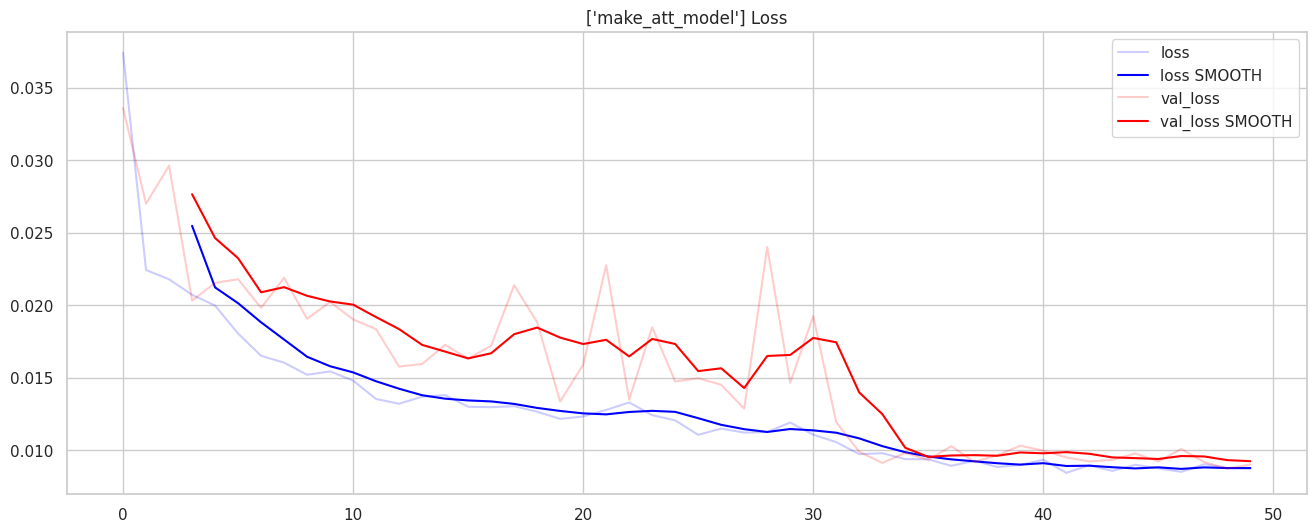

loading training log from /root/artem/analyser/training_reports/make_att_model.1.log.csv


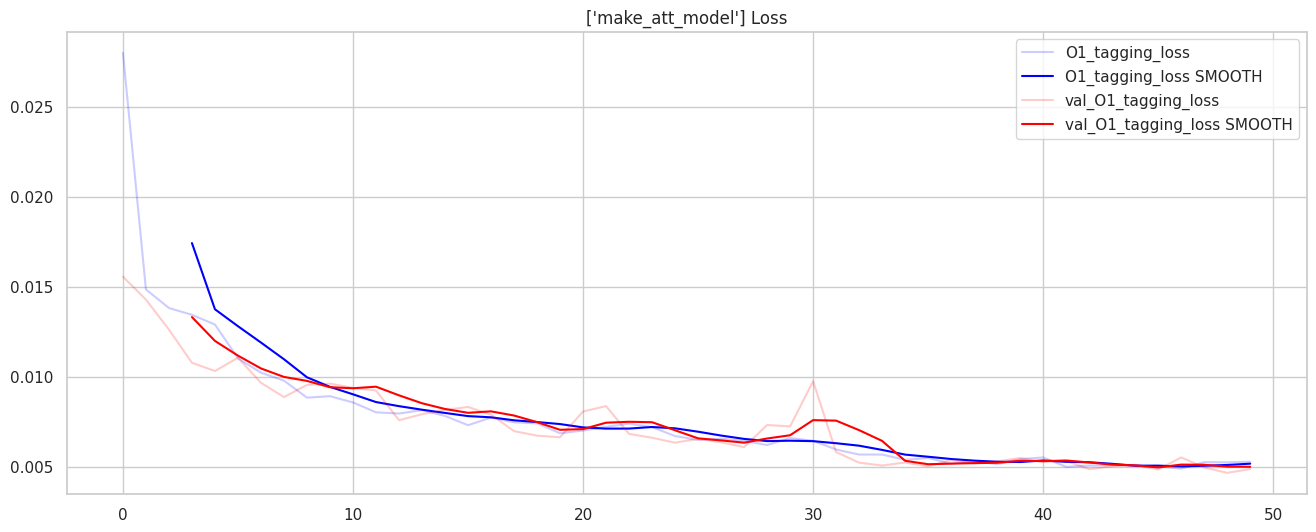

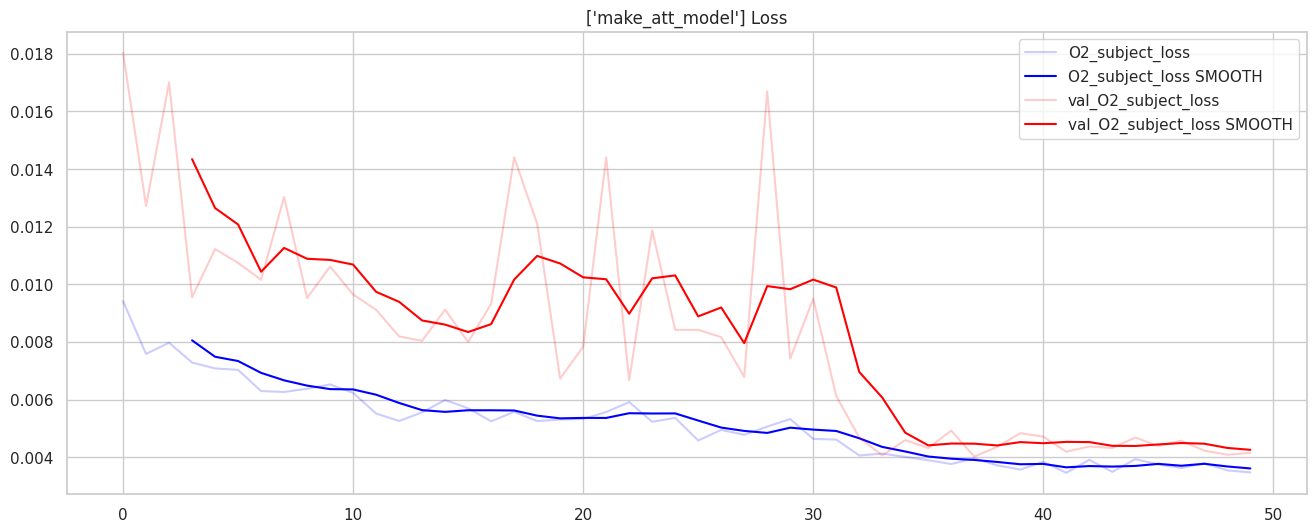

In [53]:
def plot_compare_models(
    models: [str],
    metrics, 
    title="metric/epoch",
    image_save_path = umtm.reports_dir):
    
  _metrics = [m for m in metrics if not m.startswith('val_')]

  for i, m in enumerate(models):

    data: pd.DataFrame = ctx.get_log(m)

    if data is not None:
      data.set_index('epoch')

      for metric in _metrics:
        plt.figure(figsize=(16, 6))
        plt.grid(True)
        plt.title(f'{metric} [{m}]')
        for metric_variant in ['', 'val_']:
          key = metric_variant + metric
          if key in data:

            x = data['epoch'][-100:]
            y = data[key][-100:]


            c = 'red'  # plt.cm.jet_r(i * colorstep)
            if metric_variant == '':
              c = 'blue'
            plt.plot(x, y, label=f'{key}', alpha=0.2, color=c)

            y = y.rolling(4, win_type='gaussian').mean(std=4)
            plt.plot(x, y, label=f'{key} SMOOTH', color=c)

            plt.legend(loc='upper right')

        
        plt.title(f'{[m]} {title}')
        plt.grid(True)
        img_path = os.path.join(image_save_path, f'{m}-{metric}.png')
        
        plt.savefig(img_path, bbox_inches='tight')        
        plt.show()
    else:
      logger.error('cannot plot')
    

models = list(ctx.trained_models.keys())


plot_compare_models(models, ['loss'], 'Loss')

# plot_compare_models(models, ['O1_tagging_kullback_leibler_divergence'], 'TAGS: Kullback Leibler divergence')
# plot_compare_models(models, ['O1_tagging_mse'], 'TAGS: MSE')
# plot_compare_models(models, ['O2_subject_kullback_leibler_divergence'], 'Subj: Kullback Leibler divergence')
# plot_compare_models(models, ['O2_subject_mse'],  'Subjects: MSE')

plot_compare_models(models, ['O1_tagging_loss', 'O2_subject_loss'], 'Loss')



## Contract subj Confusion matrices

In [54]:
# umtm.stats
# semantic_map_keys_contract


5ded4e284ddc27bcf92dd6ce


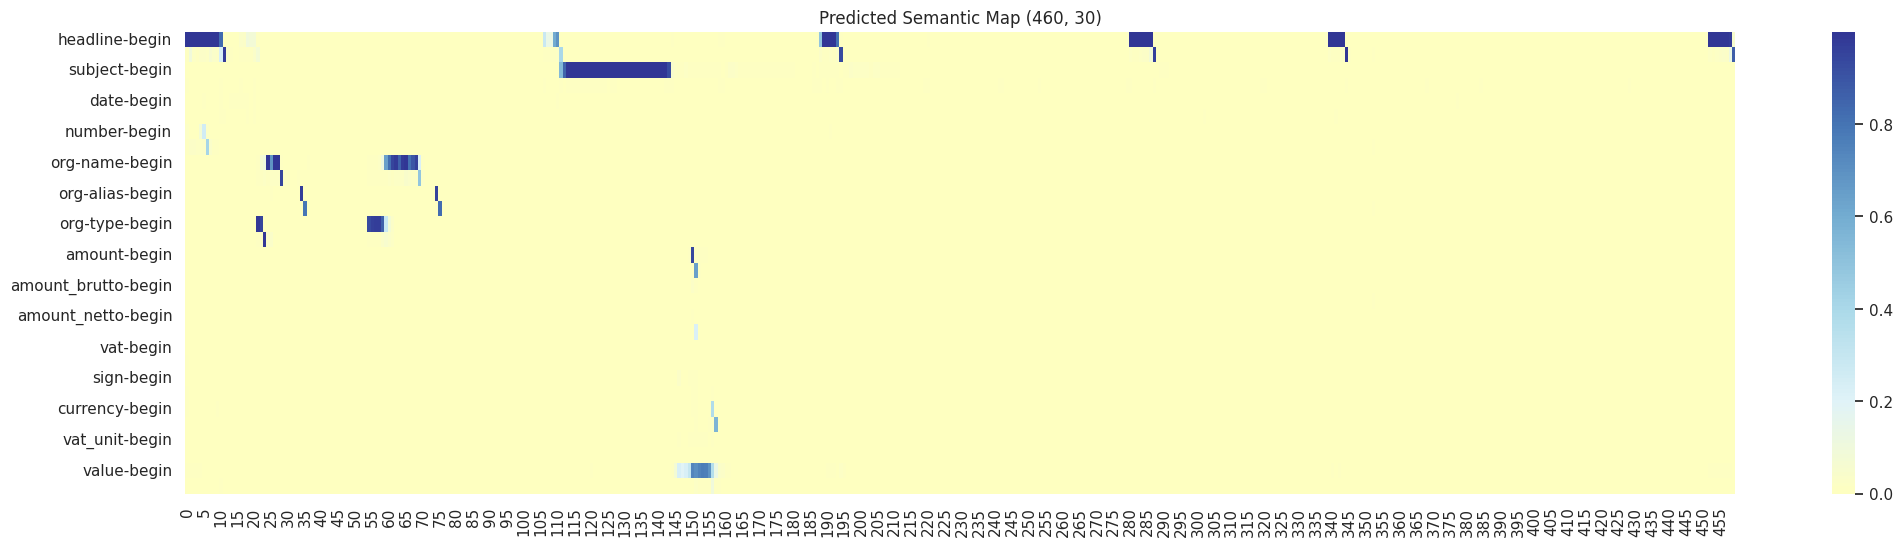

In [55]:
from tf_support.super_contract_model import make_xyw

sample_index = umtm.stats [umtm.stats['value']>0].index[2]
print(sample_index)

x, y, _ = make_xyw(sample_index, umtm.stats)

prediction = umodel.predict(x=[np.expand_dims(x[0], axis=0), np.expand_dims(x[1], axis=0)], batch_size=1)

tagsmap = pd.DataFrame(prediction[0][0], columns=semantic_map_keys_contract)
# .T
plot_embedding(tagsmap[:500], f'Predicted Semantic Map {tagsmap.shape}')

In [56]:
from analyser.contract_parser import nn_get_tag_values

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [57]:

agent_tags = ['org-1-name',
              'org-1-type',
              'org-1-alias',
              'org-2-name',
              'org-2-type',
              'org-2-alias']
solo_tags = [
  'date',
  'number',
  'sign_value_currency/value',
  'sign_value_currency/currency',
  'sign_value_currency/sign'
]

# seq_labels_contract[-3:]

tagnames = solo_tags + agent_tags


from pandas import DataFrame

from analyser.contract_agents import ContractAgent, normalize_contract_agent
from analyser.documents import TextMap
from analyser.ml_tools import SemanticTag
from analyser.persistence import DbJsonDoc
from analyser.text_tools import find_top_spans
# from tf_support.super_contract_model import seq_labels_contract
from tf_support.tf_subject_model import decode_subj_prediction

from analyser.contract_parser import nn_find_org_names, nn_get_tag_value




def fetch_tags_from_predicted_semantic_map(_id: str, tagsmap: DataFrame):
  jdoc = get_doc(_id)
  _map = jdoc.get_tokens_map_unchaged()

  results = {}
  for key in tagnames:
    t = nn_get_tag_value(key, _map, tagsmap )
    results[key] = t
    # print(t)

#   ca = ContractAgent()
#   ca.name =  results['org-1-name'] #TODO: check for NONE
#   ca.type =  results['org-1-type']
#   ca.alias = results['org-1-alias']
   

#   ca2 = ContractAgent()
#   ca2.name =  results['org-2-name'] #TODO: check for NONE
#   ca2.type =  results['org-2-type']
#   ca2.alias = results['org-2-alias']
#   try:
#     normalize_contract_agent(ca)
#     normalize_contract_agent(ca2)
#   except Exception as e:
#         # TODO:
#     logger.error(f'{_id} {e}')

  if results['number'] is not None:
    results['number'].value = results['number'].value.strip().lstrip('№').lstrip('N ').lstrip()

  return results, jdoc


def put_results_into_df(id_, results, df, jdoc: DbJsonDoc):
  org_atribs = ['name', 'alias', 'type']

  def v(x):
    if results[x] is not None:
      return results[x].value

  def swap(a, b):
    ab = [a, b]
    try:
      ab = sorted(ab)
    except:
      pass
    return ab

  def s(a, b):
    ab = swap(v(a), v(b))
    df.at[id_, f'p-{a}'] = ab[0]
    df.at[id_, f'p-{b}'] = ab[1]
    return ab

  for key in org_atribs:
    arr = s(f'org-1-{key}', f'org-2-{key}')

  def p(key):
    df.at[id_, f'p-{key}'] = v(key)

  p('sign_value_currency/value')
  p('sign_value_currency/currency')
  p('sign_value_currency/sign')

  p('date')
  p('number')

  # get_expected values
  for key in solo_tags:
    t = jdoc.get_attribute_value(key)
    df.at[id_, f'{key}'] = t

  for key in org_atribs:
    orgs = swap(jdoc.get_attribute_value(f'org-1-{key}'), jdoc.get_attribute_value(f'org-2-{key}'))
    df.at[id_, f'org-1-{key}'] = orgs[0]
    df.at[id_, f'org-2-{key}'] = orgs[1]



ImportError: cannot import name 'nn_get_tag_value' from 'analyser.contract_parser' (/root/artem/analyser/analyser/contract_parser.py)

In [ ]:
def make_subj_predictions(umodel, indices):
  ev = umtm.stats.copy()
  tags = pd.DataFrame()
  for t in tagnames:
    tags['p-' + t] = ''
    tags[t] = ''

  errors_report = pd.DataFrame()
  errors_report['expected'] = ''
  errors_report['predicted'] = ''

  for i, _id in enumerate(indices):
    logger.debug(f'validating {_id} {i} of {len(indices)}')
    
    x, y, _ = make_xyw(_id, umtm.stats)

    prediction = umodel.predict(x=[np.expand_dims(x[0], axis=0), np.expand_dims(x[1], axis=0)], batch_size=1)

    tagsmap = pd.DataFrame(prediction[0][0], columns=seq_labels_contract)
  
    r, jdoc = fetch_tags_from_predicted_semantic_map(_id, tagsmap)
    put_results_into_df(_id, r, tags, jdoc)
    

    subj_1hot = prediction[1][0]

    expected = decode_subj_prediction(y[1])[0]
    predicted = decode_subj_prediction(subj_1hot)[0]

    ev.at[_id, 'expected_subj'] = expected.name
    ev.at[_id, 'predicted_subj'] = predicted.name

    ev.at[_id, 'wrong'] = False
    if expected != predicted:
      ev.at[_id, 'wrong'] = True

  return ev, tags

ev, tags = make_subj_predictions(umodel, [sample_index])
tags

In [ ]:
%%time




# def fetch_tag_value(tagname: str, textmap: TextMap, tagging: DataFrame, threshold=0.3) -> SemanticTag or None:
#   att = tagging[tagname].values
#   slices = find_top_spans(att, threshold=threshold, limit=1) #TODO: estimate per-tag thresholds
  
#   if len(slices) > 0:
#     span = slices[0].start, slices[0].stop
#     value = textmap.text_range(span)
#     tag = SemanticTag(tagname, value, span)
#     tag.confidence = att[slices[0]].mean()
#     return tag
#   return None










subset = umtm.stats #umtm.stats[~pd.isna(umtm.stats['user_correction_date'])].sort_values('analyze_date')
_indices =  subset.index
ev, tags = make_subj_predictions(umodel, _indices)
tags.to_csv('all_contracts_predicstions.csv')

In [ ]:
# subset = umtm.stats[~pd.isna(umtm.stats['user_correction_date'])]
# pd.isna(umtm.stats['user_correction_date'])
ev 

In [ ]:
# _cols = [  'wrong' ]
# _tmp = ev[cols]
# errors_report = _tmp[ _tmp.wrong == True] #.sort_values('subject')
# print(len(errors_report), 'wrong subjects of', len(tags))
# errors_report 

ev['predicted_subj']
subj_df = ev[['predicted_subj', 'expected_subj']].copy()

In [ ]:
subj_df

In [ ]:
def make_report(umodel, ev):
  plot_cm(ev['expected_subj'], ev['predicted_subj'])
  
  img_path = os.path.join(umtm.work_dir, f'subjects-confusion-matrix-{umodel.name}.png')
  plt.savefig(img_path, bbox_inches='tight')

  report = classification_report(ev['expected_subj'], ev['predicted_subj'], digits=3)
  print(umodel.name)
  print(report)
  
  with open(os.path.join(umtm.work_dir, f'subjects-classification_report-{umodel.name}.txt'), "w") as text_file:
    text_file.write(report)


subj_df = ev[['predicted_subj', 'expected_subj']].copy() #ev[~pd.isna(ev['predicted_subj'])]
make_report(umodel, subj_df)

# Evaluate tags detection

In [ ]:
tags.fillna('-', inplace=True)
tags

In [ ]:
def save_csv(d, f):
    fn = os.path.join(umtm.work_dir, f)
    d.to_csv(fn)

### Contract number validation

In [ ]:
wrong_numbers = tags [ tags['number'] != tags['p-number']].sort_values('number')
print( f'Contract numbers: {len(wrong_numbers)} of {len(tags)}  ({100. * len(wrong_numbers) / len(tags) :0.1f}%) were detected wronggly')

save_csv( wrong_numbers[['p-number', 'number']], 'wrong_numbers.csv')

# wrong_numbers[['p-number', 'number']].tail(10)

In [ ]:
tags ['sign_value_currency/currency'].head(100)

In [ ]:
def conv(x):
    if type(x) is str:
        v = x.replace(',','.').replace(' ','')
    else: 
        v=x
    try:
        v=float(v)
    except:
        v=np.nan
    return v 

tags['n-p-sign_value_currency/value'] = pd.to_numeric( tags['p-sign_value_currency/value'].apply(conv) )
tags['n-sign_value_currency/value']   = pd.to_numeric( tags['sign_value_currency/value'].apply(conv) )

In [ ]:
wrong_values = tags [  tags['n-p-sign_value_currency/value']  != tags['n-sign_value_currency/value']]
cols = ['n-p-sign_value_currency/value', 'n-sign_value_currency/value']
wrong_values = wrong_values[cols]

wrong_values ['val_err'] = \
    np.log1p( np.abs(wrong_values['n-p-sign_value_currency/value'] - wrong_values['n-sign_value_currency/value']))
wrong_values = wrong_values.sort_values('val_err', ascending=False)

print(len(wrong_values))
wrong_values.tail(24)

### Contract Org-1 validation

In [ ]:


wrong_orgs1 = tags [ (tags['org-1-name'] != tags['p-org-1-name']) | (tags['org-2-name'] != tags['p-org-2-name']) ]
print( f'Org-1 name: {len(wrong_orgs1)} of {len(tags)}  ({100. * len(wrong_orgs1) / len(tags):0.1f}%) were detected incorrectly')

cols=['p-org-1-name', 'org-1-name', 'p-org-2-name', 'org-2-name']
save_csv( wrong_orgs1[cols], 'wrong_orgs1.csv')

wrong_orgs1[cols].head(20)

In [ ]:
wrong_aliases = tags [ (tags['org-1-alias'] != tags['p-org-1-alias']) | (tags['org-2-alias'] != tags['p-org-2-alias']) ]
print( f'Aliases: {len(wrong_aliases)} of {len(tags)}  ({100. * len(wrong_aliases) / len(tags) : 0.1f}%) were detected incorrectly')

cols=['p-org-1-alias', 'org-1-alias', 'p-org-2-alias', 'org-2-alias']
save_csv( wrong_aliases[cols], 'wrong_aliases.csv')
# wrong_aliases[cols].head(10)

In [ ]:
wrong_types = tags [ (tags['org-1-type'] != tags['p-org-1-type']) | (tags['org-2-type'] != tags['p-org-2-type'])]
print( f'Types: {len(wrong_types)} of {len(tags)}  ({100. * len(wrong_types) / len(tags) : 0.1f}%) were detected incorrectly')
cols=['p-org-1-type', 'p-org-2-type', 'org-1-type', 'org-2-type']
save_csv( wrong_types[cols], 'wrong_types.csv')
wrong_types[cols].head(10)

In [ ]:
from collections import Counter
arrays = [ wrong_orgs1, wrong_types, wrong_numbers, wrong_aliases]
counter = Counter()
for a in arrays:
  for i in a.index:
   counter[i]+=1
 

print('Самый сложный документ: ', counter.most_common()[0][0])
print("Всего недочетов:", len(counter))

In [ ]:
umtm.stats['errors'] = 0
for c in counter:
  umtm.stats.at[c, 'errors'] = counter[c]


calculate_samples_weights(umtm)
umtm._save_stats()
umtm.stats

## Single doc eval

In [ ]:
if IN_COLAB:
  !wget https://raw.githubusercontent.com/nemoware/analyser/uber-models/tests/contract_db_1.json

  with open('contract_db_1.json', 'rb') as handle:    
    jdata = json.load(handle, object_hook=json_util.object_hook)

  jdoc = DbJsonDoc(jdata)

else:
  from integration.db import get_mongodb_connection
  from bson.objectid import ObjectId

  def get_doc(objid):
    logger.debug(f'fetching {objid}')
    db = get_mongodb_connection()
    documents_collection = db['documents']
    jdata =  documents_collection.find_one({'_id': ObjectId(objid)})
    return DbJsonDoc(jdata)

  SAMPLE_DOC_ID = counter.most_common()[0][0] #umtm.stats.index[10]
    
    
    
  SAMPLE_DOC_ID = '5eea27adc28b75807f3dae66'
  print('SAMPLE_DOC_ID:', SAMPLE_DOC_ID)
  dp = umtm.make_xyw(SAMPLE_DOC_ID)
  (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp

  jdoc = get_doc(SAMPLE_DOC_ID)

In [ ]:
from analyser.legal_docs import embedd_tokens

if IN_COLAB:
  embedder = ElmoEmbedder.get_instance('elmo')  # lazy init
  emb = embedd_tokens(jdoc.get_tokens_for_embedding(),
                             embedder,
                             verbosity=2,
                             log_key='tmp')

  tok_f = get_tokens_features(jdoc.get_tokens_map_unchaged().tokens)

In [ ]:
###############
prediction = umodel.predict(   x=[  np.expand_dims(emb, axis=0), np.expand_dims(tok_f, axis=0)] , batch_size=1)
##############
print(len(prediction), umodel.name)
subj_1hot = prediction[1][0]
print('Subject:', decode_subj_prediction(subj_1hot))


tagging = pd.DataFrame( prediction[0][0], columns=seq_labels_contract)
plot_embedding(tagging, title = f'Predictions of {umodel.name}')

In [ ]:
def render_slices(slices, tokens, attention_v, ht='') -> str:
  ht += '<ol>'
  for _s in slices:
    ht += '<li>'
    t = tokens[_s]
    l = attention_v[_s]
    ht += to_color_text(t, l, _range=(0, 1.2))
    ht += '<br><hr>'
    ht += '</li>'
  ht += '</ol>'

  return ht

for t in seq_labels_contract:
  spans = list( find_top_spans( tagging[t].values, threshold=0.3))  
  display(HTML(render_slices(spans, jdoc.get_tokens_map_unchaged().tokens, tagging[t].values)))


In [ ]:

# mean_ = tagging.values.max(-1)*0.5
# print (mean_.shape)
# display(HTML( to_color_text (jdoc.get_tokens_map_unchaged().tokens[:24000],  mean_[:24000])))

In [ ]:
ids = '5edbadd7da3678279fbcaabf
5edbc660da3678279fbcaeac
5edbc668da3678279fbcaf6e
5edbc65dda3678279fbcae56
5edbc66bda3678279fbcafe6
5edbc615da3678279fbcadc9'